# Introductory deep learning on real-world dataset in Keras

## EuroSAT: Sentinel-2A-based deep learning benchmark dataset

[Resolution and swath of Sentinel-2A and 2B sensors](https://sentinel.esa.int/web/sentinel/missions/sentinel-2/instrument-payload/resolution-and-swath)

![](http://landsat.gsfc.nasa.gov/wp-content/uploads/2015/06/Landsat.v.Sentinel-2.png)

In [18]:
# TODO: Controlling system objects (e.g. List files in a specific directory); finished
# TODO: Build a real model; in progress
# TODO: reshape freely; almost done
# TODO: Amalgamize seaborn visualization system with other; still TODO

# Show all intermediate outputs in the code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# import module
from keras import activations as act
import pandas as pd
import sys, os
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as pyp
from sklearn.model_selection import train_test_split
from keras import applications
from keras.utils import np_utils
from keras.optimizers import adam
from keras.layers.core import Dense, Activation, Flatten
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [43]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [42]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16816493361317055518
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1479530905
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11559097637066794460
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:02:00.0, compute capability: 5.0"
]


In [2]:
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
import os
mypath = 'D:/DL/dj'
# initialize files
files = []
# At every subdirectory in mypath, find any file with its name ends with '.tif' then retrieve the full path then add the path to the list files
for r, d, f in os.walk(mypath):
    d.sort()
    for file in f:
        if ".jpg" in file:
            files.append(os.path.join(r, file))

In [15]:
files[2999:3002]

['D:/DL/dj\\AnnualCrop\\AnnualCrop_999.jpg',
 'D:/DL/dj\\Forest\\Forest_1.jpg',
 'D:/DL/dj\\Forest\\Forest_10.jpg']

In [3]:
from PIL import Image as im
from imageio import imread
#tif1 = imread('D:/DL/ds/AnnualCrop/AnnualCrop_1080.tif')
trains = [np.array(imread(ti)) for ti in files]

In [154]:
trains_a = np.asarray(trains)
trains_a = trains_a / 255.

In [5]:
### Exploratory analysis

In [5]:
trains_a[1,].shape
trains_a.shape
trs = trains_a[1,]
trains_a.max()
trains_a.min()


(64, 64, 3)

(27000, 64, 64, 3)

255

0

<Figure size 1728x864 with 0 Axes>

IndexError: index 3 is out of bounds for axis 2 with size 3

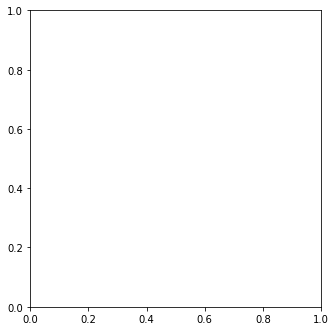

In [6]:
#?pyp.imshow
pyp.figure(figsize=(24,12))

pyp.subplot(241)
# Annual crop
pyp.imshow(trains_a[1,][:,:,(3,2,1)]/2**12, interpolation='bilinear')
pyp.subplot(242)
# Sea/Lake
pyp.imshow(trains_a[26012,][:,:,(3,2,1)]/2**12, interpolation='bilinear')
pyp.subplot(243)
# Industrial
pyp.imshow(trains_a[13325,][:,:,(3,2,1)]/2**12, interpolation='bilinear')
pyp.subplot(244)
# Residential
pyp.imshow(trains_a[21002,][:,:,(3,2,1)]/2**12, interpolation='bilinear')

pyp.subplot(245)
# Forest
pyp.imshow(trains_a[4500,][:,:,(3,2,1)]/2**12, interpolation='bilinear')
pyp.subplot(246)
# Herbaceous
pyp.imshow(trains_a[7801,][:,:,(3,2,1)]/2**12, interpolation='bilinear')
pyp.subplot(247)
# Highway
pyp.imshow(trains_a[11111,][:,:,(3,2,1)]/2**12, interpolation='bilinear')
pyp.subplot(248)
# River
pyp.imshow(trains_a[22222,][:,:,(3,2,1)]/2**12, interpolation='bilinear')

pyp.show()



In [9]:
trains_a[13,][:,:,bands]

array([[[177, 137, 127],
        [178, 135, 128],
        [178, 135, 128],
        ...,
        [ 74, 104,  96],
        [ 73, 102,  97],
        [ 73, 102,  97]],

       [[179, 139, 131],
        [182, 139, 130],
        [182, 137, 131],
        ...,
        [ 75, 102,  95],
        [ 73, 103,  95],
        [ 73, 103,  95]],

       [[177, 139, 130],
        [180, 137, 130],
        [183, 138, 132],
        ...,
        [ 75, 100,  94],
        [ 74, 101,  94],
        [ 73, 103,  93]],

       ...,

       [[ 92, 111, 107],
        [ 83, 104,  99],
        [ 75,  98,  92],
        ...,
        [ 69,  93,  93],
        [ 71,  92,  93],
        [ 70,  94,  94]],

       [[ 87, 107, 105],
        [ 85, 108, 102],
        [ 76, 101,  95],
        ...,
        [ 71,  92,  93],
        [ 72,  94,  92],
        [ 69,  94,  91]],

       [[ 74,  96,  94],
        [ 79, 101,  98],
        [ 80, 103,  97],
        ...,
        [ 72,  93,  94],
        [ 71,  93,  91],
        [ 69,  94,  91]]

<Figure size 1728x864 with 0 Axes>

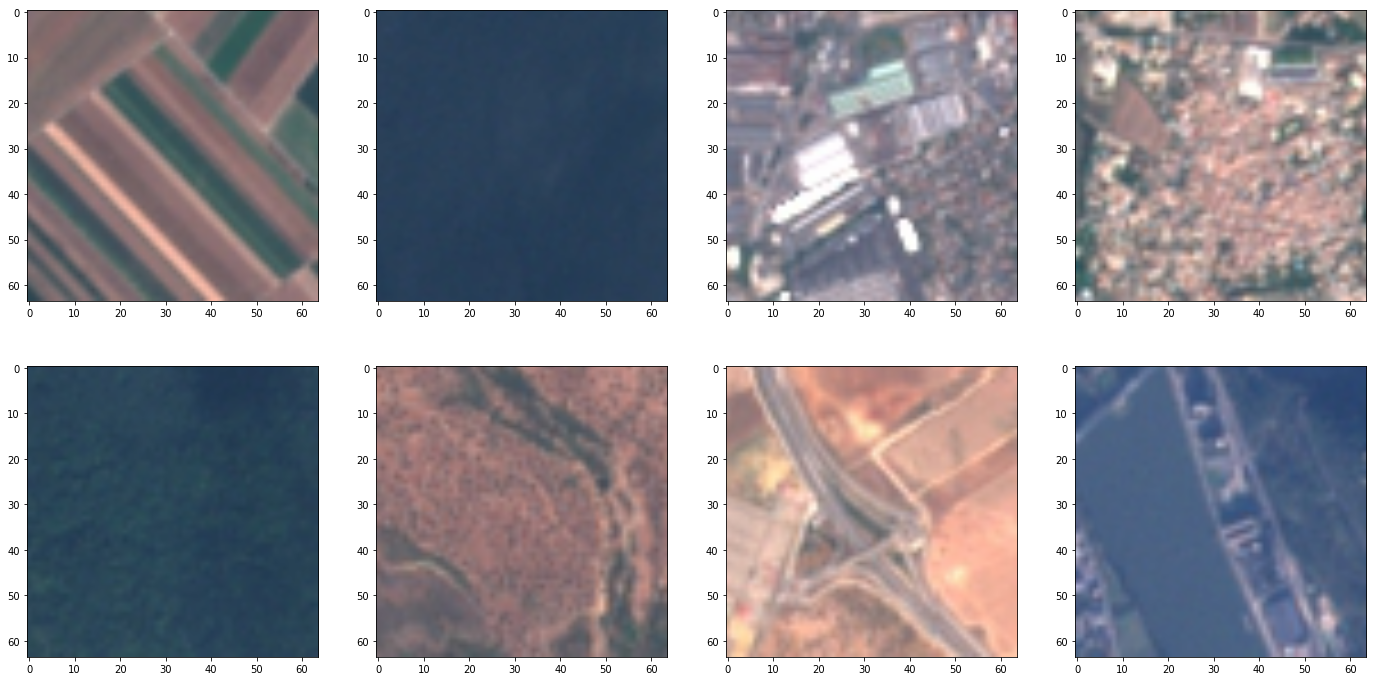

In [10]:
pyp.figure(figsize=(24,12))

denominator = 1
bands = (0,1,2)
pyp.subplot(241)
# Annual crop
pyp.imshow(trains_a[1,][:,:,bands], interpolation='bilinear')
pyp.subplot(242)
# Sea/Lake
pyp.imshow(trains_a[26012,][:,:,bands], interpolation='bilinear')
pyp.subplot(243)
# Industrial
pyp.imshow(trains_a[13325,][:,:,bands], interpolation='bilinear')
pyp.subplot(244)
# Residential
pyp.imshow(trains_a[21002,][:,:,bands], interpolation='bilinear')

pyp.subplot(245)
# Forest
pyp.imshow(trains_a[4500,][:,:,bands], interpolation='bilinear')
pyp.subplot(246)
# Herbaceous
pyp.imshow(trains_a[7801,][:,:,bands], interpolation='bilinear')
pyp.subplot(247)
# Highway
pyp.imshow(trains_a[11111,][:,:,bands], interpolation='bilinear')
pyp.subplot(248)
# River
pyp.imshow(trains_a[22222,][:,:,bands], interpolation='bilinear')

pyp.show()



In [65]:
labels = {0:'Annual Crop', 1:'Forest', 2:'Herbaceous', 3:'Highway', 4:'Industrial', 5:'Pasture', 6:'Permanent Crop', 7:'Residential', 8:'River', 9:'Sea/Lake'}
labels
#labels.dtype = 'string'
nnums = [3000., 3000., 3000., 2500., 2500., 2000., 2500., 3000., 2500., 3000.]
nnumt = [0., 3000., 3000., 3000., 2500., 2500., 2000., 2500., 3000., 2500.]
labels_r = np.repeat(list(labels.keys()), nnums, axis = 0) 
labels_r.__len__()

labels_r.dtype = np.int32
labels_r
labels_r


labels.keys()
nnuma = np.cumsum(nnumt)

nak = [np.arange(0, k) for k in nnums]
nak = [np.random.choice(k, int(0.9 * k.__len__()), replace = False) for k in nak]
list(map(lambda x, y: x + y, nak, nnuma))
nak[:100]

{0: 'Annual Crop',
 1: 'Forest',
 2: 'Herbaceous',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'Permanent Crop',
 7: 'Residential',
 8: 'River',
 9: 'Sea/Lake'}

27000

array([0, 0, 0, ..., 9, 9, 9])

array([0, 0, 0, ..., 9, 9, 9])

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

[array([  26., 2472., 1002., ...,   95., 1297., 2313.]),
 array([3369., 4193., 3110., ..., 3889., 5309., 3959.]),
 array([8728., 6988., 7651., ..., 8205., 7255., 6758.]),
 array([10996.,  9250.,  9206., ...,  9633., 11391., 10679.]),
 array([13784., 13127., 12713., ..., 11773., 13069., 13482.]),
 array([14985., 14898., 15315., ..., 14986., 14675., 15733.]),
 array([17899., 17519., 17207., ..., 17416., 16681., 16264.]),
 array([21452., 18508., 18609., ..., 20348., 21124., 19277.]),
 array([21998., 23637., 23475., ..., 22888., 23826., 22575.]),
 array([24183., 24590., 26664., ..., 25567., 25178., 24188.])]

[array([  26., 2472., 1002., ...,   95., 1297., 2313.]),
 array([ 369., 1193.,  110., ...,  889., 2309.,  959.]),
 array([2728.,  988., 1651., ..., 2205., 1255.,  758.]),
 array([1996.,  250.,  206., ...,  633., 2391., 1679.]),
 array([2284., 1627., 1213., ...,  273., 1569., 1982.]),
 array([ 985.,  898., 1315., ...,  986.,  675., 1733.]),
 array([1899., 1519., 1207., ..., 1416.,  681.,  264.]),
 array([2952.,    8.,  109., ..., 1848., 2624.,  777.]),
 array([ 498., 2137., 1975., ..., 1388., 2326., 1075.]),
 array([ 183.,  590., 2664., ..., 1567., 1178.,  188.])]

In [158]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#trains_a = trains_a.reshape(27000, 64, 64, 13)
#trains_as = MinMaxScaler(trains_a)

#trains_as
X_train, X_test, y_train, y_test = train_test_split(
     trains_a, labels_r, test_size=0.2, random_state=18643)

#X_train_t, y_train_t = train_datagen.flow(X_train, y_train, target_(64, 64))
#X_test_t, y_test_t = train_datagen.flow(X_test, y_test, (64, 64))


In [106]:
#X_train_t2 = X_train / 255.
#X_test_t2 = X_test / 255.

In [160]:
#X_train[:2, :, :, :]
labels_r
#X_train_t2[:3,]

array([0, 0, 0, ..., 9, 9, 9])

In [159]:
y_train
y_test
?np_utils.to_categorical


array([7, 2, 4, ..., 3, 2, 1])

array([3, 2, 9, ..., 3, 9, 4])

In [161]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(21600, 64, 64, 3)

(21600,)

(5400, 64, 64, 3)

(5400,)

In [162]:

#np.true_divide(X_train, 2**12)


y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [163]:
y_train[0,]
y_test[0,]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [170]:
# 10 outputs
# final stage is softmax
model = Sequential()
model.add(Conv2D(39, kernel_size=5, input_shape = (32,32,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=5, input_shape = (30,30,39), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))
print(model.output_shape)
model.summary()

(None, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 39)        1989      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 39)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 128)       124928    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               590336    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         

In [166]:
conv_base = applications.VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))

In [ ]:
X_train_p = conv_base.predict(X_train)
#X_train_p = X_tensor
X_test_p = conv_base.predict(X_test)


In [408]:
#X_train_p.shape
X_train_p2 = np.reshape(X_train_p, (21600, 32, 32, 2))
X_test_p2 = np.reshape(X_test_p, (5400, 32, 32, 2))
#X_train_p2

### Random subset of the imagery
+ The code block below functions to generate 4000 pairs of addresses for subsetting the imagery

In [149]:
# obsolete
#model = Sequential()
#model.add(Conv2D(16, kernel_size=3, input_shape = (32,32,2), activation='relu'))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Conv2D(64, kernel_size=5, input_shape = (15,15,16), activation='relu'))
#model.add(MaxPooling2D(pool_size=(3,3)))

#model.add(Dense(1024, activation = 'relu', input_dim = (32 * 32 * 2)))
#model.add(Dropout(0.5))
#model.add(Dense(1024, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(512, activation = 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(10, activation = 'softmax'))
#model.add(Activation('softmax'))
#print(model.output_shape)
#model.summary()

(None, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                5130      

In [171]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam(), metrics = ['accuracy'])

In [175]:
history = model.fit(X_train_p2, y_train,
batch_size = 32, epochs = 50,
verbose = True, validation_split = 0.33)

Train on 14471 samples, validate on 7129 samples
Epoch 1/50


   32/14471 [..............................] - ETA: 8:46 - loss: 2.3804 - acc: 0.1562

   96/14471 [..............................] - ETA: 3:03 - loss: 2.3836 - acc: 0.1354

  160/14471 [..............................] - ETA: 1:54 - loss: 2.4066 - acc: 0.1313

  224/14471 [..............................] - ETA: 1:25 - loss: 2.3867 - acc: 0.1250

  288/14471 [..............................] - ETA: 1:08 - loss: 2.3662 - acc: 0.1319

  352/14471 [..............................] - ETA: 58s - loss: 2.3624 - acc: 0.1222 

  416/14471 [..............................] - ETA: 50s - loss: 2.3639 - acc: 0.1250

  480/14471 [..............................] - ETA: 45s - loss: 2.3604 - acc: 0.1187

  544/14471 [>.............................] - ETA: 41s - loss: 2.3484 - acc: 0.1250

  608/14471 [>.............................] - ETA: 38s - loss: 2.3441 - acc: 0.1135

  672/14471 [>.............................] - ETA: 35s - loss: 2.3380 - acc: 0.1131

  736/14471 [>.............................] - ETA: 33s - loss: 2.3357 - acc: 0.1101

  800/14471 [>.............................] - ETA: 31s - loss: 2.3302 - acc: 0.1150

  864/14471 [>.............................] - ETA: 30s - loss: 2.3253 - acc: 0.1227

  928/14471 [>.............................] - ETA: 28s - loss: 2.3192 - acc: 0.1250

  992/14471 [=>............................] - ETA: 27s - loss: 2.3132 - acc: 0.1300

 1056/14471 [=>............................] - ETA: 26s - loss: 2.3079 - acc: 0.1307

 1120/14471 [=>............................] - ETA: 25s - loss: 2.3012 - acc: 0.1357

 1184/14471 [=>............................] - ETA: 24s - loss: 2.2912 - acc: 0.1461

 1248/14471 [=>............................] - ETA: 23s - loss: 2.2895 - acc: 0.1450

 1312/14471 [=>............................] - ETA: 23s - loss: 2.2821 - acc: 0.1471

 1376/14471 [=>............................] - ETA: 22s - loss: 2.2746 - acc: 0.1483

 1440/14471 [=>............................] - ETA: 21s - loss: 2.2646 - acc: 0.1535

 1504/14471 [==>...........................] - ETA: 21s - loss: 2.2548 - acc: 0.1569

 1568/14471 [==>...........................] - ETA: 20s - loss: 2.2432 - acc: 0.1582

 1632/14471 [==>...........................] - ETA: 20s - loss: 2.2331 - acc: 0.1593

 1696/14471 [==>...........................] - ETA: 19s - loss: 2.2256 - acc: 0.1616

 1760/14471 [==>...........................] - ETA: 19s - loss: 2.2178 - acc: 0.1665

 1824/14471 [==>...........................] - ETA: 19s - loss: 2.2104 - acc: 0.1683

 1888/14471 [==>...........................] - ETA: 18s - loss: 2.1955 - acc: 0.1753

 1952/14471 [===>..........................] - ETA: 18s - loss: 2.1852 - acc: 0.1778

 2016/14471 [===>..........................] - ETA: 18s - loss: 2.1734 - acc: 0.1825

 2080/14471 [===>..........................] - ETA: 17s - loss: 2.1577 - acc: 0.1880

 2144/14471 [===>..........................] - ETA: 17s - loss: 2.1437 - acc: 0.1922

 2208/14471 [===>..........................] - ETA: 17s - loss: 2.1329 - acc: 0.1957

 2272/14471 [===>..........................] - ETA: 16s - loss: 2.1226 - acc: 0.1994

 2336/14471 [===>..........................] - ETA: 16s - loss: 2.1112 - acc: 0.2033

 2400/14471 [===>..........................] - ETA: 16s - loss: 2.1033 - acc: 0.2062

 2464/14471 [====>.........................] - ETA: 16s - loss: 2.0898 - acc: 0.2123

 2528/14471 [====>.........................] - ETA: 16s - loss: 2.0782 - acc: 0.2164

 2592/14471 [====>.........................] - ETA: 15s - loss: 2.0636 - acc: 0.2226

 2656/14471 [====>.........................] - ETA: 15s - loss: 2.0521 - acc: 0.2263

 2720/14471 [====>.........................] - ETA: 15s - loss: 2.0418 - acc: 0.2298

 2784/14471 [====>.........................] - ETA: 15s - loss: 2.0320 - acc: 0.2317

 2848/14471 [====>.........................] - ETA: 15s - loss: 2.0198 - acc: 0.2349

 2912/14471 [=====>........................] - ETA: 14s - loss: 2.0090 - acc: 0.2376

 2976/14471 [=====>........................] - ETA: 14s - loss: 1.9971 - acc: 0.2419

 3040/14471 [=====>........................] - ETA: 14s - loss: 1.9882 - acc: 0.2434

 3104/14471 [=====>........................] - ETA: 14s - loss: 1.9741 - acc: 0.2484

 3168/14471 [=====>........................] - ETA: 14s - loss: 1.9662 - acc: 0.2497

 3232/14471 [=====>........................] - ETA: 13s - loss: 1.9557 - acc: 0.2525

 3296/14471 [=====>........................] - ETA: 13s - loss: 1.9481 - acc: 0.2570

 3360/14471 [=====>........................] - ETA: 13s - loss: 1.9375 - acc: 0.2607

 3424/14471 [======>.......................] - ETA: 13s - loss: 1.9281 - acc: 0.2640

 3488/14471 [======>.......................] - ETA: 13s - loss: 1.9242 - acc: 0.2652

 3552/14471 [======>.......................] - ETA: 13s - loss: 1.9184 - acc: 0.2672

 3616/14471 [======>.......................] - ETA: 13s - loss: 1.9118 - acc: 0.2683

 3680/14471 [======>.......................] - ETA: 12s - loss: 1.9076 - acc: 0.2690

 3744/14471 [======>.......................] - ETA: 12s - loss: 1.9010 - acc: 0.2732

 3808/14471 [======>.......................] - ETA: 12s - loss: 1.8935 - acc: 0.2757

 3872/14471 [=======>......................] - ETA: 12s - loss: 1.8835 - acc: 0.2800

 3936/14471 [=======>......................] - ETA: 12s - loss: 1.8777 - acc: 0.2812

 4000/14471 [=======>......................] - ETA: 12s - loss: 1.8683 - acc: 0.2855

 4064/14471 [=======>......................] - ETA: 12s - loss: 1.8610 - acc: 0.2884

 4128/14471 [=======>......................] - ETA: 12s - loss: 1.8511 - acc: 0.2914

 4192/14471 [=======>......................] - ETA: 11s - loss: 1.8446 - acc: 0.2937

 4256/14471 [=======>......................] - ETA: 11s - loss: 1.8394 - acc: 0.2956

 4320/14471 [=======>......................] - ETA: 11s - loss: 1.8300 - acc: 0.2993

 4384/14471 [========>.....................] - ETA: 11s - loss: 1.8261 - acc: 0.2997

 4448/14471 [========>.....................] - ETA: 11s - loss: 1.8205 - acc: 0.3028

 4512/14471 [========>.....................] - ETA: 11s - loss: 1.8118 - acc: 0.3059

 4576/14471 [========>.....................] - ETA: 11s - loss: 1.8046 - acc: 0.3073

 4640/14471 [========>.....................] - ETA: 11s - loss: 1.7990 - acc: 0.3088

 4704/14471 [========>.....................] - ETA: 11s - loss: 1.7924 - acc: 0.3119

 4768/14471 [========>.....................] - ETA: 10s - loss: 1.7880 - acc: 0.3131

 4832/14471 [=========>....................] - ETA: 10s - loss: 1.7813 - acc: 0.3158

 4896/14471 [=========>....................] - ETA: 10s - loss: 1.7754 - acc: 0.3178

 4960/14471 [=========>....................] - ETA: 10s - loss: 1.7689 - acc: 0.3204

 5024/14471 [=========>....................] - ETA: 10s - loss: 1.7640 - acc: 0.3217

 5088/14471 [=========>....................] - ETA: 10s - loss: 1.7589 - acc: 0.3231

 5152/14471 [=========>....................] - ETA: 10s - loss: 1.7513 - acc: 0.3267

 5216/14471 [=========>....................] - ETA: 10s - loss: 1.7449 - acc: 0.3290

 5280/14471 [=========>....................] - ETA: 10s - loss: 1.7382 - acc: 0.3314

 5344/14471 [==========>...................] - ETA: 10s - loss: 1.7311 - acc: 0.3340

 5408/14471 [==========>...................] - ETA: 10s - loss: 1.7272 - acc: 0.3354

 5472/14471 [==========>...................] - ETA: 9s - loss: 1.7218 - acc: 0.3379 

 5536/14471 [==========>...................] - ETA: 9s - loss: 1.7141 - acc: 0.3412

 5600/14471 [==========>...................] - ETA: 9s - loss: 1.7100 - acc: 0.3429

 5664/14471 [==========>...................] - ETA: 9s - loss: 1.7034 - acc: 0.3452

 5728/14471 [==========>...................] - ETA: 9s - loss: 1.6977 - acc: 0.3471

 5792/14471 [===========>..................] - ETA: 9s - loss: 1.6927 - acc: 0.3489

 5856/14471 [===========>..................] - ETA: 9s - loss: 1.6869 - acc: 0.3514

 5920/14471 [===========>..................] - ETA: 9s - loss: 1.6823 - acc: 0.3530

 5984/14471 [===========>..................] - ETA: 9s - loss: 1.6759 - acc: 0.3554

 6048/14471 [===========>..................] - ETA: 9s - loss: 1.6696 - acc: 0.3573

 6112/14471 [===========>..................] - ETA: 9s - loss: 1.6637 - acc: 0.3595

 6176/14471 [===========>..................] - ETA: 9s - loss: 1.6603 - acc: 0.3606

 6240/14471 [===========>..................] - ETA: 8s - loss: 1.6548 - acc: 0.3628

 6304/14471 [============>.................] - ETA: 8s - loss: 1.6473 - acc: 0.3660

 6368/14471 [============>.................] - ETA: 8s - loss: 1.6424 - acc: 0.3678

 6432/14471 [============>.................] - ETA: 8s - loss: 1.6364 - acc: 0.3702

 6496/14471 [============>.................] - ETA: 8s - loss: 1.6314 - acc: 0.3715

 6560/14471 [============>.................] - ETA: 8s - loss: 1.6282 - acc: 0.3729

 6624/14471 [============>.................] - ETA: 8s - loss: 1.6196 - acc: 0.3756

 6688/14471 [============>.................] - ETA: 8s - loss: 1.6164 - acc: 0.3771

 6752/14471 [============>.................] - ETA: 8s - loss: 1.6124 - acc: 0.3784

 6816/14471 [=============>................] - ETA: 8s - loss: 1.6095 - acc: 0.3795

 6880/14471 [=============>................] - ETA: 8s - loss: 1.6062 - acc: 0.3811

 6944/14471 [=============>................] - ETA: 8s - loss: 1.6026 - acc: 0.3826

 7008/14471 [=============>................] - ETA: 8s - loss: 1.5973 - acc: 0.3851

 7072/14471 [=============>................] - ETA: 7s - loss: 1.5958 - acc: 0.3853

 7136/14471 [=============>................] - ETA: 7s - loss: 1.5900 - acc: 0.3876

 7200/14471 [=============>................] - ETA: 7s - loss: 1.5851 - acc: 0.3894

 7264/14471 [==============>...............] - ETA: 7s - loss: 1.5821 - acc: 0.3908

 7328/14471 [==============>...............] - ETA: 7s - loss: 1.5766 - acc: 0.3931

 7392/14471 [==============>...............] - ETA: 7s - loss: 1.5711 - acc: 0.3954

 7456/14471 [==============>...............] - ETA: 7s - loss: 1.5681 - acc: 0.3969

 7520/14471 [==============>...............] - ETA: 7s - loss: 1.5657 - acc: 0.3985

 7584/14471 [==============>...............] - ETA: 7s - loss: 1.5601 - acc: 0.4012

 7648/14471 [==============>...............] - ETA: 7s - loss: 1.5536 - acc: 0.4042

 7712/14471 [==============>...............] - ETA: 7s - loss: 1.5506 - acc: 0.4053

 7776/14471 [===============>..............] - ETA: 7s - loss: 1.5452 - acc: 0.4073

 7840/14471 [===============>..............] - ETA: 7s - loss: 1.5397 - acc: 0.4098

 7904/14471 [===============>..............] - ETA: 6s - loss: 1.5337 - acc: 0.4121

 7968/14471 [===============>..............] - ETA: 6s - loss: 1.5290 - acc: 0.4142

 8032/14471 [===============>..............] - ETA: 6s - loss: 1.5257 - acc: 0.4156

 8096/14471 [===============>..............] - ETA: 6s - loss: 1.5212 - acc: 0.4174

 8160/14471 [===============>..............] - ETA: 6s - loss: 1.5166 - acc: 0.4195

 8224/14471 [================>.............] - ETA: 6s - loss: 1.5140 - acc: 0.4208

 8288/14471 [================>.............] - ETA: 6s - loss: 1.5084 - acc: 0.4230

 8352/14471 [================>.............] - ETA: 6s - loss: 1.5063 - acc: 0.4242

 8416/14471 [================>.............] - ETA: 6s - loss: 1.5020 - acc: 0.4257

 8480/14471 [================>.............] - ETA: 6s - loss: 1.4974 - acc: 0.4271

 8544/14471 [================>.............] - ETA: 6s - loss: 1.4932 - acc: 0.4291

 8608/14471 [================>.............] - ETA: 6s - loss: 1.4916 - acc: 0.4295

 8672/14471 [================>.............] - ETA: 6s - loss: 1.4875 - acc: 0.4313

 8736/14471 [=================>............] - ETA: 5s - loss: 1.4833 - acc: 0.4328

 8800/14471 [=================>............] - ETA: 5s - loss: 1.4787 - acc: 0.4347

 8864/14471 [=================>............] - ETA: 5s - loss: 1.4748 - acc: 0.4364

 8928/14471 [=================>............] - ETA: 5s - loss: 1.4722 - acc: 0.4375

 8992/14471 [=================>............] - ETA: 5s - loss: 1.4709 - acc: 0.4382

 9056/14471 [=================>............] - ETA: 5s - loss: 1.4678 - acc: 0.4397

 9120/14471 [=================>............] - ETA: 5s - loss: 1.4635 - acc: 0.4412

 9184/14471 [==================>...........] - ETA: 5s - loss: 1.4599 - acc: 0.4426

 9248/14471 [==================>...........] - ETA: 5s - loss: 1.4575 - acc: 0.4434

 9312/14471 [==================>...........] - ETA: 5s - loss: 1.4539 - acc: 0.4451

 9376/14471 [==================>...........] - ETA: 5s - loss: 1.4514 - acc: 0.4462

 9440/14471 [==================>...........] - ETA: 5s - loss: 1.4479 - acc: 0.4479

 9504/14471 [==================>...........] - ETA: 5s - loss: 1.4444 - acc: 0.4496

 9568/14471 [==================>...........] - ETA: 5s - loss: 1.4421 - acc: 0.4507

 9632/14471 [==================>...........] - ETA: 4s - loss: 1.4380 - acc: 0.4523

 9696/14471 [===================>..........] - ETA: 4s - loss: 1.4343 - acc: 0.4539

 9760/14471 [===================>..........] - ETA: 4s - loss: 1.4323 - acc: 0.4552

 9824/14471 [===================>..........] - ETA: 4s - loss: 1.4286 - acc: 0.4562

 9888/14471 [===================>..........] - ETA: 4s - loss: 1.4264 - acc: 0.4572

 9952/14471 [===================>..........] - ETA: 4s - loss: 1.4244 - acc: 0.4583

10016/14471 [===================>..........] - ETA: 4s - loss: 1.4209 - acc: 0.4602

10080/14471 [===================>..........] - ETA: 4s - loss: 1.4184 - acc: 0.4619

10144/14471 [====================>.........] - ETA: 4s - loss: 1.4145 - acc: 0.4634

10208/14471 [====================>.........] - ETA: 4s - loss: 1.4129 - acc: 0.4643

10272/14471 [====================>.........] - ETA: 4s - loss: 1.4111 - acc: 0.4652

10336/14471 [====================>.........] - ETA: 4s - loss: 1.4074 - acc: 0.4670

10400/14471 [====================>.........] - ETA: 4s - loss: 1.4035 - acc: 0.4688

10464/14471 [====================>.........] - ETA: 4s - loss: 1.4013 - acc: 0.4696

10528/14471 [====================>.........] - ETA: 4s - loss: 1.3973 - acc: 0.4712

10592/14471 [====================>.........] - ETA: 3s - loss: 1.3937 - acc: 0.4727

10656/14471 [=====================>........] - ETA: 3s - loss: 1.3904 - acc: 0.4740

10720/14471 [=====================>........] - ETA: 3s - loss: 1.3857 - acc: 0.4758

10784/14471 [=====================>........] - ETA: 3s - loss: 1.3816 - acc: 0.4775

10848/14471 [=====================>........] - ETA: 3s - loss: 1.3772 - acc: 0.4790

10912/14471 [=====================>........] - ETA: 3s - loss: 1.3741 - acc: 0.4805

10976/14471 [=====================>........] - ETA: 3s - loss: 1.3719 - acc: 0.4814

11040/14471 [=====================>........] - ETA: 3s - loss: 1.3698 - acc: 0.4822

11104/14471 [======================>.......] - ETA: 3s - loss: 1.3655 - acc: 0.4839

11168/14471 [======================>.......] - ETA: 3s - loss: 1.3629 - acc: 0.4851

11232/14471 [======================>.......] - ETA: 3s - loss: 1.3612 - acc: 0.4857

11296/14471 [======================>.......] - ETA: 3s - loss: 1.3592 - acc: 0.4866

11360/14471 [======================>.......] - ETA: 3s - loss: 1.3568 - acc: 0.4878

11424/14471 [======================>.......] - ETA: 3s - loss: 1.3548 - acc: 0.4889

11488/14471 [======================>.......] - ETA: 3s - loss: 1.3522 - acc: 0.4897

11552/14471 [======================>.......] - ETA: 2s - loss: 1.3510 - acc: 0.4907

11616/14471 [=======================>......] - ETA: 2s - loss: 1.3474 - acc: 0.4924

11680/14471 [=======================>......] - ETA: 2s - loss: 1.3447 - acc: 0.4936

11744/14471 [=======================>......] - ETA: 2s - loss: 1.3411 - acc: 0.4951

11808/14471 [=======================>......] - ETA: 2s - loss: 1.3371 - acc: 0.4969

11872/14471 [=======================>......] - ETA: 2s - loss: 1.3344 - acc: 0.4977

11936/14471 [=======================>......] - ETA: 2s - loss: 1.3317 - acc: 0.4987

12000/14471 [=======================>......] - ETA: 2s - loss: 1.3283 - acc: 0.5001

12064/14471 [========================>.....] - ETA: 2s - loss: 1.3257 - acc: 0.5012

12128/14471 [========================>.....] - ETA: 2s - loss: 1.3244 - acc: 0.5017

12192/14471 [========================>.....] - ETA: 2s - loss: 1.3210 - acc: 0.5034

12256/14471 [========================>.....] - ETA: 2s - loss: 1.3177 - acc: 0.5048

12320/14471 [========================>.....] - ETA: 2s - loss: 1.3159 - acc: 0.5058

12384/14471 [========================>.....] - ETA: 2s - loss: 1.3129 - acc: 0.5070

12448/14471 [========================>.....] - ETA: 2s - loss: 1.3108 - acc: 0.5078

12512/14471 [========================>.....] - ETA: 1s - loss: 1.3075 - acc: 0.5092

12576/14471 [=========================>....] - ETA: 1s - loss: 1.3050 - acc: 0.5100

12640/14471 [=========================>....] - ETA: 1s - loss: 1.3025 - acc: 0.5110

12704/14471 [=========================>....] - ETA: 1s - loss: 1.2995 - acc: 0.5123

12768/14471 [=========================>....] - ETA: 1s - loss: 1.2986 - acc: 0.5128

12832/14471 [=========================>....] - ETA: 1s - loss: 1.2957 - acc: 0.5142

12896/14471 [=========================>....] - ETA: 1s - loss: 1.2943 - acc: 0.5147

12960/14471 [=========================>....] - ETA: 1s - loss: 1.2922 - acc: 0.5154

13024/14471 [==========================>...] - ETA: 1s - loss: 1.2906 - acc: 0.5161

13088/14471 [==========================>...] - ETA: 1s - loss: 1.2883 - acc: 0.5169

13152/14471 [==========================>...] - ETA: 1s - loss: 1.2857 - acc: 0.5177

13216/14471 [==========================>...] - ETA: 1s - loss: 1.2830 - acc: 0.5187

13280/14471 [==========================>...] - ETA: 1s - loss: 1.2803 - acc: 0.5200

13344/14471 [==========================>...] - ETA: 1s - loss: 1.2793 - acc: 0.5204

13408/14471 [==========================>...] - ETA: 1s - loss: 1.2776 - acc: 0.5214

13472/14471 [==========================>...] - ETA: 1s - loss: 1.2759 - acc: 0.5223

13536/14471 [===========================>..] - ETA: 0s - loss: 1.2742 - acc: 0.5230

13600/14471 [===========================>..] - ETA: 0s - loss: 1.2707 - acc: 0.5245

13664/14471 [===========================>..] - ETA: 0s - loss: 1.2686 - acc: 0.5254

13728/14471 [===========================>..] - ETA: 0s - loss: 1.2663 - acc: 0.5265

13792/14471 [===========================>..] - ETA: 0s - loss: 1.2652 - acc: 0.5268

13856/14471 [===========================>..] - ETA: 0s - loss: 1.2629 - acc: 0.5279

13920/14471 [===========================>..] - ETA: 0s - loss: 1.2620 - acc: 0.5281

13984/14471 [===========================>..] - ETA: 0s - loss: 1.2598 - acc: 0.5290

14048/14471 [============================>.] - ETA: 0s - loss: 1.2578 - acc: 0.5299

14112/14471 [============================>.] - ETA: 0s - loss: 1.2563 - acc: 0.5304

14176/14471 [============================>.] - ETA: 0s - loss: 1.2543 - acc: 0.5316

14240/14471 [============================>.] - ETA: 0s - loss: 1.2524 - acc: 0.5325

14304/14471 [============================>.] - ETA: 0s - loss: 1.2498 - acc: 0.5338

14368/14471 [============================>.] - ETA: 0s - loss: 1.2482 - acc: 0.5345

14432/14471 [============================>.] - ETA: 0s - loss: 1.2457 - acc: 0.5355

14471/14471 [==============================] - 17s 1ms/step - loss: 1.2445 - acc: 0.5362 - val_loss: 0.7336 - val_acc: 0.7422


Epoch 2/50
   32/14471 [..............................] - ETA: 14s - loss: 0.9398 - acc: 0.6875

   96/14471 [..............................] - ETA: 14s - loss: 1.0417 - acc: 0.6250

  160/14471 [..............................] - ETA: 14s - loss: 1.0045 - acc: 0.6250

  224/14471 [..............................] - ETA: 14s - loss: 0.9773 - acc: 0.6518

  288/14471 [..............................] - ETA: 14s - loss: 0.9718 - acc: 0.6562

  352/14471 [..............................] - ETA: 14s - loss: 0.9777 - acc: 0.6591

  416/14471 [..............................] - ETA: 13s - loss: 0.9188 - acc: 0.6803

  480/14471 [..............................] - ETA: 13s - loss: 0.8912 - acc: 0.6917



  544/14471 [>.............................] - ETA: 13s - loss: 0.8696 - acc: 0.7040

  608/14471 [>.............................] - ETA: 13s - loss: 0.8604 - acc: 0.7056

  672/14471 [>.............................] - ETA: 13s - loss: 0.8624 - acc: 0.7054

  736/14471 [>.............................] - ETA: 13s - loss: 0.8704 - acc: 0.7011

  800/14471 [>.............................] - ETA: 13s - loss: 0.8712 - acc: 0.6963

  864/14471 [>.............................] - ETA: 13s - loss: 0.8708 - acc: 0.6991

  928/14471 [>.............................] - ETA: 13s - loss: 0.8638 - acc: 0.6994

  992/14471 [=>............................] - ETA: 13s - loss: 0.8564 - acc: 0.7036

 1056/14471 [=>............................] - ETA: 13s - loss: 0.8442 - acc: 0.7083

 1120/14471 [=>............................] - ETA: 13s - loss: 0.8425 - acc: 0.7063

 1184/14471 [=>............................] - ETA: 12s - loss: 0.8337 - acc: 0.7111

 1248/14471 [=>............................] - ETA: 12s - loss: 0.8289 - acc: 0.7115

 1312/14471 [=>............................] - ETA: 12s - loss: 0.8240 - acc: 0.7149

 1376/14471 [=>............................] - ETA: 12s - loss: 0.8192 - acc: 0.7173

 1440/14471 [=>............................] - ETA: 12s - loss: 0.8096 - acc: 0.7201

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.8080 - acc: 0.7234

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.8121 - acc: 0.7213

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.8045 - acc: 0.7267

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.8112 - acc: 0.7270

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.8166 - acc: 0.7256

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.8107 - acc: 0.7275

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.8178 - acc: 0.7272

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.8177 - acc: 0.7269

 2016/14471 [===>..........................] - ETA: 11s - loss: 0.8186 - acc: 0.7267

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.8144 - acc: 0.7288

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.8118 - acc: 0.7285

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.8095 - acc: 0.7310

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.8103 - acc: 0.7302

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.8070 - acc: 0.7316

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.8025 - acc: 0.7329

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.8008 - acc: 0.7334

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.7973 - acc: 0.7354

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.8008 - acc: 0.7357

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.8005 - acc: 0.7357

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.7965 - acc: 0.7371

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.7910 - acc: 0.7371

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.7862 - acc: 0.7374

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.7839 - acc: 0.7380

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.7857 - acc: 0.7382

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.7808 - acc: 0.7388

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.7763 - acc: 0.7397

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.7754 - acc: 0.7402

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.7703 - acc: 0.7423

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.7715 - acc: 0.7412

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.7689 - acc: 0.7408

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.7639 - acc: 0.7418

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.7695 - acc: 0.7397

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.7659 - acc: 0.7401

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.7642 - acc: 0.7398

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.7617 - acc: 0.7418

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.7628 - acc: 0.7417

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.7614 - acc: 0.7424

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.7594 - acc: 0.7433

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.7581 - acc: 0.7434

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.7551 - acc: 0.7455

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.7560 - acc: 0.7453

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.7546 - acc: 0.7449

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.7539 - acc: 0.7450

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.7535 - acc: 0.7458

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.7538 - acc: 0.7456

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.7554 - acc: 0.7448

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.7537 - acc: 0.7457

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.7516 - acc: 0.7465 

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.7529 - acc: 0.7456

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.7486 - acc: 0.7468

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.7519 - acc: 0.7464



 4768/14471 [========>.....................] - ETA: 9s - loss: 0.7516 - acc: 0.7471

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.7505 - acc: 0.7473

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.7501 - acc: 0.7478

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.7492 - acc: 0.7486

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.7496 - acc: 0.7476

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.7497 - acc: 0.7478

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.7519 - acc: 0.7481

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.7505 - acc: 0.7487

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.7509 - acc: 0.7487

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.7493 - acc: 0.7485

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.7492 - acc: 0.7483

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.7473 - acc: 0.7487

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.7473 - acc: 0.7493

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.7462 - acc: 0.7495

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.7439 - acc: 0.7500

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.7429 - acc: 0.7503

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.7395 - acc: 0.7516

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.7370 - acc: 0.7522

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.7361 - acc: 0.7527

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.7376 - acc: 0.7523

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.7370 - acc: 0.7525

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.7338 - acc: 0.7534

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.7347 - acc: 0.7531

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.7340 - acc: 0.7532

 6304/14471 [============>.................] - ETA: 8s - loss: 0.7325 - acc: 0.7535

 6368/14471 [============>.................] - ETA: 8s - loss: 0.7314 - acc: 0.7541

 6432/14471 [============>.................] - ETA: 7s - loss: 0.7305 - acc: 0.7545

 6496/14471 [============>.................] - ETA: 7s - loss: 0.7289 - acc: 0.7545

 6560/14471 [============>.................] - ETA: 7s - loss: 0.7261 - acc: 0.7552

 6624/14471 [============>.................] - ETA: 7s - loss: 0.7258 - acc: 0.7548

 6688/14471 [============>.................] - ETA: 7s - loss: 0.7270 - acc: 0.7542

 6752/14471 [============>.................] - ETA: 7s - loss: 0.7262 - acc: 0.7537

 6816/14471 [=============>................] - ETA: 7s - loss: 0.7249 - acc: 0.7544

 6880/14471 [=============>................] - ETA: 7s - loss: 0.7247 - acc: 0.7548

 6944/14471 [=============>................] - ETA: 7s - loss: 0.7241 - acc: 0.7550

 7008/14471 [=============>................] - ETA: 7s - loss: 0.7247 - acc: 0.7546

 7072/14471 [=============>................] - ETA: 7s - loss: 0.7240 - acc: 0.7544

 7136/14471 [=============>................] - ETA: 7s - loss: 0.7228 - acc: 0.7546

 7200/14471 [=============>................] - ETA: 7s - loss: 0.7214 - acc: 0.7553

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.7195 - acc: 0.7561

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.7184 - acc: 0.7566

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.7173 - acc: 0.7570

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.7154 - acc: 0.7582

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.7137 - acc: 0.7590

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.7141 - acc: 0.7594

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.7141 - acc: 0.7594

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.7140 - acc: 0.7592

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.7133 - acc: 0.7590

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.7123 - acc: 0.7593

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.7111 - acc: 0.7600

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.7118 - acc: 0.7598

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.7109 - acc: 0.7601

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.7097 - acc: 0.7606

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.7097 - acc: 0.7609

 8224/14471 [================>.............] - ETA: 6s - loss: 0.7103 - acc: 0.7606

 8288/14471 [================>.............] - ETA: 6s - loss: 0.7084 - acc: 0.7612

 8352/14471 [================>.............] - ETA: 6s - loss: 0.7070 - acc: 0.7620

 8416/14471 [================>.............] - ETA: 6s - loss: 0.7076 - acc: 0.7618

 8480/14471 [================>.............] - ETA: 5s - loss: 0.7075 - acc: 0.7619

 8544/14471 [================>.............] - ETA: 5s - loss: 0.7090 - acc: 0.7615

 8608/14471 [================>.............]

 - ETA: 5s - loss: 0.7085 - acc: 0.7615

 8672/14471 [================>.............] - ETA: 5s - loss: 0.7073 - acc: 0.7620

 8736/14471 [=================>............] - ETA: 5s - loss: 0.7078 - acc: 0.7614

 8800/14471 [=================>............] - ETA: 5s - loss: 0.7077 - acc: 0.7610

 8864/14471 [=================>............] - ETA: 5s - loss: 0.7071 - acc: 0.7611

 8928/14471 [=================>............] - ETA: 5s - loss: 0.7073 - acc: 0.7609

 8992/14471 [=================>............] - ETA: 5s - loss: 0.7068 - acc: 0.7610

 9056/14471 [=================>............] - ETA: 5s - loss: 0.7057 - acc: 0.7616

 9120/14471 [=================>............] - ETA: 5s - loss: 0.7066 - acc: 0.7615

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.7057 - acc: 0.7619

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.7062 - acc: 0.7620

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.7049 - acc: 0.7626

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.7029 - acc: 0.7632

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.7027 - acc: 0.7629

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.7026 - acc: 0.7634

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.7028 - acc: 0.7635

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.7020 - acc: 0.7635

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.7023 - acc: 0.7631

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.7028 - acc: 0.7628

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.7034 - acc: 0.7628

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.7025 - acc: 0.7631

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.7030 - acc: 0.7632

10016/14471 [===================>..........] - ETA: 4s - loss: 0.7038 - acc: 0.7630

10080/14471 [===================>..........] - ETA: 4s - loss: 0.7038 - acc: 0.7631

10144/14471 [====================>.........] - ETA: 4s - loss: 0.7029 - acc: 0.7634

10208/14471 [====================>.........] - ETA: 4s - loss: 0.7028 - acc: 0.7631

10272/14471 [====================>.........] - ETA: 4s - loss: 0.7031 - acc: 0.7632

10336/14471 [====================>.........] - ETA: 4s - loss: 0.7035 - acc: 0.7631

10400/14471 [====================>.........] - ETA: 4s - loss: 0.7032 - acc: 0.7633

10464/14471 [====================>.........] - ETA: 3s - loss: 0.7031 - acc: 0.7634

10528/14471 [====================>.........] - ETA: 3s - loss: 0.7025 - acc: 0.7638

10592/14471 [====================>.........] - ETA: 3s - loss: 0.7028 - acc: 0.7639

10656/14471 [=====================>........] - ETA: 3s - loss: 0.7036 - acc: 0.7638

10720/14471 [=====================>........] - ETA: 3s - loss: 0.7042 - acc: 0.7638

10784/14471 [=====================>........] - ETA: 3s - loss: 0.7028 - acc: 0.7641

10848/14471 [=====================>........] - ETA: 3s - loss: 0.7034 - acc: 0.7641

10912/14471 [=====================>........] - ETA: 3s - loss: 0.7040 - acc: 0.7643

10976/14471 [=====================>........] - ETA: 3s - loss: 0.7048 - acc: 0.7642

11040/14471 [=====================>........] - ETA: 3s - loss: 0.7039 - acc: 0.7647

11104/14471 [======================>.......] - ETA: 3s - loss: 0.7047 - acc: 0.7641

11168/14471 [======================>.......] - ETA: 3s - loss: 0.7038 - acc: 0.7642

11232/14471 [======================>.......] - ETA: 3s - loss: 0.7031 - acc: 0.7642

11296/14471 [======================>.......] - ETA: 3s - loss: 0.7043 - acc: 0.7637

11360/14471 [======================>.......] - ETA: 3s - loss: 0.7026 - acc: 0.7644

11424/14471 [======================>.......] - ETA: 3s - loss: 0.7023 - acc: 0.7649

11488/14471 [======================>.......] - ETA: 2s - loss: 0.7018 - acc: 0.7651

11552/14471 [======================>.......] - ETA: 2s - loss: 0.7011 - acc: 0.7652

11616/14471 [=======================>......] - ETA: 2s - loss: 0.7010 - acc: 0.7655

11680/14471 [=======================>......] - ETA: 2s - loss: 0.7008 - acc: 0.7655

11744/14471 [=======================>......] - ETA: 2s - loss: 0.7008 - acc: 0.7653

11808/14471 [=======================>......] - ETA: 2s - loss: 0.7004 - acc: 0.7656

11872/14471 [=======================>......] - ETA: 2s - loss: 0.7015 - acc: 0.7652

11936/14471 [=======================>......] - ETA: 2s - loss: 0.7009 - acc: 0.7654

12000/14471 [=======================>......] - ETA: 2s - loss: 0.7008 - acc: 0.7656

12064/14471 [========================>.....] - ETA: 2s - loss: 0.7002 - acc: 0.7658

12128/14471 [========================>.....] - ETA: 2s - loss: 0.7005 - acc: 0.7656

12192/14471 [========================>.....] - ETA: 2s - loss: 0.6994 - acc: 0.7661

12256/14471 [========================>.....] - ETA: 2s - loss: 0.6988 - acc: 0.7661

12320/14471 [========================>.....] - ETA: 2s - loss: 0.6989 - acc: 0.7659

12384/14471 [========================>.....] - ETA: 2s - loss: 0.6986 - acc: 0.7659

12448/14471 [========================>.....] - ETA: 1s - loss: 0.6983 - acc: 0.7658

12512/14471 [========================>.....] - ETA: 1s - loss: 0.6970 - acc: 0.7660

12576/14471 [=========================>....] - ETA: 1s - loss: 0.6972 - acc: 0.7658

12640/14471 [=========================>....] - ETA: 1s - loss: 0.6983 - acc: 0.7655

12704/14471 [=========================>....] - ETA: 1s - loss: 0.6983 - acc: 0.7655

12768/14471 [=========================>....] - ETA: 1s - loss: 0.6981 - acc: 0.7657

12832/14471 [=========================>....] - ETA: 1s - loss: 0.6976 - acc: 0.7657

12896/14471 [=========================>....] - ETA: 1s - loss: 0.6980 - acc: 0.7657

12960/14471 [=========================>....] - ETA: 1s - loss: 0.6981 - acc: 0.7657

13024/14471 [==========================>...] - ETA: 1s - loss: 0.6974 - acc: 0.7659

13088/14471 [==========================>...] - ETA: 1s - loss: 0.6981 - acc: 0.7656

13152/14471 [==========================>...] - ETA: 1s - loss: 0.6973 - acc: 0.7661

13216/14471 [==========================>...] - ETA: 1s - loss: 0.6978 - acc: 0.7660

13280/14471 [==========================>...] - ETA: 1s - loss: 0.6974 - acc: 0.7663

13344/14471 [==========================>...] - ETA: 1s - loss: 0.6965 - acc: 0.7666

13408/14471 [==========================>...] - ETA: 1s - loss: 0.6963 - acc: 0.7668

13472/14471 [==========================>...] - ETA: 0s - loss: 0.6960 - acc: 0.7666

13536/14471 [===========================>..] - ETA: 0s - loss: 0.6964 - acc: 0.7665

13600/14471 [===========================>..] - ETA: 0s - loss: 0.6972 - acc: 0.7665

13664/14471 [===========================>..] - ETA: 0s - loss: 0.6974 - acc: 0.7662

13728/14471 [===========================>..] - ETA: 0s - loss: 0.6962 - acc: 0.7665

13792/14471 [===========================>..] - ETA: 0s - loss: 0.6973 - acc: 0.7661

13856/14471 [===========================>..] - ETA: 0s - loss: 0.6970 - acc: 0.7665

13920/14471 [===========================>..] - ETA: 0s - loss: 0.6972 - acc: 0.7663

13984/14471 [===========================>..] - ETA: 0s - loss: 0.6966 - acc: 0.7665

14048/14471 [============================>.] - ETA: 0s - loss: 0.6951 - acc: 0.7673

14112/14471 [============================>.] - ETA: 0s - loss: 0.6950 - acc: 0.7674

14176/14471 [============================>.] - ETA: 0s - loss: 0.6956 - acc: 0.7668

14240/14471 [============================>.] - ETA: 0s - loss: 0.6951 - acc: 0.7669

14304/14471 [============================>.] - ETA: 0s - loss: 0.6941 - acc: 0.7671

14368/14471 [============================>.] - ETA: 0s - loss: 0.6934 - acc: 0.7673

14432/14471 [============================>.] - ETA: 0s - loss: 0.6936 - acc: 0.7672

14471/14471 [==============================] - 16s 1ms/step - loss: 0.6933 - acc: 0.7672 - val_loss: 0.6051 - val_acc: 0.7892


Epoch 3/50
   32/14471 [..............................] - ETA: 14s - loss: 0.4382 - acc: 0.8125

   96/14471 [..............................] - ETA: 14s - loss: 0.6591 - acc: 0.7604

  160/14471 [..............................] - ETA: 14s - loss: 0.6728 - acc: 0.7625

  224/14471 [..............................] - ETA: 14s - loss: 0.7209 - acc: 0.7545

  288/14471 [..............................] - ETA: 14s - loss: 0.7250 - acc: 0.7431

  352/14471 [..............................] - ETA: 14s - loss: 0.6969 - acc: 0.7614

  416/14471 [..............................] - ETA: 13s - loss: 0.7020 - acc: 0.7476

  480/14471 [..............................] - ETA: 13s - loss: 0.6839 - acc: 0.7562

  544/14471 [>.............................] - ETA: 13s - loss: 0.6489 - acc: 0.7757

  608/14471 [>.............................] - ETA: 13s - loss: 0.6248 - acc: 0.7812

  672/14471 [>.............................] - ETA: 13s - loss: 0.6224 - acc: 0.7783

  736/14471 [>.............................] - ETA: 13s - loss: 0.6227 - acc: 0.7812

  800/14471 [>.............................] - ETA: 13s - loss: 0.6274 - acc: 0.7825

  864/14471 [>.............................] - ETA: 13s - loss: 0.6307 - acc: 0.7836

  928/14471 [>.............................] - ETA: 13s - loss: 0.6153 - acc: 0.7920

  992/14471 [=>............................] - ETA: 13s - loss: 0.6159 - acc: 0.7923

 1056/14471 [=>............................] - ETA: 13s - loss: 0.6230 - acc: 0.7917

 1120/14471 [=>............................] - ETA: 13s - loss: 0.6275 - acc: 0.7911

 1184/14471 [=>............................] - ETA: 13s - loss: 0.6234 - acc: 0.7939

 1248/14471 [=>............................] - ETA: 12s - loss: 0.6177 - acc: 0.7973

 1280/14471 [=>............................] - ETA: 13s - loss: 0.6124 - acc: 0.7992

 1344/14471 [=>............................] - ETA: 13s - loss: 0.6211 - acc: 0.7954

 1408/14471 [=>............................] - ETA: 13s - loss: 0.6161 - acc: 0.7955

 1472/14471 [==>...........................] - ETA: 13s - loss: 0.6111 - acc: 0.7969

 1536/14471 [==>...........................] - ETA: 12s - loss: 0.6055 - acc: 0.7975

 1600/14471 [==>...........................] - ETA: 12s - loss: 0.6049 - acc: 0.7975

 1664/14471 [==>...........................] - ETA: 12s - loss: 0.6023 - acc: 0.7975

 1728/14471 [==>...........................] - ETA: 12s - loss: 0.6090 - acc: 0.7963

 1792/14471 [==>...........................] - ETA: 12s - loss: 0.6010 - acc: 0.7985

 1856/14471 [==>...........................] - ETA: 12s - loss: 0.6025 - acc: 0.7985

 1920/14471 [==>...........................] - ETA: 12s - loss: 0.6055 - acc: 0.7953

 1984/14471 [===>..........................] - ETA: 12s - loss: 0.6111 - acc: 0.7944

 2048/14471 [===>..........................] - ETA: 12s - loss: 0.6054 - acc: 0.7964

 2112/14471 [===>..........................] - ETA: 12s - loss: 0.6016 - acc: 0.7973

 2176/14471 [===>..........................] - ETA: 12s - loss: 0.6001 - acc: 0.7964

 2240/14471 [===>..........................] - ETA: 12s - loss: 0.5944 - acc: 0.7987

 2304/14471 [===>..........................] - ETA: 12s - loss: 0.5909 - acc: 0.7986

 2368/14471 [===>..........................] - ETA: 11s - loss: 0.5935 - acc: 0.7969

 2432/14471 [====>.........................] - ETA: 11s - loss: 0.5927 - acc: 0.7961

 2496/14471 [====>.........................] - ETA: 11s - loss: 0.5976 - acc: 0.7949

 2560/14471 [====>.........................] - ETA: 11s - loss: 0.5982 - acc: 0.7930

 2624/14471 [====>.........................] - ETA: 11s - loss: 0.6007 - acc: 0.7923

 2688/14471 [====>.........................] - ETA: 11s - loss: 0.6013 - acc: 0.7920

 2752/14471 [====>.........................] - ETA: 11s - loss: 0.5989 - acc: 0.7929

 2816/14471 [====>.........................] - ETA: 11s - loss: 0.5942 - acc: 0.7940

 2880/14471 [====>.........................] - ETA: 11s - loss: 0.5987 - acc: 0.7917

 2944/14471 [=====>........................] - ETA: 11s - loss: 0.5959 - acc: 0.7938

 3008/14471 [=====>........................] - ETA: 11s - loss: 0.5966 - acc: 0.7929

 3072/14471 [=====>........................] - ETA: 11s - loss: 0.5963 - acc: 0.7939

 3136/14471 [=====>........................] - ETA: 11s - loss: 0.5983 - acc: 0.7940

 3200/14471 [=====>........................] - ETA: 11s - loss: 0.5990 - acc: 0.7937

 3264/14471 [=====>........................] - ETA: 11s - loss: 0.5986 - acc: 0.7938

 3328/14471 [=====>........................] - ETA: 11s - loss: 0.5958 - acc: 0.7951

 3392/14471 [======>.......................] - ETA: 10s - loss: 0.5977 - acc: 0.7945

 3456/14471 [======>.......................] - ETA: 10s - loss: 0.5949 - acc: 0.7963

 3520/14471 [======>.......................] - ETA: 10s - loss: 0.5915 - acc: 0.7972

 3584/14471 [======>.......................] - ETA: 10s - loss: 0.5896 - acc: 0.7977

 3648/14471 [======>.......................] - ETA: 10s - loss: 0.5890 - acc: 0.7982

 3712/14471 [======>.......................] - ETA: 10s - loss: 0.5914 - acc: 0.7980

 3776/14471 [======>.......................] - ETA: 10s - loss: 0.5896 - acc: 0.7993

 3840/14471 [======>.......................] - ETA: 10s - loss: 0.5903 - acc: 0.7982

 3904/14471 [=======>......................] - ETA: 10s - loss: 0.5894 - acc: 0.7984

 3968/14471 [=======>......................] - ETA: 10s - loss: 0.5880 - acc: 0.7991

 4032/14471 [=======>......................] - ETA: 10s - loss: 0.5920 - acc: 0.7989

 4096/14471 [=======>......................] - ETA: 10s - loss: 0.5926 - acc: 0.7986

 4160/14471 [=======>......................] - ETA: 10s - loss: 0.5894 - acc: 0.7998

 4224/14471 [=======>......................] - ETA: 10s - loss: 0.5867 - acc: 0.8002

 4288/14471 [=======>......................] - ETA: 10s - loss: 0.5865 - acc: 0.8001

 4352/14471 [========>.....................] - ETA: 10s - loss: 0.5909 - acc: 0.7989

 4416/14471 [========>.....................] - ETA: 10s - loss: 0.5908 - acc: 0.7991

 4480/14471 [========>.....................] - ETA: 10s - loss: 0.5877 - acc: 0.8004

 4544/14471 [========>.....................] - ETA: 9s - loss: 0.5875 - acc: 0.8004 

 4608/14471 [========>.....................] - ETA: 9s - loss: 0.5857 - acc: 0.8003

 4672/14471 [========>.....................] - ETA: 9s - loss: 0.5840 - acc: 0.8012

 4736/14471 [========>.....................] - ETA: 9s - loss: 0.5845 - acc: 0.8015

 4800/14471 [========>.....................] - ETA: 9s - loss: 0.5862 - acc: 0.8000

 4864/14471 [=========>....................] - ETA: 9s - loss: 0.5868 - acc: 0.8000

 4928/14471 [=========>....................] - ETA: 9s - loss: 0.5870 - acc: 0.7993

 4992/14471 [=========>....................] - ETA: 9s - loss: 0.5907 - acc: 0.7979

 5056/14471 [=========>....................] - ETA: 9s - loss: 0.5900 - acc: 0.7981

 5120/14471 [=========>....................] - ETA: 9s - loss: 0.5871 - acc: 0.7990

 5184/14471 [=========>....................] - ETA: 9s - loss: 0.5862 - acc: 0.7994

 5248/14471 [=========>....................] - ETA: 9s - loss: 0.5883 - acc: 0.7986

 5312/14471 [==========>...................] - ETA: 9s - loss: 0.5857 - acc: 0.7993

 5376/14471 [==========>...................] - ETA: 9s - loss: 0.5858 - acc: 0.7993

 5440/14471 [==========>...................] - ETA: 9s - loss: 0.5868 - acc: 0.7994

 5504/14471 [==========>...................] - ETA: 9s - loss: 0.5874 - acc: 0.7996

 5568/14471 [==========>...................] - ETA: 9s - loss: 0.5897 - acc: 0.7989

 5632/14471 [==========>...................] - ETA: 9s - loss: 0.5897 - acc: 0.7987

 5696/14471 [==========>...................] - ETA: 9s - loss: 0.5884 - acc: 0.7988

 5760/14471 [==========>...................] - ETA: 8s - loss: 0.5877 - acc: 0.7988

 5824/14471 [===========>..................] - ETA: 8s - loss: 0.5897 - acc: 0.7982

 5888/14471 [===========>..................] - ETA: 8s - loss: 0.5897 - acc: 0.7979

 5952/14471 [===========>..................] - ETA: 8s - loss: 0.5908 - acc: 0.7974

 6016/14471 [===========>..................] - ETA: 8s - loss: 0.5904 - acc: 0.7979

 6080/14471 [===========>..................] - ETA: 8s - loss: 0.5890 - acc: 0.7980

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.5864 - acc: 0.7987

 6208/14471 [===========>..................] - ETA: 8s - loss: 0.5853 - acc: 0.7983

 6272/14471 [============>.................] - ETA: 8s - loss: 0.5851 - acc: 0.7983

 6336/14471 [============>.................] - ETA: 8s - loss: 0.5844 - acc: 0.7983

 6400/14471 [============>.................] - ETA: 8s - loss: 0.5842 - acc: 0.7983

 6464/14471 [============>.................] - ETA: 8s - loss: 0.5848 - acc: 0.7976

 6528/14471 [============>.................] - ETA: 8s - loss: 0.5851 - acc: 0.7981

 6592/14471 [============>.................] - ETA: 8s - loss: 0.5855 - acc: 0.7979

 6656/14471 [============>.................] - ETA: 7s - loss: 0.5820 - acc: 0.7993

 6720/14471 [============>.................] - ETA: 7s - loss: 0.5818 - acc: 0.7991

 6784/14471 [=============>................] - ETA: 7s - loss: 0.5811 - acc: 0.7991

 6848/14471 [=============>................] - ETA: 7s - loss: 0.5794 - acc: 0.7998

 6912/14471 [=============>................] - ETA: 7s - loss: 0.5792 - acc: 0.7998

 6976/14471 [=============>................] - ETA: 7s - loss: 0.5796 - acc: 0.8000

 7040/14471 [=============>................] - ETA: 7s - loss: 0.5795 - acc: 0.7999

 7104/14471 [=============>................] - ETA: 7s - loss: 0.5795 - acc: 0.7998

 7168/14471 [=============>................] - ETA: 7s - loss: 0.5806 - acc: 0.7998

 7232/14471 [=============>................] - ETA: 7s - loss: 0.5800 - acc: 0.8001

 7296/14471 [==============>...............] - ETA: 7s - loss: 0.5792 - acc: 0.8008

 7360/14471 [==============>...............] - ETA: 7s - loss: 0.5788 - acc: 0.8011

 7424/14471 [==============>...............] - ETA: 7s - loss: 0.5811 - acc: 0.8008

 7488/14471 [==============>...............] - ETA: 7s - loss: 0.5804 - acc: 0.8010

 7552/14471 [==============>...............] - ETA: 7s - loss: 0.5793 - acc: 0.8015

 7616/14471 [==============>...............] - ETA: 6s - loss: 0.5805 - acc: 0.8015

 7680/14471 [==============>...............] - ETA: 6s - loss: 0.5793 - acc: 0.8017

 7744/14471 [===============>..............] - ETA: 6s - loss: 0.5812 - acc: 0.8010

 7808/14471 [===============>..............] - ETA: 6s - loss: 0.5794 - acc: 0.8015

 7872/14471 [===============>..............] - ETA: 6s - loss: 0.5816 - acc: 0.8011

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.5817 - acc: 0.8012

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.5791 - acc: 0.8021

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.5784 - acc: 0.8022

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.5802 - acc: 0.8018

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.5806 - acc: 0.8015

 8256/14471 [================>.............] - ETA: 6s - loss: 0.5803 - acc: 0.8016

 8320/14471 [================>.............] - ETA: 6s - loss: 0.5826 - acc: 0.8007

 8384/14471 [================>.............] - ETA: 6s - loss: 0.5815 - acc: 0.8010

 8448/14471 [================>.............] - ETA: 6s - loss: 0.5818 - acc: 0.8009

 8512/14471 [================>.............] - ETA: 6s - loss: 0.5816 - acc: 0.8010

 8576/14471 [================>.............] - ETA: 5s - loss: 0.5819 - acc: 0.8012

 8640/14471 [================>.............] - ETA: 5s - loss: 0.5824 - acc: 0.8014

 8704/14471 [=================>............] - ETA: 5s - loss: 0.5846 - acc: 0.8003

 8768/14471 [=================>............] - ETA: 5s - loss: 0.5850 - acc: 0.8005

 8832/14471 [=================>............] - ETA: 5s - loss: 0.5836 - acc: 0.8010

 8896/14471 [=================>............] - ETA: 5s - loss: 0.5827 - acc: 0.8015

 8960/14471 [=================>............] - ETA: 5s - loss: 0.5828 - acc: 0.8013

 9024/14471 [=================>............] - ETA: 5s - loss: 0.5830 - acc: 0.8012

 9088/14471 [=================>............] - ETA: 5s - loss: 0.5839 - acc: 0.8012

 9152/14471 [=================>............] - ETA: 5s - loss: 0.5831 - acc: 0.8015

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.5830 - acc: 0.8015

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.5817 - acc: 0.8015

 9344/14471 [==================>...........] - ETA: 5s - loss: 0.5823 - acc: 0.8015

 9408/14471 [==================>...........] - ETA: 5s - loss: 0.5816 - acc: 0.8014

 9472/14471 [==================>...........] - ETA: 5s - loss: 0.5823 - acc: 0.8012

 9536/14471 [==================>...........] - ETA: 4s - loss: 0.5832 - acc: 0.8010



 9600/14471 [==================>...........] - ETA: 4s - loss: 0.5826 - acc: 0.8009

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.5827 - acc: 0.8009

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.5822 - acc: 0.8010

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.5824 - acc: 0.8007

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.5834 - acc: 0.8003

 9920/14471 [===================>..........] - ETA: 4s - loss: 0.5833 - acc: 0.8003



 9984/14471 [===================>..........] - ETA: 4s - loss: 0.5818 - acc: 0.8009

10048/14471 [===================>..........] - ETA: 4s - loss: 0.5826 - acc: 0.8009

10112/14471 [===================>..........] - ETA: 4s - loss: 0.5816 - acc: 0.8013

10176/14471 [====================>.........] - ETA: 4s - loss: 0.5820 - acc: 0.8012

10240/14471 [====================>.........] - ETA: 4s - loss: 0.5815 - acc: 0.8015

10272/14471 [====================>.........] - ETA: 4s - loss: 0.5815 - acc: 0.8014

10336/14471 [====================>.........] - ETA: 4s - loss: 0.5838 - acc: 0.8011

10400/14471 [====================>.........] - ETA: 4s - loss: 0.5843 - acc: 0.8011

10464/14471 [====================>.........] - ETA: 4s - loss: 0.5849 - acc: 0.8009

10528/14471 [====================>.........] - ETA: 3s - loss: 0.5842 - acc: 0.8014

10592/14471 [====================>.........] - ETA: 3s - loss: 0.5826 - acc: 0.8019

10656/14471 [=====================>........] - ETA: 3s - loss: 0.5818 - acc: 0.8021

10720/14471 [=====================>........] - ETA: 3s - loss: 0.5811 - acc: 0.8024

10784/14471 [=====================>........] - ETA: 3s - loss: 0.5799 - acc: 0.8030

10848/14471 [=====================>........] - ETA: 3s - loss: 0.5782 - acc: 0.8037

10912/14471 [=====================>........] - ETA: 3s - loss: 0.5780 - acc: 0.8037

10976/14471 [=====================>........] - ETA: 3s - loss: 0.5760 - acc: 0.8044

11040/14471 [=====================>........] - ETA: 3s - loss: 0.5767 - acc: 0.8044

11104/14471 [======================>.......] - ETA: 3s - loss: 0.5766 - acc: 0.8042

11168/14471 [======================>.......] - ETA: 3s - loss: 0.5761 - acc: 0.8044

11232/14471 [======================>.......] - ETA: 3s - loss: 0.5754 - acc: 0.8044

11296/14471 [======================>.......] - ETA: 3s - loss: 0.5753 - acc: 0.8044

11360/14471 [======================>.......] - ETA: 3s - loss: 0.5753 - acc: 0.8043

11424/14471 [======================>.......] - ETA: 3s - loss: 0.5767 - acc: 0.8040

11488/14471 [======================>.......] - ETA: 2s - loss: 0.5761 - acc: 0.8042

11552/14471 [======================>.......] - ETA: 2s - loss: 0.5749 - acc: 0.8043

11616/14471 [=======================>......] - ETA: 2s - loss: 0.5746 - acc: 0.8045

11680/14471 [=======================>......] - ETA: 2s - loss: 0.5749 - acc: 0.8044

11744/14471 [=======================>......] - ETA: 2s - loss: 0.5755 - acc: 0.8042

11808/14471 [=======================>......] - ETA: 2s - loss: 0.5751 - acc: 0.8045

11872/14471 [=======================>......] - ETA: 2s - loss: 0.5740 - acc: 0.8050

11936/14471 [=======================>......] - ETA: 2s - loss: 0.5741 - acc: 0.8049

12000/14471 [=======================>......] - ETA: 2s - loss: 0.5744 - acc: 0.8049

12064/14471 [========================>.....] - ETA: 2s - loss: 0.5740 - acc: 0.8050

12128/14471 [========================>.....] - ETA: 2s - loss: 0.5740 - acc: 0.8051

12192/14471 [========================>.....] - ETA: 2s - loss: 0.5733 - acc: 0.8051

12256/14471 [========================>.....] - ETA: 2s - loss: 0.5738 - acc: 0.8050

12320/14471 [========================>.....] - ETA: 2s - loss: 0.5735 - acc: 0.8053

12384/14471 [========================>.....] - ETA: 2s - loss: 0.5733 - acc: 0.8055

12448/14471 [========================>.....] - ETA: 2s - loss: 0.5728 - acc: 0.8058

12512/14471 [========================>.....] - ETA: 1s - loss: 0.5743 - acc: 0.8056

12576/14471 [=========================>....] - ETA: 1s - loss: 0.5743 - acc: 0.8058

12640/14471 [=========================>....] - ETA: 1s - loss: 0.5745 - acc: 0.8059

12704/14471 [=========================>....] - ETA: 1s - loss: 0.5746 - acc: 0.8060

12768/14471 [=========================>....] - ETA: 1s - loss: 0.5739 - acc: 0.8061

12832/14471 [=========================>....] - ETA: 1s - loss: 0.5737 - acc: 0.8063

12896/14471 [=========================>....] - ETA: 1s - loss: 0.5739 - acc: 0.8062

12960/14471 [=========================>....] - ETA: 1s - loss: 0.5745 - acc: 0.8060

13024/14471 [==========================>...] - ETA: 1s - loss: 0.5741 - acc: 0.8063

13088/14471 [==========================>...] - ETA: 1s - loss: 0.5737 - acc: 0.8065

13152/14471 [==========================>...] - ETA: 1s - loss: 0.5734 - acc: 0.8066

13216/14471 [==========================>...] - ETA: 1s - loss: 0.5748 - acc: 0.8060

13280/14471 [==========================>...] - ETA: 1s - loss: 0.5759 - acc: 0.8059



13344/14471 [==========================>...] - ETA: 1s - loss: 0.5769 - acc: 0.8055

13408/14471 [==========================>...] - ETA: 1s - loss: 0.5777 - acc: 0.8054

13472/14471 [==========================>...] - ETA: 0s - loss: 0.5772 - acc: 0.8055

13536/14471 [===========================>..] - ETA: 0s - loss: 0.5769 - acc: 0.8055

13600/14471 [===========================>..] - ETA: 0s - loss: 0.5777 - acc: 0.8052

13664/14471 [===========================>..] - ETA: 0s - loss: 0.5775 - acc: 0.8053

13728/14471 [===========================>..] - ETA: 0s - loss: 0.5777 - acc: 0.8051

13792/14471 [===========================>..] - ETA: 0s - loss: 0.5777 - acc: 0.8050

13856/14471 [===========================>..] - ETA: 0s - loss: 0.5771 - acc: 0.8051

13920/14471 [===========================>..] - ETA: 0s - loss: 0.5773 - acc: 0.8050

13984/14471 [===========================>..] - ETA: 0s - loss: 0.5774 - acc: 0.8050

14048/14471 [============================>.] - ETA: 0s - loss: 0.5781 - acc: 0.8047

14112/14471 [============================>.] - ETA: 0s - loss: 0.5778 - acc: 0.8050

14176/14471 [============================>.] - ETA: 0s - loss: 0.5782 - acc: 0.8047

14240/14471 [============================>.] - ETA: 0s - loss: 0.5786 - acc: 0.8046

14304/14471 [============================>.] - ETA: 0s - loss: 0.5783 - acc: 0.8046

14368/14471 [============================>.] - ETA: 0s - loss: 0.5781 - acc: 0.8046

14432/14471 [============================>.] - ETA: 0s - loss: 0.5779 - acc: 0.8047

14471/14471 [==============================] - 16s 1ms/step - loss: 0.5779 - acc: 0.8046 - val_loss: 0.5481 - val_acc: 0.8056


Epoch 4/50
   32/14471 [..............................] - ETA: 14s - loss: 0.4716 - acc: 0.8438

   96/14471 [..............................] - ETA: 13s - loss: 0.3988 - acc: 0.8750

  160/14471 [..............................] - ETA: 13s - loss: 0.5727 - acc: 0.8250

  224/14471 [..............................] - ETA: 13s - loss: 0.5426 - acc: 0.8170

  288/14471 [..............................] - ETA: 13s - loss: 0.5248 - acc: 0.8194

  352/14471 [..............................] - ETA: 13s - loss: 0.4823 - acc: 0.8352

  416/14471 [..............................] - ETA: 13s - loss: 0.4695 - acc: 0.8389

  480/14471 [..............................] - ETA: 13s - loss: 0.4835 - acc: 0.8354

  544/14471 [>.............................] - ETA: 13s - loss: 0.4903 - acc: 0.8272

  608/14471 [>.............................] - ETA: 13s - loss: 0.4954 - acc: 0.8306

  672/14471 [>.............................] - ETA: 13s - loss: 0.5081 - acc: 0.8229

  736/14471 [>.............................] - ETA: 13s - loss: 0.4990 - acc: 0.8261

  800/14471 [>.............................] - ETA: 12s - loss: 0.5128 - acc: 0.8225

  864/14471 [>.............................] - ETA: 13s - loss: 0.5177 - acc: 0.8171

  928/14471 [>.............................] - ETA: 13s - loss: 0.5143 - acc: 0.8233

  992/14471 [=>............................] - ETA: 13s - loss: 0.5085 - acc: 0.8266

 1056/14471 [=>............................] - ETA: 13s - loss: 0.5112 - acc: 0.8239

 1120/14471 [=>............................] - ETA: 13s - loss: 0.5089 - acc: 0.8223

 1184/14471 [=>............................] - ETA: 13s - loss: 0.5005 - acc: 0.8252

 1248/14471 [=>............................] - ETA: 13s - loss: 0.5163 - acc: 0.8245

 1312/14471 [=>............................] - ETA: 12s - loss: 0.5027 - acc: 0.8308

 1376/14471 [=>............................] - ETA: 12s - loss: 0.5093 - acc: 0.8299

 1440/14471 [=>............................] - ETA: 12s - loss: 0.5004 - acc: 0.8326

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.5015 - acc: 0.8311

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.5035 - acc: 0.8304

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.5086 - acc: 0.8278

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.5116 - acc: 0.8284

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.5095 - acc: 0.8301

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.5077 - acc: 0.8306

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.5107 - acc: 0.8289

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.5149 - acc: 0.8284

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.5103 - acc: 0.8299

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.5085 - acc: 0.8303

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.5092 - acc: 0.8298

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.5114 - acc: 0.8297

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.5187 - acc: 0.8270

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.5151 - acc: 0.8275

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.5139 - acc: 0.8271

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.5185 - acc: 0.8255

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.5234 - acc: 0.8236

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.5219 - acc: 0.8233

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.5234 - acc: 0.8230

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.5155 - acc: 0.8261

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.5154 - acc: 0.8269

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.5143 - acc: 0.8272

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.5177 - acc: 0.8255

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.5207 - acc: 0.8243

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.5216 - acc: 0.8234

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.5224 - acc: 0.8235

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.5203 - acc: 0.8229

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.5197 - acc: 0.8233

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.5221 - acc: 0.8228

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.5243 - acc: 0.8214

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.5213 - acc: 0.8224

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.5231 - acc: 0.8217

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.5189 - acc: 0.8232

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.5215 - acc: 0.8219

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.5214 - acc: 0.8212

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.5203 - acc: 0.8218

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.5222 - acc: 0.8217

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.5231 - acc: 0.8221

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.5235 - acc: 0.8222

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.5236 - acc: 0.8220

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.5279 - acc: 0.8209

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.5297 - acc: 0.8198

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.5299 - acc: 0.8199

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.5303 - acc: 0.8198

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.5299 - acc: 0.8199

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.5300 - acc: 0.8198 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.5302 - acc: 0.8199

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.5309 - acc: 0.8191

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.5281 - acc: 0.8201

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.5285 - acc: 0.8203

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.5314 - acc: 0.8191

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.5298 - acc: 0.8194

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.5290 - acc: 0.8202

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.5290 - acc: 0.8194

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.5303 - acc: 0.8190

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.5311 - acc: 0.8189

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.5314 - acc: 0.8196

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.5318 - acc: 0.8195

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.5315 - acc: 0.8188

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.5294 - acc: 0.8197

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.5287 - acc: 0.8202

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.5275 - acc: 0.8205

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.5279 - acc: 0.8202

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.5277 - acc: 0.8203

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.5282 - acc: 0.8200

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.5298 - acc: 0.8197

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.5281 - acc: 0.8204



 5792/14471 [===========>..................] - ETA: 8s - loss: 0.5292 - acc: 0.8204

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.5312 - acc: 0.8195

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.5336 - acc: 0.8186

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.5324 - acc: 0.8187

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.5315 - acc: 0.8189

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.5306 - acc: 0.8195

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.5302 - acc: 0.8203

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.5303 - acc: 0.8210

 6304/14471 [============>.................] - ETA: 8s - loss: 0.5304 - acc: 0.8209

 6368/14471 [============>.................] - ETA: 7s - loss: 0.5284 - acc: 0.8216

 6432/14471 [============>.................] - ETA: 7s - loss: 0.5279 - acc: 0.8218

 6496/14471 [============>.................] - ETA: 7s - loss: 0.5271 - acc: 0.8224

 6560/14471 [============>.................] - ETA: 7s - loss: 0.5255 - acc: 0.8227

 6624/14471 [============>.................] - ETA: 7s - loss: 0.5259 - acc: 0.8232

 6688/14471 [============>.................] - ETA: 7s - loss: 0.5239 - acc: 0.8239

 6752/14471 [============>.................] - ETA: 7s - loss: 0.5238 - acc: 0.8236

 6816/14471 [=============>................] - ETA: 7s - loss: 0.5245 - acc: 0.8235

 6880/14471 [=============>................] - ETA: 7s - loss: 0.5242 - acc: 0.8233

 6944/14471 [=============>................] - ETA: 7s - loss: 0.5242 - acc: 0.8233

 7008/14471 [=============>................] - ETA: 7s - loss: 0.5235 - acc: 0.8236

 7072/14471 [=============>................] - ETA: 7s - loss: 0.5234 - acc: 0.8240

 7136/14471 [=============>................] - ETA: 7s - loss: 0.5247 - acc: 0.8236

 7200/14471 [=============>................] - ETA: 7s - loss: 0.5240 - acc: 0.8233

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.5254 - acc: 0.8225

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.5273 - acc: 0.8219

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.5262 - acc: 0.8220

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.5243 - acc: 0.8227

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.5236 - acc: 0.8223

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.5222 - acc: 0.8227

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.5218 - acc: 0.8228

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.5206 - acc: 0.8235

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.5208 - acc: 0.8236

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.5205 - acc: 0.8237

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.5197 - acc: 0.8243

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.5191 - acc: 0.8243

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.5183 - acc: 0.8243

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.5183 - acc: 0.8242

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.5201 - acc: 0.8238

 8224/14471 [================>.............] - ETA: 6s - loss: 0.5192 - acc: 0.8238

 8288/14471 [================>.............] - ETA: 6s - loss: 0.5191 - acc: 0.8238

 8352/14471 [================>.............] - ETA: 6s - loss: 0.5178 - acc: 0.8241

 8416/14471 [================>.............] - ETA: 6s - loss: 0.5182 - acc: 0.8239

 8480/14471 [================>.............] - ETA: 5s - loss: 0.5173 - acc: 0.8242

 8544/14471 [================>.............] - ETA: 5s - loss: 0.5196 - acc: 0.8239

 8608/14471 [================>.............] - ETA: 5s - loss: 0.5189 - acc: 0.8241

 8672/14471 [================>.............] - ETA: 5s - loss: 0.5191 - acc: 0.8240

 8736/14471 [=================>............] - ETA: 5s - loss: 0.5175 - acc: 0.8249

 8800/14471 [=================>............] - ETA: 5s - loss: 0.5182 - acc: 0.8248

 8864/14471 [=================>............] - ETA: 5s - loss: 0.5186 - acc: 0.8249

 8928/14471 [=================>............] - ETA: 5s - loss: 0.5189 - acc: 0.8248

 8992/14471 [=================>............] - ETA: 5s - loss: 0.5185 - acc: 0.8251

 9056/14471 [=================>............] - ETA: 5s - loss: 0.5177 - acc: 0.8252

 9120/14471 [=================>............] - ETA: 5s - loss: 0.5172 - acc: 0.8253



 9184/14471 [==================>...........] - ETA: 5s - loss: 0.5169 - acc: 0.8258

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.5173 - acc: 0.8255

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.5166 - acc: 0.8256

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.5168 - acc: 0.8253

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.5166 - acc: 0.8255

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.5183 - acc: 0.8251

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.5174 - acc: 0.8257

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.5165 - acc: 0.8260

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.5167 - acc: 0.8262

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.5173 - acc: 0.8261

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.5176 - acc: 0.8259

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.5171 - acc: 0.8262

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.5163 - acc: 0.8263

10016/14471 [===================>..........] - ETA: 4s - loss: 0.5158 - acc: 0.8265

10080/14471 [===================>..........] - ETA: 4s - loss: 0.5162 - acc: 0.8263

10144/14471 [====================>.........] - ETA: 4s - loss: 0.5167 - acc: 0.8261

10208/14471 [====================>.........] - ETA: 4s - loss: 0.5175 - acc: 0.8259

10272/14471 [====================>.........] - ETA: 4s - loss: 0.5179 - acc: 0.8259

10336/14471 [====================>.........] - ETA: 4s - loss: 0.5181 - acc: 0.8260

10400/14471 [====================>.........] - ETA: 4s - loss: 0.5174 - acc: 0.8264

10464/14471 [====================>.........] - ETA: 4s - loss: 0.5171 - acc: 0.8264

10528/14471 [====================>.........] - ETA: 3s - loss: 0.5158 - acc: 0.8269

10592/14471 [====================>.........] - ETA: 3s - loss: 0.5152 - acc: 0.8271

10656/14471 [=====================>........] - ETA: 3s - loss: 0.5143 - acc: 0.8273

10720/14471 [=====================>........] - ETA: 3s - loss: 0.5145 - acc: 0.8272

10784/14471 [=====================>........] - ETA: 3s - loss: 0.5153 - acc: 0.8271

10848/14471 [=====================>........] - ETA: 3s - loss: 0.5152 - acc: 0.8270

10912/14471 [=====================>........] - ETA: 3s - loss: 0.5154 - acc: 0.8268

10976/14471 [=====================>........] - ETA: 3s - loss: 0.5149 - acc: 0.8267

11040/14471 [=====================>........] - ETA: 3s - loss: 0.5132 - acc: 0.8274

11104/14471 [======================>.......] - ETA: 3s - loss: 0.5136 - acc: 0.8271

11168/14471 [======================>.......] - ETA: 3s - loss: 0.5132 - acc: 0.8270

11232/14471 [======================>.......] - ETA: 3s - loss: 0.5132 - acc: 0.8272

11296/14471 [======================>.......] - ETA: 3s - loss: 0.5138 - acc: 0.8272

11360/14471 [======================>.......] - ETA: 3s - loss: 0.5135 - acc: 0.8270

11424/14471 [======================>.......] - ETA: 3s - loss: 0.5143 - acc: 0.8267

11488/14471 [======================>.......] - ETA: 2s - loss: 0.5148 - acc: 0.8267

11552/14471 [======================>.......] - ETA: 2s - loss: 0.5144 - acc: 0.8270

11616/14471 [=======================>......] - ETA: 2s - loss: 0.5142 - acc: 0.8270

11680/14471 [=======================>......] - ETA: 2s - loss: 0.5143 - acc: 0.8271

11744/14471 [=======================>......] - ETA: 2s - loss: 0.5145 - acc: 0.8273

11808/14471 [=======================>......] - ETA: 2s - loss: 0.5136 - acc: 0.8277

11872/14471 [=======================>......] - ETA: 2s - loss: 0.5138 - acc: 0.8278

11936/14471 [=======================>......] - ETA: 2s - loss: 0.5141 - acc: 0.8276

12000/14471 [=======================>......] - ETA: 2s - loss: 0.5141 - acc: 0.8277

12064/14471 [========================>.....] - ETA: 2s - loss: 0.5135 - acc: 0.8279

12128/14471 [========================>.....] - ETA: 2s - loss: 0.5127 - acc: 0.8282

12192/14471 [========================>.....] - ETA: 2s - loss: 0.5121 - acc: 0.8282

12256/14471 [========================>.....] - ETA: 2s - loss: 0.5127 - acc: 0.8281

12320/14471 [========================>.....] - ETA: 2s - loss: 0.5115 - acc: 0.8286

12384/14471 [========================>.....] - ETA: 2s - loss: 0.5114 - acc: 0.8288

12448/14471 [========================>.....] - ETA: 2s - loss: 0.5115 - acc: 0.8287

12512/14471 [========================>.....] - ETA: 1s - loss: 0.5129 - acc: 0.8282

12576/14471 [=========================>....] - ETA: 1s - loss: 0.5125 - acc: 0.8282

12640/14471 [=========================>....] - ETA: 1s - loss: 0.5125 - acc: 0.8282

12704/14471 [=========================>....] - ETA: 1s - loss: 0.5117 - acc: 0.8284

12768/14471 [=========================>....] - ETA: 1s - loss: 0.5110 - acc: 0.8287

12832/14471 [=========================>....] - ETA: 1s - loss: 0.5107 - acc: 0.8287

12896/14471 [=========================>....] - ETA: 1s - loss: 0.5095 - acc: 0.8292

12960/14471 [=========================>....] - ETA: 1s - loss: 0.5088 - acc: 0.8296

13024/14471 [==========================>...] - ETA: 1s - loss: 0.5089 - acc: 0.8295

13088/14471 [==========================>...] - ETA: 1s - loss: 0.5083 - acc: 0.8299

13152/14471 [==========================>...] - ETA: 1s - loss: 0.5078 - acc: 0.8302

13216/14471 [==========================>...] - ETA: 1s - loss: 0.5074 - acc: 0.8304

13280/14471 [==========================>...] - ETA: 1s - loss: 0.5074 - acc: 0.8304

13344/14471 [==========================>...] - ETA: 1s - loss: 0.5083 - acc: 0.8303

13408/14471 [==========================>...] - ETA: 1s - loss: 0.5085 - acc: 0.8302

13472/14471 [==========================>...] - ETA: 0s - loss: 0.5076 - acc: 0.8305

13536/14471 [===========================>..] - ETA: 0s - loss: 0.5091 - acc: 0.8301

13600/14471 [===========================>..] - ETA: 0s - loss: 0.5083 - acc: 0.8301

13664/14471 [===========================>..] - ETA: 0s - loss: 0.5086 - acc: 0.8299

13728/14471 [===========================>..] - ETA: 0s - loss: 0.5080 - acc: 0.8301

13792/14471 [===========================>..] - ETA: 0s - loss: 0.5091 - acc: 0.8299

13856/14471 [===========================>..] - ETA: 0s - loss: 0.5086 - acc: 0.8301

13920/14471 [===========================>..] - ETA: 0s - loss: 0.5084 - acc: 0.8299

13984/14471 [===========================>..] - ETA: 0s - loss: 0.5074 - acc: 0.8302

14048/14471 [============================>.] - ETA: 0s - loss: 0.5072 - acc: 0.8302

14112/14471 [============================>.] - ETA: 0s - loss: 0.5066 - acc: 0.8303

14176/14471 [============================>.] - ETA: 0s - loss: 0.5064 - acc: 0.8301

14240/14471 [============================>.] - ETA: 0s - loss: 0.5067 - acc: 0.8301

14304/14471 [============================>.] - ETA: 0s - loss: 0.5067 - acc: 0.8300

14368/14471 [============================>.] - ETA: 0s - loss: 0.5065 - acc: 0.8302

14432/14471 [============================>.] - ETA: 0s - loss: 0.5060 - acc: 0.8305

14471/14471 [==============================] - 16s 1ms/step - loss: 0.5062 - acc: 0.8305 - val_loss: 0.5388 - val_acc: 0.8185


Epoch 5/50
   32/14471 [..............................] - ETA: 14s - loss: 0.4294 - acc: 0.8438

   96/14471 [..............................] - ETA: 15s - loss: 0.4822 - acc: 0.8229

  160/14471 [..............................] - ETA: 14s - loss: 0.5928 - acc: 0.7937

  224/14471 [..............................] - ETA: 14s - loss: 0.5656 - acc: 0.8170

  288/14471 [..............................] - ETA: 14s - loss: 0.5535 - acc: 0.8125

  352/14471 [..............................] - ETA: 14s - loss: 0.5319 - acc: 0.8210

  416/14471 [..............................] - ETA: 14s - loss: 0.5273 - acc: 0.8173

  480/14471 [..............................] - ETA: 14s - loss: 0.5048 - acc: 0.8271

  544/14471 [>.............................] - ETA: 14s - loss: 0.5142 - acc: 0.8235

  608/14471 [>.............................] - ETA: 13s - loss: 0.4976 - acc: 0.8257

  672/14471 [>.............................] - ETA: 13s - loss: 0.4987 - acc: 0.8259

  736/14471 [>.............................] - ETA: 13s - loss: 0.4971 - acc: 0.8288

  800/14471 [>.............................] - ETA: 13s - loss: 0.4858 - acc: 0.8300

  864/14471 [>.............................] - ETA: 13s - loss: 0.4810 - acc: 0.8345

  928/14471 [>.............................] - ETA: 13s - loss: 0.4823 - acc: 0.8330

  992/14471 [=>............................] - ETA: 13s - loss: 0.4804 - acc: 0.8327

 1056/14471 [=>............................] - ETA: 13s - loss: 0.4871 - acc: 0.8324

 1120/14471 [=>............................] - ETA: 13s - loss: 0.4927 - acc: 0.8313

 1184/14471 [=>............................] - ETA: 13s - loss: 0.4933 - acc: 0.8311

 1248/14471 [=>............................] - ETA: 13s - loss: 0.4856 - acc: 0.8333

 1312/14471 [=>............................] - ETA: 13s - loss: 0.4882 - acc: 0.8331

 1376/14471 [=>............................] - ETA: 13s - loss: 0.4813 - acc: 0.8343

 1440/14471 [=>............................] - ETA: 13s - loss: 0.4841 - acc: 0.8319

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.4812 - acc: 0.8318

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.4838 - acc: 0.8291

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.4874 - acc: 0.8266

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.4894 - acc: 0.8278

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.4828 - acc: 0.8324

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.4857 - acc: 0.8317

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.4867 - acc: 0.8332



 1952/14471 [===>..........................] - ETA: 12s - loss: 0.4822 - acc: 0.8350

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.4858 - acc: 0.8333

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.4876 - acc: 0.8332

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.4825 - acc: 0.8340

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.4817 - acc: 0.8342

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.4810 - acc: 0.8327

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.4759 - acc: 0.8348

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.4768 - acc: 0.8333

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.4781 - acc: 0.8336

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.4803 - acc: 0.8323

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.4789 - acc: 0.8329

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.4762 - acc: 0.8340

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.4771 - acc: 0.8346

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.4755 - acc: 0.8348

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.4752 - acc: 0.8353

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.4749 - acc: 0.8355

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.4785 - acc: 0.8337

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.4780 - acc: 0.8322

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.4789 - acc: 0.8315

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.4761 - acc: 0.8330

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.4739 - acc: 0.8335

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.4752 - acc: 0.8331

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.4715 - acc: 0.8342

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.4727 - acc: 0.8335

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.4758 - acc: 0.8331

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.4748 - acc: 0.8342

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.4746 - acc: 0.8349

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.4739 - acc: 0.8353

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.4721 - acc: 0.8357

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.4786 - acc: 0.8340

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.4779 - acc: 0.8339

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.4783 - acc: 0.8343

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.4785 - acc: 0.8345

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.4793 - acc: 0.8337

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.4803 - acc: 0.8338

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.4806 - acc: 0.8335

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.4767 - acc: 0.8346

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.4791 - acc: 0.8338

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.4774 - acc: 0.8351

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.4800 - acc: 0.8345

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.4781 - acc: 0.8351 

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.4767 - acc: 0.8354

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.4750 - acc: 0.8360

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.4743 - acc: 0.8367

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.4775 - acc: 0.8362

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.4774 - acc: 0.8361

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.4808 - acc: 0.8356

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.4814 - acc: 0.8349

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.4811 - acc: 0.8348

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.4814 - acc: 0.8349

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.4807 - acc: 0.8350

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.4811 - acc: 0.8340

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.4793 - acc: 0.8350

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.4780 - acc: 0.8351

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.4785 - acc: 0.8352

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.4768 - acc: 0.8350

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.4762 - acc: 0.8349

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.4759 - acc: 0.8348

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.4758 - acc: 0.8344

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.4776 - acc: 0.8341

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.4769 - acc: 0.8344

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.4765 - acc: 0.8342

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.4771 - acc: 0.8343

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.4799 - acc: 0.8344

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.4789 - acc: 0.8348

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.4781 - acc: 0.8351

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.4782 - acc: 0.8355

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.4774 - acc: 0.8357

 6304/14471 [============>.................] - ETA: 8s - loss: 0.4778 - acc: 0.8360

 6368/14471 [============>.................] - ETA: 8s - loss: 0.4788 - acc: 0.8356

 6432/14471 [============>.................] - ETA: 8s - loss: 0.4789 - acc: 0.8355

 6496/14471 [============>.................] - ETA: 8s - loss: 0.4786 - acc: 0.8357

 6560/14471 [============>.................] - ETA: 8s - loss: 0.4773 - acc: 0.8364

 6624/14471 [============>.................] - ETA: 7s - loss: 0.4777 - acc: 0.8362

 6688/14471 [============>.................] - ETA: 7s - loss: 0.4776 - acc: 0.8363

 6752/14471 [============>.................] - ETA: 7s - loss: 0.4766 - acc: 0.8362

 6816/14471 [=============>................] - ETA: 7s - loss: 0.4741 - acc: 0.8370

 6880/14471 [=============>................] - ETA: 7s - loss: 0.4749 - acc: 0.8369

 6944/14471 [=============>................] - ETA: 7s - loss: 0.4746 - acc: 0.8370

 7008/14471 [=============>................] - ETA: 7s - loss: 0.4743 - acc: 0.8372

 7072/14471 [=============>................] - ETA: 7s - loss: 0.4737 - acc: 0.8380

 7136/14471 [=============>................] - ETA: 7s - loss: 0.4744 - acc: 0.8377

 7200/14471 [=============>................] - ETA: 7s - loss: 0.4735 - acc: 0.8383

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.4741 - acc: 0.8381

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.4740 - acc: 0.8383

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.4751 - acc: 0.8378

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.4749 - acc: 0.8377

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.4739 - acc: 0.8382

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.4737 - acc: 0.8382

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.4732 - acc: 0.8384

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.4737 - acc: 0.8384

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.4730 - acc: 0.8385

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.4757 - acc: 0.8374

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.4755 - acc: 0.8377

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.4754 - acc: 0.8379

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.4762 - acc: 0.8370

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.4758 - acc: 0.8371

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.4764 - acc: 0.8373

 8224/14471 [================>.............] - ETA: 6s - loss: 0.4764 - acc: 0.8378

 8288/14471 [================>.............] - ETA: 6s - loss: 0.4756 - acc: 0.8377

 8352/14471 [================>.............] - ETA: 6s - loss: 0.4746 - acc: 0.8384

 8416/14471 [================>.............] - ETA: 6s - loss: 0.4746 - acc: 0.8384

 8480/14471 [================>.............] - ETA: 6s - loss: 0.4741 - acc: 0.8386

 8544/14471 [================>.............] - ETA: 5s - loss: 0.4736 - acc: 0.8387

 8608/14471 [================>.............] - ETA: 5s - loss: 0.4738 - acc: 0.8388

 8672/14471 [================>.............] - ETA: 5s - loss: 0.4746 - acc: 0.8386

 8736/14471 [=================>............] - ETA: 5s - loss: 0.4752 - acc: 0.8384

 8800/14471 [=================>............] - ETA: 5s - loss: 0.4750 - acc: 0.8385

 8864/14471 [=================>............] - ETA: 5s - loss: 0.4742 - acc: 0.8387

 8928/14471 [=================>............] - ETA: 5s - loss: 0.4735 - acc: 0.8386

 8992/14471 [=================>............] - ETA: 5s - loss: 0.4738 - acc: 0.8386

 9056/14471 [=================>............] - ETA: 5s - loss: 0.4738 - acc: 0.8386

 9120/14471 [=================>............] - ETA: 5s - loss: 0.4733 - acc: 0.8388

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.4737 - acc: 0.8384

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.4735 - acc: 0.8385

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.4746 - acc: 0.8381

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.4758 - acc: 0.8376

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.4763 - acc: 0.8373

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.4757 - acc: 0.8374

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.4757 - acc: 0.8376

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.4757 - acc: 0.8375

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.4744 - acc: 0.8381

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.4754 - acc: 0.8377

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.4747 - acc: 0.8378

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.4738 - acc: 0.8384

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.4745 - acc: 0.8379

10016/14471 [===================>..........] - ETA: 4s - loss: 0.4748 - acc: 0.8379

10080/14471 [===================>..........] - ETA: 4s - loss: 0.4747 - acc: 0.8377

10144/14471 [====================>.........] - ETA: 4s - loss: 0.4754 - acc: 0.8371

10208/14471 [====================>.........] - ETA: 4s - loss: 0.4760 - acc: 0.8369

10272/14471 [====================>.........] - ETA: 4s - loss: 0.4768 - acc: 0.8365

10336/14471 [====================>.........] - ETA: 4s - loss: 0.4776 - acc: 0.8365

10400/14471 [====================>.........] - ETA: 4s - loss: 0.4778 - acc: 0.8362

10464/14471 [====================>.........] - ETA: 4s - loss: 0.4778 - acc: 0.8363

10528/14471 [====================>.........] - ETA: 3s - loss: 0.4791 - acc: 0.8362

10592/14471 [====================>.........] - ETA: 3s - loss: 0.4802 - acc: 0.8361

10656/14471 [=====================>........] - ETA: 3s - loss: 0.4806 - acc: 0.8357

10720/14471 [=====================>........] - ETA: 3s - loss: 0.4793 - acc: 0.8363

10784/14471 [=====================>........] - ETA: 3s - loss: 0.4786 - acc: 0.8367

10848/14471 [=====================>........] - ETA: 3s - loss: 0.4782 - acc: 0.8369

10912/14471 [=====================>........] - ETA: 3s - loss: 0.4780 - acc: 0.8370

10976/14471 [=====================>........] - ETA: 3s - loss: 0.4779 - acc: 0.8371

11040/14471 [=====================>........] - ETA: 3s - loss: 0.4801 - acc: 0.8367

11104/14471 [======================>.......] - ETA: 3s - loss: 0.4795 - acc: 0.8369

11168/14471 [======================>.......] - ETA: 3s - loss: 0.4791 - acc: 0.8371

11232/14471 [======================>.......] - ETA: 3s - loss: 0.4782 - acc: 0.8375

11296/14471 [======================>.......] - ETA: 3s - loss: 0.4766 - acc: 0.8381

11360/14471 [======================>.......] - ETA: 3s - loss: 0.4774 - acc: 0.8378

11424/14471 [======================>.......] - ETA: 3s - loss: 0.4792 - acc: 0.8372

11488/14471 [======================>.......] - ETA: 2s - loss: 0.4789 - acc: 0.8372

11552/14471 [======================>.......] - ETA: 2s - loss: 0.4792 - acc: 0.8371

11616/14471 [=======================>......] - ETA: 2s - loss: 0.4793 - acc: 0.8369

11680/14471 [=======================>......] - ETA: 2s - loss: 0.4789 - acc: 0.8369

11744/14471 [=======================>......] - ETA: 2s - loss: 0.4790 - acc: 0.8369

11808/14471 [=======================>......] - ETA: 2s - loss: 0.4791 - acc: 0.8368

11872/14471 [=======================>......] - ETA: 2s - loss: 0.4789 - acc: 0.8366

11936/14471 [=======================>......] - ETA: 2s - loss: 0.4789 - acc: 0.8365

12000/14471 [=======================>......] - ETA: 2s - loss: 0.4786 - acc: 0.8365

12064/14471 [========================>.....] - ETA: 2s - loss: 0.4784 - acc: 0.8362

12128/14471 [========================>.....] - ETA: 2s - loss: 0.4789 - acc: 0.8361

12192/14471 [========================>.....] - ETA: 2s - loss: 0.4783 - acc: 0.8365

12256/14471 [========================>.....] - ETA: 2s - loss: 0.4786 - acc: 0.8362

12320/14471 [========================>.....] - ETA: 2s - loss: 0.4781 - acc: 0.8362

12384/14471 [========================>.....] - ETA: 2s - loss: 0.4784 - acc: 0.8362

12448/14471 [========================>.....] - ETA: 2s - loss: 0.4783 - acc: 0.8360

12512/14471 [========================>.....] - ETA: 1s - loss: 0.4776 - acc: 0.8363

12576/14471 [=========================>....] - ETA: 1s - loss: 0.4796 - acc: 0.8359

12640/14471 [=========================>....] - ETA: 1s - loss: 0.4783 - acc: 0.8365

12704/14471 [=========================>....] - ETA: 1s - loss: 0.4787 - acc: 0.8365

12768/14471 [=========================>....] - ETA: 1s - loss: 0.4791 - acc: 0.8362

12832/14471 [=========================>....] - ETA: 1s - loss: 0.4804 - acc: 0.8360

12896/14471 [=========================>....] - ETA: 1s - loss: 0.4802 - acc: 0.8360



12960/14471 [=========================>....] - ETA: 1s - loss: 0.4807 - acc: 0.8360

13024/14471 [==========================>...] - ETA: 1s - loss: 0.4816 - acc: 0.8360

13088/14471 [==========================>...] - ETA: 1s - loss: 0.4805 - acc: 0.8366

13152/14471 [==========================>...] - ETA: 1s - loss: 0.4806 - acc: 0.8364

13216/14471 [==========================>...] - ETA: 1s - loss: 0.4807 - acc: 0.8364

13280/14471 [==========================>...] - ETA: 1s - loss: 0.4799 - acc: 0.8368

13344/14471 [==========================>...] - ETA: 1s - loss: 0.4801 - acc: 0.8369

13408/14471 [==========================>...] - ETA: 1s - loss: 0.4802 - acc: 0.8367

13472/14471 [==========================>...] - ETA: 1s - loss: 0.4797 - acc: 0.8369

13536/14471 [===========================>..] - ETA: 0s - loss: 0.4797 - acc: 0.8370

13600/14471 [===========================>..] - ETA: 0s - loss: 0.4788 - acc: 0.8372

13664/14471 [===========================>..] - ETA: 0s - loss: 0.4794 - acc: 0.8370

13728/14471 [===========================>..] - ETA: 0s - loss: 0.4786 - acc: 0.8373

13792/14471 [===========================>..] - ETA: 0s - loss: 0.4780 - acc: 0.8375

13856/14471 [===========================>..] - ETA: 0s - loss: 0.4769 - acc: 0.8380

13920/14471 [===========================>..] - ETA: 0s - loss: 0.4762 - acc: 0.8381

13984/14471 [===========================>..] - ETA: 0s - loss: 0.4757 - acc: 0.8383

14048/14471 [============================>.] - ETA: 0s - loss: 0.4757 - acc: 0.8382

14112/14471 [============================>.] - ETA: 0s - loss: 0.4751 - acc: 0.8384

14176/14471 [============================>.] - ETA: 0s - loss: 0.4753 - acc: 0.8383

14240/14471 [============================>.] - ETA: 0s - loss: 0.4757 - acc: 0.8383

14304/14471 [============================>.] - ETA: 0s - loss: 0.4746 - acc: 0.8386

14368/14471 [============================>.] - ETA: 0s - loss: 0.4750 - acc: 0.8385

14432/14471 [============================>.] - ETA: 0s - loss: 0.4752 - acc: 0.8383

14471/14471 [==============================] - 16s 1ms/step - loss: 0.4749 - acc: 0.8384 - val_loss: 0.4765 - val_acc: 0.8367


Epoch 6/50
   32/14471 [..............................] - ETA: 14s - loss: 0.4090 - acc: 0.8438

   96/14471 [..............................] - ETA: 13s - loss: 0.4206 - acc: 0.8438

  160/14471 [..............................] - ETA: 13s - loss: 0.4138 - acc: 0.8688

  224/14471 [..............................] - ETA: 13s - loss: 0.4032 - acc: 0.8705

  288/14471 [..............................] - ETA: 13s - loss: 0.3958 - acc: 0.8681

  352/14471 [..............................] - ETA: 13s - loss: 0.3912 - acc: 0.8750

  416/14471 [..............................] - ETA: 13s - loss: 0.4031 - acc: 0.8678

  480/14471 [..............................] - ETA: 13s - loss: 0.3997 - acc: 0.8688

  544/14471 [>.............................] - ETA: 13s - loss: 0.3972 - acc: 0.8732

  608/14471 [>.............................] - ETA: 13s - loss: 0.4217 - acc: 0.8651

  672/14471 [>.............................] - ETA: 13s - loss: 0.4485 - acc: 0.8512

  736/14471 [>.............................] - ETA: 13s - loss: 0.4435 - acc: 0.8519

  800/14471 [>.............................] - ETA: 13s - loss: 0.4341 - acc: 0.8575



  864/14471 [>.............................] - ETA: 13s - loss: 0.4436 - acc: 0.8553

  928/14471 [>.............................] - ETA: 13s - loss: 0.4351 - acc: 0.8556

  992/14471 [=>............................] - ETA: 13s - loss: 0.4364 - acc: 0.8548

 1056/14471 [=>............................] - ETA: 13s - loss: 0.4332 - acc: 0.8580

 1120/14471 [=>............................] - ETA: 13s - loss: 0.4310 - acc: 0.8571

 1184/14471 [=>............................] - ETA: 13s - loss: 0.4287 - acc: 0.8581

 1248/14471 [=>............................] - ETA: 13s - loss: 0.4246 - acc: 0.8598

 1312/14471 [=>............................] - ETA: 12s - loss: 0.4218 - acc: 0.8620

 1376/14471 [=>............................] - ETA: 12s - loss: 0.4172 - acc: 0.8641

 1440/14471 [=>............................] - ETA: 12s - loss: 0.4104 - acc: 0.8646

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.4076 - acc: 0.8657

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.4130 - acc: 0.8642

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.4182 - acc: 0.8621

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.4167 - acc: 0.8614

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.4105 - acc: 0.8631

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.4137 - acc: 0.8613

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.4215 - acc: 0.8591

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.4157 - acc: 0.8607

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.4237 - acc: 0.8581

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.4171 - acc: 0.8611

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.4208 - acc: 0.8596

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.4187 - acc: 0.8601

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.4181 - acc: 0.8605

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.4172 - acc: 0.8596

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.4212 - acc: 0.8592

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.4250 - acc: 0.8571

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.4275 - acc: 0.8564

 2560/14471 [====>.........................] - ETA: 11s - loss: 0.4285 - acc: 0.8566

 2624/14471 [====>.........................] - ETA: 11s - loss: 0.4305 - acc: 0.8563

 2688/14471 [====>.........................] - ETA: 11s - loss: 0.4346 - acc: 0.8553

 2752/14471 [====>.........................] - ETA: 11s - loss: 0.4328 - acc: 0.8557

 2816/14471 [====>.........................] - ETA: 11s - loss: 0.4327 - acc: 0.8565

 2880/14471 [====>.........................] - ETA: 11s - loss: 0.4338 - acc: 0.8569

 2944/14471 [=====>........................] - ETA: 11s - loss: 0.4331 - acc: 0.8570

 3008/14471 [=====>........................] - ETA: 11s - loss: 0.4344 - acc: 0.8561

 3072/14471 [=====>........................] - ETA: 11s - loss: 0.4348 - acc: 0.8551

 3136/14471 [=====>........................] - ETA: 11s - loss: 0.4371 - acc: 0.8543

 3200/14471 [=====>........................] - ETA: 11s - loss: 0.4373 - acc: 0.8547

 3264/14471 [=====>........................] - ETA: 11s - loss: 0.4345 - acc: 0.8542

 3328/14471 [=====>........................] - ETA: 11s - loss: 0.4363 - acc: 0.8540

 3392/14471 [======>.......................] - ETA: 10s - loss: 0.4356 - acc: 0.8532

 3456/14471 [======>.......................] - ETA: 10s - loss: 0.4358 - acc: 0.8533

 3520/14471 [======>.......................] - ETA: 10s - loss: 0.4353 - acc: 0.8528

 3584/14471 [======>.......................] - ETA: 10s - loss: 0.4356 - acc: 0.8524

 3648/14471 [======>.......................] - ETA: 10s - loss: 0.4359 - acc: 0.8520

 3712/14471 [======>.......................] - ETA: 10s - loss: 0.4317 - acc: 0.8540

 3776/14471 [======>.......................] - ETA: 10s - loss: 0.4324 - acc: 0.8533

 3840/14471 [======>.......................] - ETA: 10s - loss: 0.4307 - acc: 0.8536

 3904/14471 [=======>......................] - ETA: 10s - loss: 0.4295 - acc: 0.8532

 3968/14471 [=======>......................] - ETA: 10s - loss: 0.4318 - acc: 0.8523

 4032/14471 [=======>......................] - ETA: 10s - loss: 0.4307 - acc: 0.8532

 4096/14471 [=======>......................] - ETA: 10s - loss: 0.4290 - acc: 0.8535

 4160/14471 [=======>......................] - ETA: 10s - loss: 0.4288 - acc: 0.8538

 4224/14471 [=======>......................] - ETA: 10s - loss: 0.4302 - acc: 0.8535

 4288/14471 [=======>......................] - ETA: 10s - loss: 0.4318 - acc: 0.8528

 4352/14471 [========>.....................] - ETA: 10s - loss: 0.4323 - acc: 0.8527

 4416/14471 [========>.....................] - ETA: 9s - loss: 0.4311 - acc: 0.8533 

 4480/14471 [========>.....................] - ETA: 9s - loss: 0.4313 - acc: 0.8527

 4544/14471 [========>.....................] - ETA: 9s - loss: 0.4342 - acc: 0.8519

 4608/14471 [========>.....................] - ETA: 9s - loss: 0.4352 - acc: 0.8520

 4672/14471 [========>.....................] - ETA: 9s - loss: 0.4372 - acc: 0.8510

 4736/14471 [========>.....................] - ETA: 9s - loss: 0.4392 - acc: 0.8501

 4800/14471 [========>.....................] - ETA: 9s - loss: 0.4387 - acc: 0.8500

 4864/14471 [=========>....................] - ETA: 9s - loss: 0.4364 - acc: 0.8514

 4928/14471 [=========>....................] - ETA: 9s - loss: 0.4384 - acc: 0.8515

 4992/14471 [=========>....................] - ETA: 9s - loss: 0.4379 - acc: 0.8516

 5056/14471 [=========>....................] - ETA: 9s - loss: 0.4420 - acc: 0.8503

 5120/14471 [=========>....................] - ETA: 9s - loss: 0.4429 - acc: 0.8492

 5184/14471 [=========>....................] - ETA: 9s - loss: 0.4432 - acc: 0.8492

 5248/14471 [=========>....................] - ETA: 9s - loss: 0.4429 - acc: 0.8493

 5312/14471 [==========>...................] - ETA: 9s - loss: 0.4425 - acc: 0.8490

 5376/14471 [==========>...................] - ETA: 9s - loss: 0.4447 - acc: 0.8482

 5440/14471 [==========>...................] - ETA: 9s - loss: 0.4456 - acc: 0.8478

 5504/14471 [==========>...................] - ETA: 9s - loss: 0.4457 - acc: 0.8474

 5568/14471 [==========>...................] - ETA: 8s - loss: 0.4467 - acc: 0.8470

 5632/14471 [==========>...................] - ETA: 8s - loss: 0.4480 - acc: 0.8468

 5696/14471 [==========>...................] - ETA: 8s - loss: 0.4471 - acc: 0.8471

 5760/14471 [==========>...................] - ETA: 8s - loss: 0.4447 - acc: 0.8481

 5824/14471 [===========>..................] - ETA: 8s - loss: 0.4466 - acc: 0.8477

 5888/14471 [===========>..................] - ETA: 8s - loss: 0.4477 - acc: 0.8470

 5952/14471 [===========>..................] - ETA: 8s - loss: 0.4495 - acc: 0.8464

 6016/14471 [===========>..................] - ETA: 8s - loss: 0.4493 - acc: 0.8467

 6080/14471 [===========>..................] - ETA: 8s - loss: 0.4497 - acc: 0.8469

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.4490 - acc: 0.8470

 6208/14471 [===========>..................] - ETA: 8s - loss: 0.4504 - acc: 0.8465

 6272/14471 [============>.................] - ETA: 8s - loss: 0.4520 - acc: 0.8461

 6336/14471 [============>.................] - ETA: 8s - loss: 0.4521 - acc: 0.8456

 6400/14471 [============>.................] - ETA: 8s - loss: 0.4514 - acc: 0.8458

 6464/14471 [============>.................] - ETA: 8s - loss: 0.4509 - acc: 0.8461

 6528/14471 [============>.................] - ETA: 7s - loss: 0.4501 - acc: 0.8465



 6592/14471 [============>.................] - ETA: 7s - loss: 0.4513 - acc: 0.8462

 6656/14471 [============>.................] - ETA: 7s - loss: 0.4513 - acc: 0.8465

 6720/14471 [============>.................] - ETA: 7s - loss: 0.4508 - acc: 0.8469

 6784/14471 [=============>................] - ETA: 7s - loss: 0.4510 - acc: 0.8470

 6848/14471 [=============>................] - ETA: 7s - loss: 0.4528 - acc: 0.8464

 6912/14471 [=============>................] - ETA: 7s - loss: 0.4533 - acc: 0.8461

 6976/14471 [=============>................] - ETA: 7s - loss: 0.4553 - acc: 0.8458

 7040/14471 [=============>................] - ETA: 7s - loss: 0.4546 - acc: 0.8463

 7104/14471 [=============>................] - ETA: 7s - loss: 0.4536 - acc: 0.8464

 7168/14471 [=============>................] - ETA: 7s - loss: 0.4538 - acc: 0.8460

 7232/14471 [=============>................] - ETA: 7s - loss: 0.4546 - acc: 0.8458

 7296/14471 [==============>...............] - ETA: 7s - loss: 0.4535 - acc: 0.8464

 7360/14471 [==============>...............] - ETA: 7s - loss: 0.4549 - acc: 0.8457

 7424/14471 [==============>...............] - ETA: 7s - loss: 0.4558 - acc: 0.8456

 7488/14471 [==============>...............] - ETA: 6s - loss: 0.4546 - acc: 0.8460

 7552/14471 [==============>...............] - ETA: 6s - loss: 0.4544 - acc: 0.8461

 7616/14471 [==============>...............] - ETA: 6s - loss: 0.4543 - acc: 0.8462

 7680/14471 [==============>...............] - ETA: 6s - loss: 0.4526 - acc: 0.8469

 7744/14471 [===============>..............] - ETA: 6s - loss: 0.4510 - acc: 0.8470

 7808/14471 [===============>..............] - ETA: 6s - loss: 0.4518 - acc: 0.8468

 7872/14471 [===============>..............] - ETA: 6s - loss: 0.4509 - acc: 0.8471

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.4492 - acc: 0.8474

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.4487 - acc: 0.8478

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.4482 - acc: 0.8477

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.4481 - acc: 0.8474

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.4470 - acc: 0.8478

 8256/14471 [================>.............] - ETA: 6s - loss: 0.4459 - acc: 0.8482

 8320/14471 [================>.............] - ETA: 6s - loss: 0.4490 - acc: 0.8476

 8384/14471 [================>.............] - ETA: 6s - loss: 0.4493 - acc: 0.8476

 8448/14471 [================>.............] - ETA: 6s - loss: 0.4489 - acc: 0.8478

 8512/14471 [================>.............] - ETA: 6s - loss: 0.4499 - acc: 0.8480

 8576/14471 [================>.............] - ETA: 5s - loss: 0.4497 - acc: 0.8481

 8640/14471 [================>.............] - ETA: 5s - loss: 0.4491 - acc: 0.8481

 8704/14471 [=================>............] - ETA: 5s - loss: 0.4511 - acc: 0.8480

 8768/14471 [=================>............] - ETA: 5s - loss: 0.4509 - acc: 0.8481

 8832/14471 [=================>............] - ETA: 5s - loss: 0.4523 - acc: 0.8478

 8896/14471 [=================>............] - ETA: 5s - loss: 0.4517 - acc: 0.8481

 8960/14471 [=================>............] - ETA: 5s - loss: 0.4517 - acc: 0.8483

 9024/14471 [=================>............] - ETA: 5s - loss: 0.4516 - acc: 0.8484

 9088/14471 [=================>............] - ETA: 5s - loss: 0.4524 - acc: 0.8479

 9152/14471 [=================>............] - ETA: 5s - loss: 0.4524 - acc: 0.8481

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.4521 - acc: 0.8481

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.4531 - acc: 0.8473

 9344/14471 [==================>...........] - ETA: 5s - loss: 0.4525 - acc: 0.8476

 9408/14471 [==================>...........] - ETA: 5s - loss: 0.4517 - acc: 0.8479

 9472/14471 [==================>...........] - ETA: 5s - loss: 0.4513 - acc: 0.8480

 9536/14471 [==================>...........] - ETA: 4s - loss: 0.4514 - acc: 0.8483

 9600/14471 [==================>...........] - ETA: 4s - loss: 0.4501 - acc: 0.8486

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.4502 - acc: 0.8486

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.4495 - acc: 0.8488

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.4508 - acc: 0.8484

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.4509 - acc: 0.8483

 9920/14471 [===================>..........] - ETA: 4s - loss: 0.4501 - acc: 0.8485

 9984/14471 [===================>..........] - ETA: 4s - loss: 0.4494 - acc: 0.8487

10048/14471 [===================>..........] - ETA: 4s - loss: 0.4485 - acc: 0.8490

10112/14471 [===================>..........] - ETA: 4s - loss: 0.4499 - acc: 0.8489

10176/14471 [====================>.........] - ETA: 4s - loss: 0.4498 - acc: 0.8490

10240/14471 [====================>.........] - ETA: 4s - loss: 0.4493 - acc: 0.8491

10304/14471 [====================>.........] - ETA: 4s - loss: 0.4483 - acc: 0.8491

10368/14471 [====================>.........] - ETA: 4s - loss: 0.4475 - acc: 0.8493

10432/14471 [====================>.........] - ETA: 4s - loss: 0.4488 - acc: 0.8490

10496/14471 [====================>.........] - ETA: 3s - loss: 0.4487 - acc: 0.8486

10560/14471 [====================>.........] - ETA: 3s - loss: 0.4477 - acc: 0.8491

10624/14471 [=====================>........] - ETA: 3s - loss: 0.4484 - acc: 0.8490

10688/14471 [=====================>........] - ETA: 3s - loss: 0.4482 - acc: 0.8492

10752/14471 [=====================>........] - ETA: 3s - loss: 0.4481 - acc: 0.8492

10816/14471 [=====================>........] - ETA: 3s - loss: 0.4470 - acc: 0.8499

10880/14471 [=====================>........] - ETA: 3s - loss: 0.4468 - acc: 0.8502

10944/14471 [=====================>........] - ETA: 3s - loss: 0.4455 - acc: 0.8506

11008/14471 [=====================>........] - ETA: 3s - loss: 0.4468 - acc: 0.8503

11072/14471 [=====================>........] - ETA: 3s - loss: 0.4467 - acc: 0.8505

11136/14471 [======================>.......] - ETA: 3s - loss: 0.4466 - acc: 0.8507

11200/14471 [======================>.......] - ETA: 3s - loss: 0.4455 - acc: 0.8512

11264/14471 [======================>.......] - ETA: 3s - loss: 0.4437 - acc: 0.8517

11328/14471 [======================>.......] - ETA: 3s - loss: 0.4444 - acc: 0.8514

11392/14471 [======================>.......] - ETA: 3s - loss: 0.4441 - acc: 0.8517

11456/14471 [======================>.......] - ETA: 3s - loss: 0.4451 - acc: 0.8514

11520/14471 [======================>.......] - ETA: 2s - loss: 0.4455 - acc: 0.8512

11584/14471 [=======================>......] - ETA: 2s - loss: 0.4450 - acc: 0.8515

11648/14471 [=======================>......] - ETA: 2s - loss: 0.4446 - acc: 0.8516

11712/14471 [=======================>......] - ETA: 2s - loss: 0.4454 - acc: 0.8513

11776/14471 [=======================>......] - ETA: 2s - loss: 0.4443 - acc: 0.8517

11840/14471 [=======================>......] - ETA: 2s - loss: 0.4434 - acc: 0.8519

11904/14471 [=======================>......] - ETA: 2s - loss: 0.4435 - acc: 0.8518

11968/14471 [=======================>......] - ETA: 2s - loss: 0.4442 - acc: 0.8515

12032/14471 [=======================>......] - ETA: 2s - loss: 0.4444 - acc: 0.8513

12096/14471 [========================>.....] - ETA: 2s - loss: 0.4442 - acc: 0.8515

12160/14471 [========================>.....] - ETA: 2s - loss: 0.4432 - acc: 0.8521

12224/14471 [========================>.....] - ETA: 2s - loss: 0.4422 - acc: 0.8525

12288/14471 [========================>.....] - ETA: 2s - loss: 0.4422 - acc: 0.8523

12352/14471 [========================>.....] - ETA: 2s - loss: 0.4411 - acc: 0.8526

12416/14471 [========================>.....] - ETA: 2s - loss: 0.4408 - acc: 0.8526

12480/14471 [========================>.....] - ETA: 1s - loss: 0.4401 - acc: 0.8528

12544/14471 [=========================>....] - ETA: 1s - loss: 0.4410 - acc: 0.8524

12608/14471 [=========================>....] - ETA: 1s - loss: 0.4404 - acc: 0.8526



12672/14471 [=========================>....] - ETA: 1s - loss: 0.4398 - acc: 0.8527

12736/14471 [=========================>....] - ETA: 1s - loss: 0.4408 - acc: 0.8522

12800/14471 [=========================>....] - ETA: 1s - loss: 0.4401 - acc: 0.8523

12864/14471 [=========================>....] - ETA: 1s - loss: 0.4405 - acc: 0.8521

12928/14471 [=========================>....] - ETA: 1s - loss: 0.4399 - acc: 0.8523

12992/14471 [=========================>....] - ETA: 1s - loss: 0.4394 - acc: 0.8525

13056/14471 [==========================>...] - ETA: 1s - loss: 0.4394 - acc: 0.8527

13120/14471 [==========================>...] - ETA: 1s - loss: 0.4390 - acc: 0.8528



13184/14471 [==========================>...] - ETA: 1s - loss: 0.4393 - acc: 0.8528

13248/14471 [==========================>...] - ETA: 1s - loss: 0.4386 - acc: 0.8531

13312/14471 [==========================>...] - ETA: 1s - loss: 0.4378 - acc: 0.8533

13376/14471 [==========================>...] - ETA: 1s - loss: 0.4378 - acc: 0.8534

13440/14471 [==========================>...] - ETA: 1s - loss: 0.4376 - acc: 0.8535

13504/14471 [==========================>...] - ETA: 0s - loss: 0.4369 - acc: 0.8537

13568/14471 [===========================>..] - ETA: 0s - loss: 0.4361 - acc: 0.8538

13632/14471 [===========================>..] - ETA: 0s - loss: 0.4356 - acc: 0.8540

13696/14471 [===========================>..] - ETA: 0s - loss: 0.4357 - acc: 0.8540

13760/14471 [===========================>..] - ETA: 0s - loss: 0.4367 - acc: 0.8539

13824/14471 [===========================>..] - ETA: 0s - loss: 0.4367 - acc: 0.8538

13888/14471 [===========================>..] - ETA: 0s - loss: 0.4359 - acc: 0.8540

13952/14471 [===========================>..] - ETA: 0s - loss: 0.4369 - acc: 0.8540

14016/14471 [============================>.] - ETA: 0s - loss: 0.4370 - acc: 0.8540

14080/14471 [============================>.] - ETA: 0s - loss: 0.4371 - acc: 0.8541

14144/14471 [============================>.] - ETA: 0s - loss: 0.4369 - acc: 0.8544

14208/14471 [============================>.] - ETA: 0s - loss: 0.4380 - acc: 0.8540

14272/14471 [============================>.] - ETA: 0s - loss: 0.4380 - acc: 0.8539

14336/14471 [============================>.] - ETA: 0s - loss: 0.4372 - acc: 0.8542

14400/14471 [============================>.] - ETA: 0s - loss: 0.4369 - acc: 0.8542

14464/14471 [============================>.] - ETA: 0s - loss: 0.4367 - acc: 0.8545

14471/14471 [==============================] - 16s 1ms/step - loss: 0.4365 - acc: 0.8545 - val_loss: 0.5486 - val_acc: 0.8157


Epoch 7/50
   32/14471 [..............................] - ETA: 13s - loss: 0.4721 - acc: 0.8125

   96/14471 [..............................] - ETA: 13s - loss: 0.4450 - acc: 0.8646

  160/14471 [..............................] - ETA: 13s - loss: 0.4890 - acc: 0.8500

  224/14471 [..............................] - ETA: 13s - loss: 0.4420 - acc: 0.8527

  288/14471 [..............................] - ETA: 14s - loss: 0.4422 - acc: 0.8646

  352/14471 [..............................] - ETA: 14s - loss: 0.4572 - acc: 0.8608

  416/14471 [..............................] - ETA: 14s - loss: 0.4622 - acc: 0.8582

  480/14471 [..............................] - ETA: 13s - loss: 0.4804 - acc: 0.8500

  544/14471 [>.............................] - ETA: 13s - loss: 0.4712 - acc: 0.8566

  608/14471 [>.............................] - ETA: 13s - loss: 0.4795 - acc: 0.8553

  672/14471 [>.............................] - ETA: 14s - loss: 0.4916 - acc: 0.8542

  736/14471 [>.............................] - ETA: 14s - loss: 0.4818 - acc: 0.8533

  800/14471 [>.............................] - ETA: 14s - loss: 0.4782 - acc: 0.8562

  864/14471 [>.............................] - ETA: 14s - loss: 0.4775 - acc: 0.8565

  928/14471 [>.............................] - ETA: 14s - loss: 0.4594 - acc: 0.8621

  992/14471 [=>............................] - ETA: 14s - loss: 0.4724 - acc: 0.8589

 1056/14471 [=>............................] - ETA: 14s - loss: 0.4731 - acc: 0.8598

 1120/14471 [=>............................] - ETA: 14s - loss: 0.4722 - acc: 0.8589

 1184/14471 [=>............................] - ETA: 14s - loss: 0.4697 - acc: 0.8581

 1248/14471 [=>............................] - ETA: 14s - loss: 0.4755 - acc: 0.8558

 1312/14471 [=>............................] - ETA: 13s - loss: 0.4708 - acc: 0.8559

 1376/14471 [=>............................] - ETA: 13s - loss: 0.4770 - acc: 0.8554

 1440/14471 [=>............................] - ETA: 13s - loss: 0.4725 - acc: 0.8569

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.4684 - acc: 0.8590

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.4648 - acc: 0.8597

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.4649 - acc: 0.8591

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.4651 - acc: 0.8579

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.4626 - acc: 0.8585



 1824/14471 [==>...........................] - ETA: 13s - loss: 0.4559 - acc: 0.8607

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.4491 - acc: 0.8623

 1952/14471 [===>..........................] - ETA: 13s - loss: 0.4417 - acc: 0.8642

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.4464 - acc: 0.8631

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.4383 - acc: 0.8659

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.4370 - acc: 0.8661

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.4313 - acc: 0.8668

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.4345 - acc: 0.8653

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.4303 - acc: 0.8664

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.4269 - acc: 0.8679

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.4258 - acc: 0.8685

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.4202 - acc: 0.8699

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.4221 - acc: 0.8681

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.4188 - acc: 0.8682

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.4198 - acc: 0.8673

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.4190 - acc: 0.8671

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.4156 - acc: 0.8687

 2912/14471 [=====>........................] - ETA: 12s - loss: 0.4117 - acc: 0.8698

 2976/14471 [=====>........................] - ETA: 12s - loss: 0.4079 - acc: 0.8713

 3040/14471 [=====>........................] - ETA: 12s - loss: 0.4087 - acc: 0.8701

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.4069 - acc: 0.8705

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.4048 - acc: 0.8715

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.4030 - acc: 0.8716

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.4031 - acc: 0.8714

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.4008 - acc: 0.8714

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.3990 - acc: 0.8718

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.3972 - acc: 0.8721

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.3980 - acc: 0.8716

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.3977 - acc: 0.8720

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.4008 - acc: 0.8715

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.4000 - acc: 0.8715

 3808/14471 [======>.......................] - ETA: 11s - loss: 0.3999 - acc: 0.8716

 3872/14471 [=======>......................] - ETA: 11s - loss: 0.4009 - acc: 0.8716

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.4025 - acc: 0.8699

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.4031 - acc: 0.8700

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.4016 - acc: 0.8708

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.4013 - acc: 0.8711

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.3978 - acc: 0.8726

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.3966 - acc: 0.8729

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.3963 - acc: 0.8729

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.3962 - acc: 0.8734

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.3971 - acc: 0.8723

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.3970 - acc: 0.8712

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.3950 - acc: 0.8715

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.3963 - acc: 0.8713

 4704/14471 [========>.....................] - ETA: 10s - loss: 0.3970 - acc: 0.8716

 4768/14471 [========>.....................] - ETA: 10s - loss: 0.3965 - acc: 0.8714

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.3974 - acc: 0.8711 

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.3967 - acc: 0.8711

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.3967 - acc: 0.8704

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.3955 - acc: 0.8704

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.3947 - acc: 0.8705

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.3942 - acc: 0.8711

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.3932 - acc: 0.8714

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.3925 - acc: 0.8716

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.3934 - acc: 0.8718

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.3930 - acc: 0.8719

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.3972 - acc: 0.8704

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.3964 - acc: 0.8705

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.3968 - acc: 0.8702

 5664/14471 [==========>...................] - ETA: 9s - loss: 0.3959 - acc: 0.8704

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.3939 - acc: 0.8710

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.3947 - acc: 0.8707

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.3925 - acc: 0.8711

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.3922 - acc: 0.8713

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.3912 - acc: 0.8717

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.3907 - acc: 0.8715

 6080/14471 [===========>..................] - ETA: 8s - loss: 0.3905 - acc: 0.8715

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.3904 - acc: 0.8716

 6208/14471 [===========>..................] - ETA: 8s - loss: 0.3900 - acc: 0.8719

 6272/14471 [============>.................] - ETA: 8s - loss: 0.3908 - acc: 0.8720

 6336/14471 [============>.................] - ETA: 8s - loss: 0.3901 - acc: 0.8718

 6400/14471 [============>.................] - ETA: 8s - loss: 0.3919 - acc: 0.8711

 6464/14471 [============>.................] - ETA: 8s - loss: 0.3910 - acc: 0.8713

 6528/14471 [============>.................] - ETA: 8s - loss: 0.3928 - acc: 0.8709

 6592/14471 [============>.................] - ETA: 8s - loss: 0.3933 - acc: 0.8704

 6656/14471 [============>.................] - ETA: 8s - loss: 0.3918 - acc: 0.8709

 6720/14471 [============>.................] - ETA: 7s - loss: 0.3938 - acc: 0.8704

 6784/14471 [=============>................] - ETA: 7s - loss: 0.3963 - acc: 0.8703

 6848/14471 [=============>................] - ETA: 7s - loss: 0.3953 - acc: 0.8708

 6912/14471 [=============>................] - ETA: 7s - loss: 0.3940 - acc: 0.8712

 6976/14471 [=============>................] - ETA: 7s - loss: 0.3945 - acc: 0.8711

 7040/14471 [=============>................] - ETA: 7s - loss: 0.3955 - acc: 0.8709

 7104/14471 [=============>................] - ETA: 7s - loss: 0.3944 - acc: 0.8713

 7168/14471 [=============>................] - ETA: 7s - loss: 0.3950 - acc: 0.8714

 7232/14471 [=============>................] - ETA: 7s - loss: 0.3979 - acc: 0.8702

 7296/14471 [==============>...............] - ETA: 7s - loss: 0.3969 - acc: 0.8705

 7360/14471 [==============>...............] - ETA: 7s - loss: 0.3978 - acc: 0.8700

 7424/14471 [==============>...............] - ETA: 7s - loss: 0.3976 - acc: 0.8700

 7488/14471 [==============>...............] - ETA: 7s - loss: 0.3962 - acc: 0.8707

 7552/14471 [==============>...............] - ETA: 7s - loss: 0.3950 - acc: 0.8709

 7616/14471 [==============>...............] - ETA: 7s - loss: 0.3963 - acc: 0.8705

 7680/14471 [==============>...............] - ETA: 6s - loss: 0.3985 - acc: 0.8702

 7744/14471 [===============>..............] - ETA: 6s - loss: 0.4004 - acc: 0.8697

 7808/14471 [===============>..............] - ETA: 6s - loss: 0.4002 - acc: 0.8697

 7872/14471 [===============>..............] - ETA: 6s - loss: 0.4016 - acc: 0.8692

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.4018 - acc: 0.8690

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.4027 - acc: 0.8684

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.4015 - acc: 0.8688

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.4017 - acc: 0.8685

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.4005 - acc: 0.8688

 8256/14471 [================>.............] - ETA: 6s - loss: 0.4007 - acc: 0.8689

 8320/14471 [================>.............] - ETA: 6s - loss: 0.4012 - acc: 0.8689

 8384/14471 [================>.............] - ETA: 6s - loss: 0.4023 - acc: 0.8688

 8448/14471 [================>.............] - ETA: 6s - loss: 0.4027 - acc: 0.8688

 8512/14471 [================>.............] - ETA: 6s - loss: 0.4025 - acc: 0.8688

 8576/14471 [================>.............] - ETA: 6s - loss: 0.4013 - acc: 0.8691

 8640/14471 [================>.............] - ETA: 5s - loss: 0.4007 - acc: 0.8690

 8704/14471 [=================>............] - ETA: 5s - loss: 0.4008 - acc: 0.8690

 8768/14471 [=================>............] - ETA: 5s - loss: 0.4018 - acc: 0.8686

 8832/14471 [=================>............] - ETA: 5s - loss: 0.4014 - acc: 0.8684

 8896/14471 [=================>............] - ETA: 5s - loss: 0.4008 - acc: 0.8684

 8960/14471 [=================>............] - ETA: 5s - loss: 0.4000 - acc: 0.8684

 9024/14471 [=================>............] - ETA: 5s - loss: 0.4008 - acc: 0.8680

 9088/14471 [=================>............] - ETA: 5s - loss: 0.4003 - acc: 0.8681

 9152/14471 [=================>............] - ETA: 5s - loss: 0.4002 - acc: 0.8678

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.4006 - acc: 0.8673

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.4010 - acc: 0.8673

 9344/14471 [==================>...........] - ETA: 5s - loss: 0.4013 - acc: 0.8672

 9408/14471 [==================>...........] - ETA: 5s - loss: 0.4002 - acc: 0.8677

 9472/14471 [==================>...........] - ETA: 5s - loss: 0.3998 - acc: 0.8678

 9536/14471 [==================>...........] - ETA: 5s - loss: 0.3998 - acc: 0.8678

 9600/14471 [==================>...........] - ETA: 4s - loss: 0.3996 - acc: 0.8677

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.3989 - acc: 0.8679

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.3979 - acc: 0.8681

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.3970 - acc: 0.8686

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.3963 - acc: 0.8689

 9920/14471 [===================>..........] - ETA: 4s - loss: 0.3972 - acc: 0.8689

 9984/14471 [===================>..........] - ETA: 4s - loss: 0.3979 - acc: 0.8686

10048/14471 [===================>..........] - ETA: 4s - loss: 0.3976 - acc: 0.8687

10112/14471 [===================>..........] - ETA: 4s - loss: 0.3967 - acc: 0.8692

10176/14471 [====================>.........] - ETA: 4s - loss: 0.3961 - acc: 0.8692

10240/14471 [====================>.........] - ETA: 4s - loss: 0.3965 - acc: 0.8688

10304/14471 [====================>.........] - ETA: 4s - loss: 0.3971 - acc: 0.8687

10368/14471 [====================>.........] - ETA: 4s - loss: 0.3964 - acc: 0.8689

10432/14471 [====================>.........] - ETA: 4s - loss: 0.3960 - acc: 0.8692

10496/14471 [====================>.........] - ETA: 4s - loss: 0.3956 - acc: 0.8694

10560/14471 [====================>.........] - ETA: 4s - loss: 0.3962 - acc: 0.8692

10624/14471 [=====================>........] - ETA: 3s - loss: 0.3963 - acc: 0.8692

10688/14471 [=====================>........] - ETA: 3s - loss: 0.3963 - acc: 0.8691

10752/14471 [=====================>........] - ETA: 3s - loss: 0.3971 - acc: 0.8690

10816/14471 [=====================>........] - ETA: 3s - loss: 0.3986 - acc: 0.8688

10880/14471 [=====================>........] - ETA: 3s - loss: 0.3988 - acc: 0.8688

10944/14471 [=====================>........] - ETA: 3s - loss: 0.3997 - acc: 0.8686

11008/14471 [=====================>........] - ETA: 3s - loss: 0.3994 - acc: 0.8687

11072/14471 [=====================>........] - ETA: 3s - loss: 0.3995 - acc: 0.8690

11136/14471 [======================>.......] - ETA: 3s - loss: 0.4000 - acc: 0.8689

11200/14471 [======================>.......] - ETA: 3s - loss: 0.4001 - acc: 0.8688

11264/14471 [======================>.......] - ETA: 3s - loss: 0.3996 - acc: 0.8690

11328/14471 [======================>.......] - ETA: 3s - loss: 0.3995 - acc: 0.8689

11392/14471 [======================>.......] - ETA: 3s - loss: 0.3996 - acc: 0.8689

11456/14471 [======================>.......] - ETA: 3s - loss: 0.3992 - acc: 0.8692

11520/14471 [======================>.......] - ETA: 3s - loss: 0.3986 - acc: 0.8694

11584/14471 [=======================>......] - ETA: 2s - loss: 0.3989 - acc: 0.8691

11648/14471 [=======================>......] - ETA: 2s - loss: 0.4002 - acc: 0.8686

11712/14471 [=======================>......] - ETA: 2s - loss: 0.3988 - acc: 0.8690

11776/14471 [=======================>......] - ETA: 2s - loss: 0.3977 - acc: 0.8694

11840/14471 [=======================>......] - ETA: 2s - loss: 0.3972 - acc: 0.8693

11904/14471 [=======================>......] - ETA: 2s - loss: 0.3970 - acc: 0.8693

11968/14471 [=======================>......] - ETA: 2s - loss: 0.3959 - acc: 0.8697

12032/14471 [=======================>......] - ETA: 2s - loss: 0.3962 - acc: 0.8697

12096/14471 [========================>.....] - ETA: 2s - loss: 0.3958 - acc: 0.8695

12160/14471 [========================>.....] - ETA: 2s - loss: 0.3960 - acc: 0.8696

12224/14471 [========================>.....] - ETA: 2s - loss: 0.3953 - acc: 0.8696

12288/14471 [========================>.....] - ETA: 2s - loss: 0.3951 - acc: 0.8695

12352/14471 [========================>.....] - ETA: 2s - loss: 0.3948 - acc: 0.8696

12416/14471 [========================>.....] - ETA: 2s - loss: 0.3952 - acc: 0.8694

12480/14471 [========================>.....] - ETA: 2s - loss: 0.3944 - acc: 0.8696

12544/14471 [=========================>....] - ETA: 1s - loss: 0.3943 - acc: 0.8697

12608/14471 [=========================>....] - ETA: 1s - loss: 0.3946 - acc: 0.8697

12672/14471 [=========================>....] - ETA: 1s - loss: 0.3944 - acc: 0.8698

12736/14471 [=========================>....] - ETA: 1s - loss: 0.3957 - acc: 0.8697

12800/14471 [=========================>....] - ETA: 1s - loss: 0.3952 - acc: 0.8700

12864/14471 [=========================>....] - ETA: 1s - loss: 0.3957 - acc: 0.8699

12928/14471 [=========================>....] - ETA: 1s - loss: 0.3958 - acc: 0.8698

12992/14471 [=========================>....] - ETA: 1s - loss: 0.3969 - acc: 0.8695

13056/14471 [==========================>...] - ETA: 1s - loss: 0.3980 - acc: 0.8693

13120/14471 [==========================>...] - ETA: 1s - loss: 0.3969 - acc: 0.8697

13184/14471 [==========================>...] - ETA: 1s - loss: 0.3967 - acc: 0.8698

13248/14471 [==========================>...] - ETA: 1s - loss: 0.3972 - acc: 0.8696

13312/14471 [==========================>...] - ETA: 1s - loss: 0.3974 - acc: 0.8696

13376/14471 [==========================>...] - ETA: 1s - loss: 0.3977 - acc: 0.8696

13440/14471 [==========================>...] - ETA: 1s - loss: 0.3974 - acc: 0.8697

13504/14471 [==========================>...] - ETA: 0s - loss: 0.3970 - acc: 0.8697

13568/14471 [===========================>..] - ETA: 0s - loss: 0.3963 - acc: 0.8701

13632/14471 [===========================>..] - ETA: 0s - loss: 0.3960 - acc: 0.8702

13696/14471 [===========================>..] - ETA: 0s - loss: 0.3959 - acc: 0.8704

13760/14471 [===========================>..] - ETA: 0s - loss: 0.3958 - acc: 0.8702

13824/14471 [===========================>..] - ETA: 0s - loss: 0.3967 - acc: 0.8699

13888/14471 [===========================>..] - ETA: 0s - loss: 0.3968 - acc: 0.8697

13952/14471 [===========================>..] - ETA: 0s - loss: 0.3966 - acc: 0.8700

14016/14471 [============================>.] - ETA: 0s - loss: 0.3959 - acc: 0.8700

14080/14471 [============================>.] - ETA: 0s - loss: 0.3960 - acc: 0.8700

14144/14471 [============================>.] - ETA: 0s - loss: 0.3964 - acc: 0.8698

14208/14471 [============================>.] - ETA: 0s - loss: 0.3968 - acc: 0.8696

14272/14471 [============================>.] - ETA: 0s - loss: 0.3971 - acc: 0.8696

14336/14471 [============================>.] - ETA: 0s - loss: 0.3972 - acc: 0.8697

14400/14471 [============================>.] - ETA: 0s - loss: 0.3965 - acc: 0.8699

14464/14471 [============================>.] - ETA: 0s - loss: 0.3967 - acc: 0.8699

14471/14471 [==============================] - 16s 1ms/step - loss: 0.3967 - acc: 0.8699 - val_loss: 0.5463 - val_acc: 0.8209


Epoch 8/50
   32/14471 [..............................] - ETA: 14s - loss: 0.1807 - acc: 0.9375

   96/14471 [..............................] - ETA: 15s - loss: 0.3051 - acc: 0.9167

  160/14471 [..............................] - ETA: 14s - loss: 0.3075 - acc: 0.9062

  224/14471 [..............................] - ETA: 14s - loss: 0.3356 - acc: 0.9018

  288/14471 [..............................] - ETA: 14s - loss: 0.3449 - acc: 0.8958

  352/14471 [..............................] - ETA: 14s - loss: 0.3419 - acc: 0.8949

  416/14471 [..............................] - ETA: 14s - loss: 0.3280 - acc: 0.8942

  480/14471 [..............................] - ETA: 13s - loss: 0.3162 - acc: 0.9000

  544/14471 [>.............................] - ETA: 13s - loss: 0.3446 - acc: 0.8897

  608/14471 [>.............................] - ETA: 13s - loss: 0.3735 - acc: 0.8832



  672/14471 [>.............................] - ETA: 13s - loss: 0.3691 - acc: 0.8839

  736/14471 [>.............................] - ETA: 13s - loss: 0.3605 - acc: 0.8845

  768/14471 [>.............................] - ETA: 13s - loss: 0.3534 - acc: 0.8867

  832/14471 [>.............................] - ETA: 13s - loss: 0.3552 - acc: 0.8834

  896/14471 [>.............................] - ETA: 13s - loss: 0.3452 - acc: 0.8850

  960/14471 [>.............................] - ETA: 13s - loss: 0.3440 - acc: 0.8854

 1024/14471 [=>............................] - ETA: 13s - loss: 0.3401 - acc: 0.8887

 1088/14471 [=>............................] - ETA: 13s - loss: 0.3443 - acc: 0.8860

 1152/14471 [=>............................] - ETA: 13s - loss: 0.3511 - acc: 0.8837

 1216/14471 [=>............................] - ETA: 13s - loss: 0.3579 - acc: 0.8799

 1280/14471 [=>............................] - ETA: 13s - loss: 0.3522 - acc: 0.8820

 1344/14471 [=>............................] - ETA: 13s - loss: 0.3495 - acc: 0.8839

 1408/14471 [=>............................] - ETA: 13s - loss: 0.3501 - acc: 0.8842

 1472/14471 [==>...........................] - ETA: 13s - loss: 0.3602 - acc: 0.8818

 1536/14471 [==>...........................] - ETA: 12s - loss: 0.3571 - acc: 0.8841

 1600/14471 [==>...........................] - ETA: 12s - loss: 0.3556 - acc: 0.8838

 1664/14471 [==>...........................] - ETA: 12s - loss: 0.3597 - acc: 0.8834

 1728/14471 [==>...........................] - ETA: 12s - loss: 0.3565 - acc: 0.8860

 1792/14471 [==>...........................] - ETA: 12s - loss: 0.3548 - acc: 0.8862

 1856/14471 [==>...........................] - ETA: 12s - loss: 0.3584 - acc: 0.8852

 1920/14471 [==>...........................] - ETA: 12s - loss: 0.3500 - acc: 0.8880

 1984/14471 [===>..........................] - ETA: 12s - loss: 0.3530 - acc: 0.8871

 2048/14471 [===>..........................] - ETA: 12s - loss: 0.3586 - acc: 0.8848

 2112/14471 [===>..........................] - ETA: 12s - loss: 0.3616 - acc: 0.8845

 2176/14471 [===>..........................] - ETA: 12s - loss: 0.3587 - acc: 0.8851

 2240/14471 [===>..........................] - ETA: 12s - loss: 0.3573 - acc: 0.8857

 2304/14471 [===>..........................] - ETA: 12s - loss: 0.3564 - acc: 0.8854

 2368/14471 [===>..........................] - ETA: 12s - loss: 0.3563 - acc: 0.8847

 2432/14471 [====>.........................] - ETA: 11s - loss: 0.3537 - acc: 0.8857

 2496/14471 [====>.........................] - ETA: 11s - loss: 0.3511 - acc: 0.8866

 2560/14471 [====>.........................] - ETA: 11s - loss: 0.3498 - acc: 0.8863

 2624/14471 [====>.........................] - ETA: 11s - loss: 0.3502 - acc: 0.8857

 2688/14471 [====>.........................] - ETA: 11s - loss: 0.3491 - acc: 0.8858

 2752/14471 [====>.........................] - ETA: 11s - loss: 0.3508 - acc: 0.8852

 2816/14471 [====>.........................] - ETA: 11s - loss: 0.3501 - acc: 0.8853

 2880/14471 [====>.........................] - ETA: 11s - loss: 0.3513 - acc: 0.8837

 2944/14471 [=====>........................] - ETA: 11s - loss: 0.3498 - acc: 0.8838

 3008/14471 [=====>........................] - ETA: 11s - loss: 0.3469 - acc: 0.8846

 3072/14471 [=====>........................] - ETA: 11s - loss: 0.3447 - acc: 0.8848

 3136/14471 [=====>........................] - ETA: 11s - loss: 0.3448 - acc: 0.8839

 3200/14471 [=====>........................] - ETA: 11s - loss: 0.3487 - acc: 0.8831

 3264/14471 [=====>........................] - ETA: 11s - loss: 0.3520 - acc: 0.8824

 3328/14471 [=====>........................] - ETA: 11s - loss: 0.3530 - acc: 0.8816

 3392/14471 [======>.......................] - ETA: 10s - loss: 0.3514 - acc: 0.8815

 3456/14471 [======>.......................] - ETA: 10s - loss: 0.3493 - acc: 0.8817

 3520/14471 [======>.......................] - ETA: 10s - loss: 0.3489 - acc: 0.8821

 3584/14471 [======>.......................] - ETA: 10s - loss: 0.3464 - acc: 0.8831

 3648/14471 [======>.......................] - ETA: 10s - loss: 0.3485 - acc: 0.8827

 3712/14471 [======>.......................] - ETA: 10s - loss: 0.3478 - acc: 0.8823

 3776/14471 [======>.......................] - ETA: 10s - loss: 0.3465 - acc: 0.8827



 3840/14471 [======>.......................] - ETA: 10s - loss: 0.3470 - acc: 0.8818

 3904/14471 [=======>......................] - ETA: 10s - loss: 0.3472 - acc: 0.8817

 3968/14471 [=======>......................] - ETA: 10s - loss: 0.3466 - acc: 0.8821

 4032/14471 [=======>......................] - ETA: 10s - loss: 0.3483 - acc: 0.8812



 4096/14471 [=======>......................] - ETA: 10s - loss: 0.3496 - acc: 0.8806

 4160/14471 [=======>......................] - ETA: 10s - loss: 0.3505 - acc: 0.8796

 4224/14471 [=======>......................] - ETA: 10s - loss: 0.3496 - acc: 0.8807

 4288/14471 [=======>......................] - ETA: 10s - loss: 0.3524 - acc: 0.8797

 4352/14471 [========>.....................] - ETA: 10s - loss: 0.3533 - acc: 0.8794

 4416/14471 [========>.....................] - ETA: 9s - loss: 0.3522 - acc: 0.8798 

 4480/14471 [========>.....................] - ETA: 9s - loss: 0.3527 - acc: 0.8804

 4544/14471 [========>.....................] - ETA: 9s - loss: 0.3517 - acc: 0.8801

 4608/14471 [========>.....................] - ETA: 9s - loss: 0.3520 - acc: 0.8796

 4672/14471 [========>.....................] - ETA: 9s - loss: 0.3536 - acc: 0.8791

 4736/14471 [========>.....................] - ETA: 9s - loss: 0.3520 - acc: 0.8794

 4800/14471 [========>.....................] - ETA: 9s - loss: 0.3536 - acc: 0.8794

 4864/14471 [=========>....................] - ETA: 9s - loss: 0.3541 - acc: 0.8791

 4928/14471 [=========>....................] - ETA: 9s - loss: 0.3520 - acc: 0.8801

 4992/14471 [=========>....................] - ETA: 9s - loss: 0.3520 - acc: 0.8800

 5056/14471 [=========>....................] - ETA: 9s - loss: 0.3526 - acc: 0.8801

 5120/14471 [=========>....................] - ETA: 9s - loss: 0.3537 - acc: 0.8799

 5184/14471 [=========>....................] - ETA: 9s - loss: 0.3568 - acc: 0.8796

 5248/14471 [=========>....................] - ETA: 9s - loss: 0.3569 - acc: 0.8798

 5312/14471 [==========>...................] - ETA: 9s - loss: 0.3559 - acc: 0.8805

 5376/14471 [==========>...................] - ETA: 8s - loss: 0.3574 - acc: 0.8800

 5440/14471 [==========>...................] - ETA: 8s - loss: 0.3559 - acc: 0.8805

 5504/14471 [==========>...................] - ETA: 8s - loss: 0.3548 - acc: 0.8808

 5568/14471 [==========>...................] - ETA: 8s - loss: 0.3557 - acc: 0.8809

 5632/14471 [==========>...................] - ETA: 8s - loss: 0.3553 - acc: 0.8809

 5696/14471 [==========>...................] - ETA: 8s - loss: 0.3527 - acc: 0.8817

 5760/14471 [==========>...................] - ETA: 8s - loss: 0.3536 - acc: 0.8809

 5824/14471 [===========>..................] - ETA: 8s - loss: 0.3523 - acc: 0.8808

 5888/14471 [===========>..................] - ETA: 8s - loss: 0.3516 - acc: 0.8813

 5952/14471 [===========>..................] - ETA: 8s - loss: 0.3542 - acc: 0.8805

 6016/14471 [===========>..................] - ETA: 8s - loss: 0.3530 - acc: 0.8810

 6080/14471 [===========>..................] - ETA: 8s - loss: 0.3523 - acc: 0.8811

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.3530 - acc: 0.8809

 6208/14471 [===========>..................] - ETA: 8s - loss: 0.3563 - acc: 0.8800

 6272/14471 [============>.................] - ETA: 8s - loss: 0.3551 - acc: 0.8807

 6336/14471 [============>.................] - ETA: 8s - loss: 0.3557 - acc: 0.8804

 6400/14471 [============>.................] - ETA: 7s - loss: 0.3550 - acc: 0.8805

 6464/14471 [============>.................] - ETA: 7s - loss: 0.3546 - acc: 0.8806

 6528/14471 [============>.................] - ETA: 7s - loss: 0.3545 - acc: 0.8807

 6592/14471 [============>.................] - ETA: 7s - loss: 0.3542 - acc: 0.8811

 6656/14471 [============>.................] - ETA: 7s - loss: 0.3546 - acc: 0.8813

 6720/14471 [============>.................] - ETA: 7s - loss: 0.3555 - acc: 0.8804

 6784/14471 [=============>................] - ETA: 7s - loss: 0.3557 - acc: 0.8802

 6848/14471 [=============>................] - ETA: 7s - loss: 0.3555 - acc: 0.8800

 6912/14471 [=============>................] - ETA: 7s - loss: 0.3556 - acc: 0.8798

 6976/14471 [=============>................] - ETA: 7s - loss: 0.3553 - acc: 0.8797

 7040/14471 [=============>................] - ETA: 7s - loss: 0.3550 - acc: 0.8797

 7104/14471 [=============>................] - ETA: 7s - loss: 0.3552 - acc: 0.8795

 7168/14471 [=============>................] - ETA: 7s - loss: 0.3548 - acc: 0.8795

 7232/14471 [=============>................] - ETA: 7s - loss: 0.3558 - acc: 0.8793

 7296/14471 [==============>...............] - ETA: 7s - loss: 0.3558 - acc: 0.8791

 7360/14471 [==============>...............] - ETA: 6s - loss: 0.3572 - acc: 0.8789

 7424/14471 [==============>...............] - ETA: 6s - loss: 0.3558 - acc: 0.8796

 7488/14471 [==============>...............] - ETA: 6s - loss: 0.3548 - acc: 0.8797

 7552/14471 [==============>...............] - ETA: 6s - loss: 0.3542 - acc: 0.8800

 7616/14471 [==============>...............] - ETA: 6s - loss: 0.3552 - acc: 0.8801

 7680/14471 [==============>...............] - ETA: 6s - loss: 0.3565 - acc: 0.8799

 7744/14471 [===============>..............] - ETA: 6s - loss: 0.3567 - acc: 0.8800

 7808/14471 [===============>..............] - ETA: 6s - loss: 0.3567 - acc: 0.8804

 7872/14471 [===============>..............] - ETA: 6s - loss: 0.3570 - acc: 0.8805

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.3614 - acc: 0.8795

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.3624 - acc: 0.8789

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.3627 - acc: 0.8786

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.3635 - acc: 0.8788

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.3638 - acc: 0.8790

 8256/14471 [================>.............] - ETA: 6s - loss: 0.3643 - acc: 0.8789

 8320/14471 [================>.............] - ETA: 6s - loss: 0.3634 - acc: 0.8794

 8384/14471 [================>.............] - ETA: 6s - loss: 0.3639 - acc: 0.8793

 8448/14471 [================>.............] - ETA: 5s - loss: 0.3640 - acc: 0.8794

 8512/14471 [================>.............] - ETA: 5s - loss: 0.3631 - acc: 0.8798

 8576/14471 [================>.............] - ETA: 5s - loss: 0.3649 - acc: 0.8791

 8640/14471 [================>.............] - ETA: 5s - loss: 0.3646 - acc: 0.8792

 8704/14471 [=================>............] - ETA: 5s - loss: 0.3662 - acc: 0.8789

 8768/14471 [=================>............] - ETA: 5s - loss: 0.3659 - acc: 0.8789

 8832/14471 [=================>............] - ETA: 5s - loss: 0.3661 - acc: 0.8787

 8896/14471 [=================>............] - ETA: 5s - loss: 0.3656 - acc: 0.8788

 8960/14471 [=================>............] - ETA: 5s - loss: 0.3664 - acc: 0.8790

 9024/14471 [=================>............] - ETA: 5s - loss: 0.3658 - acc: 0.8791

 9088/14471 [=================>............] - ETA: 5s - loss: 0.3667 - acc: 0.8785

 9152/14471 [=================>............] - ETA: 5s - loss: 0.3680 - acc: 0.8784



 9216/14471 [==================>...........] - ETA: 5s - loss: 0.3682 - acc: 0.8786

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.3677 - acc: 0.8787

 9344/14471 [==================>...........] - ETA: 5s - loss: 0.3680 - acc: 0.8786

 9408/14471 [==================>...........] - ETA: 4s - loss: 0.3678 - acc: 0.8785

 9472/14471 [==================>...........] - ETA: 4s - loss: 0.3682 - acc: 0.8786

 9536/14471 [==================>...........] - ETA: 4s - loss: 0.3673 - acc: 0.8788

 9600/14471 [==================>...........] - ETA: 4s - loss: 0.3671 - acc: 0.8788

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.3677 - acc: 0.8787

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.3671 - acc: 0.8790

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.3676 - acc: 0.8784

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.3686 - acc: 0.8780

 9920/14471 [===================>..........] - ETA: 4s - loss: 0.3690 - acc: 0.8776

 9984/14471 [===================>..........] - ETA: 4s - loss: 0.3686 - acc: 0.8777

10048/14471 [===================>..........] - ETA: 4s - loss: 0.3688 - acc: 0.8774

10112/14471 [===================>..........] - ETA: 4s - loss: 0.3698 - acc: 0.8770

10176/14471 [====================>.........] - ETA: 4s - loss: 0.3695 - acc: 0.8772

10240/14471 [====================>.........] - ETA: 4s - loss: 0.3693 - acc: 0.8771

10304/14471 [====================>.........] - ETA: 4s - loss: 0.3691 - acc: 0.8769

10368/14471 [====================>.........] - ETA: 4s - loss: 0.3682 - acc: 0.8773

10432/14471 [====================>.........] - ETA: 3s - loss: 0.3682 - acc: 0.8775

10496/14471 [====================>.........] - ETA: 3s - loss: 0.3694 - acc: 0.8770

10560/14471 [====================>.........] - ETA: 3s - loss: 0.3702 - acc: 0.8767

10624/14471 [=====================>........] - ETA: 3s - loss: 0.3698 - acc: 0.8767

10688/14471 [=====================>........] - ETA: 3s - loss: 0.3692 - acc: 0.8768

10752/14471 [=====================>........] - ETA: 3s - loss: 0.3694 - acc: 0.8765

10816/14471 [=====================>........] - ETA: 3s - loss: 0.3697 - acc: 0.8766

10880/14471 [=====================>........] - ETA: 3s - loss: 0.3689 - acc: 0.8767

10944/14471 [=====================>........] - ETA: 3s - loss: 0.3692 - acc: 0.8765

11008/14471 [=====================>........] - ETA: 3s - loss: 0.3688 - acc: 0.8767

11072/14471 [=====================>........] - ETA: 3s - loss: 0.3694 - acc: 0.8765

11136/14471 [======================>.......] - ETA: 3s - loss: 0.3687 - acc: 0.8767

11200/14471 [======================>.......] - ETA: 3s - loss: 0.3687 - acc: 0.8769

11264/14471 [======================>.......] - ETA: 3s - loss: 0.3680 - acc: 0.8770

11328/14471 [======================>.......] - ETA: 3s - loss: 0.3677 - acc: 0.8769

11392/14471 [======================>.......] - ETA: 3s - loss: 0.3681 - acc: 0.8770

11456/14471 [======================>.......] - ETA: 2s - loss: 0.3684 - acc: 0.8768

11520/14471 [======================>.......] - ETA: 2s - loss: 0.3690 - acc: 0.8767

11584/14471 [=======================>......] - ETA: 2s - loss: 0.3692 - acc: 0.8766

11648/14471 [=======================>......] - ETA: 2s - loss: 0.3690 - acc: 0.8765

11712/14471 [=======================>......] - ETA: 2s - loss: 0.3689 - acc: 0.8765

11776/14471 [=======================>......] - ETA: 2s - loss: 0.3696 - acc: 0.8764

11840/14471 [=======================>......] - ETA: 2s - loss: 0.3702 - acc: 0.8761

11904/14471 [=======================>......] - ETA: 2s - loss: 0.3693 - acc: 0.8766

11968/14471 [=======================>......] - ETA: 2s - loss: 0.3697 - acc: 0.8763

12032/14471 [=======================>......] - ETA: 2s - loss: 0.3693 - acc: 0.8765

12096/14471 [========================>.....] - ETA: 2s - loss: 0.3693 - acc: 0.8764

12160/14471 [========================>.....] - ETA: 2s - loss: 0.3688 - acc: 0.8766

12224/14471 [========================>.....] - ETA: 2s - loss: 0.3686 - acc: 0.8768

12288/14471 [========================>.....] - ETA: 2s - loss: 0.3680 - acc: 0.8769

12352/14471 [========================>.....] - ETA: 2s - loss: 0.3683 - acc: 0.8768

12416/14471 [========================>.....] - ETA: 2s - loss: 0.3681 - acc: 0.8769

12480/14471 [========================>.....] - ETA: 1s - loss: 0.3683 - acc: 0.8771

12544/14471 [=========================>....] - ETA: 1s - loss: 0.3684 - acc: 0.8772

12608/14471 [=========================>....] - ETA: 1s - loss: 0.3681 - acc: 0.8772

12672/14471 [=========================>....] - ETA: 1s - loss: 0.3680 - acc: 0.8773

12736/14471 [=========================>....] - ETA: 1s - loss: 0.3685 - acc: 0.8771

12800/14471 [=========================>....] - ETA: 1s - loss: 0.3682 - acc: 0.8773

12864/14471 [=========================>....] - ETA: 1s - loss: 0.3681 - acc: 0.8774

12928/14471 [=========================>....] - ETA: 1s - loss: 0.3679 - acc: 0.8775

12992/14471 [=========================>....] - ETA: 1s - loss: 0.3672 - acc: 0.8778

13056/14471 [==========================>...] - ETA: 1s - loss: 0.3678 - acc: 0.8780

13120/14471 [==========================>...] - ETA: 1s - loss: 0.3681 - acc: 0.8780

13184/14471 [==========================>...] - ETA: 1s - loss: 0.3689 - acc: 0.8776

13248/14471 [==========================>...] - ETA: 1s - loss: 0.3686 - acc: 0.8776

13312/14471 [==========================>...] - ETA: 1s - loss: 0.3687 - acc: 0.8777

13376/14471 [==========================>...] - ETA: 1s - loss: 0.3691 - acc: 0.8777

13440/14471 [==========================>...] - ETA: 1s - loss: 0.3698 - acc: 0.8778

13504/14471 [==========================>...] - ETA: 0s - loss: 0.3691 - acc: 0.8780

13568/14471 [===========================>..] - ETA: 0s - loss: 0.3693 - acc: 0.8781

13632/14471 [===========================>..] - ETA: 0s - loss: 0.3691 - acc: 0.8782

13696/14471 [===========================>..] - ETA: 0s - loss: 0.3687 - acc: 0.8784

13760/14471 [===========================>..] - ETA: 0s - loss: 0.3690 - acc: 0.8784

13824/14471 [===========================>..] - ETA: 0s - loss: 0.3694 - acc: 0.8784

13888/14471 [===========================>..] - ETA: 0s - loss: 0.3691 - acc: 0.8787

13952/14471 [===========================>..] - ETA: 0s - loss: 0.3690 - acc: 0.8786

14016/14471 [============================>.] - ETA: 0s - loss: 0.3693 - acc: 0.8787

14080/14471 [============================>.] - ETA: 0s - loss: 0.3690 - acc: 0.8786

14144/14471 [============================>.] - ETA: 0s - loss: 0.3696 - acc: 0.8785

14208/14471 [============================>.] - ETA: 0s - loss: 0.3694 - acc: 0.8787

14272/14471 [============================>.] - ETA: 0s - loss: 0.3687 - acc: 0.8789

14336/14471 [============================>.] - ETA: 0s - loss: 0.3690 - acc: 0.8789

14400/14471 [============================>.] - ETA: 0s - loss: 0.3682 - acc: 0.8792

14464/14471 [============================>.] - ETA: 0s - loss: 0.3677 - acc: 0.8796

14471/14471 [==============================] - 16s 1ms/step - loss: 0.3676 - acc: 0.8796 - val_loss: 0.4612 - val_acc: 0.8444


Epoch 9/50
   32/14471 [..............................] - ETA: 15s - loss: 0.2555 - acc: 0.9062

   96/14471 [..............................] - ETA: 14s - loss: 0.2427 - acc: 0.9167

  160/14471 [..............................] - ETA: 14s - loss: 0.3062 - acc: 0.8938

  224/14471 [..............................] - ETA: 13s - loss: 0.2891 - acc: 0.9062

  288/14471 [..............................] - ETA: 13s - loss: 0.2576 - acc: 0.9167

  352/14471 [..............................] - ETA: 13s - loss: 0.2527 - acc: 0.9205

  416/14471 [..............................] - ETA: 13s - loss: 0.2704 - acc: 0.9111

  480/14471 [..............................] - ETA: 13s - loss: 0.2576 - acc: 0.9125

  544/14471 [>.............................] - ETA: 13s - loss: 0.2597 - acc: 0.9118

  608/14471 [>.............................] - ETA: 13s - loss: 0.2722 - acc: 0.9079

  672/14471 [>.............................] - ETA: 13s - loss: 0.2843 - acc: 0.9077

  736/14471 [>.............................] - ETA: 13s - loss: 0.3044 - acc: 0.9035

  800/14471 [>.............................] - ETA: 13s - loss: 0.3098 - acc: 0.8988

  864/14471 [>.............................] - ETA: 13s - loss: 0.3067 - acc: 0.9005

  928/14471 [>.............................] - ETA: 13s - loss: 0.2997 - acc: 0.9030

  992/14471 [=>............................] - ETA: 12s - loss: 0.3139 - acc: 0.8992

 1056/14471 [=>............................] - ETA: 12s - loss: 0.3187 - acc: 0.8996

 1120/14471 [=>............................] - ETA: 12s - loss: 0.3149 - acc: 0.9000

 1184/14471 [=>............................] - ETA: 12s - loss: 0.3106 - acc: 0.9020

 1248/14471 [=>............................] - ETA: 12s - loss: 0.3092 - acc: 0.9022

 1312/14471 [=>............................] - ETA: 12s - loss: 0.3157 - acc: 0.9002

 1376/14471 [=>............................] - ETA: 12s - loss: 0.3126 - acc: 0.8983

 1440/14471 [=>............................] - ETA: 12s - loss: 0.3171 - acc: 0.8972

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.3180 - acc: 0.8963

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.3108 - acc: 0.8992

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.3065 - acc: 0.9001

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.3062 - acc: 0.8992

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.3057 - acc: 0.9000

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.3081 - acc: 0.8991

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.3077 - acc: 0.8988

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.3085 - acc: 0.8986

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.3054 - acc: 0.8988

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.3016 - acc: 0.9000

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.3086 - acc: 0.8979

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.3048 - acc: 0.8995

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.3035 - acc: 0.8996

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.3018 - acc: 0.8998

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.3005 - acc: 0.9004

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.3013 - acc: 0.9010

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.3014 - acc: 0.9019

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.3024 - acc: 0.9012

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.3048 - acc: 0.9010

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.3074 - acc: 0.8993

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.3078 - acc: 0.8991

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.3090 - acc: 0.8989

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.3113 - acc: 0.8990

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.3088 - acc: 0.9002

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.3057 - acc: 0.9013

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.3062 - acc: 0.9005

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.3075 - acc: 0.8993

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.3061 - acc: 0.9004

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.3102 - acc: 0.8990

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.3126 - acc: 0.8976

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.3128 - acc: 0.8969

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.3112 - acc: 0.8976

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.3112 - acc: 0.8975

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.3122 - acc: 0.8968

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.3120 - acc: 0.8970

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.3118 - acc: 0.8977

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.3111 - acc: 0.8981

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.3116 - acc: 0.8982

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.3115 - acc: 0.8976

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.3130 - acc: 0.8975

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.3111 - acc: 0.8981

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.3137 - acc: 0.8970

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.3125 - acc: 0.8977

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.3106 - acc: 0.8985

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.3120 - acc: 0.8979 

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.3115 - acc: 0.8987

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.3107 - acc: 0.8988

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.3110 - acc: 0.8989

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.3108 - acc: 0.8988

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.3107 - acc: 0.8983

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.3163 - acc: 0.8969

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.3183 - acc: 0.8960

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.3178 - acc: 0.8963

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.3171 - acc: 0.8964

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.3162 - acc: 0.8968

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.3210 - acc: 0.8953

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.3200 - acc: 0.8958

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.3201 - acc: 0.8956

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.3204 - acc: 0.8955

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.3193 - acc: 0.8962

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.3196 - acc: 0.8960

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.3195 - acc: 0.8961

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.3181 - acc: 0.8964

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.3182 - acc: 0.8960

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.3189 - acc: 0.8959

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.3183 - acc: 0.8958

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.3196 - acc: 0.8947

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.3197 - acc: 0.8943

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.3192 - acc: 0.8941

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.3203 - acc: 0.8934

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.3196 - acc: 0.8932

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.3210 - acc: 0.8925

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.3208 - acc: 0.8927

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.3193 - acc: 0.8931

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.3201 - acc: 0.8933

 6304/14471 [============>.................] - ETA: 8s - loss: 0.3202 - acc: 0.8929

 6368/14471 [============>.................] - ETA: 8s - loss: 0.3207 - acc: 0.8931

 6432/14471 [============>.................] - ETA: 7s - loss: 0.3201 - acc: 0.8932

 6496/14471 [============>.................] - ETA: 7s - loss: 0.3216 - acc: 0.8927

 6560/14471 [============>.................] - ETA: 7s - loss: 0.3220 - acc: 0.8928

 6624/14471 [============>.................] - ETA: 7s - loss: 0.3210 - acc: 0.8930

 6688/14471 [============>.................] - ETA: 7s - loss: 0.3214 - acc: 0.8934

 6752/14471 [============>.................] - ETA: 7s - loss: 0.3209 - acc: 0.8935

 6816/14471 [=============>................] - ETA: 7s - loss: 0.3198 - acc: 0.8936

 6880/14471 [=============>................] - ETA: 7s - loss: 0.3203 - acc: 0.8936

 6944/14471 [=============>................] - ETA: 7s - loss: 0.3188 - acc: 0.8940

 7008/14471 [=============>................] - ETA: 7s - loss: 0.3198 - acc: 0.8941

 7072/14471 [=============>................] - ETA: 7s - loss: 0.3199 - acc: 0.8944

 7136/14471 [=============>................] - ETA: 7s - loss: 0.3217 - acc: 0.8939

 7200/14471 [=============>................] - ETA: 7s - loss: 0.3214 - acc: 0.8942

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.3225 - acc: 0.8940

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.3251 - acc: 0.8933

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.3269 - acc: 0.8930

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.3276 - acc: 0.8930

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.3264 - acc: 0.8934

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.3267 - acc: 0.8931

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.3270 - acc: 0.8927

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.3266 - acc: 0.8929

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.3274 - acc: 0.8925

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.3270 - acc: 0.8927

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.3271 - acc: 0.8931

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.3278 - acc: 0.8931

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.3277 - acc: 0.8932

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.3280 - acc: 0.8928

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.3300 - acc: 0.8924

 8224/14471 [================>.............] - ETA: 6s - loss: 0.3303 - acc: 0.8921

 8288/14471 [================>.............] - ETA: 6s - loss: 0.3302 - acc: 0.8921

 8352/14471 [================>.............] - ETA: 6s - loss: 0.3310 - acc: 0.8918

 8416/14471 [================>.............] - ETA: 5s - loss: 0.3318 - acc: 0.8912

 8480/14471 [================>.............] - ETA: 5s - loss: 0.3315 - acc: 0.8910

 8544/14471 [================>.............] - ETA: 5s - loss: 0.3325 - acc: 0.8909

 8608/14471 [================>.............] - ETA: 5s - loss: 0.3320 - acc: 0.8907

 8672/14471 [================>.............] - ETA: 5s - loss: 0.3329 - acc: 0.8903

 8736/14471 [=================>............] - ETA: 5s - loss: 0.3323 - acc: 0.8907

 8800/14471 [=================>............] - ETA: 5s - loss: 0.3315 - acc: 0.8910

 8864/14471 [=================>............] - ETA: 5s - loss: 0.3324 - acc: 0.8907

 8928/14471 [=================>............] - ETA: 5s - loss: 0.3321 - acc: 0.8907

 8992/14471 [=================>............] - ETA: 5s - loss: 0.3322 - acc: 0.8906

 9056/14471 [=================>............] - ETA: 5s - loss: 0.3321 - acc: 0.8905

 9120/14471 [=================>............] - ETA: 5s - loss: 0.3314 - acc: 0.8906

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.3312 - acc: 0.8907

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.3318 - acc: 0.8907

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.3316 - acc: 0.8906

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.3309 - acc: 0.8905

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.3304 - acc: 0.8909

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.3326 - acc: 0.8904

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.3334 - acc: 0.8901

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.3341 - acc: 0.8898

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.3339 - acc: 0.8901

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.3347 - acc: 0.8899

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.3342 - acc: 0.8901

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.3332 - acc: 0.8905

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.3324 - acc: 0.8906

10016/14471 [===================>..........] - ETA: 4s - loss: 0.3327 - acc: 0.8907

10080/14471 [===================>..........] - ETA: 4s - loss: 0.3326 - acc: 0.8909

10144/14471 [====================>.........] - ETA: 4s - loss: 0.3317 - acc: 0.8912

10208/14471 [====================>.........] - ETA: 4s - loss: 0.3307 - acc: 0.8913

10272/14471 [====================>.........] - ETA: 4s - loss: 0.3305 - acc: 0.8914

10336/14471 [====================>.........] - ETA: 4s - loss: 0.3308 - acc: 0.8912

10400/14471 [====================>.........] - ETA: 4s - loss: 0.3314 - acc: 0.8909

10464/14471 [====================>.........] - ETA: 3s - loss: 0.3313 - acc: 0.8910

10528/14471 [====================>.........] - ETA: 3s - loss: 0.3306 - acc: 0.8913

10592/14471 [====================>.........] - ETA: 3s - loss: 0.3306 - acc: 0.8916

10656/14471 [=====================>........] - ETA: 3s - loss: 0.3305 - acc: 0.8916

10720/14471 [=====================>........] - ETA: 3s - loss: 0.3300 - acc: 0.8918

10784/14471 [=====================>........] - ETA: 3s - loss: 0.3294 - acc: 0.8919

10848/14471 [=====================>........] - ETA: 3s - loss: 0.3284 - acc: 0.8922

10912/14471 [=====================>........] - ETA: 3s - loss: 0.3288 - acc: 0.8922

10976/14471 [=====================>........] - ETA: 3s - loss: 0.3287 - acc: 0.8922

11040/14471 [=====================>........] - ETA: 3s - loss: 0.3283 - acc: 0.8924

11104/14471 [======================>.......] - ETA: 3s - loss: 0.3282 - acc: 0.8923

11168/14471 [======================>.......] - ETA: 3s - loss: 0.3281 - acc: 0.8925

11232/14471 [======================>.......] - ETA: 3s - loss: 0.3289 - acc: 0.8919

11296/14471 [======================>.......] - ETA: 3s - loss: 0.3299 - acc: 0.8915

11360/14471 [======================>.......] - ETA: 3s - loss: 0.3303 - acc: 0.8914

11424/14471 [======================>.......] - ETA: 3s - loss: 0.3303 - acc: 0.8912

11488/14471 [======================>.......] - ETA: 2s - loss: 0.3298 - acc: 0.8912

11552/14471 [======================>.......] - ETA: 2s - loss: 0.3302 - acc: 0.8911

11616/14471 [=======================>......] - ETA: 2s - loss: 0.3305 - acc: 0.8910

11680/14471 [=======================>......] - ETA: 2s - loss: 0.3305 - acc: 0.8911

11744/14471 [=======================>......] - ETA: 2s - loss: 0.3303 - acc: 0.8911

11808/14471 [=======================>......] - ETA: 2s - loss: 0.3303 - acc: 0.8913

11872/14471 [=======================>......] - ETA: 2s - loss: 0.3301 - acc: 0.8912

11936/14471 [=======================>......] - ETA: 2s - loss: 0.3298 - acc: 0.8911

12000/14471 [=======================>......] - ETA: 2s - loss: 0.3300 - acc: 0.8911

12064/14471 [========================>.....] - ETA: 2s - loss: 0.3306 - acc: 0.8909

12128/14471 [========================>.....] - ETA: 2s - loss: 0.3298 - acc: 0.8913

12192/14471 [========================>.....]

 - ETA: 2s - loss: 0.3300 - acc: 0.8912

12256/14471 [========================>.....] - ETA: 2s - loss: 0.3297 - acc: 0.8912

12320/14471 [========================>.....] - ETA: 2s - loss: 0.3302 - acc: 0.8912

12384/14471 [========================>.....] - ETA: 2s - loss: 0.3305 - acc: 0.8911

12448/14471 [========================>.....] - ETA: 2s - loss: 0.3307 - acc: 0.8910

12512/14471 [========================>.....] - ETA: 1s - loss: 0.3302 - acc: 0.8911

12576/14471 [=========================>....] - ETA: 1s - loss: 0.3308 - acc: 0.8910

12640/14471 [=========================>....] - ETA: 1s - loss: 0.3320 - acc: 0.8905

12704/14471 [=========================>....] - ETA: 1s - loss: 0.3322 - acc: 0.8904

12768/14471 [=========================>....] - ETA: 1s - loss: 0.3323 - acc: 0.8904

12832/14471 [=========================>....] - ETA: 1s - loss: 0.3331 - acc: 0.8902

12896/14471 [=========================>....] - ETA: 1s - loss: 0.3329 - acc: 0.8902

12960/14471 [=========================>....] - ETA: 1s - loss: 0.3345 - acc: 0.8894

13024/14471 [==========================>...] - ETA: 1s - loss: 0.3336 - acc: 0.8897

13088/14471 [==========================>...] - ETA: 1s - loss: 0.3338 - acc: 0.8900

13152/14471 [==========================>...] - ETA: 1s - loss: 0.3333 - acc: 0.8902

13216/14471 [==========================>...] - ETA: 1s - loss: 0.3343 - acc: 0.8898

13280/14471 [==========================>...] - ETA: 1s - loss: 0.3340 - acc: 0.8898

13344/14471 [==========================>...] - ETA: 1s - loss: 0.3349 - acc: 0.8895

13408/14471 [==========================>...] - ETA: 1s - loss: 0.3354 - acc: 0.8891

13472/14471 [==========================>...] - ETA: 0s - loss: 0.3355 - acc: 0.8890

13536/14471 [===========================>..] - ETA: 0s - loss: 0.3358 - acc: 0.8888

13600/14471 [===========================>..] - ETA: 0s - loss: 0.3366 - acc: 0.8885

13664/14471 [===========================>..] - ETA: 0s - loss: 0.3362 - acc: 0.8887

13728/14471 [===========================>..] - ETA: 0s - loss: 0.3362 - acc: 0.8887

13792/14471 [===========================>..] - ETA: 0s - loss: 0.3362 - acc: 0.8886

13856/14471 [===========================>..] - ETA: 0s - loss: 0.3369 - acc: 0.8885

13920/14471 [===========================>..] - ETA: 0s - loss: 0.3365 - acc: 0.8886

13984/14471 [===========================>..] - ETA: 0s - loss: 0.3364 - acc: 0.8887

14048/14471 [============================>.] - ETA: 0s - loss: 0.3361 - acc: 0.8887

14112/14471 [============================>.] - ETA: 0s - loss: 0.3354 - acc: 0.8890

14176/14471 [============================>.] - ETA: 0s - loss: 0.3358 - acc: 0.8890

14240/14471 [============================>.] - ETA: 0s - loss: 0.3364 - acc: 0.8888

14304/14471 [============================>.] - ETA: 0s - loss: 0.3380 - acc: 0.8882

14368/14471 [============================>.] - ETA: 0s - loss: 0.3377 - acc: 0.8882

14432/14471 [============================>.] - ETA: 0s - loss: 0.3385 - acc: 0.8880

14471/14471 [==============================] - 16s 1ms/step - loss: 0.3383 - acc: 0.8880 - val_loss: 0.4608 - val_acc: 0.8486


Epoch 10/50
   32/14471 [..............................] - ETA: 14s - loss: 0.4540 - acc: 0.8438

   96/14471 [..............................] - ETA: 14s - loss: 0.3023 - acc: 0.9167

  160/14471 [..............................] - ETA: 14s - loss: 0.3117 - acc: 0.9125

  224/14471 [..............................] - ETA: 13s - loss: 0.2959 - acc: 0.9107

  288/14471 [..............................] - ETA: 13s - loss: 0.2834 - acc: 0.9062

  352/14471 [..............................] - ETA: 13s - loss: 0.2870 - acc: 0.9062

  416/14471 [..............................] - ETA: 13s - loss: 0.2840 - acc: 0.9062

  480/14471 [..............................] - ETA: 13s - loss: 0.2811 - acc: 0.9062

  544/14471 [>.............................] - ETA: 13s - loss: 0.2902 - acc: 0.8989

  608/14471 [>.............................] - ETA: 13s - loss: 0.2857 - acc: 0.8997

  672/14471 [>.............................] - ETA: 13s - loss: 0.2766 - acc: 0.9018

  736/14471 [>.............................] - ETA: 13s - loss: 0.2627 - acc: 0.9062

  800/14471 [>.............................] - ETA: 13s - loss: 0.2737 - acc: 0.9025

  864/14471 [>.............................] - ETA: 13s - loss: 0.2695 - acc: 0.9039

  928/14471 [>.............................] - ETA: 13s - loss: 0.2733 - acc: 0.9030

  992/14471 [=>............................] - ETA: 13s - loss: 0.2689 - acc: 0.9022

 1056/14471 [=>............................] - ETA: 13s - loss: 0.2649 - acc: 0.9044

 1120/14471 [=>............................] - ETA: 12s - loss: 0.2647 - acc: 0.9054

 1184/14471 [=>............................] - ETA: 12s - loss: 0.2719 - acc: 0.9037

 1248/14471 [=>............................] - ETA: 12s - loss: 0.2666 - acc: 0.9046

 1312/14471 [=>............................] - ETA: 12s - loss: 0.2705 - acc: 0.9032

 1376/14471 [=>............................] - ETA: 12s - loss: 0.2649 - acc: 0.9055

 1440/14471 [=>............................] - ETA: 12s - loss: 0.2597 - acc: 0.9076

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.2650 - acc: 0.9076

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.2663 - acc: 0.9069

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.2617 - acc: 0.9081

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.2588 - acc: 0.9080

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.2596 - acc: 0.9062

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.2606 - acc: 0.9062

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.2627 - acc: 0.9057

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.2648 - acc: 0.9047

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.2659 - acc: 0.9038

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.2647 - acc: 0.9034

 2144/14471 [===>..........................] - ETA: 11s - loss: 0.2668 - acc: 0.9030

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.2645 - acc: 0.9044

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.2622 - acc: 0.9058

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.2724 - acc: 0.9028

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.2711 - acc: 0.9033

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.2726 - acc: 0.9034

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.2742 - acc: 0.9035



 2592/14471 [====>.........................] - ETA: 11s - loss: 0.2742 - acc: 0.9035

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.2744 - acc: 0.9036

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.2710 - acc: 0.9055

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.2730 - acc: 0.9034

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.2700 - acc: 0.9038

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.2815 - acc: 0.9014

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.2849 - acc: 0.9009

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.2876 - acc: 0.8980

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.2909 - acc: 0.8969

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.2887 - acc: 0.8980

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.2899 - acc: 0.8973

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.2886 - acc: 0.8978

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.2886 - acc: 0.8979

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.2891 - acc: 0.8984

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.2891 - acc: 0.8982

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.2928 - acc: 0.8970

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.2927 - acc: 0.8971

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.2919 - acc: 0.8976

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.2922 - acc: 0.8980

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.2939 - acc: 0.8968

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.2998 - acc: 0.8951

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.3030 - acc: 0.8938

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.3021 - acc: 0.8942

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.3022 - acc: 0.8939

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.3040 - acc: 0.8939

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.3023 - acc: 0.8941

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.3027 - acc: 0.8936

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.3031 - acc: 0.8938

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.3027 - acc: 0.8939 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.3032 - acc: 0.8934

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.3028 - acc: 0.8936

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.3039 - acc: 0.8934

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.3015 - acc: 0.8942

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.3020 - acc: 0.8939

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.3008 - acc: 0.8947

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.3038 - acc: 0.8936

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.3029 - acc: 0.8942

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.3028 - acc: 0.8944

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.3044 - acc: 0.8935

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.3048 - acc: 0.8935

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.3033 - acc: 0.8938

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.3026 - acc: 0.8944

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.3031 - acc: 0.8943

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.3033 - acc: 0.8945

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.3031 - acc: 0.8944

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.3056 - acc: 0.8935

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.3074 - acc: 0.8931

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.3086 - acc: 0.8929

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.3076 - acc: 0.8928

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.3075 - acc: 0.8932

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.3082 - acc: 0.8926

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.3086 - acc: 0.8922

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.3094 - acc: 0.8922

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.3112 - acc: 0.8919

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.3144 - acc: 0.8905

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.3138 - acc: 0.8907

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.3152 - acc: 0.8901

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.3157 - acc: 0.8897

 6304/14471 [============>.................] - ETA: 8s - loss: 0.3156 - acc: 0.8898

 6368/14471 [============>.................] - ETA: 8s - loss: 0.3150 - acc: 0.8898

 6432/14471 [============>.................] - ETA: 8s - loss: 0.3155 - acc: 0.8895

 6496/14471 [============>.................] - ETA: 7s - loss: 0.3142 - acc: 0.8901

 6560/14471 [============>.................] - ETA: 7s - loss: 0.3151 - acc: 0.8901

 6624/14471 [============>.................] - ETA: 7s - loss: 0.3146 - acc: 0.8904

 6688/14471 [============>.................] - ETA: 7s - loss: 0.3138 - acc: 0.8910

 6752/14471 [============>.................] - ETA: 7s - loss: 0.3133 - acc: 0.8911

 6816/14471 [=============>................] - ETA: 7s - loss: 0.3143 - acc: 0.8907

 6880/14471 [=============>................] - ETA: 7s - loss: 0.3138 - acc: 0.8907

 6944/14471 [=============>................] - ETA: 7s - loss: 0.3138 - acc: 0.8908

 7008/14471 [=============>................] - ETA: 7s - loss: 0.3146 - acc: 0.8906

 7072/14471 [=============>................] - ETA: 7s - loss: 0.3156 - acc: 0.8903

 7136/14471 [=============>................] - ETA: 7s - loss: 0.3162 - acc: 0.8901

 7200/14471 [=============>................] - ETA: 7s - loss: 0.3176 - acc: 0.8899

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.3182 - acc: 0.8895

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.3185 - acc: 0.8896

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.3175 - acc: 0.8899

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.3193 - acc: 0.8894

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.3175 - acc: 0.8902

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.3174 - acc: 0.8904

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.3190 - acc: 0.8899

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.3185 - acc: 0.8903

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.3191 - acc: 0.8899

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.3206 - acc: 0.8892

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.3208 - acc: 0.8890

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.3202 - acc: 0.8893

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.3196 - acc: 0.8894

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.3211 - acc: 0.8891

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.3214 - acc: 0.8892

 8224/14471 [================>.............] - ETA: 6s - loss: 0.3218 - acc: 0.8891

 8288/14471 [================>.............] - ETA: 6s - loss: 0.3226 - acc: 0.8888

 8352/14471 [================>.............] - ETA: 6s - loss: 0.3225 - acc: 0.8889

 8416/14471 [================>.............] - ETA: 6s - loss: 0.3234 - acc: 0.8885

 8480/14471 [================>.............] - ETA: 5s - loss: 0.3232 - acc: 0.8886

 8544/14471 [================>.............] - ETA: 5s - loss: 0.3226 - acc: 0.8888

 8608/14471 [================>.............] - ETA: 5s - loss: 0.3230 - acc: 0.8891

 8672/14471 [================>.............] - ETA: 5s - loss: 0.3230 - acc: 0.8891

 8736/14471 [=================>............] - ETA: 5s - loss: 0.3233 - acc: 0.8889

 8800/14471 [=================>............] - ETA: 5s - loss: 0.3242 - acc: 0.8886

 8864/14471 [=================>............] - ETA: 5s - loss: 0.3235 - acc: 0.8888

 8928/14471 [=================>............] - ETA: 5s - loss: 0.3223 - acc: 0.8892

 8992/14471 [=================>............] - ETA: 5s - loss: 0.3232 - acc: 0.8889

 9056/14471 [=================>............] - ETA: 5s - loss: 0.3236 - acc: 0.8888

 9120/14471 [=================>............] - ETA: 5s - loss: 0.3246 - acc: 0.8886

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.3244 - acc: 0.8887

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.3241 - acc: 0.8889

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.3242 - acc: 0.8890

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.3234 - acc: 0.8894

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.3234 - acc: 0.8893

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.3251 - acc: 0.8888

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.3248 - acc: 0.8888

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.3247 - acc: 0.8887

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.3245 - acc: 0.8887

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.3255 - acc: 0.8887

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.3249 - acc: 0.8887

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.3254 - acc: 0.8882

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.3260 - acc: 0.8882

10016/14471 [===================>..........] - ETA: 4s - loss: 0.3259 - acc: 0.8882

10080/14471 [===================>..........] - ETA: 4s - loss: 0.3260 - acc: 0.8881

10144/14471 [====================>.........] - ETA: 4s - loss: 0.3270 - acc: 0.8878

10208/14471 [====================>.........] - ETA: 4s - loss: 0.3267 - acc: 0.8880

10272/14471 [====================>.........] - ETA: 4s - loss: 0.3266 - acc: 0.8883

10336/14471 [====================>.........] - ETA: 4s - loss: 0.3262 - acc: 0.8884

10400/14471 [====================>.........] - ETA: 4s - loss: 0.3257 - acc: 0.8887

10464/14471 [====================>.........] - ETA: 3s - loss: 0.3259 - acc: 0.8884

10528/14471 [====================>.........] - ETA: 3s - loss: 0.3246 - acc: 0.8890

10592/14471 [====================>.........] - ETA: 3s - loss: 0.3262 - acc: 0.8885

10656/14471 [=====================>........] - ETA: 3s - loss: 0.3254 - acc: 0.8887

10720/14471 [=====================>........] - ETA: 3s - loss: 0.3272 - acc: 0.8884

10784/14471 [=====================>........] - ETA: 3s - loss: 0.3263 - acc: 0.8887

10848/14471 [=====================>........] - ETA: 3s - loss: 0.3254 - acc: 0.8892

10912/14471 [=====================>........] - ETA: 3s - loss: 0.3270 - acc: 0.8890

10976/14471 [=====================>........] - ETA: 3s - loss: 0.3265 - acc: 0.8890

11040/14471 [=====================>........] - ETA: 3s - loss: 0.3266 - acc: 0.8892

11104/14471 [======================>.......] - ETA: 3s - loss: 0.3280 - acc: 0.8887

11168/14471 [======================>.......] - ETA: 3s - loss: 0.3281 - acc: 0.8887

11232/14471 [======================>.......] - ETA: 3s - loss: 0.3281 - acc: 0.8886

11296/14471 [======================>.......] - ETA: 3s - loss: 0.3277 - acc: 0.8888

11360/14471 [======================>.......] - ETA: 3s - loss: 0.3272 - acc: 0.8889

11424/14471 [======================>.......] - ETA: 3s - loss: 0.3268 - acc: 0.8891

11488/14471 [======================>.......] - ETA: 2s - loss: 0.3263 - acc: 0.8893

11552/14471 [======================>.......] - ETA: 2s - loss: 0.3259 - acc: 0.8895

11616/14471 [=======================>......] - ETA: 2s - loss: 0.3256 - acc: 0.8895

11680/14471 [=======================>......] - ETA: 2s - loss: 0.3259 - acc: 0.8896

11744/14471 [=======================>......] - ETA: 2s - loss: 0.3255 - acc: 0.8896

11808/14471 [=======================>......] - ETA: 2s - loss: 0.3256 - acc: 0.8895

11872/14471 [=======================>......] - ETA: 2s - loss: 0.3256 - acc: 0.8895

11936/14471 [=======================>......] - ETA: 2s - loss: 0.3258 - acc: 0.8893

12000/14471 [=======================>......] - ETA: 2s - loss: 0.3248 - acc: 0.8898

12064/14471 [========================>.....] - ETA: 2s - loss: 0.3247 - acc: 0.8897

12128/14471 [========================>.....] - ETA: 2s - loss: 0.3248 - acc: 0.8897

12192/14471 [========================>.....] - ETA: 2s - loss: 0.3247 - acc: 0.8897

12256/14471 [========================>.....] - ETA: 2s - loss: 0.3241 - acc: 0.8898

12320/14471 [========================>.....] - ETA: 2s - loss: 0.3234 - acc: 0.8898

12384/14471 [========================>.....] - ETA: 2s - loss: 0.3238 - acc: 0.8895

12448/14471 [========================>.....] - ETA: 2s - loss: 0.3238 - acc: 0.8895

12512/14471 [========================>.....] - ETA: 1s - loss: 0.3237 - acc: 0.8896

12576/14471 [=========================>....] - ETA: 1s - loss: 0.3236 - acc: 0.8897

12640/14471 [=========================>....] - ETA: 1s - loss: 0.3234 - acc: 0.8897

12672/14471 [=========================>....] - ETA: 1s - loss: 0.3238 - acc: 0.8898

12736/14471 [=========================>....] - ETA: 1s - loss: 0.3234 - acc: 0.8898

12800/14471 [=========================>....] - ETA: 1s - loss: 0.3235 - acc: 0.8898

12864/14471 [=========================>....] - ETA: 1s - loss: 0.3237 - acc: 0.8898

12928/14471 [=========================>....] - ETA: 1s - loss: 0.3238 - acc: 0.8896

12992/14471 [=========================>....] - ETA: 1s - loss: 0.3232 - acc: 0.8898

13056/14471 [==========================>...] - ETA: 1s - loss: 0.3227 - acc: 0.8899

13120/14471 [==========================>...] - ETA: 1s - loss: 0.3229 - acc: 0.8898

13184/14471 [==========================>...] - ETA: 1s - loss: 0.3245 - acc: 0.8893

13248/14471 [==========================>...] - ETA: 1s - loss: 0.3247 - acc: 0.8893

13312/14471 [==========================>...] - ETA: 1s - loss: 0.3254 - acc: 0.8890

13376/14471 [==========================>...] - ETA: 1s - loss: 0.3263 - acc: 0.8888

13440/14471 [==========================>...] - ETA: 1s - loss: 0.3265 - acc: 0.8887

13504/14471 [==========================>...] - ETA: 0s - loss: 0.3261 - acc: 0.8888

13568/14471 [===========================>..] - ETA: 0s - loss: 0.3264 - acc: 0.8887

13632/14471 [===========================>..] - ETA: 0s - loss: 0.3262 - acc: 0.8886

13696/14471 [===========================>..] - ETA: 0s - loss: 0.3261 - acc: 0.8887

13760/14471 [===========================>..] - ETA: 0s - loss: 0.3257 - acc: 0.8887

13824/14471 [===========================>..] - ETA: 0s - loss: 0.3252 - acc: 0.8890

13888/14471 [===========================>..] - ETA: 0s - loss: 0.3246 - acc: 0.8893

13952/14471 [===========================>..] - ETA: 0s - loss: 0.3253 - acc: 0.8892

14016/14471 [============================>.] - ETA: 0s - loss: 0.3250 - acc: 0.8894

14080/14471 [============================>.] - ETA: 0s - loss: 0.3248 - acc: 0.8895

14144/14471 [============================>.] - ETA: 0s - loss: 0.3248 - acc: 0.8894

14208/14471 [============================>.] - ETA: 0s - loss: 0.3255 - acc: 0.8891

14272/14471 [============================>.] - ETA: 0s - loss: 0.3253 - acc: 0.8891

14336/14471 [============================>.] - ETA: 0s - loss: 0.3256 - acc: 0.8889

14400/14471 [============================>.] - ETA: 0s - loss: 0.3253 - acc: 0.8891

14464/14471 [============================>.] - ETA: 0s - loss: 0.3254 - acc: 0.8890

14471/14471 [==============================] - 17s 1ms/step - loss: 0.3252 - acc: 0.8891 - val_loss: 0.4780 - val_acc: 0.8398


Epoch 11/50
   32/14471 [..............................] - ETA: 14s - loss: 0.1592 - acc: 0.9062

   96/14471 [..............................] - ETA: 14s - loss: 0.2905 - acc: 0.8854

  160/14471 [..............................] - ETA: 14s - loss: 0.2877 - acc: 0.9125

  224/14471 [..............................] - ETA: 14s - loss: 0.2960 - acc: 0.9062

  288/14471 [..............................] - ETA: 14s - loss: 0.2976 - acc: 0.9097

  352/14471 [..............................] - ETA: 14s - loss: 0.3035 - acc: 0.9119

  416/14471 [..............................] - ETA: 14s - loss: 0.3420 - acc: 0.9038

  480/14471 [..............................] - ETA: 13s - loss: 0.3244 - acc: 0.9083

  544/14471 [>.............................] - ETA: 13s - loss: 0.3131 - acc: 0.9099

  608/14471 [>.............................] - ETA: 13s - loss: 0.3115 - acc: 0.9128

  672/14471 [>.............................] - ETA: 13s - loss: 0.3039 - acc: 0.9152

  736/14471 [>.............................] - ETA: 13s - loss: 0.3004 - acc: 0.9144

  800/14471 [>.............................] - ETA: 13s - loss: 0.3092 - acc: 0.9113

  864/14471 [>.............................] - ETA: 13s - loss: 0.3063 - acc: 0.9109

  928/14471 [>.............................] - ETA: 13s - loss: 0.2983 - acc: 0.9116

  992/14471 [=>............................] - ETA: 13s - loss: 0.2928 - acc: 0.9113

 1056/14471 [=>............................] - ETA: 13s - loss: 0.2904 - acc: 0.9119

 1120/14471 [=>............................] - ETA: 13s - loss: 0.2863 - acc: 0.9134

 1184/14471 [=>............................] - ETA: 13s - loss: 0.2919 - acc: 0.9105

 1248/14471 [=>............................] - ETA: 13s - loss: 0.2865 - acc: 0.9111

 1312/14471 [=>............................] - ETA: 13s - loss: 0.2821 - acc: 0.9131

 1376/14471 [=>............................] - ETA: 13s - loss: 0.2794 - acc: 0.9135

 1440/14471 [=>............................] - ETA: 13s - loss: 0.2770 - acc: 0.9146

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.2779 - acc: 0.9122

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.2854 - acc: 0.9107

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.2811 - acc: 0.9118

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.2783 - acc: 0.9121

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.2811 - acc: 0.9114

 1824/14471 [==>...........................] - ETA: 13s - loss: 0.2779 - acc: 0.9123

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.2818 - acc: 0.9110

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.2822 - acc: 0.9109

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.2819 - acc: 0.9107

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.2809 - acc: 0.9115

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.2818 - acc: 0.9114

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.2832 - acc: 0.9099

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.2823 - acc: 0.9098

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.2801 - acc: 0.9101

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.2806 - acc: 0.9096

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.2809 - acc: 0.9091

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.2800 - acc: 0.9098

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.2836 - acc: 0.9101

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.2870 - acc: 0.9085

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.2850 - acc: 0.9088

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.2837 - acc: 0.9091

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.2845 - acc: 0.9091

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.2880 - acc: 0.9076

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.2871 - acc: 0.9083

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.2863 - acc: 0.9086

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.2835 - acc: 0.9091

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.2871 - acc: 0.9085

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.2849 - acc: 0.9090

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.2840 - acc: 0.9093

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.2875 - acc: 0.9083

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.2896 - acc: 0.9071

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.2929 - acc: 0.9068

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.2939 - acc: 0.9060

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.2954 - acc: 0.9049

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.2963 - acc: 0.9046

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.2967 - acc: 0.9038

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.2941 - acc: 0.9047

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.2944 - acc: 0.9047

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.2927 - acc: 0.9057

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.2932 - acc: 0.9058

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.2938 - acc: 0.9048

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.2928 - acc: 0.9050

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.2940 - acc: 0.9048

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.2968 - acc: 0.9046

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.2970 - acc: 0.9042

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.2976 - acc: 0.9042 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.2972 - acc: 0.9040

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.2967 - acc: 0.9038

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.2972 - acc: 0.9036

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.2951 - acc: 0.9039

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.2938 - acc: 0.9039

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.2955 - acc: 0.9029

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.2950 - acc: 0.9031

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.2938 - acc: 0.9030

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.2945 - acc: 0.9028

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.2927 - acc: 0.9033

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.2929 - acc: 0.9033

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.2913 - acc: 0.9035

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.2913 - acc: 0.9034

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.2919 - acc: 0.9032

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.2909 - acc: 0.9034

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.2943 - acc: 0.9024

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.2957 - acc: 0.9022

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.2963 - acc: 0.9019

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.2977 - acc: 0.9021

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.2991 - acc: 0.9018

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.2985 - acc: 0.9019

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.2971 - acc: 0.9019

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.2976 - acc: 0.9016

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.2995 - acc: 0.9014

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.3012 - acc: 0.9011

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.2994 - acc: 0.9016

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.3001 - acc: 0.9017

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.2993 - acc: 0.9020

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.2986 - acc: 0.9019

 6304/14471 [============>.................] - ETA: 7s - loss: 0.2989 - acc: 0.9020

 6368/14471 [============>.................] - ETA: 7s - loss: 0.2972 - acc: 0.9025

 6432/14471 [============>.................] - ETA: 7s - loss: 0.2973 - acc: 0.9022

 6496/14471 [============>.................] - ETA: 7s - loss: 0.2962 - acc: 0.9027

 6560/14471 [============>.................] - ETA: 7s - loss: 0.2955 - acc: 0.9029

 6624/14471 [============>.................] - ETA: 7s - loss: 0.2952 - acc: 0.9028

 6688/14471 [============>.................] - ETA: 7s - loss: 0.2948 - acc: 0.9028

 6752/14471 [============>.................] - ETA: 7s - loss: 0.2948 - acc: 0.9033

 6816/14471 [=============>................] - ETA: 7s - loss: 0.2951 - acc: 0.9032

 6880/14471 [=============>................] - ETA: 7s - loss: 0.2956 - acc: 0.9033

 6944/14471 [=============>................] - ETA: 7s - loss: 0.2970 - acc: 0.9031

 7008/14471 [=============>................] - ETA: 7s - loss: 0.2988 - acc: 0.9025

 7072/14471 [=============>................] - ETA: 7s - loss: 0.2976 - acc: 0.9030

 7136/14471 [=============>................] - ETA: 7s - loss: 0.2976 - acc: 0.9029

 7200/14471 [=============>................] - ETA: 7s - loss: 0.2970 - acc: 0.9029

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.2977 - acc: 0.9027

 7328/14471 [==============>...............] - ETA: 6s - loss: 0.2981 - acc: 0.9027

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.2973 - acc: 0.9031

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.2984 - acc: 0.9021

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.2995 - acc: 0.9020

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.2981 - acc: 0.9024

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.2975 - acc: 0.9025

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.2987 - acc: 0.9021

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.2981 - acc: 0.9024

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.2968 - acc: 0.9027

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.2970 - acc: 0.9023

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.2958 - acc: 0.9027

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.2955 - acc: 0.9028

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.2951 - acc: 0.9028



 8160/14471 [===============>..............] - ETA: 6s - loss: 0.2951 - acc: 0.9026

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.2957 - acc: 0.9023

 8256/14471 [================>.............] - ETA: 6s - loss: 0.2956 - acc: 0.9021

 8320/14471 [================>.............] - ETA: 6s - loss: 0.2958 - acc: 0.9020

 8384/14471 [================>.............] - ETA: 5s - loss: 0.2954 - acc: 0.9020

 8448/14471 [================>.............] - ETA: 5s - loss: 0.2955 - acc: 0.9020

 8512/14471 [================>.............] - ETA: 5s - loss: 0.2962 - acc: 0.9019

 8576/14471 [================>.............] - ETA: 5s - loss: 0.2967 - acc: 0.9017

 8640/14471 [================>.............] - ETA: 5s - loss: 0.2970 - acc: 0.9015

 8704/14471 [=================>............] - ETA: 5s - loss: 0.2977 - acc: 0.9014

 8768/14471 [=================>............] - ETA: 5s - loss: 0.2990 - acc: 0.9010

 8832/14471 [=================>............] - ETA: 5s - loss: 0.2993 - acc: 0.9008

 8896/14471 [=================>............] - ETA: 5s - loss: 0.2985 - acc: 0.9011

 8960/14471 [=================>............] - ETA: 5s - loss: 0.2985 - acc: 0.9009

 9024/14471 [=================>............] - ETA: 5s - loss: 0.2978 - acc: 0.9013

 9088/14471 [=================>............] - ETA: 5s - loss: 0.2980 - acc: 0.9011

 9152/14471 [=================>............] - ETA: 5s - loss: 0.2988 - acc: 0.9008

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.2997 - acc: 0.9005

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.2994 - acc: 0.9005

 9344/14471 [==================>...........] - ETA: 5s - loss: 0.2998 - acc: 0.9004

 9408/14471 [==================>...........] - ETA: 4s - loss: 0.2994 - acc: 0.9006

 9472/14471 [==================>...........] - ETA: 4s - loss: 0.2997 - acc: 0.9008

 9536/14471 [==================>...........] - ETA: 4s - loss: 0.2993 - acc: 0.9007

 9600/14471 [==================>...........] - ETA: 4s - loss: 0.2995 - acc: 0.9007

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.2992 - acc: 0.9008

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.2986 - acc: 0.9010

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.2986 - acc: 0.9009

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.2982 - acc: 0.9011



 9920/14471 [===================>..........] - ETA: 4s - loss: 0.2982 - acc: 0.9011

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.2978 - acc: 0.9010

10016/14471 [===================>..........] - ETA: 4s - loss: 0.2971 - acc: 0.9014

10080/14471 [===================>..........] - ETA: 4s - loss: 0.2971 - acc: 0.9010

10144/14471 [====================>.........] - ETA: 4s - loss: 0.2974 - acc: 0.9008

10208/14471 [====================>.........] - ETA: 4s - loss: 0.2969 - acc: 0.9011

10272/14471 [====================>.........] - ETA: 4s - loss: 0.2969 - acc: 0.9013

10336/14471 [====================>.........] - ETA: 4s - loss: 0.2970 - acc: 0.9013

10400/14471 [====================>.........] - ETA: 3s - loss: 0.2969 - acc: 0.9012

10464/14471 [====================>.........] - ETA: 3s - loss: 0.2965 - acc: 0.9014

10528/14471 [====================>.........] - ETA: 3s - loss: 0.2957 - acc: 0.9016

10592/14471 [====================>.........] - ETA: 3s - loss: 0.2956 - acc: 0.9017

10656/14471 [=====================>........] - ETA: 3s - loss: 0.2947 - acc: 0.9020

10720/14471 [=====================>........] - ETA: 3s - loss: 0.2944 - acc: 0.9021

10784/14471 [=====================>........] - ETA: 3s - loss: 0.2946 - acc: 0.9022

10848/14471 [=====================>........] - ETA: 3s - loss: 0.2944 - acc: 0.9023

10912/14471 [=====================>........] - ETA: 3s - loss: 0.2936 - acc: 0.9025

10976/14471 [=====================>........] - ETA: 3s - loss: 0.2940 - acc: 0.9024

11040/14471 [=====================>........] - ETA: 3s - loss: 0.2945 - acc: 0.9022

11104/14471 [======================>.......] - ETA: 3s - loss: 0.2939 - acc: 0.9025

11168/14471 [======================>.......] - ETA: 3s - loss: 0.2936 - acc: 0.9024

11232/14471 [======================>.......] - ETA: 3s - loss: 0.2929 - acc: 0.9024

11296/14471 [======================>.......] - ETA: 3s - loss: 0.2939 - acc: 0.9020

11360/14471 [======================>.......] - ETA: 3s - loss: 0.2949 - acc: 0.9018

11424/14471 [======================>.......] - ETA: 2s - loss: 0.2939 - acc: 0.9022

11488/14471 [======================>.......] - ETA: 2s - loss: 0.2935 - acc: 0.9022

11552/14471 [======================>.......] - ETA: 2s - loss: 0.2933 - acc: 0.9024

11616/14471 [=======================>......] - ETA: 2s - loss: 0.2940 - acc: 0.9020

11680/14471 [=======================>......] - ETA: 2s - loss: 0.2932 - acc: 0.9024

11744/14471 [=======================>......] - ETA: 2s - loss: 0.2936 - acc: 0.9021

11808/14471 [=======================>......] - ETA: 2s - loss: 0.2937 - acc: 0.9020

11872/14471 [=======================>......] - ETA: 2s - loss: 0.2949 - acc: 0.9017

11936/14471 [=======================>......] - ETA: 2s - loss: 0.2949 - acc: 0.9017

12000/14471 [=======================>......] - ETA: 2s - loss: 0.2945 - acc: 0.9018

12064/14471 [========================>.....] - ETA: 2s - loss: 0.2943 - acc: 0.9019

12128/14471 [========================>.....] - ETA: 2s - loss: 0.2939 - acc: 0.9020

12192/14471 [========================>.....] - ETA: 2s - loss: 0.2940 - acc: 0.9020

12256/14471 [========================>.....] - ETA: 2s - loss: 0.2932 - acc: 0.9023

12320/14471 [========================>.....] - ETA: 2s - loss: 0.2927 - acc: 0.9024

12384/14471 [========================>.....] - ETA: 2s - loss: 0.2924 - acc: 0.9026

12448/14471 [========================>.....] - ETA: 1s - loss: 0.2929 - acc: 0.9023

12512/14471 [========================>.....] - ETA: 1s - loss: 0.2922 - acc: 0.9025

12576/14471 [=========================>....] - ETA: 1s - loss: 0.2920 - acc: 0.9026

12640/14471 [=========================>....] - ETA: 1s - loss: 0.2926 - acc: 0.9023

12704/14471 [=========================>....] - ETA: 1s - loss: 0.2924 - acc: 0.9024

12768/14471 [=========================>....] - ETA: 1s - loss: 0.2929 - acc: 0.9023

12832/14471 [=========================>....] - ETA: 1s - loss: 0.2954 - acc: 0.9018

12896/14471 [=========================>....] - ETA: 1s - loss: 0.2963 - acc: 0.9014

12960/14471 [=========================>....] - ETA: 1s - loss: 0.2957 - acc: 0.9016

13024/14471 [==========================>...] - ETA: 1s - loss: 0.2956 - acc: 0.9016

13088/14471 [==========================>...] - ETA: 1s - loss: 0.2954 - acc: 0.9017

13152/14471 [==========================>...] - ETA: 1s - loss: 0.2956 - acc: 0.9018

13216/14471 [==========================>...] - ETA: 1s - loss: 0.2957 - acc: 0.9017

13280/14471 [==========================>...] - ETA: 1s - loss: 0.2963 - acc: 0.9014

13344/14471 [==========================>...] - ETA: 1s - loss: 0.2965 - acc: 0.9014

13408/14471 [==========================>...] - ETA: 1s - loss: 0.2966 - acc: 0.9011

13472/14471 [==========================>...] - ETA: 0s - loss: 0.2974 - acc: 0.9007

13536/14471 [===========================>..] - ETA: 0s - loss: 0.2978 - acc: 0.9006

13600/14471 [===========================>..] - ETA: 0s - loss: 0.2981 - acc: 0.9004

13664/14471 [===========================>..] - ETA: 0s - loss: 0.2980 - acc: 0.9005

13728/14471 [===========================>..] - ETA: 0s - loss: 0.2983 - acc: 0.9003

13792/14471 [===========================>..] - ETA: 0s - loss: 0.2983 - acc: 0.9003

13856/14471 [===========================>..] - ETA: 0s - loss: 0.2981 - acc: 0.9005

13920/14471 [===========================>..] - ETA: 0s - loss: 0.2984 - acc: 0.9004

13984/14471 [===========================>..] - ETA: 0s - loss: 0.2983 - acc: 0.9004

14048/14471 [============================>.] - ETA: 0s - loss: 0.2984 - acc: 0.9003

14112/14471 [============================>.] - ETA: 0s - loss: 0.2980 - acc: 0.9004

14176/14471 [============================>.] - ETA: 0s - loss: 0.2980 - acc: 0.9003



14240/14471 [============================>.] - ETA: 0s - loss: 0.2975 - acc: 0.9005

14304/14471 [============================>.] - ETA: 0s - loss: 0.2976 - acc: 0.9004

14368/14471 [============================>.] - ETA: 0s - loss: 0.2971 - acc: 0.9004

14432/14471 [============================>.] - ETA: 0s - loss: 0.2964 - acc: 0.9006

14471/14471 [==============================] - 16s 1ms/step - loss: 0.2960 - acc: 0.9007 - val_loss: 0.4907 - val_acc: 0.8500


Epoch 12/50
   32/14471 [..............................] - ETA: 13s - loss: 0.4451 - acc: 0.8750

   96/14471 [..............................] - ETA: 13s - loss: 0.4148 - acc: 0.8958

  160/14471 [..............................] - ETA: 13s - loss: 0.3565 - acc: 0.8938

  224/14471 [..............................] - ETA: 13s - loss: 0.3275 - acc: 0.9062

  288/14471 [..............................] - ETA: 13s - loss: 0.3119 - acc: 0.9132

  352/14471 [..............................] - ETA: 14s - loss: 0.3095 - acc: 0.9091

  416/14471 [..............................] - ETA: 14s - loss: 0.3260 - acc: 0.9014

  480/14471 [..............................] - ETA: 14s - loss: 0.2969 - acc: 0.9104

  544/14471 [>.............................] - ETA: 15s - loss: 0.2910 - acc: 0.9081

  608/14471 [>.............................] - ETA: 15s - loss: 0.2982 - acc: 0.9046

  672/14471 [>.............................] - ETA: 15s - loss: 0.2943 - acc: 0.9077

  736/14471 [>.............................] - ETA: 15s - loss: 0.2807 - acc: 0.9117

  800/14471 [>.............................] - ETA: 15s - loss: 0.2837 - acc: 0.9125

  864/14471 [>.............................] - ETA: 14s - loss: 0.2913 - acc: 0.9109

  928/14471 [>.............................] - ETA: 14s - loss: 0.2845 - acc: 0.9127

  992/14471 [=>............................] - ETA: 14s - loss: 0.2792 - acc: 0.9123

 1056/14471 [=>............................] - ETA: 14s - loss: 0.2739 - acc: 0.9148

 1120/14471 [=>............................] - ETA: 14s - loss: 0.2733 - acc: 0.9134

 1184/14471 [=>............................] - ETA: 14s - loss: 0.2724 - acc: 0.9155

 1248/14471 [=>............................] - ETA: 14s - loss: 0.2710 - acc: 0.9159

 1312/14471 [=>............................] - ETA: 14s - loss: 0.2697 - acc: 0.9169

 1376/14471 [=>............................] - ETA: 13s - loss: 0.2696 - acc: 0.9157

 1440/14471 [=>............................] - ETA: 13s - loss: 0.2631 - acc: 0.9181

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.2601 - acc: 0.9195

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.2607 - acc: 0.9184

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.2573 - acc: 0.9191

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.2515 - acc: 0.9216

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.2474 - acc: 0.9222

 1824/14471 [==>...........................] - ETA: 13s - loss: 0.2477 - acc: 0.9216

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.2528 - acc: 0.9211

 1952/14471 [===>..........................] - ETA: 13s - loss: 0.2581 - acc: 0.9191

 2016/14471 [===>..........................] - ETA: 13s - loss: 0.2597 - acc: 0.9196

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.2615 - acc: 0.9187

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.2597 - acc: 0.9188

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.2618 - acc: 0.9176

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.2613 - acc: 0.9177

 2336/14471 [===>..........................]

 - ETA: 12s - loss: 0.2603 - acc: 0.9170

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.2658 - acc: 0.9167

 2464/14471 [====>.........................]

 - ETA: 12s - loss: 0.2727 - acc: 0.9152

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.2718 - acc: 0.9142

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.2710 - acc: 0.9151

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.2729 - acc: 0.9153

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.2703 - acc: 0.9158

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.2775 - acc: 0.9124

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.2792 - acc: 0.9115

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.2798 - acc: 0.9111

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.2798 - acc: 0.9110

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.2767 - acc: 0.9122

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.2808 - acc: 0.9111

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.2808 - acc: 0.9100

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.2829 - acc: 0.9093

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.2806 - acc: 0.9099

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.2829 - acc: 0.9095

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.2820 - acc: 0.9100

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.2820 - acc: 0.9100

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.2803 - acc: 0.9099

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.2804 - acc: 0.9096

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.2789 - acc: 0.9101

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.2785 - acc: 0.9097

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.2780 - acc: 0.9099

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.2770 - acc: 0.9104

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.2770 - acc: 0.9103

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.2758 - acc: 0.9107

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.2758 - acc: 0.9107

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.2769 - acc: 0.9101

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.2773 - acc: 0.9096

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.2775 - acc: 0.9093

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.2765 - acc: 0.9097

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.2744 - acc: 0.9106 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.2748 - acc: 0.9103

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.2748 - acc: 0.9105

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.2738 - acc: 0.9111

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.2751 - acc: 0.9103

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.2773 - acc: 0.9099

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.2781 - acc: 0.9090

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.2774 - acc: 0.9091

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.2790 - acc: 0.9087

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.2817 - acc: 0.9083

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.2824 - acc: 0.9076

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.2818 - acc: 0.9078

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.2809 - acc: 0.9082

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.2811 - acc: 0.9078

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.2789 - acc: 0.9087

 5312/14471 [==========>...................] - ETA: 9s - loss: 0.2786 - acc: 0.9089

 5376/14471 [==========>...................] - ETA: 8s - loss: 0.2781 - acc: 0.9087

 5440/14471 [==========>...................] - ETA: 8s - loss: 0.2773 - acc: 0.9088

 5504/14471 [==========>...................] - ETA: 8s - loss: 0.2799 - acc: 0.9084

 5568/14471 [==========>...................] - ETA: 8s - loss: 0.2800 - acc: 0.9086

 5632/14471 [==========>...................] - ETA: 8s - loss: 0.2811 - acc: 0.9082

 5696/14471 [==========>...................] - ETA: 8s - loss: 0.2820 - acc: 0.9080

 5760/14471 [==========>...................] - ETA: 8s - loss: 0.2815 - acc: 0.9082

 5824/14471 [===========>..................] - ETA: 8s - loss: 0.2809 - acc: 0.9085

 5888/14471 [===========>..................] - ETA: 8s - loss: 0.2798 - acc: 0.9090

 5952/14471 [===========>..................] - ETA: 8s - loss: 0.2795 - acc: 0.9088

 6016/14471 [===========>..................] - ETA: 8s - loss: 0.2804 - acc: 0.9086

 6080/14471 [===========>..................] - ETA: 8s - loss: 0.2799 - acc: 0.9089

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.2793 - acc: 0.9089

 6208/14471 [===========>..................] - ETA: 8s - loss: 0.2794 - acc: 0.9088

 6272/14471 [============>.................] - ETA: 8s - loss: 0.2802 - acc: 0.9088

 6336/14471 [============>.................] - ETA: 7s - loss: 0.2817 - acc: 0.9083

 6400/14471 [============>.................] - ETA: 7s - loss: 0.2824 - acc: 0.9078

 6464/14471 [============>.................] - ETA: 7s - loss: 0.2815 - acc: 0.9083

 6528/14471 [============>.................] - ETA: 7s - loss: 0.2821 - acc: 0.9082

 6592/14471 [============>.................] - ETA: 7s - loss: 0.2828 - acc: 0.9079

 6656/14471 [============>.................] - ETA: 7s - loss: 0.2827 - acc: 0.9075

 6720/14471 [============>.................] - ETA: 7s - loss: 0.2825 - acc: 0.9074

 6784/14471 [=============>................] - ETA: 7s - loss: 0.2813 - acc: 0.9076

 6848/14471 [=============>................] - ETA: 7s - loss: 0.2811 - acc: 0.9074

 6912/14471 [=============>................] - ETA: 7s - loss: 0.2812 - acc: 0.9071

 6976/14471 [=============>................] - ETA: 7s - loss: 0.2825 - acc: 0.9065

 7040/14471 [=============>................] - ETA: 7s - loss: 0.2841 - acc: 0.9067

 7104/14471 [=============>................] - ETA: 7s - loss: 0.2844 - acc: 0.9062

 7168/14471 [=============>................] - ETA: 7s - loss: 0.2852 - acc: 0.9056

 7232/14471 [=============>................] - ETA: 7s - loss: 0.2857 - acc: 0.9054

 7296/14471 [==============>...............] - ETA: 7s - loss: 0.2854 - acc: 0.9053

 7360/14471 [==============>...............] - ETA: 6s - loss: 0.2860 - acc: 0.9053

 7424/14471 [==============>...............] - ETA: 6s - loss: 0.2854 - acc: 0.9054

 7488/14471 [==============>...............] - ETA: 6s - loss: 0.2856 - acc: 0.9052

 7552/14471 [==============>...............] - ETA: 6s - loss: 0.2852 - acc: 0.9055

 7616/14471 [==============>...............] - ETA: 6s - loss: 0.2843 - acc: 0.9056

 7680/14471 [==============>...............] - ETA: 6s - loss: 0.2843 - acc: 0.9051

 7744/14471 [===============>..............] - ETA: 6s - loss: 0.2841 - acc: 0.9050

 7808/14471 [===============>..............] - ETA: 6s - loss: 0.2844 - acc: 0.9051

 7872/14471 [===============>..............] - ETA: 6s - loss: 0.2854 - acc: 0.9049

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.2869 - acc: 0.9045

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.2868 - acc: 0.9044

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.2861 - acc: 0.9049

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.2869 - acc: 0.9048

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.2867 - acc: 0.9045

 8256/14471 [================>.............] - ETA: 6s - loss: 0.2857 - acc: 0.9049

 8320/14471 [================>.............] - ETA: 5s - loss: 0.2860 - acc: 0.9048

 8384/14471 [================>.............] - ETA: 5s - loss: 0.2854 - acc: 0.9051

 8448/14471 [================>.............] - ETA: 5s - loss: 0.2862 - acc: 0.9048

 8512/14471 [================>.............] - ETA: 5s - loss: 0.2858 - acc: 0.9050

 8576/14471 [================>.............] - ETA: 5s - loss: 0.2845 - acc: 0.9054

 8640/14471 [================>.............] - ETA: 5s - loss: 0.2837 - acc: 0.9058

 8704/14471 [=================>............] - ETA: 5s - loss: 0.2821 - acc: 0.9064

 8768/14471 [=================>............] - ETA: 5s - loss: 0.2815 - acc: 0.9066

 8832/14471 [=================>............] - ETA: 5s - loss: 0.2814 - acc: 0.9066

 8896/14471 [=================>............] - ETA: 5s - loss: 0.2832 - acc: 0.9060

 8960/14471 [=================>............] - ETA: 5s - loss: 0.2832 - acc: 0.9059

 9024/14471 [=================>............] - ETA: 5s - loss: 0.2833 - acc: 0.9059

 9088/14471 [=================>............] - ETA: 5s - loss: 0.2823 - acc: 0.9064

 9152/14471 [=================>............] - ETA: 5s - loss: 0.2826 - acc: 0.9065

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.2823 - acc: 0.9066

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.2832 - acc: 0.9064

 9344/14471 [==================>...........] - ETA: 4s - loss: 0.2835 - acc: 0.9061

 9408/14471 [==================>...........] - ETA: 4s - loss: 0.2836 - acc: 0.9057

 9472/14471 [==================>...........] - ETA: 4s - loss: 0.2837 - acc: 0.9058

 9536/14471 [==================>...........] - ETA: 4s - loss: 0.2839 - acc: 0.9059

 9600/14471 [==================>...........] - ETA: 4s - loss: 0.2835 - acc: 0.9060

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.2831 - acc: 0.9062

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.2835 - acc: 0.9060

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.2847 - acc: 0.9058

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.2847 - acc: 0.9057

 9920/14471 [===================>..........] - ETA: 4s - loss: 0.2851 - acc: 0.9054

 9984/14471 [===================>..........] - ETA: 4s - loss: 0.2870 - acc: 0.9047

10048/14471 [===================>..........] - ETA: 4s - loss: 0.2873 - acc: 0.9049

10112/14471 [===================>..........] - ETA: 4s - loss: 0.2870 - acc: 0.9049

10176/14471 [====================>.........] - ETA: 4s - loss: 0.2872 - acc: 0.9046

10240/14471 [====================>.........] - ETA: 4s - loss: 0.2868 - acc: 0.9046

10304/14471 [====================>.........] - ETA: 4s - loss: 0.2864 - acc: 0.9047

10368/14471 [====================>.........] - ETA: 4s - loss: 0.2864 - acc: 0.9046

10432/14471 [====================>.........] - ETA: 3s - loss: 0.2864 - acc: 0.9046

10496/14471 [====================>.........] - ETA: 3s - loss: 0.2856 - acc: 0.9049

10560/14471 [====================>.........] - ETA: 3s - loss: 0.2861 - acc: 0.9048

10624/14471 [=====================>........] - ETA: 3s - loss: 0.2864 - acc: 0.9046

10688/14471 [=====================>........] - ETA: 3s - loss: 0.2860 - acc: 0.9048

10752/14471 [=====================>........] - ETA: 3s - loss: 0.2862 - acc: 0.9050

10816/14471 [=====================>........] - ETA: 3s - loss: 0.2869 - acc: 0.9049

10880/14471 [=====================>........] - ETA: 3s - loss: 0.2867 - acc: 0.9050

10944/14471 [=====================>........] - ETA: 3s - loss: 0.2873 - acc: 0.9047

11008/14471 [=====================>........] - ETA: 3s - loss: 0.2873 - acc: 0.9046

11072/14471 [=====================>........] - ETA: 3s - loss: 0.2868 - acc: 0.9050

11136/14471 [======================>.......] - ETA: 3s - loss: 0.2865 - acc: 0.9051

11200/14471 [======================>.......] - ETA: 3s - loss: 0.2855 - acc: 0.9055

11264/14471 [======================>.......] - ETA: 3s - loss: 0.2843 - acc: 0.9059

11328/14471 [======================>.......] - ETA: 3s - loss: 0.2849 - acc: 0.9058

11392/14471 [======================>.......] - ETA: 3s - loss: 0.2844 - acc: 0.9061

11456/14471 [======================>.......] - ETA: 2s - loss: 0.2843 - acc: 0.9061

11520/14471 [======================>.......] - ETA: 2s - loss: 0.2838 - acc: 0.9062

11584/14471 [=======================>......] - ETA: 2s - loss: 0.2834 - acc: 0.9063

11648/14471 [=======================>......] - ETA: 2s - loss: 0.2834 - acc: 0.9062

11712/14471 [=======================>......] - ETA: 2s - loss: 0.2828 - acc: 0.9063

11776/14471 [=======================>......] - ETA: 2s - loss: 0.2825 - acc: 0.9063

11840/14471 [=======================>......] - ETA: 2s - loss: 0.2823 - acc: 0.9064

11904/14471 [=======================>......] - ETA: 2s - loss: 0.2822 - acc: 0.9065

11968/14471 [=======================>......] - ETA: 2s - loss: 0.2814 - acc: 0.9067

12032/14471 [=======================>......] - ETA: 2s - loss: 0.2826 - acc: 0.9064

12096/14471 [========================>.....] - ETA: 2s - loss: 0.2823 - acc: 0.9065

12160/14471 [========================>.....] - ETA: 2s - loss: 0.2815 - acc: 0.9067

12224/14471 [========================>.....] - ETA: 2s - loss: 0.2809 - acc: 0.9067

12288/14471 [========================>.....] - ETA: 2s - loss: 0.2805 - acc: 0.9067

12352/14471 [========================>.....] - ETA: 2s - loss: 0.2803 - acc: 0.9065

12416/14471 [========================>.....] - ETA: 2s - loss: 0.2800 - acc: 0.9065

12480/14471 [========================>.....] - ETA: 1s - loss: 0.2805 - acc: 0.9064

12544/14471 [=========================>....] - ETA: 1s - loss: 0.2801 - acc: 0.9064

12608/14471 [=========================>....] - ETA: 1s - loss: 0.2800 - acc: 0.9064

12672/14471 [=========================>....] - ETA: 1s - loss: 0.2798 - acc: 0.9063

12736/14471 [=========================>....] - ETA: 1s - loss: 0.2790 - acc: 0.9067

12800/14471 [=========================>....] - ETA: 1s - loss: 0.2793 - acc: 0.9066

12864/14471 [=========================>....] - ETA: 1s - loss: 0.2800 - acc: 0.9063

12928/14471 [=========================>....] - ETA: 1s - loss: 0.2798 - acc: 0.9062

12992/14471 [=========================>....] - ETA: 1s - loss: 0.2791 - acc: 0.9063

13056/14471 [==========================>...] - ETA: 1s - loss: 0.2786 - acc: 0.9063

13120/14471 [==========================>...] - ETA: 1s - loss: 0.2792 - acc: 0.9063

13184/14471 [==========================>...] - ETA: 1s - loss: 0.2791 - acc: 0.9064

13248/14471 [==========================>...] - ETA: 1s - loss: 0.2790 - acc: 0.9064

13312/14471 [==========================>...] - ETA: 1s - loss: 0.2789 - acc: 0.9066

13376/14471 [==========================>...] - ETA: 1s - loss: 0.2791 - acc: 0.9065

13440/14471 [==========================>...] - ETA: 1s - loss: 0.2792 - acc: 0.9065

13504/14471 [==========================>...] - ETA: 0s - loss: 0.2791 - acc: 0.9068

13568/14471 [===========================>..] - ETA: 0s - loss: 0.2800 - acc: 0.9065

13632/14471 [===========================>..] - ETA: 0s - loss: 0.2806 - acc: 0.9063

13696/14471 [===========================>..] - ETA: 0s - loss: 0.2805 - acc: 0.9063

13760/14471 [===========================>..] - ETA: 0s - loss: 0.2799 - acc: 0.9065

13824/14471 [===========================>..] - ETA: 0s - loss: 0.2795 - acc: 0.9065

13888/14471 [===========================>..] - ETA: 0s - loss: 0.2795 - acc: 0.9065

13952/14471 [===========================>..] - ETA: 0s - loss: 0.2792 - acc: 0.9067

14016/14471 [============================>.] - ETA: 0s - loss: 0.2794 - acc: 0.9067

14080/14471 [============================>.] - ETA: 0s - loss: 0.2797 - acc: 0.9067

14144/14471 [============================>.] - ETA: 0s - loss: 0.2803 - acc: 0.9069

14208/14471 [============================>.] - ETA: 0s - loss: 0.2810 - acc: 0.9068

14272/14471 [============================>.] - ETA: 0s - loss: 0.2808 - acc: 0.9068

14336/14471 [============================>.] - ETA: 0s - loss: 0.2798 - acc: 0.9072

14400/14471 [============================>.] - ETA: 0s - loss: 0.2805 - acc: 0.9070

14464/14471 [============================>.] - ETA: 0s - loss: 0.2804 - acc: 0.9069

14471/14471 [==============================] - 16s 1ms/step - loss: 0.2803 - acc: 0.9070 - val_loss: 0.5044 - val_acc: 0.8537


Epoch 13/50
   32/14471 [..............................] - ETA: 20s - loss: 0.2102 - acc: 0.8750

   96/14471 [..............................] - ETA: 16s - loss: 0.2466 - acc: 0.9167

  160/14471 [..............................] - ETA: 15s - loss: 0.1966 - acc: 0.9437

  224/14471 [..............................] - ETA: 14s - loss: 0.1700 - acc: 0.9509

  288/14471 [..............................] - ETA: 14s - loss: 0.2158 - acc: 0.9340

  352/14471 [..............................] - ETA: 14s - loss: 0.2101 - acc: 0.9261

  416/14471 [..............................] - ETA: 14s - loss: 0.2081 - acc: 0.9279

  480/14471 [..............................] - ETA: 13s - loss: 0.2056 - acc: 0.9292

  544/14471 [>.............................] - ETA: 13s - loss: 0.2121 - acc: 0.9301

  608/14471 [>.............................] - ETA: 13s - loss: 0.2160 - acc: 0.9309

  672/14471 [>.............................] - ETA: 13s - loss: 0.2166 - acc: 0.9315

  736/14471 [>.............................] - ETA: 13s - loss: 0.2227 - acc: 0.9280

  800/14471 [>.............................] - ETA: 13s - loss: 0.2264 - acc: 0.9275

  864/14471 [>.............................] - ETA: 13s - loss: 0.2306 - acc: 0.9259

  928/14471 [>.............................] - ETA: 13s - loss: 0.2291 - acc: 0.9256

  992/14471 [=>............................] - ETA: 13s - loss: 0.2282 - acc: 0.9264

 1056/14471 [=>............................] - ETA: 13s - loss: 0.2281 - acc: 0.9252

 1120/14471 [=>............................] - ETA: 13s - loss: 0.2261 - acc: 0.9250

 1184/14471 [=>............................] - ETA: 14s - loss: 0.2358 - acc: 0.9215

 1248/14471 [=>............................] - ETA: 14s - loss: 0.2333 - acc: 0.9207

 1312/14471 [=>............................] - ETA: 14s - loss: 0.2341 - acc: 0.9184

 1376/14471 [=>............................] - ETA: 14s - loss: 0.2313 - acc: 0.9193

 1440/14471 [=>............................] - ETA: 14s - loss: 0.2327 - acc: 0.9194

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.2309 - acc: 0.9209

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.2299 - acc: 0.9216

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.2271 - acc: 0.9228

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.2251 - acc: 0.9245

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.2268 - acc: 0.9244

 1824/14471 [==>...........................] - ETA: 13s - loss: 0.2246 - acc: 0.9249

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.2215 - acc: 0.9253

 1952/14471 [===>..........................] - ETA: 13s - loss: 0.2226 - acc: 0.9252

 2016/14471 [===>..........................] - ETA: 13s - loss: 0.2266 - acc: 0.9231

 2080/14471 [===>..........................] - ETA: 13s - loss: 0.2289 - acc: 0.9216

 2144/14471 [===>..........................] - ETA: 13s - loss: 0.2319 - acc: 0.9198

 2208/14471 [===>..........................] - ETA: 13s - loss: 0.2331 - acc: 0.9189

 2272/14471 [===>..........................] - ETA: 13s - loss: 0.2376 - acc: 0.9173

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.2379 - acc: 0.9182

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.2395 - acc: 0.9171

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.2411 - acc: 0.9168

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.2504 - acc: 0.9150

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.2462 - acc: 0.9167

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.2440 - acc: 0.9175

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.2472 - acc: 0.9165

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.2466 - acc: 0.9177

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.2438 - acc: 0.9189

 2912/14471 [=====>........................] - ETA: 12s - loss: 0.2462 - acc: 0.9172

 2976/14471 [=====>........................] - ETA: 12s - loss: 0.2436 - acc: 0.9180

 3040/14471 [=====>........................] - ETA: 12s - loss: 0.2434 - acc: 0.9181

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.2407 - acc: 0.9188

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.2384 - acc: 0.9189

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.2416 - acc: 0.9177

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.2393 - acc: 0.9187

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.2383 - acc: 0.9190

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.2368 - acc: 0.9197



 3488/14471 [======>.......................] - ETA: 11s - loss: 0.2375 - acc: 0.9192

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.2375 - acc: 0.9192

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.2380 - acc: 0.9187

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.2356 - acc: 0.9198

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.2374 - acc: 0.9196

 3808/14471 [======>.......................] - ETA: 11s - loss: 0.2397 - acc: 0.9189

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.2397 - acc: 0.9186

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.2397 - acc: 0.9184

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.2401 - acc: 0.9183

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.2392 - acc: 0.9186

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.2379 - acc: 0.9191

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.2408 - acc: 0.9187

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.2402 - acc: 0.9185

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.2407 - acc: 0.9183

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.2395 - acc: 0.9183

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.2410 - acc: 0.9182

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.2408 - acc: 0.9182

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.2409 - acc: 0.9181

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.2395 - acc: 0.9181

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.2408 - acc: 0.9177 

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.2389 - acc: 0.9182

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.2381 - acc: 0.9187

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.2379 - acc: 0.9191

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.2362 - acc: 0.9196

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.2356 - acc: 0.9196

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.2361 - acc: 0.9194

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.2352 - acc: 0.9198

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.2360 - acc: 0.9197

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.2364 - acc: 0.9199

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.2363 - acc: 0.9201

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.2361 - acc: 0.9201

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.2363 - acc: 0.9203

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.2359 - acc: 0.9203

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.2347 - acc: 0.9207

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.2373 - acc: 0.9197

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.2368 - acc: 0.9200

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.2395 - acc: 0.9192

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.2390 - acc: 0.9192

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.2380 - acc: 0.9194

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.2389 - acc: 0.9195

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.2404 - acc: 0.9188

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.2395 - acc: 0.9192

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.2381 - acc: 0.9197

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.2409 - acc: 0.9192

 6304/14471 [============>.................] - ETA: 8s - loss: 0.2415 - acc: 0.9193



 6368/14471 [============>.................] - ETA: 8s - loss: 0.2422 - acc: 0.9190

 6432/14471 [============>.................] - ETA: 7s - loss: 0.2420 - acc: 0.9190

 6496/14471 [============>.................] - ETA: 7s - loss: 0.2420 - acc: 0.9190

 6560/14471 [============>.................] - ETA: 7s - loss: 0.2415 - acc: 0.9194

 6624/14471 [============>.................] - ETA: 7s - loss: 0.2413 - acc: 0.9192

 6688/14471 [============>.................] - ETA: 7s - loss: 0.2416 - acc: 0.9190

 6752/14471 [============>.................] - ETA: 7s - loss: 0.2410 - acc: 0.9190

 6816/14471 [=============>................] - ETA: 7s - loss: 0.2416 - acc: 0.9187

 6880/14471 [=============>................] - ETA: 7s - loss: 0.2420 - acc: 0.9186

 6944/14471 [=============>................] - ETA: 7s - loss: 0.2416 - acc: 0.9185

 7008/14471 [=============>................] - ETA: 7s - loss: 0.2411 - acc: 0.9187

 7072/14471 [=============>................] - ETA: 7s - loss: 0.2397 - acc: 0.9193

 7136/14471 [=============>................] - ETA: 7s - loss: 0.2391 - acc: 0.9196

 7200/14471 [=============>................] - ETA: 7s - loss: 0.2389 - acc: 0.9194

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.2396 - acc: 0.9193

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.2389 - acc: 0.9196

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.2396 - acc: 0.9194

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.2390 - acc: 0.9197

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.2403 - acc: 0.9193

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.2393 - acc: 0.9197

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.2399 - acc: 0.9195

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.2386 - acc: 0.9199

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.2389 - acc: 0.9195

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.2383 - acc: 0.9198

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.2386 - acc: 0.9198

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.2380 - acc: 0.9199

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.2381 - acc: 0.9199

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.2398 - acc: 0.9195

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.2388 - acc: 0.9200

 8224/14471 [================>.............] - ETA: 6s - loss: 0.2389 - acc: 0.9200

 8288/14471 [================>.............] - ETA: 6s - loss: 0.2400 - acc: 0.9195

 8352/14471 [================>.............] - ETA: 5s - loss: 0.2398 - acc: 0.9193

 8416/14471 [================>.............] - ETA: 5s - loss: 0.2399 - acc: 0.9193

 8480/14471 [================>.............] - ETA: 5s - loss: 0.2392 - acc: 0.9196

 8544/14471 [================>.............] - ETA: 5s - loss: 0.2391 - acc: 0.9197

 8608/14471 [================>.............] - ETA: 5s - loss: 0.2396 - acc: 0.9195

 8672/14471 [================>.............] - ETA: 5s - loss: 0.2386 - acc: 0.9199

 8736/14471 [=================>............] - ETA: 5s - loss: 0.2393 - acc: 0.9195

 8800/14471 [=================>............] - ETA: 5s - loss: 0.2389 - acc: 0.9194

 8864/14471 [=================>............] - ETA: 5s - loss: 0.2388 - acc: 0.9192

 8928/14471 [=================>............] - ETA: 5s - loss: 0.2388 - acc: 0.9192

 8992/14471 [=================>............] - ETA: 5s - loss: 0.2393 - acc: 0.9190

 9056/14471 [=================>............] - ETA: 5s - loss: 0.2398 - acc: 0.9188

 9120/14471 [=================>............] - ETA: 5s - loss: 0.2407 - acc: 0.9184

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.2405 - acc: 0.9186

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.2406 - acc: 0.9186

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.2419 - acc: 0.9182

 9376/14471 [==================>...........] - ETA: 4s - loss: 0.2427 - acc: 0.9179

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.2431 - acc: 0.9179

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.2451 - acc: 0.9171

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.2460 - acc: 0.9168

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.2457 - acc: 0.9168

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.2457 - acc: 0.9170

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.2475 - acc: 0.9167

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.2489 - acc: 0.9159

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.2486 - acc: 0.9163

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.2489 - acc: 0.9163

10016/14471 [===================>..........] - ETA: 4s - loss: 0.2494 - acc: 0.9161

10080/14471 [===================>..........] - ETA: 4s - loss: 0.2497 - acc: 0.9160

10144/14471 [====================>.........] - ETA: 4s - loss: 0.2495 - acc: 0.9160

10208/14471 [====================>.........] - ETA: 4s - loss: 0.2503 - acc: 0.9158

10272/14471 [====================>.........] - ETA: 4s - loss: 0.2497 - acc: 0.9159

10336/14471 [====================>.........] - ETA: 4s - loss: 0.2493 - acc: 0.9160

10400/14471 [====================>.........] - ETA: 3s - loss: 0.2492 - acc: 0.9161

10464/14471 [====================>.........] - ETA: 3s - loss: 0.2485 - acc: 0.9162

10528/14471 [====================>.........] - ETA: 3s - loss: 0.2480 - acc: 0.9163

10592/14471 [====================>.........] - ETA: 3s - loss: 0.2494 - acc: 0.9159

10656/14471 [=====================>........] - ETA: 3s - loss: 0.2506 - acc: 0.9154

10720/14471 [=====================>........] - ETA: 3s - loss: 0.2509 - acc: 0.9154

10784/14471 [=====================>........] - ETA: 3s - loss: 0.2511 - acc: 0.9151

10848/14471 [=====================>........] - ETA: 3s - loss: 0.2512 - acc: 0.9146

10912/14471 [=====================>........] - ETA: 3s - loss: 0.2513 - acc: 0.9145

10976/14471 [=====================>........] - ETA: 3s - loss: 0.2520 - acc: 0.9144

11040/14471 [=====================>........] - ETA: 3s - loss: 0.2524 - acc: 0.9142

11104/14471 [======================>.......] - ETA: 3s - loss: 0.2526 - acc: 0.9138

11168/14471 [======================>.......] - ETA: 3s - loss: 0.2520 - acc: 0.9140

11232/14471 [======================>.......] - ETA: 3s - loss: 0.2522 - acc: 0.9142

11296/14471 [======================>.......] - ETA: 3s - loss: 0.2521 - acc: 0.9142

11360/14471 [======================>.......] - ETA: 3s - loss: 0.2516 - acc: 0.9144

11424/14471 [======================>.......] - ETA: 2s - loss: 0.2519 - acc: 0.9144

11488/14471 [======================>.......] - ETA: 2s - loss: 0.2516 - acc: 0.9144

11552/14471 [======================>.......] - ETA: 2s - loss: 0.2522 - acc: 0.9141

11616/14471 [=======================>......] - ETA: 2s - loss: 0.2539 - acc: 0.9137

11680/14471 [=======================>......] - ETA: 2s - loss: 0.2539 - acc: 0.9136

11744/14471 [=======================>......] - ETA: 2s - loss: 0.2539 - acc: 0.9135

11808/14471 [=======================>......] - ETA: 2s - loss: 0.2538 - acc: 0.9134

11872/14471 [=======================>......] - ETA: 2s - loss: 0.2532 - acc: 0.9135

11936/14471 [=======================>......] - ETA: 2s - loss: 0.2531 - acc: 0.9135

12000/14471 [=======================>......] - ETA: 2s - loss: 0.2531 - acc: 0.9137

12064/14471 [========================>.....] - ETA: 2s - loss: 0.2531 - acc: 0.9135

12128/14471 [========================>.....] - ETA: 2s - loss: 0.2535 - acc: 0.9133

12192/14471 [========================>.....] - ETA: 2s - loss: 0.2537 - acc: 0.9132

12256/14471 [========================>.....] - ETA: 2s - loss: 0.2539 - acc: 0.9133

12320/14471 [========================>.....] - ETA: 2s - loss: 0.2536 - acc: 0.9134

12384/14471 [========================>.....] - ETA: 2s - loss: 0.2531 - acc: 0.9138

12448/14471 [========================>.....] - ETA: 1s - loss: 0.2530 - acc: 0.9137

12512/14471 [========================>.....] - ETA: 1s - loss: 0.2529 - acc: 0.9137

12576/14471 [=========================>....] - ETA: 1s - loss: 0.2526 - acc: 0.9139

12640/14471 [=========================>....] - ETA: 1s - loss: 0.2522 - acc: 0.9140

12704/14471 [=========================>....] - ETA: 1s - loss: 0.2518 - acc: 0.9140

12768/14471 [=========================>....] - ETA: 1s - loss: 0.2518 - acc: 0.9139

12832/14471 [=========================>....] - ETA: 1s - loss: 0.2515 - acc: 0.9140

12896/14471 [=========================>....] - ETA: 1s - loss: 0.2512 - acc: 0.9142



12960/14471 [=========================>....] - ETA: 1s - loss: 0.2516 - acc: 0.9141

13024/14471 [==========================>...] - ETA: 1s - loss: 0.2533 - acc: 0.9137

13088/14471 [==========================>...] - ETA: 1s - loss: 0.2541 - acc: 0.9137

13152/14471 [==========================>...] - ETA: 1s - loss: 0.2537 - acc: 0.9139

13216/14471 [==========================>...] - ETA: 1s - loss: 0.2531 - acc: 0.9141

13280/14471 [==========================>...] - ETA: 1s - loss: 0.2531 - acc: 0.9142

13344/14471 [==========================>...] - ETA: 1s - loss: 0.2532 - acc: 0.9141

13408/14471 [==========================>...] - ETA: 1s - loss: 0.2534 - acc: 0.9142

13472/14471 [==========================>...] - ETA: 0s - loss: 0.2539 - acc: 0.9138

13536/14471 [===========================>..] - ETA: 0s - loss: 0.2536 - acc: 0.9139

13600/14471 [===========================>..] - ETA: 0s - loss: 0.2542 - acc: 0.9137

13664/14471 [===========================>..] - ETA: 0s - loss: 0.2546 - acc: 0.9136

13728/14471 [===========================>..] - ETA: 0s - loss: 0.2544 - acc: 0.9136

13792/14471 [===========================>..] - ETA: 0s - loss: 0.2543 - acc: 0.9136

13856/14471 [===========================>..] - ETA: 0s - loss: 0.2547 - acc: 0.9134

13920/14471 [===========================>..] - ETA: 0s - loss: 0.2552 - acc: 0.9132

13984/14471 [===========================>..] - ETA: 0s - loss: 0.2557 - acc: 0.9130

14048/14471 [============================>.] - ETA: 0s - loss: 0.2555 - acc: 0.9128

14112/14471 [============================>.] - ETA: 0s - loss: 0.2554 - acc: 0.9128

14176/14471 [============================>.] - ETA: 0s - loss: 0.2553 - acc: 0.9130

14240/14471 [============================>.] - ETA: 0s - loss: 0.2557 - acc: 0.9128

14304/14471 [============================>.] - ETA: 0s - loss: 0.2554 - acc: 0.9128

14368/14471 [============================>.] - ETA: 0s - loss: 0.2555 - acc: 0.9128

14432/14471 [============================>.] - ETA: 0s - loss: 0.2552 - acc: 0.9130

14471/14471 [==============================] - 16s 1ms/step - loss: 0.2550 - acc: 0.9131 - val_loss: 0.5430 - val_acc: 0.8404


Epoch 14/50
   32/14471 [..............................] - ETA: 14s - loss: 0.1059 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.2406 - acc: 0.9375

  160/14471 [..............................] - ETA: 14s - loss: 0.2173 - acc: 0.9313

  224/14471 [..............................] - ETA: 14s - loss: 0.2503 - acc: 0.9196

  288/14471 [..............................] - ETA: 13s - loss: 0.2678 - acc: 0.9062

  352/14471 [..............................] - ETA: 14s - loss: 0.2751 - acc: 0.9006

  416/14471 [..............................] - ETA: 14s - loss: 0.2565 - acc: 0.9111

  480/14471 [..............................] - ETA: 13s - loss: 0.2643 - acc: 0.9083

  544/14471 [>.............................] - ETA: 14s - loss: 0.2498 - acc: 0.9136

  608/14471 [>.............................] - ETA: 14s - loss: 0.2502 - acc: 0.9161

  672/14471 [>.............................] - ETA: 14s - loss: 0.2543 - acc: 0.9107

  736/14471 [>.............................] - ETA: 13s - loss: 0.2473 - acc: 0.9144

  800/14471 [>.............................] - ETA: 13s - loss: 0.2472 - acc: 0.9137

  864/14471 [>.............................] - ETA: 13s - loss: 0.2431 - acc: 0.9144

  928/14471 [>.............................] - ETA: 13s - loss: 0.2506 - acc: 0.9116

  992/14471 [=>............................] - ETA: 13s - loss: 0.2426 - acc: 0.9133

 1056/14471 [=>............................] - ETA: 13s - loss: 0.2397 - acc: 0.9157

 1120/14471 [=>............................] - ETA: 13s - loss: 0.2312 - acc: 0.9196

 1184/14471 [=>............................] - ETA: 13s - loss: 0.2339 - acc: 0.9198

 1248/14471 [=>............................] - ETA: 13s - loss: 0.2282 - acc: 0.9223

 1312/14471 [=>............................] - ETA: 13s - loss: 0.2268 - acc: 0.9230

 1376/14471 [=>............................] - ETA: 13s - loss: 0.2288 - acc: 0.9237

 1440/14471 [=>............................] - ETA: 13s - loss: 0.2319 - acc: 0.9229

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.2322 - acc: 0.9215

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.2321 - acc: 0.9228

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.2314 - acc: 0.9234

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.2321 - acc: 0.9228

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.2309 - acc: 0.9239

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.2288 - acc: 0.9238

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.2261 - acc: 0.9248

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.2256 - acc: 0.9252

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.2236 - acc: 0.9261

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.2247 - acc: 0.9260

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.2259 - acc: 0.9258

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.2271 - acc: 0.9262

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.2268 - acc: 0.9261

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.2247 - acc: 0.9268

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.2240 - acc: 0.9267

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.2228 - acc: 0.9274

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.2270 - acc: 0.9264

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.2316 - acc: 0.9248

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.2316 - acc: 0.9247

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.2335 - acc: 0.9232

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.2312 - acc: 0.9239

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.2293 - acc: 0.9245

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.2290 - acc: 0.9248

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.2270 - acc: 0.9257

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.2257 - acc: 0.9260

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.2278 - acc: 0.9249

 3168/14471 [=====>........................]

 - ETA: 11s - loss: 0.2270 - acc: 0.9255

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.2273 - acc: 0.9254

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.2247 - acc: 0.9266

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.2244 - acc: 0.9268

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.2253 - acc: 0.9267

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.2271 - acc: 0.9252

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.2258 - acc: 0.9257

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.2253 - acc: 0.9256

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.2238 - acc: 0.9258

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.2219 - acc: 0.9265

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.2215 - acc: 0.9265

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.2215 - acc: 0.9259

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.2214 - acc: 0.9261

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.2212 - acc: 0.9260

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.2201 - acc: 0.9267

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.2196 - acc: 0.9266

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.2192 - acc: 0.9270

 4256/14471 [=======>......................] - ETA: 9s - loss: 0.2189 - acc: 0.9269 

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.2172 - acc: 0.9275

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.2164 - acc: 0.9279

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.2153 - acc: 0.9283

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.2171 - acc: 0.9277

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.2184 - acc: 0.9274

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.2211 - acc: 0.9274

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.2221 - acc: 0.9269

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.2229 - acc: 0.9264

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.2238 - acc: 0.9259



 4896/14471 [=========>....................] - ETA: 9s - loss: 0.2252 - acc: 0.9250



 4960/14471 [=========>....................] - ETA: 9s - loss: 0.2235 - acc: 0.9254

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.2224 - acc: 0.9256

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.2215 - acc: 0.9257

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.2222 - acc: 0.9255

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.2235 - acc: 0.9256

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.2245 - acc: 0.9254

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.2242 - acc: 0.9253

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.2260 - acc: 0.9249

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.2250 - acc: 0.9253

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.2241 - acc: 0.9258

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.2234 - acc: 0.9261

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.2238 - acc: 0.9260

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.2234 - acc: 0.9260

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.2230 - acc: 0.9259

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.2230 - acc: 0.9257

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.2227 - acc: 0.9258

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.2245 - acc: 0.9250

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.2265 - acc: 0.9239

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.2252 - acc: 0.9244

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.2259 - acc: 0.9244

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.2266 - acc: 0.9240

 6304/14471 [============>.................] - ETA: 8s - loss: 0.2265 - acc: 0.9240

 6368/14471 [============>.................] - ETA: 7s - loss: 0.2279 - acc: 0.9240

 6432/14471 [============>.................] - ETA: 7s - loss: 0.2269 - acc: 0.9243

 6496/14471 [============>.................] - ETA: 7s - loss: 0.2280 - acc: 0.9238

 6560/14471 [============>.................] - ETA: 7s - loss: 0.2275 - acc: 0.9238

 6624/14471 [============>.................] - ETA: 7s - loss: 0.2309 - acc: 0.9229

 6688/14471 [============>.................] - ETA: 7s - loss: 0.2315 - acc: 0.9230

 6752/14471 [============>.................] - ETA: 7s - loss: 0.2333 - acc: 0.9225

 6816/14471 [=============>................] - ETA: 7s - loss: 0.2329 - acc: 0.9224

 6880/14471 [=============>................] - ETA: 7s - loss: 0.2328 - acc: 0.9222

 6944/14471 [=============>................] - ETA: 7s - loss: 0.2320 - acc: 0.9222

 7008/14471 [=============>................] - ETA: 7s - loss: 0.2315 - acc: 0.9224

 7072/14471 [=============>................] - ETA: 7s - loss: 0.2319 - acc: 0.9219

 7136/14471 [=============>................] - ETA: 7s - loss: 0.2322 - acc: 0.9217

 7200/14471 [=============>................] - ETA: 7s - loss: 0.2322 - acc: 0.9217

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.2331 - acc: 0.9213

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.2333 - acc: 0.9214

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.2331 - acc: 0.9214

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.2323 - acc: 0.9217

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.2326 - acc: 0.9214

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.2326 - acc: 0.9214

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.2326 - acc: 0.9215

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.2321 - acc: 0.9214

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.2341 - acc: 0.9209

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.2340 - acc: 0.9209

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.2336 - acc: 0.9209

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.2334 - acc: 0.9211

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.2344 - acc: 0.9206

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.2345 - acc: 0.9203

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.2341 - acc: 0.9205

 8224/14471 [================>.............] - ETA: 6s - loss: 0.2336 - acc: 0.9204

 8288/14471 [================>.............] - ETA: 6s - loss: 0.2335 - acc: 0.9205

 8352/14471 [================>.............] - ETA: 5s - loss: 0.2322 - acc: 0.9210

 8416/14471 [================>.............] - ETA: 5s - loss: 0.2320 - acc: 0.9209

 8480/14471 [================>.............] - ETA: 5s - loss: 0.2316 - acc: 0.9209

 8544/14471 [================>.............] - ETA: 5s - loss: 0.2311 - acc: 0.9211

 8608/14471 [================>.............] - ETA: 5s - loss: 0.2303 - acc: 0.9215

 8672/14471 [================>.............] - ETA: 5s - loss: 0.2303 - acc: 0.9215

 8736/14471 [=================>............] - ETA: 5s - loss: 0.2303 - acc: 0.9214

 8800/14471 [=================>............] - ETA: 5s - loss: 0.2314 - acc: 0.9211

 8864/14471 [=================>............] - ETA: 5s - loss: 0.2319 - acc: 0.9213

 8928/14471 [=================>............] - ETA: 5s - loss: 0.2326 - acc: 0.9210

 8992/14471 [=================>............] - ETA: 5s - loss: 0.2317 - acc: 0.9214

 9056/14471 [=================>............] - ETA: 5s - loss: 0.2314 - acc: 0.9214

 9120/14471 [=================>............] - ETA: 5s - loss: 0.2306 - acc: 0.9216

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.2305 - acc: 0.9217

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.2310 - acc: 0.9216



 9312/14471 [==================>...........] - ETA: 5s - loss: 0.2307 - acc: 0.9218

 9376/14471 [==================>...........] - ETA: 4s - loss: 0.2308 - acc: 0.9218

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.2316 - acc: 0.9219

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.2314 - acc: 0.9220

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.2316 - acc: 0.9220

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.2304 - acc: 0.9224

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.2301 - acc: 0.9225

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.2306 - acc: 0.9224

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.2299 - acc: 0.9227

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.2307 - acc: 0.9227

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.2308 - acc: 0.9228

10016/14471 [===================>..........] - ETA: 4s - loss: 0.2313 - acc: 0.9224

10080/14471 [===================>..........] - ETA: 4s - loss: 0.2308 - acc: 0.9224

10144/14471 [====================>.........] - ETA: 4s - loss: 0.2307 - acc: 0.9225

10208/14471 [====================>.........] - ETA: 4s - loss: 0.2307 - acc: 0.9225

10272/14471 [====================>.........] - ETA: 4s - loss: 0.2315 - acc: 0.9222

10336/14471 [====================>.........] - ETA: 4s - loss: 0.2319 - acc: 0.9221

10400/14471 [====================>.........] - ETA: 3s - loss: 0.2323 - acc: 0.9219

10464/14471 [====================>.........] - ETA: 3s - loss: 0.2325 - acc: 0.9218

10528/14471 [====================>.........] - ETA: 3s - loss: 0.2324 - acc: 0.9219

10592/14471 [====================>.........] - ETA: 3s - loss: 0.2316 - acc: 0.9222

10656/14471 [=====================>........] - ETA: 3s - loss: 0.2312 - acc: 0.9224

10720/14471 [=====================>........] - ETA: 3s - loss: 0.2306 - acc: 0.9226

10784/14471 [=====================>........] - ETA: 3s - loss: 0.2306 - acc: 0.9225

10848/14471 [=====================>........] - ETA: 3s - loss: 0.2299 - acc: 0.9227

10912/14471 [=====================>........] - ETA: 3s - loss: 0.2307 - acc: 0.9225

10976/14471 [=====================>........] - ETA: 3s - loss: 0.2302 - acc: 0.9226

11040/14471 [=====================>........] - ETA: 3s - loss: 0.2304 - acc: 0.9227

11104/14471 [======================>.......] - ETA: 3s - loss: 0.2305 - acc: 0.9227

11168/14471 [======================>.......] - ETA: 3s - loss: 0.2309 - acc: 0.9226

11232/14471 [======================>.......] - ETA: 3s - loss: 0.2312 - acc: 0.9224

11296/14471 [======================>.......] - ETA: 3s - loss: 0.2308 - acc: 0.9225

11360/14471 [======================>.......] - ETA: 3s - loss: 0.2316 - acc: 0.9224

11424/14471 [======================>.......] - ETA: 2s - loss: 0.2310 - acc: 0.9226

11488/14471 [======================>.......] - ETA: 2s - loss: 0.2310 - acc: 0.9226

11552/14471 [======================>.......] - ETA: 2s - loss: 0.2312 - acc: 0.9226

11616/14471 [=======================>......] - ETA: 2s - loss: 0.2310 - acc: 0.9223

11680/14471 [=======================>......] - ETA: 2s - loss: 0.2310 - acc: 0.9224

11744/14471 [=======================>......] - ETA: 2s - loss: 0.2309 - acc: 0.9223

11808/14471 [=======================>......] - ETA: 2s - loss: 0.2311 - acc: 0.9222

11872/14471 [=======================>......] - ETA: 2s - loss: 0.2309 - acc: 0.9223

11936/14471 [=======================>......] - ETA: 2s - loss: 0.2310 - acc: 0.9223

12000/14471 [=======================>......] - ETA: 2s - loss: 0.2314 - acc: 0.9221

12064/14471 [========================>.....] - ETA: 2s - loss: 0.2313 - acc: 0.9219

12128/14471 [========================>.....] - ETA: 2s - loss: 0.2305 - acc: 0.9222

12192/14471 [========================>.....] - ETA: 2s - loss: 0.2301 - acc: 0.9224

12256/14471 [========================>.....] - ETA: 2s - loss: 0.2301 - acc: 0.9224

12320/14471 [========================>.....] - ETA: 2s - loss: 0.2297 - acc: 0.9226

12384/14471 [========================>.....] - ETA: 2s - loss: 0.2307 - acc: 0.9224

12448/14471 [========================>.....] - ETA: 1s - loss: 0.2305 - acc: 0.9226



12512/14471 [========================>.....] - ETA: 1s - loss: 0.2304 - acc: 0.9228

12576/14471 [=========================>....] - ETA: 1s - loss: 0.2311 - acc: 0.9226

12640/14471 [=========================>....] - ETA: 1s - loss: 0.2303 - acc: 0.9229

12704/14471 [=========================>....] - ETA: 1s - loss: 0.2302 - acc: 0.9228

12768/14471 [=========================>....] - ETA: 1s - loss: 0.2296 - acc: 0.9230

12832/14471 [=========================>....] - ETA: 1s - loss: 0.2303 - acc: 0.9226

12896/14471 [=========================>....] - ETA: 1s - loss: 0.2316 - acc: 0.9226

12960/14471 [=========================>....] - ETA: 1s - loss: 0.2315 - acc: 0.9227

13024/14471 [==========================>...] - ETA: 1s - loss: 0.2316 - acc: 0.9226

13088/14471 [==========================>...] - ETA: 1s - loss: 0.2322 - acc: 0.9224

13152/14471 [==========================>...] - ETA: 1s - loss: 0.2328 - acc: 0.9222



13216/14471 [==========================>...] - ETA: 1s - loss: 0.2330 - acc: 0.9223

13280/14471 [==========================>...] - ETA: 1s - loss: 0.2339 - acc: 0.9221

13344/14471 [==========================>...] - ETA: 1s - loss: 0.2343 - acc: 0.9219

13408/14471 [==========================>...] - ETA: 1s - loss: 0.2347 - acc: 0.9218

13472/14471 [==========================>...] - ETA: 0s - loss: 0.2348 - acc: 0.9218

13536/14471 [===========================>..] - ETA: 0s - loss: 0.2352 - acc: 0.9215

13600/14471 [===========================>..] - ETA: 0s - loss: 0.2357 - acc: 0.9213

13664/14471 [===========================>..] - ETA: 0s - loss: 0.2361 - acc: 0.9212

13728/14471 [===========================>..] - ETA: 0s - loss: 0.2356 - acc: 0.9213

13792/14471 [===========================>..] - ETA: 0s - loss: 0.2354 - acc: 0.9213

13856/14471 [===========================>..] - ETA: 0s - loss: 0.2356 - acc: 0.9211

13920/14471 [===========================>..] - ETA: 0s - loss: 0.2356 - acc: 0.9212

13984/14471 [===========================>..] - ETA: 0s - loss: 0.2358 - acc: 0.9211

14048/14471 [============================>.] - ETA: 0s - loss: 0.2363 - acc: 0.9209

14112/14471 [============================>.] - ETA: 0s - loss: 0.2366 - acc: 0.9209

14176/14471 [============================>.] - ETA: 0s - loss: 0.2366 - acc: 0.9208

14240/14471 [============================>.] - ETA: 0s - loss: 0.2363 - acc: 0.9209

14304/14471 [============================>.] - ETA: 0s - loss: 0.2358 - acc: 0.9210

14368/14471 [============================>.] - ETA: 0s - loss: 0.2357 - acc: 0.9211

14432/14471 [============================>.] - ETA: 0s - loss: 0.2351 - acc: 0.9214

14471/14471 [==============================] - 16s 1ms/step - loss: 0.2352 - acc: 0.9214 - val_loss: 0.5668 - val_acc: 0.8412


Epoch 15/50
   32/14471 [..............................] - ETA: 13s - loss: 0.1041 - acc: 0.9688

   96/14471 [..............................] - ETA: 13s - loss: 0.1565 - acc: 0.9479

  160/14471 [..............................] - ETA: 13s - loss: 0.1591 - acc: 0.9500

  224/14471 [..............................] - ETA: 13s - loss: 0.1862 - acc: 0.9330

  288/14471 [..............................] - ETA: 13s - loss: 0.2009 - acc: 0.9306

  352/14471 [..............................] - ETA: 13s - loss: 0.1914 - acc: 0.9318

  416/14471 [..............................] - ETA: 13s - loss: 0.1974 - acc: 0.9279

  480/14471 [..............................] - ETA: 13s - loss: 0.2204 - acc: 0.9208

  544/14471 [>.............................] - ETA: 13s - loss: 0.2393 - acc: 0.9154

  608/14471 [>.............................] - ETA: 13s - loss: 0.2263 - acc: 0.9211

  672/14471 [>.............................] - ETA: 13s - loss: 0.2209 - acc: 0.9226

  736/14471 [>.............................] - ETA: 13s - loss: 0.2116 - acc: 0.9253

  800/14471 [>.............................] - ETA: 12s - loss: 0.2115 - acc: 0.9275

  864/14471 [>.............................] - ETA: 12s - loss: 0.2113 - acc: 0.9294

  928/14471 [>.............................] - ETA: 12s - loss: 0.2113 - acc: 0.9289

  992/14471 [=>............................] - ETA: 12s - loss: 0.2084 - acc: 0.9284

 1056/14471 [=>............................] - ETA: 12s - loss: 0.2067 - acc: 0.9290

 1120/14471 [=>............................] - ETA: 13s - loss: 0.2083 - acc: 0.9286

 1184/14471 [=>............................] - ETA: 13s - loss: 0.2067 - acc: 0.9291

 1248/14471 [=>............................] - ETA: 13s - loss: 0.2031 - acc: 0.9311

 1312/14471 [=>............................] - ETA: 13s - loss: 0.2002 - acc: 0.9306

 1376/14471 [=>............................] - ETA: 13s - loss: 0.2009 - acc: 0.9317

 1440/14471 [=>............................] - ETA: 13s - loss: 0.2099 - acc: 0.9285

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.2111 - acc: 0.9275

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.2107 - acc: 0.9279

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.2122 - acc: 0.9277

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.2151 - acc: 0.9263

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.2186 - acc: 0.9239

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.2263 - acc: 0.9211

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.2275 - acc: 0.9211

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.2315 - acc: 0.9185

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.2270 - acc: 0.9206

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.2295 - acc: 0.9192

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.2265 - acc: 0.9202

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.2245 - acc: 0.9212

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.2210 - acc: 0.9225

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.2198 - acc: 0.9221

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.2222 - acc: 0.9217

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.2238 - acc: 0.9209

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.2245 - acc: 0.9205

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.2233 - acc: 0.9221

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.2262 - acc: 0.9213

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.2274 - acc: 0.9206

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.2268 - acc: 0.9199

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.2244 - acc: 0.9206

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.2249 - acc: 0.9207

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.2222 - acc: 0.9217

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.2242 - acc: 0.9214

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.2258 - acc: 0.9207

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.2258 - acc: 0.9211

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.2253 - acc: 0.9208

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.2242 - acc: 0.9211

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.2227 - acc: 0.9217

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.2218 - acc: 0.9217

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.2221 - acc: 0.9217

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.2222 - acc: 0.9217

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.2228 - acc: 0.9212

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.2215 - acc: 0.9217

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.2210 - acc: 0.9223

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.2209 - acc: 0.9220

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.2205 - acc: 0.9223

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.2219 - acc: 0.9215

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.2233 - acc: 0.9215

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.2239 - acc: 0.9213

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.2251 - acc: 0.9210

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.2240 - acc: 0.9215

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.2245 - acc: 0.9208

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.2271 - acc: 0.9197

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.2268 - acc: 0.9195

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.2266 - acc: 0.9193

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.2254 - acc: 0.9200

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.2240 - acc: 0.9205

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.2241 - acc: 0.9207

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.2234 - acc: 0.9209 

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.2281 - acc: 0.9199

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.2283 - acc: 0.9199

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.2275 - acc: 0.9201

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.2285 - acc: 0.9198

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.2269 - acc: 0.9202

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.2257 - acc: 0.9206

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.2264 - acc: 0.9200

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.2262 - acc: 0.9201

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.2252 - acc: 0.9205

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.2243 - acc: 0.9210

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.2227 - acc: 0.9218

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.2235 - acc: 0.9216

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.2242 - acc: 0.9214

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.2260 - acc: 0.9213

 5664/14471 [==========>...................] - ETA: 9s - loss: 0.2246 - acc: 0.9218

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.2229 - acc: 0.9225

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.2228 - acc: 0.9227

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.2218 - acc: 0.9232

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.2220 - acc: 0.9231

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.2237 - acc: 0.9225

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.2252 - acc: 0.9221

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.2264 - acc: 0.9216

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.2254 - acc: 0.9220

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.2242 - acc: 0.9224

 6304/14471 [============>.................] - ETA: 8s - loss: 0.2258 - acc: 0.9218

 6368/14471 [============>.................] - ETA: 8s - loss: 0.2272 - acc: 0.9212

 6432/14471 [============>.................] - ETA: 8s - loss: 0.2299 - acc: 0.9204

 6496/14471 [============>.................] - ETA: 8s - loss: 0.2294 - acc: 0.9206

 6560/14471 [============>.................] - ETA: 8s - loss: 0.2292 - acc: 0.9207

 6624/14471 [============>.................] - ETA: 8s - loss: 0.2308 - acc: 0.9203

 6688/14471 [============>.................] - ETA: 7s - loss: 0.2297 - acc: 0.9208

 6752/14471 [============>.................] - ETA: 7s - loss: 0.2300 - acc: 0.9203

 6816/14471 [=============>................] - ETA: 7s - loss: 0.2295 - acc: 0.9206

 6880/14471 [=============>................] - ETA: 7s - loss: 0.2300 - acc: 0.9203

 6944/14471 [=============>................] - ETA: 7s - loss: 0.2302 - acc: 0.9201

 7008/14471 [=============>................] - ETA: 7s - loss: 0.2294 - acc: 0.9205

 7072/14471 [=============>................] - ETA: 7s - loss: 0.2293 - acc: 0.9204

 7136/14471 [=============>................]

 - ETA: 7s - loss: 0.2298 - acc: 0.9200

 7200/14471 [=============>................] - ETA: 7s - loss: 0.2290 - acc: 0.9204

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.2297 - acc: 0.9202

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.2292 - acc: 0.9203

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.2284 - acc: 0.9209

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.2278 - acc: 0.9207

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.2277 - acc: 0.9209

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.2271 - acc: 0.9210

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.2273 - acc: 0.9209

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.2270 - acc: 0.9209



 7776/14471 [===============>..............] - ETA: 6s - loss: 0.2262 - acc: 0.9212

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.2259 - acc: 0.9210

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.2248 - acc: 0.9216

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.2244 - acc: 0.9217

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.2242 - acc: 0.9216

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.2237 - acc: 0.9217

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.2265 - acc: 0.9207

 8224/14471 [================>.............] - ETA: 6s - loss: 0.2265 - acc: 0.9210

 8288/14471 [================>.............] - ETA: 6s - loss: 0.2263 - acc: 0.9210

 8352/14471 [================>.............] - ETA: 6s - loss: 0.2266 - acc: 0.9210

 8416/14471 [================>.............] - ETA: 6s - loss: 0.2268 - acc: 0.9211

 8480/14471 [================>.............] - ETA: 6s - loss: 0.2263 - acc: 0.9212

 8544/14471 [================>.............] - ETA: 6s - loss: 0.2264 - acc: 0.9211

 8608/14471 [================>.............] - ETA: 6s - loss: 0.2259 - acc: 0.9212

 8672/14471 [================>.............] - ETA: 5s - loss: 0.2274 - acc: 0.9208

 8736/14471 [=================>............] - ETA: 5s - loss: 0.2274 - acc: 0.9208

 8800/14471 [=================>............] - ETA: 5s - loss: 0.2276 - acc: 0.9207

 8864/14471 [=================>............] - ETA: 5s - loss: 0.2265 - acc: 0.9213

 8928/14471 [=================>............] - ETA: 5s - loss: 0.2257 - acc: 0.9214

 8992/14471 [=================>............] - ETA: 5s - loss: 0.2257 - acc: 0.9213

 9056/14471 [=================>............] - ETA: 5s - loss: 0.2247 - acc: 0.9218

 9120/14471 [=================>............] - ETA: 5s - loss: 0.2256 - acc: 0.9217

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.2254 - acc: 0.9218

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.2257 - acc: 0.9218

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.2253 - acc: 0.9217

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.2256 - acc: 0.9216

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.2255 - acc: 0.9215

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.2260 - acc: 0.9215

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.2253 - acc: 0.9217

 9632/14471 [==================>...........] - ETA: 5s - loss: 0.2258 - acc: 0.9215

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.2272 - acc: 0.9211

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.2260 - acc: 0.9216

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.2257 - acc: 0.9217

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.2256 - acc: 0.9217

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.2264 - acc: 0.9216

10016/14471 [===================>..........] - ETA: 4s - loss: 0.2264 - acc: 0.9214

10080/14471 [===================>..........] - ETA: 4s - loss: 0.2269 - acc: 0.9214

10144/14471 [====================>.........] - ETA: 4s - loss: 0.2265 - acc: 0.9213

10208/14471 [====================>.........] - ETA: 4s - loss: 0.2266 - acc: 0.9214

10272/14471 [====================>.........] - ETA: 4s - loss: 0.2267 - acc: 0.9214

10336/14471 [====================>.........] - ETA: 4s - loss: 0.2265 - acc: 0.9214

10400/14471 [====================>.........] - ETA: 4s - loss: 0.2263 - acc: 0.9215

10464/14471 [====================>.........] - ETA: 4s - loss: 0.2266 - acc: 0.9214

10528/14471 [====================>.........] - ETA: 4s - loss: 0.2257 - acc: 0.9218

10592/14471 [====================>.........] - ETA: 4s - loss: 0.2255 - acc: 0.9220

10656/14471 [=====================>........] - ETA: 3s - loss: 0.2255 - acc: 0.9218

10720/14471 [=====================>........] - ETA: 3s - loss: 0.2250 - acc: 0.9220

10784/14471 [=====================>........] - ETA: 3s - loss: 0.2245 - acc: 0.9219

10848/14471 [=====================>........] - ETA: 3s - loss: 0.2245 - acc: 0.9221

10912/14471 [=====================>........] - ETA: 3s - loss: 0.2235 - acc: 0.9226

10976/14471 [=====================>........] - ETA: 3s - loss: 0.2234 - acc: 0.9226

11040/14471 [=====================>........] - ETA: 3s - loss: 0.2230 - acc: 0.9227

11104/14471 [======================>.......] - ETA: 3s - loss: 0.2245 - acc: 0.9225

11168/14471 [======================>.......] - ETA: 3s - loss: 0.2250 - acc: 0.9225

11232/14471 [======================>.......] - ETA: 3s - loss: 0.2242 - acc: 0.9227

11296/14471 [======================>.......] - ETA: 3s - loss: 0.2240 - acc: 0.9228

11360/14471 [======================>.......] - ETA: 3s - loss: 0.2241 - acc: 0.9229

11424/14471 [======================>.......] - ETA: 3s - loss: 0.2244 - acc: 0.9228

11488/14471 [======================>.......] - ETA: 3s - loss: 0.2235 - acc: 0.9232

11552/14471 [======================>.......] - ETA: 2s - loss: 0.2231 - acc: 0.9233

11616/14471 [=======================>......] - ETA: 2s - loss: 0.2235 - acc: 0.9233

11680/14471 [=======================>......] - ETA: 2s - loss: 0.2231 - acc: 0.9233

11744/14471 [=======================>......] - ETA: 2s - loss: 0.2227 - acc: 0.9235

11808/14471 [=======================>......] - ETA: 2s - loss: 0.2225 - acc: 0.9235

11872/14471 [=======================>......] - ETA: 2s - loss: 0.2227 - acc: 0.9234

11936/14471 [=======================>......] - ETA: 2s - loss: 0.2236 - acc: 0.9233

12000/14471 [=======================>......] - ETA: 2s - loss: 0.2236 - acc: 0.9233

12064/14471 [========================>.....] - ETA: 2s - loss: 0.2240 - acc: 0.9230

12128/14471 [========================>.....] - ETA: 2s - loss: 0.2240 - acc: 0.9231

12192/14471 [========================>.....] - ETA: 2s - loss: 0.2235 - acc: 0.9232

12256/14471 [========================>.....] - ETA: 2s - loss: 0.2235 - acc: 0.9232

12320/14471 [========================>.....] - ETA: 2s - loss: 0.2235 - acc: 0.9232

12384/14471 [========================>.....] - ETA: 2s - loss: 0.2228 - acc: 0.9234

12448/14471 [========================>.....] - ETA: 2s - loss: 0.2239 - acc: 0.9232

12512/14471 [========================>.....] - ETA: 2s - loss: 0.2236 - acc: 0.9234

12576/14471 [=========================>....] - ETA: 1s - loss: 0.2231 - acc: 0.9235

12640/14471 [=========================>....] - ETA: 1s - loss: 0.2231 - acc: 0.9236

12704/14471 [=========================>....] - ETA: 1s - loss: 0.2229 - acc: 0.9237

12768/14471 [=========================>....] - ETA: 1s - loss: 0.2225 - acc: 0.9239

12832/14471 [=========================>....] - ETA: 1s - loss: 0.2223 - acc: 0.9241

12896/14471 [=========================>....] - ETA: 1s - loss: 0.2230 - acc: 0.9237

12960/14471 [=========================>....] - ETA: 1s - loss: 0.2229 - acc: 0.9238

13024/14471 [==========================>...] - ETA: 1s - loss: 0.2223 - acc: 0.9241

13088/14471 [==========================>...] - ETA: 1s - loss: 0.2217 - acc: 0.9243

13152/14471 [==========================>...] - ETA: 1s - loss: 0.2215 - acc: 0.9243

13216/14471 [==========================>...] - ETA: 1s - loss: 0.2218 - acc: 0.9241

13280/14471 [==========================>...] - ETA: 1s - loss: 0.2217 - acc: 0.9242

13344/14471 [==========================>...] - ETA: 1s - loss: 0.2233 - acc: 0.9238

13408/14471 [==========================>...] - ETA: 1s - loss: 0.2233 - acc: 0.9237

13472/14471 [==========================>...] - ETA: 1s - loss: 0.2237 - acc: 0.9236

13536/14471 [===========================>..] - ETA: 0s - loss: 0.2235 - acc: 0.9236

13600/14471 [===========================>..] - ETA: 0s - loss: 0.2234 - acc: 0.9237

13664/14471 [===========================>..] - ETA: 0s - loss: 0.2235 - acc: 0.9237

13728/14471 [===========================>..] - ETA: 0s - loss: 0.2238 - acc: 0.9236

13792/14471 [===========================>..] - ETA: 0s - loss: 0.2241 - acc: 0.9236

13856/14471 [===========================>..] - ETA: 0s - loss: 0.2232 - acc: 0.9239

13920/14471 [===========================>..] - ETA: 0s - loss: 0.2229 - acc: 0.9239

13984/14471 [===========================>..] - ETA: 0s - loss: 0.2226 - acc: 0.9239

14048/14471 [============================>.] - ETA: 0s - loss: 0.2225 - acc: 0.9240

14112/14471 [============================>.] - ETA: 0s - loss: 0.2223 - acc: 0.9239

14176/14471 [============================>.] - ETA: 0s - loss: 0.2224 - acc: 0.9238

14240/14471 [============================>.] - ETA: 0s - loss: 0.2234 - acc: 0.9237

14304/14471 [============================>.] - ETA: 0s - loss: 0.2237 - acc: 0.9235

14368/14471 [============================>.] - ETA: 0s - loss: 0.2240 - acc: 0.9234

14432/14471 [============================>.] - ETA: 0s - loss: 0.2238 - acc: 0.9233

14471/14471 [==============================] - 17s 1ms/step - loss: 0.2237 - acc: 0.9234 - val_loss: 0.5766 - val_acc: 0.8421


Epoch 16/50
   32/14471 [..............................] - ETA: 14s - loss: 0.3672 - acc: 0.8438

   96/14471 [..............................] - ETA: 13s - loss: 0.2613 - acc: 0.9062

  160/14471 [..............................] - ETA: 13s - loss: 0.2505 - acc: 0.9125

  224/14471 [..............................] - ETA: 13s - loss: 0.2131 - acc: 0.9286

  288/14471 [..............................] - ETA: 13s - loss: 0.1962 - acc: 0.9340

  352/14471 [..............................] - ETA: 13s - loss: 0.2029 - acc: 0.9318

  416/14471 [..............................] - ETA: 13s - loss: 0.1937 - acc: 0.9375

  480/14471 [..............................] - ETA: 13s - loss: 0.1884 - acc: 0.9396

  544/14471 [>.............................] - ETA: 13s - loss: 0.1771 - acc: 0.9449

  608/14471 [>.............................] - ETA: 13s - loss: 0.1837 - acc: 0.9408

  672/14471 [>.............................] - ETA: 13s - loss: 0.1771 - acc: 0.9420

  736/14471 [>.............................] - ETA: 13s - loss: 0.1889 - acc: 0.9416

  800/14471 [>.............................] - ETA: 12s - loss: 0.1887 - acc: 0.9413

  864/14471 [>.............................] - ETA: 12s - loss: 0.2072 - acc: 0.9375

  928/14471 [>.............................] - ETA: 12s - loss: 0.2098 - acc: 0.9353

  992/14471 [=>............................] - ETA: 12s - loss: 0.2026 - acc: 0.9365

 1056/14471 [=>............................] - ETA: 12s - loss: 0.2139 - acc: 0.9318

 1120/14471 [=>............................] - ETA: 12s - loss: 0.2052 - acc: 0.9348

 1184/14471 [=>............................] - ETA: 12s - loss: 0.2088 - acc: 0.9341

 1248/14471 [=>............................] - ETA: 12s - loss: 0.2066 - acc: 0.9335

 1312/14471 [=>............................] - ETA: 12s - loss: 0.2090 - acc: 0.9314

 1376/14471 [=>............................] - ETA: 12s - loss: 0.2093 - acc: 0.9310

 1440/14471 [=>............................] - ETA: 12s - loss: 0.2062 - acc: 0.9313

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.2075 - acc: 0.9302

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.2066 - acc: 0.9305

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.2046 - acc: 0.9314

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.2073 - acc: 0.9304

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.2149 - acc: 0.9278

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.2136 - acc: 0.9282

 1888/14471 [==>...........................] - ETA: 11s - loss: 0.2104 - acc: 0.9290

 1952/14471 [===>..........................] - ETA: 11s - loss: 0.2068 - acc: 0.9303

 2016/14471 [===>..........................] - ETA: 11s - loss: 0.2097 - acc: 0.9296

 2080/14471 [===>..........................] - ETA: 11s - loss: 0.2064 - acc: 0.9313

 2144/14471 [===>..........................] - ETA: 11s - loss: 0.2088 - acc: 0.9310

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.2077 - acc: 0.9316

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.2077 - acc: 0.9318

 2304/14471 [===>..........................] - ETA: 11s - loss: 0.2064 - acc: 0.9323

 2368/14471 [===>..........................] - ETA: 11s - loss: 0.2050 - acc: 0.9333

 2432/14471 [====>.........................] - ETA: 11s - loss: 0.2060 - acc: 0.9330

 2496/14471 [====>.........................] - ETA: 11s - loss: 0.2097 - acc: 0.9311

 2560/14471 [====>.........................] - ETA: 11s - loss: 0.2105 - acc: 0.9313

 2624/14471 [====>.........................] - ETA: 11s - loss: 0.2091 - acc: 0.9314

 2688/14471 [====>.........................] - ETA: 11s - loss: 0.2084 - acc: 0.9315

 2752/14471 [====>.........................] - ETA: 11s - loss: 0.2082 - acc: 0.9310

 2816/14471 [====>.........................] - ETA: 11s - loss: 0.2074 - acc: 0.9304

 2880/14471 [====>.........................] - ETA: 11s - loss: 0.2042 - acc: 0.9313

 2944/14471 [=====>........................] - ETA: 11s - loss: 0.2082 - acc: 0.9293

 3008/14471 [=====>........................] - ETA: 10s - loss: 0.2089 - acc: 0.9292

 3072/14471 [=====>........................] - ETA: 10s - loss: 0.2099 - acc: 0.9287

 3136/14471 [=====>........................] - ETA: 10s - loss: 0.2095 - acc: 0.9286

 3200/14471 [=====>........................] - ETA: 10s - loss: 0.2079 - acc: 0.9291

 3264/14471 [=====>........................] - ETA: 10s - loss: 0.2058 - acc: 0.9301

 3328/14471 [=====>........................] - ETA: 10s - loss: 0.2063 - acc: 0.9294

 3392/14471 [======>.......................] - ETA: 10s - loss: 0.2072 - acc: 0.9292

 3456/14471 [======>.......................] - ETA: 10s - loss: 0.2066 - acc: 0.9297

 3520/14471 [======>.......................] - ETA: 10s - loss: 0.2042 - acc: 0.9307

 3584/14471 [======>.......................] - ETA: 10s - loss: 0.2043 - acc: 0.9305

 3648/14471 [======>.......................] - ETA: 10s - loss: 0.2022 - acc: 0.9312

 3712/14471 [======>.......................] - ETA: 10s - loss: 0.2009 - acc: 0.9310

 3776/14471 [======>.......................] - ETA: 10s - loss: 0.2002 - acc: 0.9317

 3840/14471 [======>.......................] - ETA: 10s - loss: 0.1980 - acc: 0.9328

 3904/14471 [=======>......................] - ETA: 10s - loss: 0.1972 - acc: 0.9326

 3968/14471 [=======>......................] - ETA: 10s - loss: 0.1978 - acc: 0.9327

 4032/14471 [=======>......................] - ETA: 9s - loss: 0.1990 - acc: 0.9323 

 4096/14471 [=======>......................] - ETA: 9s - loss: 0.1989 - acc: 0.9326

 4160/14471 [=======>......................] - ETA: 9s - loss: 0.1993 - acc: 0.9322

 4224/14471 [=======>......................] - ETA: 9s - loss: 0.1978 - acc: 0.9325

 4288/14471 [=======>......................] - ETA: 9s - loss: 0.1969 - acc: 0.9328

 4352/14471 [========>.....................] - ETA: 9s - loss: 0.1960 - acc: 0.9336

 4416/14471 [========>.....................] - ETA: 9s - loss: 0.1982 - acc: 0.9330

 4480/14471 [========>.....................] - ETA: 9s - loss: 0.1965 - acc: 0.9335

 4544/14471 [========>.....................] - ETA: 9s - loss: 0.1971 - acc: 0.9333

 4608/14471 [========>.....................] - ETA: 9s - loss: 0.2006 - acc: 0.9329

 4672/14471 [========>.....................] - ETA: 9s - loss: 0.2012 - acc: 0.9330

 4736/14471 [========>.....................] - ETA: 9s - loss: 0.2002 - acc: 0.9331

 4800/14471 [========>.....................] - ETA: 9s - loss: 0.1996 - acc: 0.9331

 4864/14471 [=========>....................] - ETA: 9s - loss: 0.2007 - acc: 0.9324

 4928/14471 [=========>....................] - ETA: 9s - loss: 0.2002 - acc: 0.9324

 4992/14471 [=========>....................] - ETA: 9s - loss: 0.2002 - acc: 0.9323

 5056/14471 [=========>....................] - ETA: 8s - loss: 0.1999 - acc: 0.9324

 5120/14471 [=========>....................] - ETA: 8s - loss: 0.2011 - acc: 0.9320

 5184/14471 [=========>....................] - ETA: 8s - loss: 0.2032 - acc: 0.9311

 5248/14471 [=========>....................] - ETA: 8s - loss: 0.2016 - acc: 0.9318

 5312/14471 [==========>...................] - ETA: 8s - loss: 0.2011 - acc: 0.9317

 5376/14471 [==========>...................] - ETA: 8s - loss: 0.2024 - acc: 0.9314

 5440/14471 [==========>...................] - ETA: 8s - loss: 0.2049 - acc: 0.9305

 5504/14471 [==========>...................] - ETA: 8s - loss: 0.2044 - acc: 0.9306

 5568/14471 [==========>...................] - ETA: 8s - loss: 0.2043 - acc: 0.9303

 5632/14471 [==========>...................] - ETA: 8s - loss: 0.2039 - acc: 0.9302

 5696/14471 [==========>...................] - ETA: 8s - loss: 0.2056 - acc: 0.9296

 5760/14471 [==========>...................] - ETA: 8s - loss: 0.2073 - acc: 0.9292

 5824/14471 [===========>..................] - ETA: 8s - loss: 0.2064 - acc: 0.9294

 5888/14471 [===========>..................] - ETA: 8s - loss: 0.2067 - acc: 0.9292

 5952/14471 [===========>..................] - ETA: 8s - loss: 0.2070 - acc: 0.9293

 6016/14471 [===========>..................] - ETA: 8s - loss: 0.2078 - acc: 0.9290

 6080/14471 [===========>..................] - ETA: 8s - loss: 0.2077 - acc: 0.9289

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.2072 - acc: 0.9290

 6208/14471 [===========>..................] - ETA: 7s - loss: 0.2078 - acc: 0.9286

 6272/14471 [============>.................] - ETA: 7s - loss: 0.2065 - acc: 0.9292

 6336/14471 [============>.................] - ETA: 7s - loss: 0.2068 - acc: 0.9291

 6400/14471 [============>.................] - ETA: 7s - loss: 0.2075 - acc: 0.9287

 6464/14471 [============>.................] - ETA: 7s - loss: 0.2077 - acc: 0.9287

 6528/14471 [============>.................] - ETA: 7s - loss: 0.2083 - acc: 0.9285

 6592/14471 [============>.................] - ETA: 7s - loss: 0.2073 - acc: 0.9290

 6656/14471 [============>.................] - ETA: 7s - loss: 0.2071 - acc: 0.9292

 6720/14471 [============>.................] - ETA: 7s - loss: 0.2062 - acc: 0.9295

 6784/14471 [=============>................] - ETA: 7s - loss: 0.2061 - acc: 0.9292

 6848/14471 [=============>................] - ETA: 7s - loss: 0.2070 - acc: 0.9290

 6912/14471 [=============>................] - ETA: 7s - loss: 0.2067 - acc: 0.9290

 6976/14471 [=============>................] - ETA: 7s - loss: 0.2068 - acc: 0.9288

 7040/14471 [=============>................] - ETA: 7s - loss: 0.2070 - acc: 0.9287

 7104/14471 [=============>................] - ETA: 7s - loss: 0.2066 - acc: 0.9288

 7168/14471 [=============>................] - ETA: 7s - loss: 0.2065 - acc: 0.9289

 7232/14471 [=============>................] - ETA: 7s - loss: 0.2070 - acc: 0.9289

 7296/14471 [==============>...............] - ETA: 6s - loss: 0.2078 - acc: 0.9287

 7360/14471 [==============>...............] - ETA: 6s - loss: 0.2079 - acc: 0.9288

 7424/14471 [==============>...............] - ETA: 6s - loss: 0.2073 - acc: 0.9290

 7488/14471 [==============>...............] - ETA: 6s - loss: 0.2075 - acc: 0.9284

 7552/14471 [==============>...............] - ETA: 6s - loss: 0.2066 - acc: 0.9286

 7616/14471 [==============>...............] - ETA: 6s - loss: 0.2071 - acc: 0.9284

 7680/14471 [==============>...............] - ETA: 6s - loss: 0.2070 - acc: 0.9286

 7744/14471 [===============>..............] - ETA: 6s - loss: 0.2057 - acc: 0.9290

 7808/14471 [===============>..............] - ETA: 6s - loss: 0.2050 - acc: 0.9290

 7872/14471 [===============>..............] - ETA: 6s - loss: 0.2047 - acc: 0.9291

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.2048 - acc: 0.9292

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.2041 - acc: 0.9291

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.2035 - acc: 0.9294

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.2035 - acc: 0.9294

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.2038 - acc: 0.9290

 8256/14471 [================>.............] - ETA: 6s - loss: 0.2037 - acc: 0.9290

 8320/14471 [================>.............] - ETA: 5s - loss: 0.2039 - acc: 0.9290

 8384/14471 [================>.............] - ETA: 5s - loss: 0.2047 - acc: 0.9290

 8448/14471 [================>.............] - ETA: 5s - loss: 0.2037 - acc: 0.9295

 8512/14471 [================>.............] - ETA: 5s - loss: 0.2043 - acc: 0.9294

 8576/14471 [================>.............] - ETA: 5s - loss: 0.2049 - acc: 0.9293

 8640/14471 [================>.............] - ETA: 5s - loss: 0.2047 - acc: 0.9293

 8704/14471 [=================>............] - ETA: 5s - loss: 0.2047 - acc: 0.9292

 8768/14471 [=================>............] - ETA: 5s - loss: 0.2043 - acc: 0.9293

 8832/14471 [=================>............] - ETA: 5s - loss: 0.2046 - acc: 0.9292

 8896/14471 [=================>............] - ETA: 5s - loss: 0.2047 - acc: 0.9290

 8960/14471 [=================>............] - ETA: 5s - loss: 0.2053 - acc: 0.9289

 9024/14471 [=================>............] - ETA: 5s - loss: 0.2046 - acc: 0.9291

 9088/14471 [=================>............] - ETA: 5s - loss: 0.2041 - acc: 0.9292

 9152/14471 [=================>............] - ETA: 5s - loss: 0.2036 - acc: 0.9294

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.2040 - acc: 0.9294

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.2042 - acc: 0.9293

 9344/14471 [==================>...........] - ETA: 4s - loss: 0.2036 - acc: 0.9296

 9408/14471 [==================>...........] - ETA: 4s - loss: 0.2042 - acc: 0.9295

 9472/14471 [==================>...........] - ETA: 4s - loss: 0.2037 - acc: 0.9297

 9536/14471 [==================>...........] - ETA: 4s - loss: 0.2039 - acc: 0.9296

 9600/14471 [==================>...........] - ETA: 4s - loss: 0.2037 - acc: 0.9297

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.2037 - acc: 0.9297

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.2045 - acc: 0.9295

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.2054 - acc: 0.9293

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.2065 - acc: 0.9291

 9920/14471 [===================>..........] - ETA: 4s - loss: 0.2058 - acc: 0.9293

 9984/14471 [===================>..........] - ETA: 4s - loss: 0.2058 - acc: 0.9292

10048/14471 [===================>..........] - ETA: 4s - loss: 0.2060 - acc: 0.9291

10112/14471 [===================>..........] - ETA: 4s - loss: 0.2057 - acc: 0.9292

10176/14471 [====================>.........] - ETA: 4s - loss: 0.2052 - acc: 0.9295



10240/14471 [====================>.........] - ETA: 4s - loss: 0.2048 - acc: 0.9296

10304/14471 [====================>.........] - ETA: 4s - loss: 0.2048 - acc: 0.9295

10368/14471 [====================>.........] - ETA: 4s - loss: 0.2044 - acc: 0.9297

10432/14471 [====================>.........] - ETA: 3s - loss: 0.2043 - acc: 0.9294

10496/14471 [====================>.........] - ETA: 3s - loss: 0.2048 - acc: 0.9292

10560/14471 [====================>.........] - ETA: 3s - loss: 0.2049 - acc: 0.9294

10624/14471 [=====================>........] - ETA: 3s - loss: 0.2060 - acc: 0.9290

10688/14471 [=====================>........] - ETA: 3s - loss: 0.2057 - acc: 0.9293

10752/14471 [=====================>........] - ETA: 3s - loss: 0.2052 - acc: 0.9295

10816/14471 [=====================>........] - ETA: 3s - loss: 0.2049 - acc: 0.9295

10880/14471 [=====================>........] - ETA: 3s - loss: 0.2054 - acc: 0.9293

10944/14471 [=====================>........] - ETA: 3s - loss: 0.2064 - acc: 0.9293

11008/14471 [=====================>........] - ETA: 3s - loss: 0.2061 - acc: 0.9294

11072/14471 [=====================>........] - ETA: 3s - loss: 0.2068 - acc: 0.9295

11136/14471 [======================>.......] - ETA: 3s - loss: 0.2067 - acc: 0.9295

11200/14471 [======================>.......] - ETA: 3s - loss: 0.2063 - acc: 0.9298

11264/14471 [======================>.......] - ETA: 3s - loss: 0.2055 - acc: 0.9300

11328/14471 [======================>.......] - ETA: 3s - loss: 0.2066 - acc: 0.9299

11392/14471 [======================>.......] - ETA: 3s - loss: 0.2071 - acc: 0.9297

11456/14471 [======================>.......] - ETA: 2s - loss: 0.2069 - acc: 0.9296

11520/14471 [======================>.......] - ETA: 2s - loss: 0.2076 - acc: 0.9296

11584/14471 [=======================>......] - ETA: 2s - loss: 0.2074 - acc: 0.9298

11648/14471 [=======================>......] - ETA: 2s - loss: 0.2073 - acc: 0.9298

11712/14471 [=======================>......] - ETA: 2s - loss: 0.2076 - acc: 0.9298

11776/14471 [=======================>......] - ETA: 2s - loss: 0.2073 - acc: 0.9299

11840/14471 [=======================>......] - ETA: 2s - loss: 0.2069 - acc: 0.9301

11904/14471 [=======================>......] - ETA: 2s - loss: 0.2072 - acc: 0.9298

11968/14471 [=======================>......] - ETA: 2s - loss: 0.2072 - acc: 0.9298

12032/14471 [=======================>......] - ETA: 2s - loss: 0.2082 - acc: 0.9295

12096/14471 [========================>.....] - ETA: 2s - loss: 0.2088 - acc: 0.9292

12160/14471 [========================>.....] - ETA: 2s - loss: 0.2086 - acc: 0.9292

12224/14471 [========================>.....] - ETA: 2s - loss: 0.2081 - acc: 0.9294

12288/14471 [========================>.....] - ETA: 2s - loss: 0.2079 - acc: 0.9295

12352/14471 [========================>.....] - ETA: 2s - loss: 0.2081 - acc: 0.9296

12416/14471 [========================>.....] - ETA: 2s - loss: 0.2082 - acc: 0.9294

12480/14471 [========================>.....] - ETA: 1s - loss: 0.2085 - acc: 0.9290

12544/14471 [=========================>....] - ETA: 1s - loss: 0.2082 - acc: 0.9290

12608/14471 [=========================>....] - ETA: 1s - loss: 0.2086 - acc: 0.9291

12672/14471 [=========================>....] - ETA: 1s - loss: 0.2091 - acc: 0.9287

12736/14471 [=========================>....] - ETA: 1s - loss: 0.2086 - acc: 0.9287

12800/14471 [=========================>....] - ETA: 1s - loss: 0.2087 - acc: 0.9288

12864/14471 [=========================>....] - ETA: 1s - loss: 0.2086 - acc: 0.9287

12928/14471 [=========================>....] - ETA: 1s - loss: 0.2089 - acc: 0.9286

12992/14471 [=========================>....] - ETA: 1s - loss: 0.2087 - acc: 0.9287

13056/14471 [==========================>...] - ETA: 1s - loss: 0.2089 - acc: 0.9288

13120/14471 [==========================>...] - ETA: 1s - loss: 0.2086 - acc: 0.9289

13184/14471 [==========================>...] - ETA: 1s - loss: 0.2086 - acc: 0.9288

13248/14471 [==========================>...] - ETA: 1s - loss: 0.2099 - acc: 0.9285

13312/14471 [==========================>...] - ETA: 1s - loss: 0.2115 - acc: 0.9280

13376/14471 [==========================>...] - ETA: 1s - loss: 0.2122 - acc: 0.9279

13440/14471 [==========================>...] - ETA: 1s - loss: 0.2127 - acc: 0.9278

13504/14471 [==========================>...] - ETA: 0s - loss: 0.2125 - acc: 0.9278

13568/14471 [===========================>..] - ETA: 0s - loss: 0.2141 - acc: 0.9273

13632/14471 [===========================>..] - ETA: 0s - loss: 0.2138 - acc: 0.9275

13696/14471 [===========================>..] - ETA: 0s - loss: 0.2136 - acc: 0.9274

13760/14471 [===========================>..] - ETA: 0s - loss: 0.2130 - acc: 0.9276

13824/14471 [===========================>..] - ETA: 0s - loss: 0.2134 - acc: 0.9275

13888/14471 [===========================>..] - ETA: 0s - loss: 0.2138 - acc: 0.9273

13952/14471 [===========================>..] - ETA: 0s - loss: 0.2139 - acc: 0.9273

14016/14471 [============================>.] - ETA: 0s - loss: 0.2136 - acc: 0.9274

14080/14471 [============================>.] - ETA: 0s - loss: 0.2132 - acc: 0.9276

14144/14471 [============================>.] - ETA: 0s - loss: 0.2130 - acc: 0.9275

14208/14471 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9272

14272/14471 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9272

14336/14471 [============================>.] - ETA: 0s - loss: 0.2145 - acc: 0.9269

14400/14471 [============================>.] - ETA: 0s - loss: 0.2152 - acc: 0.9267

14464/14471 [============================>.] - ETA: 0s - loss: 0.2149 - acc: 0.9269

14471/14471 [==============================] - 16s 1ms/step - loss: 0.2149 - acc: 0.9268 - val_loss: 0.5294 - val_acc: 0.8496


Epoch 17/50
   32/14471 [..............................] - ETA: 15s - loss: 0.4750 - acc: 0.7812

   96/14471 [..............................] - ETA: 14s - loss: 0.2182 - acc: 0.9062

  160/14471 [..............................] - ETA: 13s - loss: 0.2746 - acc: 0.9125

  224/14471 [..............................] - ETA: 13s - loss: 0.2520 - acc: 0.9152

  288/14471 [..............................] - ETA: 13s - loss: 0.2259 - acc: 0.9271

  352/14471 [..............................] - ETA: 13s - loss: 0.2153 - acc: 0.9318

  416/14471 [..............................] - ETA: 13s - loss: 0.2068 - acc: 0.9327

  480/14471 [..............................] - ETA: 13s - loss: 0.2107 - acc: 0.9333

  544/14471 [>.............................] - ETA: 13s - loss: 0.2065 - acc: 0.9357

  608/14471 [>.............................] - ETA: 13s - loss: 0.2051 - acc: 0.9326

  672/14471 [>.............................] - ETA: 13s - loss: 0.2178 - acc: 0.9286

  736/14471 [>.............................] - ETA: 13s - loss: 0.2097 - acc: 0.9307

  800/14471 [>.............................] - ETA: 13s - loss: 0.2007 - acc: 0.9350

  864/14471 [>.............................] - ETA: 13s - loss: 0.2058 - acc: 0.9306

  928/14471 [>.............................] - ETA: 12s - loss: 0.1978 - acc: 0.9343

  992/14471 [=>............................] - ETA: 12s - loss: 0.1971 - acc: 0.9345

 1056/14471 [=>............................] - ETA: 12s - loss: 0.1944 - acc: 0.9366

 1120/14471 [=>............................] - ETA: 12s - loss: 0.1931 - acc: 0.9366

 1184/14471 [=>............................] - ETA: 12s - loss: 0.1899 - acc: 0.9375

 1248/14471 [=>............................] - ETA: 12s - loss: 0.1869 - acc: 0.9391

 1312/14471 [=>............................] - ETA: 12s - loss: 0.1814 - acc: 0.9413

 1376/14471 [=>............................] - ETA: 12s - loss: 0.1840 - acc: 0.9397

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1808 - acc: 0.9396

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1810 - acc: 0.9395

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1793 - acc: 0.9388

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1776 - acc: 0.9393

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1737 - acc: 0.9404

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1782 - acc: 0.9386

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1772 - acc: 0.9391

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1747 - acc: 0.9396

 1952/14471 [===>..........................] - ETA: 11s - loss: 0.1776 - acc: 0.9385

 2016/14471 [===>..........................] - ETA: 11s - loss: 0.1791 - acc: 0.9390

 2080/14471 [===>..........................] - ETA: 11s - loss: 0.1777 - acc: 0.9399

 2144/14471 [===>..........................] - ETA: 11s - loss: 0.1817 - acc: 0.9384

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.1821 - acc: 0.9389

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.1823 - acc: 0.9393

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.1834 - acc: 0.9384

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1823 - acc: 0.9387

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1826 - acc: 0.9383

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1822 - acc: 0.9379

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1813 - acc: 0.9375

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1820 - acc: 0.9364

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1805 - acc: 0.9375

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1806 - acc: 0.9371

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1833 - acc: 0.9354

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1882 - acc: 0.9337

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1902 - acc: 0.9341

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1901 - acc: 0.9345

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1911 - acc: 0.9343

 3168/14471 [=====>........................] - ETA: 10s - loss: 0.1894 - acc: 0.9350

 3232/14471 [=====>........................] - ETA: 10s - loss: 0.1901 - acc: 0.9347

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.1875 - acc: 0.9357

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1867 - acc: 0.9360

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1869 - acc: 0.9360

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1877 - acc: 0.9355

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1862 - acc: 0.9361

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1846 - acc: 0.9367

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1844 - acc: 0.9367

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1825 - acc: 0.9375

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1837 - acc: 0.9378

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1828 - acc: 0.9378

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1835 - acc: 0.9375

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1836 - acc: 0.9373

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1848 - acc: 0.9368

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1865 - acc: 0.9365

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1856 - acc: 0.9368



 4256/14471 [=======>......................] - ETA: 9s - loss: 0.1851 - acc: 0.9373 

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.1851 - acc: 0.9370

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1857 - acc: 0.9368

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1848 - acc: 0.9373

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1841 - acc: 0.9377

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1844 - acc: 0.9373

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1845 - acc: 0.9371

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1866 - acc: 0.9364

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1871 - acc: 0.9358

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1876 - acc: 0.9356

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1894 - acc: 0.9348

 4928/14471 [=========>....................] - ETA: 9s - loss: 0.1891 - acc: 0.9349

 4992/14471 [=========>....................] - ETA: 9s - loss: 0.1900 - acc: 0.9343

 5056/14471 [=========>....................] - ETA: 9s - loss: 0.1891 - acc: 0.9341

 5120/14471 [=========>....................] - ETA: 9s - loss: 0.1892 - acc: 0.9336

 5184/14471 [=========>....................] - ETA: 9s - loss: 0.1890 - acc: 0.9336

 5248/14471 [=========>....................] - ETA: 9s - loss: 0.1871 - acc: 0.9343

 5312/14471 [==========>...................] - ETA: 9s - loss: 0.1858 - acc: 0.9349

 5376/14471 [==========>...................] - ETA: 8s - loss: 0.1853 - acc: 0.9347

 5440/14471 [==========>...................] - ETA: 8s - loss: 0.1853 - acc: 0.9347

 5504/14471 [==========>...................] - ETA: 8s - loss: 0.1865 - acc: 0.9348

 5568/14471 [==========>...................] - ETA: 8s - loss: 0.1875 - acc: 0.9346

 5632/14471 [==========>...................] - ETA: 8s - loss: 0.1860 - acc: 0.9352

 5696/14471 [==========>...................] - ETA: 8s - loss: 0.1859 - acc: 0.9352

 5760/14471 [==========>...................] - ETA: 8s - loss: 0.1862 - acc: 0.9352

 5824/14471 [===========>..................] - ETA: 8s - loss: 0.1862 - acc: 0.9353

 5888/14471 [===========>..................] - ETA: 8s - loss: 0.1873 - acc: 0.9355

 5952/14471 [===========>..................] - ETA: 8s - loss: 0.1874 - acc: 0.9353

 6016/14471 [===========>..................] - ETA: 8s - loss: 0.1874 - acc: 0.9357

 6080/14471 [===========>..................] - ETA: 8s - loss: 0.1873 - acc: 0.9355

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.1859 - acc: 0.9362

 6208/14471 [===========>..................] - ETA: 8s - loss: 0.1862 - acc: 0.9361

 6272/14471 [============>.................] - ETA: 8s - loss: 0.1856 - acc: 0.9365

 6336/14471 [============>.................] - ETA: 7s - loss: 0.1854 - acc: 0.9364

 6400/14471 [============>.................] - ETA: 7s - loss: 0.1853 - acc: 0.9364

 6464/14471 [============>.................] - ETA: 7s - loss: 0.1840 - acc: 0.9370

 6528/14471 [============>.................] - ETA: 7s - loss: 0.1838 - acc: 0.9372

 6592/14471 [============>.................] - ETA: 7s - loss: 0.1832 - acc: 0.9377

 6656/14471 [============>.................] - ETA: 7s - loss: 0.1821 - acc: 0.9378

 6720/14471 [============>.................] - ETA: 7s - loss: 0.1825 - acc: 0.9378

 6784/14471 [=============>................] - ETA: 7s - loss: 0.1824 - acc: 0.9378

 6848/14471 [=============>................] - ETA: 7s - loss: 0.1829 - acc: 0.9376

 6912/14471 [=============>................] - ETA: 7s - loss: 0.1828 - acc: 0.9378

 6976/14471 [=============>................] - ETA: 7s - loss: 0.1830 - acc: 0.9376

 7040/14471 [=============>................] - ETA: 7s - loss: 0.1827 - acc: 0.9379

 7104/14471 [=============>................] - ETA: 7s - loss: 0.1832 - acc: 0.9379

 7168/14471 [=============>................] - ETA: 7s - loss: 0.1841 - acc: 0.9379

 7232/14471 [=============>................] - ETA: 7s - loss: 0.1846 - acc: 0.9376

 7296/14471 [==============>...............] - ETA: 6s - loss: 0.1844 - acc: 0.9375

 7360/14471 [==============>...............] - ETA: 6s - loss: 0.1837 - acc: 0.9376

 7424/14471 [==============>...............] - ETA: 6s - loss: 0.1836 - acc: 0.9375

 7488/14471 [==============>...............] - ETA: 6s - loss: 0.1838 - acc: 0.9372

 7552/14471 [==============>...............] - ETA: 6s - loss: 0.1845 - acc: 0.9370

 7616/14471 [==============>...............] - ETA: 6s - loss: 0.1845 - acc: 0.9372

 7680/14471 [==============>...............] - ETA: 6s - loss: 0.1844 - acc: 0.9374

 7744/14471 [===============>..............] - ETA: 6s - loss: 0.1842 - acc: 0.9374

 7808/14471 [===============>..............] - ETA: 6s - loss: 0.1837 - acc: 0.9375

 7872/14471 [===============>..............] - ETA: 6s - loss: 0.1842 - acc: 0.9375

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.1838 - acc: 0.9375

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.1836 - acc: 0.9377

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.1836 - acc: 0.9379

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.1834 - acc: 0.9379

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.1832 - acc: 0.9380

 8256/14471 [================>.............] - ETA: 6s - loss: 0.1838 - acc: 0.9379

 8320/14471 [================>.............] - ETA: 5s - loss: 0.1836 - acc: 0.9380

 8384/14471 [================>.............] - ETA: 5s - loss: 0.1838 - acc: 0.9379

 8448/14471 [================>.............] - ETA: 5s - loss: 0.1836 - acc: 0.9379

 8512/14471 [================>.............] - ETA: 5s - loss: 0.1831 - acc: 0.9381

 8576/14471 [================>.............] - ETA: 5s - loss: 0.1841 - acc: 0.9378

 8640/14471 [================>.............] - ETA: 5s - loss: 0.1842 - acc: 0.9378

 8704/14471 [=================>............] - ETA: 5s - loss: 0.1841 - acc: 0.9378

 8768/14471 [=================>............] - ETA: 5s - loss: 0.1840 - acc: 0.9378

 8832/14471 [=================>............] - ETA: 5s - loss: 0.1846 - acc: 0.9375

 8896/14471 [=================>............] - ETA: 5s - loss: 0.1849 - acc: 0.9376

 8960/14471 [=================>............] - ETA: 5s - loss: 0.1861 - acc: 0.9377

 9024/14471 [=================>............] - ETA: 5s - loss: 0.1872 - acc: 0.9373

 9088/14471 [=================>............] - ETA: 5s - loss: 0.1871 - acc: 0.9373

 9152/14471 [=================>............] - ETA: 5s - loss: 0.1875 - acc: 0.9374

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.1877 - acc: 0.9373

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.1881 - acc: 0.9373

 9344/14471 [==================>...........] - ETA: 4s - loss: 0.1883 - acc: 0.9372

 9408/14471 [==================>...........] - ETA: 4s - loss: 0.1880 - acc: 0.9374

 9472/14471 [==================>...........] - ETA: 4s - loss: 0.1884 - acc: 0.9374

 9536/14471 [==================>...........] - ETA: 4s - loss: 0.1882 - acc: 0.9374

 9600/14471 [==================>...........] - ETA: 4s - loss: 0.1882 - acc: 0.9375

 9664/14471 [===================>..........] - ETA: 4s - loss: 0.1890 - acc: 0.9372

 9728/14471 [===================>..........] - ETA: 4s - loss: 0.1898 - acc: 0.9369

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.1904 - acc: 0.9367

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.1911 - acc: 0.9366

 9920/14471 [===================>..........] - ETA: 4s - loss: 0.1908 - acc: 0.9367

 9984/14471 [===================>..........] - ETA: 4s - loss: 0.1929 - acc: 0.9363

10048/14471 [===================>..........] - ETA: 4s - loss: 0.1925 - acc: 0.9365

10112/14471 [===================>..........] - ETA: 4s - loss: 0.1923 - acc: 0.9367

10176/14471 [====================>.........] - ETA: 4s - loss: 0.1935 - acc: 0.9363

10240/14471 [====================>.........] - ETA: 4s - loss: 0.1940 - acc: 0.9363

10304/14471 [====================>.........] - ETA: 4s - loss: 0.1937 - acc: 0.9363

10368/14471 [====================>.........] - ETA: 3s - loss: 0.1936 - acc: 0.9362

10432/14471 [====================>.........] - ETA: 3s - loss: 0.1938 - acc: 0.9361

10496/14471 [====================>.........] - ETA: 3s - loss: 0.1945 - acc: 0.9361

10560/14471 [====================>.........] - ETA: 3s - loss: 0.1946 - acc: 0.9361

10624/14471 [=====================>........] - ETA: 3s - loss: 0.1948 - acc: 0.9360

10688/14471 [=====================>........] - ETA: 3s - loss: 0.1954 - acc: 0.9359

10752/14471 [=====================>........] - ETA: 3s - loss: 0.1955 - acc: 0.9359

10816/14471 [=====================>........] - ETA: 3s - loss: 0.1963 - acc: 0.9356

10880/14471 [=====================>........] - ETA: 3s - loss: 0.1966 - acc: 0.9354

10944/14471 [=====================>........] - ETA: 3s - loss: 0.1976 - acc: 0.9352

11008/14471 [=====================>........] - ETA: 3s - loss: 0.1978 - acc: 0.9350

11072/14471 [=====================>........] - ETA: 3s - loss: 0.1973 - acc: 0.9352

11136/14471 [======================>.......] - ETA: 3s - loss: 0.1969 - acc: 0.9352

11200/14471 [======================>.......] - ETA: 3s - loss: 0.1969 - acc: 0.9352

11264/14471 [======================>.......] - ETA: 3s - loss: 0.1970 - acc: 0.9351



11328/14471 [======================>.......] - ETA: 3s - loss: 0.1975 - acc: 0.9349

11392/14471 [======================>.......] - ETA: 2s - loss: 0.1977 - acc: 0.9350

11456/14471 [======================>.......] - ETA: 2s - loss: 0.1975 - acc: 0.9351

11520/14471 [======================>.......] - ETA: 2s - loss: 0.1975 - acc: 0.9349

11584/14471 [=======================>......] - ETA: 2s - loss: 0.1977 - acc: 0.9347

11648/14471 [=======================>......] - ETA: 2s - loss: 0.1978 - acc: 0.9349

11712/14471 [=======================>......] - ETA: 2s - loss: 0.1977 - acc: 0.9349

11776/14471 [=======================>......] - ETA: 2s - loss: 0.1978 - acc: 0.9348

11840/14471 [=======================>......] - ETA: 2s - loss: 0.1973 - acc: 0.9350

11904/14471 [=======================>......] - ETA: 2s - loss: 0.1967 - acc: 0.9351

11968/14471 [=======================>......] - ETA: 2s - loss: 0.1974 - acc: 0.9350

12032/14471 [=======================>......] - ETA: 2s - loss: 0.1975 - acc: 0.9348

12096/14471 [========================>.....] - ETA: 2s - loss: 0.1974 - acc: 0.9346

12160/14471 [========================>.....] - ETA: 2s - loss: 0.1977 - acc: 0.9344

12224/14471 [========================>.....] - ETA: 2s - loss: 0.1977 - acc: 0.9343

12288/14471 [========================>.....] - ETA: 2s - loss: 0.1980 - acc: 0.9341

12352/14471 [========================>.....] - ETA: 2s - loss: 0.1987 - acc: 0.9339

12416/14471 [========================>.....] - ETA: 2s - loss: 0.1984 - acc: 0.9340

12480/14471 [========================>.....] - ETA: 1s - loss: 0.1984 - acc: 0.9340

12544/14471 [=========================>....] - ETA: 1s - loss: 0.1979 - acc: 0.9341

12608/14471 [=========================>....] - ETA: 1s - loss: 0.1977 - acc: 0.9342

12672/14471 [=========================>....] - ETA: 1s - loss: 0.1983 - acc: 0.9340

12736/14471 [=========================>....] - ETA: 1s - loss: 0.1987 - acc: 0.9340

12800/14471 [=========================>....] - ETA: 1s - loss: 0.1996 - acc: 0.9339

12864/14471 [=========================>....] - ETA: 1s - loss: 0.1995 - acc: 0.9338

12928/14471 [=========================>....] - ETA: 1s - loss: 0.2005 - acc: 0.9336

12992/14471 [=========================>....] - ETA: 1s - loss: 0.2004 - acc: 0.9335

13056/14471 [==========================>...] - ETA: 1s - loss: 0.1998 - acc: 0.9337

13120/14471 [==========================>...] - ETA: 1s - loss: 0.1994 - acc: 0.9337

13184/14471 [==========================>...] - ETA: 1s - loss: 0.1995 - acc: 0.9336

13248/14471 [==========================>...] - ETA: 1s - loss: 0.1994 - acc: 0.9337

13312/14471 [==========================>...] - ETA: 1s - loss: 0.1992 - acc: 0.9337

13376/14471 [==========================>...] - ETA: 1s - loss: 0.1990 - acc: 0.9338

13440/14471 [==========================>...] - ETA: 1s - loss: 0.1990 - acc: 0.9338

13504/14471 [==========================>...] - ETA: 0s - loss: 0.1987 - acc: 0.9339

13568/14471 [===========================>..] - ETA: 0s - loss: 0.1991 - acc: 0.9337

13632/14471 [===========================>..] - ETA: 0s - loss: 0.1992 - acc: 0.9335

13696/14471 [===========================>..] - ETA: 0s - loss: 0.1991 - acc: 0.9334



13760/14471 [===========================>..] - ETA: 0s - loss: 0.1991 - acc: 0.9334

13824/14471 [===========================>..] - ETA: 0s - loss: 0.1985 - acc: 0.9337

13888/14471 [===========================>..] - ETA: 0s - loss: 0.1987 - acc: 0.9335

13952/14471 [===========================>..] - ETA: 0s - loss: 0.2002 - acc: 0.9331

14016/14471 [============================>.] - ETA: 0s - loss: 0.2001 - acc: 0.9332

14080/14471 [============================>.] - ETA: 0s - loss: 0.2000 - acc: 0.9333

14144/14471 [============================>.] - ETA: 0s - loss: 0.1998 - acc: 0.9335

14208/14471 [============================>.] - ETA: 0s - loss: 0.2000 - acc: 0.9334

14272/14471 [============================>.] - ETA: 0s - loss: 0.1999 - acc: 0.9335

14336/14471 [============================>.] - ETA: 0s - loss: 0.1998 - acc: 0.9335

14400/14471 [============================>.] - ETA: 0s - loss: 0.1994 - acc: 0.9335

14464/14471 [============================>.] - ETA: 0s - loss: 0.1996 - acc: 0.9335

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1995 - acc: 0.9335 - val_loss: 0.5885 - val_acc: 0.8481


Epoch 18/50
   32/14471 [..............................] - ETA: 14s - loss: 0.2075 - acc: 0.9375

   96/14471 [..............................] - ETA: 14s - loss: 0.1504 - acc: 0.9583

  160/14471 [..............................] - ETA: 13s - loss: 0.1922 - acc: 0.9500

  224/14471 [..............................] - ETA: 13s - loss: 0.1687 - acc: 0.9509

  288/14471 [..............................] - ETA: 13s - loss: 0.1785 - acc: 0.9410

  352/14471 [..............................] - ETA: 13s - loss: 0.1757 - acc: 0.9432

  416/14471 [..............................] - ETA: 13s - loss: 0.1875 - acc: 0.9375

  480/14471 [..............................] - ETA: 13s - loss: 0.1939 - acc: 0.9333

  544/14471 [>.............................] - ETA: 13s - loss: 0.1937 - acc: 0.9301

  608/14471 [>.............................] - ETA: 13s - loss: 0.1872 - acc: 0.9326

  672/14471 [>.............................] - ETA: 13s - loss: 0.1795 - acc: 0.9360

  736/14471 [>.............................] - ETA: 13s - loss: 0.1846 - acc: 0.9361

  800/14471 [>.............................] - ETA: 13s - loss: 0.1745 - acc: 0.9400

  864/14471 [>.............................] - ETA: 13s - loss: 0.1727 - acc: 0.9410

  928/14471 [>.............................] - ETA: 12s - loss: 0.1767 - acc: 0.9375

  992/14471 [=>............................] - ETA: 12s - loss: 0.1734 - acc: 0.9365

 1056/14471 [=>............................] - ETA: 12s - loss: 0.1731 - acc: 0.9375

 1120/14471 [=>............................] - ETA: 12s - loss: 0.1712 - acc: 0.9384

 1184/14471 [=>............................] - ETA: 12s - loss: 0.1706 - acc: 0.9375

 1248/14471 [=>............................] - ETA: 12s - loss: 0.1691 - acc: 0.9383

 1312/14471 [=>............................] - ETA: 12s - loss: 0.1651 - acc: 0.9390

 1376/14471 [=>............................] - ETA: 12s - loss: 0.1653 - acc: 0.9397

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1606 - acc: 0.9424

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1625 - acc: 0.9415

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1573 - acc: 0.9439

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1600 - acc: 0.9430

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1613 - acc: 0.9410

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1595 - acc: 0.9420

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1637 - acc: 0.9419

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1640 - acc: 0.9417

 1952/14471 [===>..........................] - ETA: 11s - loss: 0.1631 - acc: 0.9426

 2016/14471 [===>..........................] - ETA: 11s - loss: 0.1632 - acc: 0.9425

 2080/14471 [===>..........................] - ETA: 11s - loss: 0.1633 - acc: 0.9428

 2144/14471 [===>..........................] - ETA: 11s - loss: 0.1646 - acc: 0.9436

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.1670 - acc: 0.9425

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.1652 - acc: 0.9437

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.1649 - acc: 0.9435

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1660 - acc: 0.9437

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1712 - acc: 0.9424

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1718 - acc: 0.9411

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1704 - acc: 0.9414

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1705 - acc: 0.9416

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1728 - acc: 0.9404

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1711 - acc: 0.9411

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1693 - acc: 0.9417

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1679 - acc: 0.9423

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1664 - acc: 0.9425

 3040/14471 [=====>........................] - ETA: 10s - loss: 0.1678 - acc: 0.9424

 3104/14471 [=====>........................] - ETA: 10s - loss: 0.1685 - acc: 0.9423

 3168/14471 [=====>........................] - ETA: 10s - loss: 0.1695 - acc: 0.9422

 3232/14471 [=====>........................] - ETA: 10s - loss: 0.1676 - acc: 0.9431

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.1694 - acc: 0.9427

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1683 - acc: 0.9429

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1660 - acc: 0.9436

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1648 - acc: 0.9441

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1641 - acc: 0.9437



 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1665 - acc: 0.9436

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1661 - acc: 0.9435

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1654 - acc: 0.9436

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1655 - acc: 0.9438

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1654 - acc: 0.9432

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1637 - acc: 0.9439

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1635 - acc: 0.9440

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1664 - acc: 0.9427

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1697 - acc: 0.9416

 4192/14471 [=======>......................] - ETA: 9s - loss: 0.1766 - acc: 0.9408 

 4256/14471 [=======>......................] - ETA: 9s - loss: 0.1785 - acc: 0.9401

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.1788 - acc: 0.9400

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1810 - acc: 0.9391

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1814 - acc: 0.9391

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1808 - acc: 0.9393

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1794 - acc: 0.9395

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1798 - acc: 0.9397

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1790 - acc: 0.9396

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1795 - acc: 0.9398

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1783 - acc: 0.9404

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1776 - acc: 0.9406

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1790 - acc: 0.9403

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1791 - acc: 0.9403

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1820 - acc: 0.9397

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1824 - acc: 0.9398

 5216/14471 [=========>....................] - ETA: 8s - loss: 0.1829 - acc: 0.9394

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.1839 - acc: 0.9390

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.1845 - acc: 0.9388

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1840 - acc: 0.9390

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1833 - acc: 0.9393

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1818 - acc: 0.9400

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1812 - acc: 0.9404

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1809 - acc: 0.9405

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1802 - acc: 0.9408

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1816 - acc: 0.9403

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1818 - acc: 0.9404

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1807 - acc: 0.9409

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1807 - acc: 0.9408

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1805 - acc: 0.9405

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1812 - acc: 0.9400

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1819 - acc: 0.9399

 6240/14471 [===========>..................] - ETA: 7s - loss: 0.1812 - acc: 0.9402

 6304/14471 [============>.................] - ETA: 7s - loss: 0.1822 - acc: 0.9396

 6368/14471 [============>.................] - ETA: 7s - loss: 0.1824 - acc: 0.9395

 6432/14471 [============>.................] - ETA: 7s - loss: 0.1815 - acc: 0.9397

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1812 - acc: 0.9397

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1810 - acc: 0.9398

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1805 - acc: 0.9399

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1803 - acc: 0.9402

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1820 - acc: 0.9400

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1826 - acc: 0.9400

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1817 - acc: 0.9404

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1820 - acc: 0.9399

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1819 - acc: 0.9401

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1817 - acc: 0.9400

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1820 - acc: 0.9402

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1819 - acc: 0.9401

 7264/14471 [==============>...............] - ETA: 6s - loss: 0.1811 - acc: 0.9403

 7328/14471 [==============>...............] - ETA: 6s - loss: 0.1806 - acc: 0.9404

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.1797 - acc: 0.9407

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1804 - acc: 0.9403

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1816 - acc: 0.9400

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1826 - acc: 0.9400

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1821 - acc: 0.9401

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1813 - acc: 0.9404

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1826 - acc: 0.9401

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1832 - acc: 0.9398

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1832 - acc: 0.9398

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1823 - acc: 0.9403

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1840 - acc: 0.9397



 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1836 - acc: 0.9400

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1834 - acc: 0.9401

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1837 - acc: 0.9398

 8288/14471 [================>.............] - ETA: 5s - loss: 0.1848 - acc: 0.9394

 8352/14471 [================>.............] - ETA: 5s - loss: 0.1843 - acc: 0.9397

 8416/14471 [================>.............] - ETA: 5s - loss: 0.1851 - acc: 0.9392

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1859 - acc: 0.9388

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1852 - acc: 0.9390

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1852 - acc: 0.9389

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1849 - acc: 0.9390

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1853 - acc: 0.9389

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1866 - acc: 0.9386

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1859 - acc: 0.9387

 8928/14471 [=================>............]

 - ETA: 5s - loss: 0.1857 - acc: 0.9388

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1853 - acc: 0.9392

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1847 - acc: 0.9394

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1841 - acc: 0.9396

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1847 - acc: 0.9394

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1856 - acc: 0.9391

 9312/14471 [==================>...........] - ETA: 4s - loss: 0.1861 - acc: 0.9392

 9376/14471 [==================>...........] - ETA: 4s - loss: 0.1860 - acc: 0.9392

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.1856 - acc: 0.9394

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1856 - acc: 0.9393

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1861 - acc: 0.9393

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1865 - acc: 0.9392

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1871 - acc: 0.9388

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1869 - acc: 0.9387

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1866 - acc: 0.9388

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1871 - acc: 0.9386

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1869 - acc: 0.9387

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1866 - acc: 0.9388

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1862 - acc: 0.9390

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1858 - acc: 0.9391

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1859 - acc: 0.9390

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1857 - acc: 0.9390

10336/14471 [====================>.........] - ETA: 3s - loss: 0.1862 - acc: 0.9388

10400/14471 [====================>.........] - ETA: 3s - loss: 0.1860 - acc: 0.9387

10464/14471 [====================>.........] - ETA: 3s - loss: 0.1855 - acc: 0.9386

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1854 - acc: 0.9387

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1869 - acc: 0.9380

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1881 - acc: 0.9377

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1875 - acc: 0.9380

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1896 - acc: 0.9372

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1897 - acc: 0.9371

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1903 - acc: 0.9370

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1908 - acc: 0.9369

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1901 - acc: 0.9371

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1897 - acc: 0.9373

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1900 - acc: 0.9372

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1903 - acc: 0.9371

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1904 - acc: 0.9371

11360/14471 [======================>.......] - ETA: 2s - loss: 0.1902 - acc: 0.9371

11424/14471 [======================>.......] - ETA: 2s - loss: 0.1908 - acc: 0.9370

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1916 - acc: 0.9369

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1912 - acc: 0.9369

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1906 - acc: 0.9371

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1909 - acc: 0.9371

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1904 - acc: 0.9370

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1897 - acc: 0.9372

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1909 - acc: 0.9371

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1909 - acc: 0.9372

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1911 - acc: 0.9370

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1914 - acc: 0.9370

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1913 - acc: 0.9372

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1913 - acc: 0.9373

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1918 - acc: 0.9372

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1917 - acc: 0.9372

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1915 - acc: 0.9372

12448/14471 [========================>.....] - ETA: 1s - loss: 0.1912 - acc: 0.9372

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1918 - acc: 0.9369

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1916 - acc: 0.9369

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1918 - acc: 0.9369

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1920 - acc: 0.9369

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1922 - acc: 0.9368

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1933 - acc: 0.9364

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1937 - acc: 0.9361

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1936 - acc: 0.9361

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1934 - acc: 0.9360



13088/14471 [==========================>...] - ETA: 1s - loss: 0.1932 - acc: 0.9361

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1940 - acc: 0.9359

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1937 - acc: 0.9360

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1945 - acc: 0.9355

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1943 - acc: 0.9356

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1946 - acc: 0.9356

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1951 - acc: 0.9353

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1952 - acc: 0.9351

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1953 - acc: 0.9350

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1953 - acc: 0.9350

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1958 - acc: 0.9349

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1962 - acc: 0.9349

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1963 - acc: 0.9348

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1973 - acc: 0.9346

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1980 - acc: 0.9344

14048/14471 [============================>.] - ETA: 0s - loss: 0.1979 - acc: 0.9344

14112/14471 [============================>.] - ETA: 0s - loss: 0.1977 - acc: 0.9345

14176/14471 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9344

14240/14471 [============================>.] - ETA: 0s - loss: 0.1979 - acc: 0.9344

14304/14471 [============================>.] - ETA: 0s - loss: 0.1979 - acc: 0.9344

14368/14471 [============================>.] - ETA: 0s - loss: 0.1981 - acc: 0.9344

14432/14471 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9344

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1980 - acc: 0.9344 - val_loss: 0.5752 - val_acc: 0.8506


Epoch 19/50
   32/14471 [..............................] - ETA: 13s - loss: 0.1511 - acc: 0.9688

   96/14471 [..............................] - ETA: 13s - loss: 0.2285 - acc: 0.9375

  160/14471 [..............................] - ETA: 12s - loss: 0.1813 - acc: 0.9500

  224/14471 [..............................] - ETA: 12s - loss: 0.1530 - acc: 0.9554

  288/14471 [..............................] - ETA: 12s - loss: 0.1927 - acc: 0.9479

  352/14471 [..............................] - ETA: 12s - loss: 0.2354 - acc: 0.9318

  416/14471 [..............................] - ETA: 12s - loss: 0.2133 - acc: 0.9375

  480/14471 [..............................] - ETA: 12s - loss: 0.2098 - acc: 0.9375

  544/14471 [>.............................] - ETA: 12s - loss: 0.2081 - acc: 0.9375

  608/14471 [>.............................] - ETA: 12s - loss: 0.1957 - acc: 0.9408

  672/14471 [>.............................] - ETA: 12s - loss: 0.1868 - acc: 0.9435

  736/14471 [>.............................] - ETA: 12s - loss: 0.1856 - acc: 0.9443

  800/14471 [>.............................] - ETA: 12s - loss: 0.1913 - acc: 0.9413

  864/14471 [>.............................] - ETA: 12s - loss: 0.1916 - acc: 0.9410

  928/14471 [>.............................] - ETA: 12s - loss: 0.1830 - acc: 0.9429

  992/14471 [=>............................] - ETA: 12s - loss: 0.1773 - acc: 0.9446

 1056/14471 [=>............................] - ETA: 12s - loss: 0.1717 - acc: 0.9460

 1120/14471 [=>............................] - ETA: 12s - loss: 0.1723 - acc: 0.9464

 1184/14471 [=>............................] - ETA: 12s - loss: 0.1676 - acc: 0.9476

 1248/14471 [=>............................] - ETA: 11s - loss: 0.1697 - acc: 0.9487

 1312/14471 [=>............................] - ETA: 11s - loss: 0.1723 - acc: 0.9459

 1376/14471 [=>............................] - ETA: 11s - loss: 0.1685 - acc: 0.9469

 1440/14471 [=>............................] - ETA: 11s - loss: 0.1709 - acc: 0.9451

 1504/14471 [==>...........................] - ETA: 11s - loss: 0.1676 - acc: 0.9461

 1568/14471 [==>...........................] - ETA: 11s - loss: 0.1672 - acc: 0.9458

 1632/14471 [==>...........................] - ETA: 11s - loss: 0.1724 - acc: 0.9436

 1696/14471 [==>...........................] - ETA: 11s - loss: 0.1706 - acc: 0.9440

 1760/14471 [==>...........................] - ETA: 11s - loss: 0.1735 - acc: 0.9432

 1824/14471 [==>...........................] - ETA: 11s - loss: 0.1738 - acc: 0.9430

 1888/14471 [==>...........................] - ETA: 11s - loss: 0.1707 - acc: 0.9439

 1952/14471 [===>..........................] - ETA: 11s - loss: 0.1693 - acc: 0.9447

 2016/14471 [===>..........................] - ETA: 11s - loss: 0.1668 - acc: 0.9449

 2080/14471 [===>..........................] - ETA: 11s - loss: 0.1707 - acc: 0.9437

 2144/14471 [===>..........................] - ETA: 11s - loss: 0.1708 - acc: 0.9436

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.1681 - acc: 0.9447

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.1670 - acc: 0.9450

 2336/14471 [===>..........................] - ETA: 10s - loss: 0.1645 - acc: 0.9456

 2400/14471 [===>..........................] - ETA: 10s - loss: 0.1620 - acc: 0.9463

 2464/14471 [====>.........................] - ETA: 10s - loss: 0.1620 - acc: 0.9460

 2528/14471 [====>.........................] - ETA: 10s - loss: 0.1601 - acc: 0.9462

 2592/14471 [====>.........................] - ETA: 10s - loss: 0.1599 - acc: 0.9460

 2656/14471 [====>.........................] - ETA: 10s - loss: 0.1628 - acc: 0.9447

 2720/14471 [====>.........................] - ETA: 10s - loss: 0.1613 - acc: 0.9456

 2784/14471 [====>.........................] - ETA: 10s - loss: 0.1625 - acc: 0.9454

 2848/14471 [====>.........................] - ETA: 10s - loss: 0.1649 - acc: 0.9449

 2912/14471 [=====>........................] - ETA: 10s - loss: 0.1634 - acc: 0.9451

 2976/14471 [=====>........................] - ETA: 10s - loss: 0.1613 - acc: 0.9456

 3040/14471 [=====>........................] - ETA: 10s - loss: 0.1627 - acc: 0.9444

 3104/14471 [=====>........................] - ETA: 10s - loss: 0.1606 - acc: 0.9452

 3168/14471 [=====>........................] - ETA: 10s - loss: 0.1628 - acc: 0.9444

 3232/14471 [=====>........................] - ETA: 10s - loss: 0.1615 - acc: 0.9446

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.1624 - acc: 0.9445

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1642 - acc: 0.9440

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1626 - acc: 0.9442

 3488/14471 [======>.......................] - ETA: 9s - loss: 0.1633 - acc: 0.9444 

 3552/14471 [======>.......................] - ETA: 9s - loss: 0.1657 - acc: 0.9437

 3616/14471 [======>.......................] - ETA: 9s - loss: 0.1643 - acc: 0.9441

 3680/14471 [======>.......................] - ETA: 9s - loss: 0.1662 - acc: 0.9427

 3744/14471 [======>.......................] - ETA: 9s - loss: 0.1655 - acc: 0.9431

 3808/14471 [======>.......................] - ETA: 9s - loss: 0.1674 - acc: 0.9425

 3872/14471 [=======>......................] - ETA: 9s - loss: 0.1657 - acc: 0.9432

 3936/14471 [=======>......................] - ETA: 9s - loss: 0.1659 - acc: 0.9428

 4000/14471 [=======>......................] - ETA: 9s - loss: 0.1641 - acc: 0.9435

 4064/14471 [=======>......................] - ETA: 9s - loss: 0.1634 - acc: 0.9437

 4128/14471 [=======>......................] - ETA: 9s - loss: 0.1623 - acc: 0.9438

 4192/14471 [=======>......................] - ETA: 9s - loss: 0.1612 - acc: 0.9444

 4256/14471 [=======>......................] - ETA: 9s - loss: 0.1597 - acc: 0.9450

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.1584 - acc: 0.9454

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1579 - acc: 0.9453

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1577 - acc: 0.9451

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1595 - acc: 0.9446

 4576/14471 [========>.....................] - ETA: 8s - loss: 0.1601 - acc: 0.9441

 4640/14471 [========>.....................] - ETA: 8s - loss: 0.1603 - acc: 0.9440

 4704/14471 [========>.....................] - ETA: 8s - loss: 0.1643 - acc: 0.9428

 4768/14471 [========>.....................] - ETA: 8s - loss: 0.1651 - acc: 0.9423

 4832/14471 [=========>....................] - ETA: 8s - loss: 0.1647 - acc: 0.9427

 4896/14471 [=========>....................] - ETA: 8s - loss: 0.1650 - acc: 0.9428

 4960/14471 [=========>....................] - ETA: 8s - loss: 0.1650 - acc: 0.9431

 5024/14471 [=========>....................] - ETA: 8s - loss: 0.1649 - acc: 0.9431

 5088/14471 [=========>....................] - ETA: 8s - loss: 0.1638 - acc: 0.9436

 5152/14471 [=========>....................] - ETA: 8s - loss: 0.1621 - acc: 0.9443

 5216/14471 [=========>....................] - ETA: 8s - loss: 0.1628 - acc: 0.9440

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.1621 - acc: 0.9439

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.1621 - acc: 0.9440

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1609 - acc: 0.9443

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1621 - acc: 0.9439

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1612 - acc: 0.9442

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1623 - acc: 0.9437

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1611 - acc: 0.9444

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1610 - acc: 0.9445

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1609 - acc: 0.9444

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1601 - acc: 0.9447

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1592 - acc: 0.9449

 5984/14471 [===========>..................] - ETA: 7s - loss: 0.1597 - acc: 0.9449

 6048/14471 [===========>..................] - ETA: 7s - loss: 0.1595 - acc: 0.9451

 6112/14471 [===========>..................] - ETA: 7s - loss: 0.1611 - acc: 0.9449

 6176/14471 [===========>..................] - ETA: 7s - loss: 0.1609 - acc: 0.9448

 6240/14471 [===========>..................] - ETA: 7s - loss: 0.1607 - acc: 0.9449

 6304/14471 [============>.................] - ETA: 7s - loss: 0.1602 - acc: 0.9451

 6368/14471 [============>.................] - ETA: 7s - loss: 0.1597 - acc: 0.9454

 6432/14471 [============>.................] - ETA: 7s - loss: 0.1592 - acc: 0.9456

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1589 - acc: 0.9458

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1602 - acc: 0.9456

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1610 - acc: 0.9452

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1613 - acc: 0.9448

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1624 - acc: 0.9445

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1620 - acc: 0.9445

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1611 - acc: 0.9449

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1609 - acc: 0.9450

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1628 - acc: 0.9445

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1628 - acc: 0.9444

 7136/14471 [=============>................] - ETA: 6s - loss: 0.1648 - acc: 0.9438

 7200/14471 [=============>................] - ETA: 6s - loss: 0.1644 - acc: 0.9440

 7264/14471 [==============>...............] - ETA: 6s - loss: 0.1640 - acc: 0.9441

 7328/14471 [==============>...............] - ETA: 6s - loss: 0.1642 - acc: 0.9441

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.1642 - acc: 0.9443

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1650 - acc: 0.9439

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1660 - acc: 0.9439

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1669 - acc: 0.9437

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1666 - acc: 0.9439

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1664 - acc: 0.9441

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1672 - acc: 0.9439

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1665 - acc: 0.9441

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1659 - acc: 0.9443

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1655 - acc: 0.9442

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1654 - acc: 0.9442

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1646 - acc: 0.9444

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1647 - acc: 0.9442

 8224/14471 [================>.............] - ETA: 5s - loss: 0.1659 - acc: 0.9441

 8288/14471 [================>.............] - ETA: 5s - loss: 0.1661 - acc: 0.9440

 8352/14471 [================>.............] - ETA: 5s - loss: 0.1668 - acc: 0.9438

 8416/14471 [================>.............] - ETA: 5s - loss: 0.1662 - acc: 0.9442

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1659 - acc: 0.9443

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1659 - acc: 0.9442

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1662 - acc: 0.9438

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1668 - acc: 0.9437

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1677 - acc: 0.9433

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1669 - acc: 0.9435

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1666 - acc: 0.9436

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1679 - acc: 0.9431

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1680 - acc: 0.9431

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1687 - acc: 0.9427

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1694 - acc: 0.9427

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1695 - acc: 0.9427

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1693 - acc: 0.9428

 9312/14471 [==================>...........] - ETA: 4s - loss: 0.1692 - acc: 0.9428

 9376/14471 [==================>...........] - ETA: 4s - loss: 0.1697 - acc: 0.9426

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.1695 - acc: 0.9427

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1702 - acc: 0.9426

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1697 - acc: 0.9428

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1698 - acc: 0.9427

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1699 - acc: 0.9427

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1701 - acc: 0.9425

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1697 - acc: 0.9427

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1709 - acc: 0.9421

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1705 - acc: 0.9422

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1705 - acc: 0.9423

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1702 - acc: 0.9422

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1712 - acc: 0.9419

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1712 - acc: 0.9418

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1709 - acc: 0.9418

10336/14471 [====================>.........] - ETA: 3s - loss: 0.1721 - acc: 0.9415

10400/14471 [====================>.........] - ETA: 3s - loss: 0.1720 - acc: 0.9414

10464/14471 [====================>.........] - ETA: 3s - loss: 0.1727 - acc: 0.9415

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1728 - acc: 0.9414

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1726 - acc: 0.9414

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1739 - acc: 0.9412

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1732 - acc: 0.9412

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1730 - acc: 0.9412

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1726 - acc: 0.9413

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1722 - acc: 0.9413

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1719 - acc: 0.9415

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1723 - acc: 0.9414

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1718 - acc: 0.9416

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1724 - acc: 0.9413

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1720 - acc: 0.9414

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1719 - acc: 0.9415

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1717 - acc: 0.9415

11424/14471 [======================>.......] - ETA: 2s - loss: 0.1719 - acc: 0.9412

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1720 - acc: 0.9410

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1717 - acc: 0.9411

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1716 - acc: 0.9413

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1719 - acc: 0.9412

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1725 - acc: 0.9410

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1730 - acc: 0.9411

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1726 - acc: 0.9411

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1730 - acc: 0.9411

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1738 - acc: 0.9407

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1732 - acc: 0.9409

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1737 - acc: 0.9409

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1731 - acc: 0.9411

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1735 - acc: 0.9411

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1738 - acc: 0.9411

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1738 - acc: 0.9410

12448/14471 [========================>.....] - ETA: 1s - loss: 0.1744 - acc: 0.9409

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1739 - acc: 0.9410

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1739 - acc: 0.9411

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1737 - acc: 0.9413

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1743 - acc: 0.9411

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1736 - acc: 0.9414

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1732 - acc: 0.9414

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1733 - acc: 0.9414

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1732 - acc: 0.9414

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1735 - acc: 0.9412

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1740 - acc: 0.9412

13120/14471 [==========================>...] - ETA: 1s - loss: 0.1742 - acc: 0.9411

13184/14471 [==========================>...] - ETA: 1s - loss: 0.1742 - acc: 0.9411

13248/14471 [==========================>...] - ETA: 1s - loss: 0.1746 - acc: 0.9410

13312/14471 [==========================>...] - ETA: 1s - loss: 0.1743 - acc: 0.9411

13376/14471 [==========================>...] - ETA: 1s - loss: 0.1741 - acc: 0.9410

13440/14471 [==========================>...] - ETA: 1s - loss: 0.1737 - acc: 0.9411

13504/14471 [==========================>...] - ETA: 0s - loss: 0.1751 - acc: 0.9408

13568/14471 [===========================>..] - ETA: 0s - loss: 0.1752 - acc: 0.9408

13632/14471 [===========================>..] - ETA: 0s - loss: 0.1754 - acc: 0.9407

13696/14471 [===========================>..] - ETA: 0s - loss: 0.1755 - acc: 0.9407

13760/14471 [===========================>..] - ETA: 0s - loss: 0.1752 - acc: 0.9408

13824/14471 [===========================>..] - ETA: 0s - loss: 0.1751 - acc: 0.9408

13888/14471 [===========================>..] - ETA: 0s - loss: 0.1749 - acc: 0.9407

13952/14471 [===========================>..] - ETA: 0s - loss: 0.1755 - acc: 0.9406

14016/14471 [============================>.] - ETA: 0s - loss: 0.1753 - acc: 0.9406

14080/14471 [============================>.] - ETA: 0s - loss: 0.1751 - acc: 0.9407

14144/14471 [============================>.] - ETA: 0s - loss: 0.1746 - acc: 0.9408

14208/14471 [============================>.] - ETA: 0s - loss: 0.1746 - acc: 0.9409

14272/14471 [============================>.] - ETA: 0s - loss: 0.1754 - acc: 0.9407

14336/14471 [============================>.] - ETA: 0s - loss: 0.1756 - acc: 0.9407

14400/14471 [============================>.] - ETA: 0s - loss: 0.1755 - acc: 0.9408

14464/14471 [============================>.] - ETA: 0s - loss: 0.1758 - acc: 0.9406

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1758 - acc: 0.9406 - val_loss: 0.5755 - val_acc: 0.8548


Epoch 20/50
   32/14471 [..............................] - ETA: 12s - loss: 0.2096 - acc: 0.9062

   96/14471 [..............................] - ETA: 13s - loss: 0.1565 - acc: 0.9479

  160/14471 [..............................] - ETA: 13s - loss: 0.1246 - acc: 0.9625

  224/14471 [..............................] - ETA: 14s - loss: 0.1907 - acc: 0.9554

  288/14471 [..............................] - ETA: 14s - loss: 0.1740 - acc: 0.9583

  352/14471 [..............................] - ETA: 13s - loss: 0.1939 - acc: 0.9489

  416/14471 [..............................] - ETA: 13s - loss: 0.1759 - acc: 0.9495

  480/14471 [..............................] - ETA: 13s - loss: 0.1761 - acc: 0.9500

  544/14471 [>.............................] - ETA: 13s - loss: 0.1771 - acc: 0.9485

  608/14471 [>.............................] - ETA: 13s - loss: 0.1782 - acc: 0.9441

  672/14471 [>.............................] - ETA: 13s - loss: 0.1695 - acc: 0.9479

  736/14471 [>.............................] - ETA: 13s - loss: 0.1707 - acc: 0.9457

  800/14471 [>.............................] - ETA: 13s - loss: 0.1594 - acc: 0.9500

  864/14471 [>.............................] - ETA: 13s - loss: 0.1531 - acc: 0.9525

  928/14471 [>.............................] - ETA: 13s - loss: 0.1502 - acc: 0.9537

  992/14471 [=>............................] - ETA: 13s - loss: 0.1497 - acc: 0.9536

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1448 - acc: 0.9555

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1429 - acc: 0.9554

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1443 - acc: 0.9552

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1489 - acc: 0.9551

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1439 - acc: 0.9566

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1495 - acc: 0.9549

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1501 - acc: 0.9549

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1524 - acc: 0.9535

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1485 - acc: 0.9534

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1508 - acc: 0.9522

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.1483 - acc: 0.9534

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.1514 - acc: 0.9528

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1582 - acc: 0.9518

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1617 - acc: 0.9502

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1666 - acc: 0.9488

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1661 - acc: 0.9484

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1647 - acc: 0.9486

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1634 - acc: 0.9487

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1611 - acc: 0.9488

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1593 - acc: 0.9494

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1609 - acc: 0.9495

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1615 - acc: 0.9496

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1605 - acc: 0.9497

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1612 - acc: 0.9494

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1615 - acc: 0.9487

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1607 - acc: 0.9480

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1610 - acc: 0.9485

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1665 - acc: 0.9468

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1690 - acc: 0.9463

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1682 - acc: 0.9464

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1674 - acc: 0.9466

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1662 - acc: 0.9467

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1662 - acc: 0.9468

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1677 - acc: 0.9463

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1673 - acc: 0.9459

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1666 - acc: 0.9457

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1661 - acc: 0.9458

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1643 - acc: 0.9463

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1643 - acc: 0.9461

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1626 - acc: 0.9468

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1611 - acc: 0.9475

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1605 - acc: 0.9478

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1592 - acc: 0.9482

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1586 - acc: 0.9485

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1613 - acc: 0.9481

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1614 - acc: 0.9477

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1622 - acc: 0.9475

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1632 - acc: 0.9469

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1628 - acc: 0.9472

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1626 - acc: 0.9475

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1619 - acc: 0.9476

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1624 - acc: 0.9477

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1637 - acc: 0.9469

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1650 - acc: 0.9465

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1647 - acc: 0.9464

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1632 - acc: 0.9467 

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1627 - acc: 0.9468

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1613 - acc: 0.9475

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1618 - acc: 0.9474

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1618 - acc: 0.9472

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1619 - acc: 0.9471

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1612 - acc: 0.9472

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1615 - acc: 0.9475

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1612 - acc: 0.9475

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1610 - acc: 0.9472

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1600 - acc: 0.9475

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1597 - acc: 0.9470

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1600 - acc: 0.9467

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1598 - acc: 0.9466

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1587 - acc: 0.9470

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.1594 - acc: 0.9465

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1586 - acc: 0.9470

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1588 - acc: 0.9470

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1588 - acc: 0.9469

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1587 - acc: 0.9468

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1576 - acc: 0.9472

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1580 - acc: 0.9471

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1573 - acc: 0.9472

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1560 - acc: 0.9478

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1571 - acc: 0.9470

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1563 - acc: 0.9474

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1551 - acc: 0.9478

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1540 - acc: 0.9483

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1543 - acc: 0.9480

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1543 - acc: 0.9482

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1540 - acc: 0.9483

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1531 - acc: 0.9486

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1539 - acc: 0.9482

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1556 - acc: 0.9477

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1567 - acc: 0.9471

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1562 - acc: 0.9472

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1567 - acc: 0.9469

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1584 - acc: 0.9464

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1583 - acc: 0.9463

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1582 - acc: 0.9461

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1578 - acc: 0.9463

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1575 - acc: 0.9465

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1569 - acc: 0.9467

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1562 - acc: 0.9469

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1559 - acc: 0.9470

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1564 - acc: 0.9469

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1566 - acc: 0.9471

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1569 - acc: 0.9470

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1568 - acc: 0.9470

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1580 - acc: 0.9468

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1572 - acc: 0.9469

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1570 - acc: 0.9471

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1580 - acc: 0.9469

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1587 - acc: 0.9468

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1586 - acc: 0.9465

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1587 - acc: 0.9465

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1586 - acc: 0.9464

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1588 - acc: 0.9465

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1603 - acc: 0.9458

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1608 - acc: 0.9455

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1604 - acc: 0.9457

 8480/14471 [================>.............] - ETA: 6s - loss: 0.1614 - acc: 0.9452

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1614 - acc: 0.9453

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1618 - acc: 0.9453

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1618 - acc: 0.9453

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1617 - acc: 0.9452

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1615 - acc: 0.9451

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1611 - acc: 0.9453

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1619 - acc: 0.9452

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1619 - acc: 0.9453

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1616 - acc: 0.9455

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1618 - acc: 0.9455

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1628 - acc: 0.9451

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1622 - acc: 0.9453

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1622 - acc: 0.9452

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1617 - acc: 0.9454

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1630 - acc: 0.9451

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.1643 - acc: 0.9451

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1653 - acc: 0.9448

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1661 - acc: 0.9446

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1661 - acc: 0.9445

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1655 - acc: 0.9447

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1658 - acc: 0.9446

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1652 - acc: 0.9448

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1648 - acc: 0.9448

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1660 - acc: 0.9444

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1657 - acc: 0.9443

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1662 - acc: 0.9441

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1662 - acc: 0.9442

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1664 - acc: 0.9441

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1661 - acc: 0.9442

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1661 - acc: 0.9441

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1670 - acc: 0.9438

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1666 - acc: 0.9441

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1680 - acc: 0.9434

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1675 - acc: 0.9437

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1673 - acc: 0.9437

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1672 - acc: 0.9436

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1674 - acc: 0.9435

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1673 - acc: 0.9435

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1681 - acc: 0.9431

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1680 - acc: 0.9431

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1679 - acc: 0.9432

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1677 - acc: 0.9431

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1674 - acc: 0.9433

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1679 - acc: 0.9433

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1680 - acc: 0.9433

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1677 - acc: 0.9434

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1675 - acc: 0.9434

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1676 - acc: 0.9433

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1671 - acc: 0.9435

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1667 - acc: 0.9437

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1661 - acc: 0.9440

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1657 - acc: 0.9441

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1656 - acc: 0.9442

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1651 - acc: 0.9444

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1645 - acc: 0.9447

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1644 - acc: 0.9446

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1649 - acc: 0.9446

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1649 - acc: 0.9446

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1650 - acc: 0.9446

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1655 - acc: 0.9444

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1655 - acc: 0.9444

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1653 - acc: 0.9444

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1656 - acc: 0.9443

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1658 - acc: 0.9443

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1669 - acc: 0.9441

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1669 - acc: 0.9442

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1688 - acc: 0.9438

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1681 - acc: 0.9441

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1680 - acc: 0.9442

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1681 - acc: 0.9440

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1683 - acc: 0.9439

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1684 - acc: 0.9439

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1687 - acc: 0.9439

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1689 - acc: 0.9438

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1688 - acc: 0.9438

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1690 - acc: 0.9438

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1694 - acc: 0.9436

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1692 - acc: 0.9436

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1692 - acc: 0.9436

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1687 - acc: 0.9437

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1689 - acc: 0.9436

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1687 - acc: 0.9437

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1690 - acc: 0.9437

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1687 - acc: 0.9439

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1691 - acc: 0.9436

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1694 - acc: 0.9434

14048/14471 [============================>.] - ETA: 0s - loss: 0.1691 - acc: 0.9435

14112/14471 [============================>.] - ETA: 0s - loss: 0.1699 - acc: 0.9433

14176/14471 [============================>.] - ETA: 0s - loss: 0.1699 - acc: 0.9433



14240/14471 [============================>.] - ETA: 0s - loss: 0.1704 - acc: 0.9432

14304/14471 [============================>.] - ETA: 0s - loss: 0.1700 - acc: 0.9433

14368/14471 [============================>.] - ETA: 0s - loss: 0.1700 - acc: 0.9433

14432/14471 [============================>.] - ETA: 0s - loss: 0.1698 - acc: 0.9434

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1702 - acc: 0.9433 - val_loss: 0.6323 - val_acc: 0.8486


Epoch 21/50
   32/14471 [..............................] - ETA: 14s - loss: 0.1394 - acc: 0.9375

   96/14471 [..............................] - ETA: 17s - loss: 0.1074 - acc: 0.9375

  160/14471 [..............................] - ETA: 16s - loss: 0.1649 - acc: 0.9125

  224/14471 [..............................] - ETA: 15s - loss: 0.1844 - acc: 0.9152

  288/14471 [..............................] - ETA: 14s - loss: 0.1725 - acc: 0.9271

  352/14471 [..............................] - ETA: 14s - loss: 0.1689 - acc: 0.9290

  416/14471 [..............................] - ETA: 14s - loss: 0.1619 - acc: 0.9351

  480/14471 [..............................] - ETA: 14s - loss: 0.1538 - acc: 0.9375

  544/14471 [>.............................] - ETA: 13s - loss: 0.1714 - acc: 0.9338

  608/14471 [>.............................] - ETA: 14s - loss: 0.1800 - acc: 0.9342

  672/14471 [>.............................] - ETA: 14s - loss: 0.1880 - acc: 0.9301

  736/14471 [>.............................] - ETA: 14s - loss: 0.1893 - acc: 0.9321

  800/14471 [>.............................] - ETA: 14s - loss: 0.1781 - acc: 0.9350

  864/14471 [>.............................] - ETA: 14s - loss: 0.1917 - acc: 0.9317

  928/14471 [>.............................] - ETA: 14s - loss: 0.1905 - acc: 0.9310

  992/14471 [=>............................] - ETA: 14s - loss: 0.2022 - acc: 0.9274

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1986 - acc: 0.9280

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1949 - acc: 0.9286

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1918 - acc: 0.9299

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1920 - acc: 0.9319

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1916 - acc: 0.9329

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1848 - acc: 0.9353

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1810 - acc: 0.9368

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1803 - acc: 0.9375

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1788 - acc: 0.9381

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1787 - acc: 0.9393

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1759 - acc: 0.9404

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1750 - acc: 0.9403

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1707 - acc: 0.9413

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1698 - acc: 0.9428

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1705 - acc: 0.9431

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1682 - acc: 0.9435

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1683 - acc: 0.9433

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1669 - acc: 0.9445

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1654 - acc: 0.9452

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1631 - acc: 0.9459

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1605 - acc: 0.9473

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1650 - acc: 0.9463

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1683 - acc: 0.9444

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1678 - acc: 0.9450

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1663 - acc: 0.9456

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.1639 - acc: 0.9462

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.1631 - acc: 0.9463

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.1640 - acc: 0.9458

 2816/14471 [====>.........................] - ETA: 12s - loss: 0.1638 - acc: 0.9460

 2880/14471 [====>.........................] - ETA: 12s - loss: 0.1652 - acc: 0.9455

 2944/14471 [=====>........................] - ETA: 12s - loss: 0.1665 - acc: 0.9450

 3008/14471 [=====>........................] - ETA: 12s - loss: 0.1657 - acc: 0.9451

 3072/14471 [=====>........................] - ETA: 12s - loss: 0.1641 - acc: 0.9453

 3136/14471 [=====>........................] - ETA: 12s - loss: 0.1618 - acc: 0.9461

 3200/14471 [=====>........................] - ETA: 11s - loss: 0.1622 - acc: 0.9463

 3264/14471 [=====>........................] - ETA: 11s - loss: 0.1610 - acc: 0.9464

 3328/14471 [=====>........................] - ETA: 11s - loss: 0.1595 - acc: 0.9465

 3392/14471 [======>.......................] - ETA: 11s - loss: 0.1579 - acc: 0.9469

 3456/14471 [======>.......................] - ETA: 11s - loss: 0.1599 - acc: 0.9459

 3520/14471 [======>.......................] - ETA: 11s - loss: 0.1600 - acc: 0.9460

 3584/14471 [======>.......................] - ETA: 11s - loss: 0.1607 - acc: 0.9453

 3648/14471 [======>.......................] - ETA: 11s - loss: 0.1598 - acc: 0.9457

 3712/14471 [======>.......................] - ETA: 11s - loss: 0.1596 - acc: 0.9453

 3776/14471 [======>.......................] - ETA: 11s - loss: 0.1600 - acc: 0.9449

 3840/14471 [======>.......................] - ETA: 11s - loss: 0.1603 - acc: 0.9440

 3904/14471 [=======>......................] - ETA: 11s - loss: 0.1597 - acc: 0.9444

 3968/14471 [=======>......................] - ETA: 11s - loss: 0.1593 - acc: 0.9446

 4032/14471 [=======>......................] - ETA: 11s - loss: 0.1574 - acc: 0.9452

 4096/14471 [=======>......................] - ETA: 11s - loss: 0.1572 - acc: 0.9451

 4160/14471 [=======>......................] - ETA: 11s - loss: 0.1556 - acc: 0.9457

 4224/14471 [=======>......................] - ETA: 10s - loss: 0.1551 - acc: 0.9458

 4288/14471 [=======>......................] - ETA: 10s - loss: 0.1561 - acc: 0.9454

 4352/14471 [========>.....................] - ETA: 10s - loss: 0.1563 - acc: 0.9455

 4416/14471 [========>.....................] - ETA: 10s - loss: 0.1571 - acc: 0.9452

 4480/14471 [========>.....................] - ETA: 10s - loss: 0.1563 - acc: 0.9455

 4544/14471 [========>.....................] - ETA: 10s - loss: 0.1555 - acc: 0.9459

 4608/14471 [========>.....................] - ETA: 10s - loss: 0.1561 - acc: 0.9455

 4672/14471 [========>.....................] - ETA: 10s - loss: 0.1563 - acc: 0.9450

 4736/14471 [========>.....................] - ETA: 10s - loss: 0.1568 - acc: 0.9453

 4800/14471 [========>.....................] - ETA: 10s - loss: 0.1572 - acc: 0.9450

 4864/14471 [=========>....................] - ETA: 10s - loss: 0.1569 - acc: 0.9453

 4928/14471 [=========>....................] - ETA: 10s - loss: 0.1597 - acc: 0.9450

 4992/14471 [=========>....................] - ETA: 10s - loss: 0.1618 - acc: 0.9441

 5056/14471 [=========>....................] - ETA: 10s - loss: 0.1613 - acc: 0.9444

 5120/14471 [=========>....................] - ETA: 10s - loss: 0.1616 - acc: 0.9443

 5184/14471 [=========>....................] - ETA: 9s - loss: 0.1632 - acc: 0.9439 

 5248/14471 [=========>....................] - ETA: 9s - loss: 0.1636 - acc: 0.9434

 5312/14471 [==========>...................] - ETA: 9s - loss: 0.1664 - acc: 0.9426

 5376/14471 [==========>...................] - ETA: 9s - loss: 0.1657 - acc: 0.9423

 5440/14471 [==========>...................] - ETA: 9s - loss: 0.1642 - acc: 0.9430

 5504/14471 [==========>...................] - ETA: 9s - loss: 0.1646 - acc: 0.9428

 5568/14471 [==========>...................] - ETA: 9s - loss: 0.1637 - acc: 0.9432

 5632/14471 [==========>...................] - ETA: 9s - loss: 0.1631 - acc: 0.9434

 5696/14471 [==========>...................] - ETA: 9s - loss: 0.1630 - acc: 0.9433

 5760/14471 [==========>...................] - ETA: 9s - loss: 0.1624 - acc: 0.9436

 5824/14471 [===========>..................] - ETA: 9s - loss: 0.1611 - acc: 0.9442

 5888/14471 [===========>..................] - ETA: 9s - loss: 0.1620 - acc: 0.9438

 5952/14471 [===========>..................] - ETA: 9s - loss: 0.1618 - acc: 0.9439

 6016/14471 [===========>..................] - ETA: 9s - loss: 0.1620 - acc: 0.9438

 6080/14471 [===========>..................] - ETA: 9s - loss: 0.1610 - acc: 0.9441

 6144/14471 [===========>..................] - ETA: 8s - loss: 0.1606 - acc: 0.9443

 6208/14471 [===========>..................] - ETA: 8s - loss: 0.1611 - acc: 0.9439

 6272/14471 [============>.................] - ETA: 8s - loss: 0.1603 - acc: 0.9442

 6336/14471 [============>.................] - ETA: 8s - loss: 0.1611 - acc: 0.9440

 6400/14471 [============>.................] - ETA: 8s - loss: 0.1611 - acc: 0.9441

 6464/14471 [============>.................] - ETA: 8s - loss: 0.1607 - acc: 0.9443

 6528/14471 [============>.................] - ETA: 8s - loss: 0.1610 - acc: 0.9441

 6592/14471 [============>.................] - ETA: 8s - loss: 0.1621 - acc: 0.9437

 6656/14471 [============>.................] - ETA: 8s - loss: 0.1617 - acc: 0.9441

 6720/14471 [============>.................] - ETA: 8s - loss: 0.1615 - acc: 0.9440

 6784/14471 [=============>................] - ETA: 8s - loss: 0.1618 - acc: 0.9437

 6848/14471 [=============>................] - ETA: 8s - loss: 0.1628 - acc: 0.9433

 6912/14471 [=============>................] - ETA: 8s - loss: 0.1634 - acc: 0.9430

 6976/14471 [=============>................] - ETA: 8s - loss: 0.1652 - acc: 0.9427

 7040/14471 [=============>................] - ETA: 7s - loss: 0.1658 - acc: 0.9425

 7104/14471 [=============>................] - ETA: 7s - loss: 0.1653 - acc: 0.9426

 7168/14471 [=============>................] - ETA: 7s - loss: 0.1658 - acc: 0.9425

 7232/14471 [=============>................] - ETA: 7s - loss: 0.1650 - acc: 0.9428

 7296/14471 [==============>...............] - ETA: 7s - loss: 0.1648 - acc: 0.9427

 7360/14471 [==============>...............] - ETA: 7s - loss: 0.1647 - acc: 0.9428

 7424/14471 [==============>...............] - ETA: 7s - loss: 0.1655 - acc: 0.9423

 7488/14471 [==============>...............] - ETA: 7s - loss: 0.1676 - acc: 0.9416

 7552/14471 [==============>...............] - ETA: 7s - loss: 0.1674 - acc: 0.9416

 7616/14471 [==============>...............] - ETA: 7s - loss: 0.1672 - acc: 0.9414

 7680/14471 [==============>...............] - ETA: 7s - loss: 0.1675 - acc: 0.9414

 7744/14471 [===============>..............] - ETA: 7s - loss: 0.1674 - acc: 0.9415

 7808/14471 [===============>..............] - ETA: 7s - loss: 0.1663 - acc: 0.9420

 7872/14471 [===============>..............] - ETA: 7s - loss: 0.1673 - acc: 0.9417

 7936/14471 [===============>..............] - ETA: 6s - loss: 0.1664 - acc: 0.9419

 8000/14471 [===============>..............] - ETA: 6s - loss: 0.1661 - acc: 0.9419

 8064/14471 [===============>..............] - ETA: 6s - loss: 0.1674 - acc: 0.9416

 8128/14471 [===============>..............] - ETA: 6s - loss: 0.1684 - acc: 0.9416

 8192/14471 [===============>..............] - ETA: 6s - loss: 0.1679 - acc: 0.9419

 8256/14471 [================>.............] - ETA: 6s - loss: 0.1673 - acc: 0.9420

 8320/14471 [================>.............] - ETA: 6s - loss: 0.1674 - acc: 0.9419

 8384/14471 [================>.............] - ETA: 6s - loss: 0.1683 - acc: 0.9418

 8448/14471 [================>.............] - ETA: 6s - loss: 0.1690 - acc: 0.9420

 8512/14471 [================>.............] - ETA: 6s - loss: 0.1695 - acc: 0.9418

 8576/14471 [================>.............] - ETA: 6s - loss: 0.1689 - acc: 0.9420

 8640/14471 [================>.............] - ETA: 6s - loss: 0.1687 - acc: 0.9421

 8704/14471 [=================>............] - ETA: 6s - loss: 0.1684 - acc: 0.9422

 8768/14471 [=================>............] - ETA: 6s - loss: 0.1692 - acc: 0.9418

 8832/14471 [=================>............] - ETA: 6s - loss: 0.1693 - acc: 0.9417

 8896/14471 [=================>............] - ETA: 5s - loss: 0.1700 - acc: 0.9415

 8960/14471 [=================>............] - ETA: 5s - loss: 0.1695 - acc: 0.9417

 9024/14471 [=================>............] - ETA: 5s - loss: 0.1691 - acc: 0.9418

 9088/14471 [=================>............] - ETA: 5s - loss: 0.1692 - acc: 0.9418

 9152/14471 [=================>............] - ETA: 5s - loss: 0.1692 - acc: 0.9419

 9216/14471 [==================>...........] - ETA: 5s - loss: 0.1692 - acc: 0.9419

 9280/14471 [==================>...........] - ETA: 5s - loss: 0.1689 - acc: 0.9419

 9344/14471 [==================>...........] - ETA: 5s - loss: 0.1684 - acc: 0.9422

 9408/14471 [==================>...........] - ETA: 5s - loss: 0.1684 - acc: 0.9422

 9472/14471 [==================>...........] - ETA: 5s - loss: 0.1686 - acc: 0.9421

 9536/14471 [==================>...........] - ETA: 5s - loss: 0.1688 - acc: 0.9420

 9600/14471 [==================>...........] - ETA: 5s - loss: 0.1690 - acc: 0.9421

 9664/14471 [===================>..........] - ETA: 5s - loss: 0.1684 - acc: 0.9423

 9728/14471 [===================>..........] - ETA: 5s - loss: 0.1682 - acc: 0.9423

 9792/14471 [===================>..........] - ETA: 4s - loss: 0.1681 - acc: 0.9425

 9856/14471 [===================>..........] - ETA: 4s - loss: 0.1678 - acc: 0.9428

 9920/14471 [===================>..........]

 - ETA: 4s - loss: 0.1681 - acc: 0.9425

 9984/14471 [===================>..........] - ETA: 4s - loss: 0.1688 - acc: 0.9422

10048/14471 [===================>..........] - ETA: 4s - loss: 0.1699 - acc: 0.9420

10112/14471 [===================>..........] - ETA: 4s - loss: 0.1700 - acc: 0.9420

10176/14471 [====================>.........] - ETA: 4s - loss: 0.1699 - acc: 0.9419

10240/14471 [====================>.........] - ETA: 4s - loss: 0.1706 - acc: 0.9417

10304/14471 [====================>.........] - ETA: 4s - loss: 0.1701 - acc: 0.9420

10368/14471 [====================>.........] - ETA: 4s - loss: 0.1701 - acc: 0.9418

10432/14471 [====================>.........] - ETA: 4s - loss: 0.1697 - acc: 0.9420

10496/14471 [====================>.........] - ETA: 4s - loss: 0.1695 - acc: 0.9421

10560/14471 [====================>.........] - ETA: 4s - loss: 0.1695 - acc: 0.9421

10624/14471 [=====================>........] - ETA: 4s - loss: 0.1698 - acc: 0.9421

10688/14471 [=====================>........] - ETA: 4s - loss: 0.1694 - acc: 0.9423

10752/14471 [=====================>........] - ETA: 3s - loss: 0.1697 - acc: 0.9422

10816/14471 [=====================>........] - ETA: 3s - loss: 0.1695 - acc: 0.9422

10880/14471 [=====================>........] - ETA: 3s - loss: 0.1694 - acc: 0.9424

10944/14471 [=====================>........] - ETA: 3s - loss: 0.1695 - acc: 0.9423

11008/14471 [=====================>........] - ETA: 3s - loss: 0.1695 - acc: 0.9422

11072/14471 [=====================>........] - ETA: 3s - loss: 0.1695 - acc: 0.9422

11136/14471 [======================>.......] - ETA: 3s - loss: 0.1692 - acc: 0.9424

11200/14471 [======================>.......] - ETA: 3s - loss: 0.1692 - acc: 0.9425

11264/14471 [======================>.......] - ETA: 3s - loss: 0.1691 - acc: 0.9425

11328/14471 [======================>.......] - ETA: 3s - loss: 0.1689 - acc: 0.9426

11392/14471 [======================>.......] - ETA: 3s - loss: 0.1699 - acc: 0.9423

11456/14471 [======================>.......] - ETA: 3s - loss: 0.1697 - acc: 0.9423

11520/14471 [======================>.......] - ETA: 3s - loss: 0.1695 - acc: 0.9424

11584/14471 [=======================>......] - ETA: 3s - loss: 0.1690 - acc: 0.9425

11648/14471 [=======================>......] - ETA: 3s - loss: 0.1694 - acc: 0.9423

11712/14471 [=======================>......] - ETA: 2s - loss: 0.1696 - acc: 0.9424

11776/14471 [=======================>......] - ETA: 2s - loss: 0.1691 - acc: 0.9426

11840/14471 [=======================>......] - ETA: 2s - loss: 0.1695 - acc: 0.9424

11904/14471 [=======================>......] - ETA: 2s - loss: 0.1696 - acc: 0.9425

11968/14471 [=======================>......] - ETA: 2s - loss: 0.1696 - acc: 0.9426

12032/14471 [=======================>......] - ETA: 2s - loss: 0.1692 - acc: 0.9427

12096/14471 [========================>.....] - ETA: 2s - loss: 0.1688 - acc: 0.9429

12160/14471 [========================>.....] - ETA: 2s - loss: 0.1688 - acc: 0.9428

12224/14471 [========================>.....] - ETA: 2s - loss: 0.1688 - acc: 0.9427

12288/14471 [========================>.....] - ETA: 2s - loss: 0.1688 - acc: 0.9428

12352/14471 [========================>.....] - ETA: 2s - loss: 0.1689 - acc: 0.9428

12416/14471 [========================>.....] - ETA: 2s - loss: 0.1690 - acc: 0.9428

12480/14471 [========================>.....] - ETA: 2s - loss: 0.1688 - acc: 0.9427

12544/14471 [=========================>....] - ETA: 2s - loss: 0.1686 - acc: 0.9428

12608/14471 [=========================>....] - ETA: 1s - loss: 0.1688 - acc: 0.9428

12672/14471 [=========================>....] - ETA: 1s - loss: 0.1689 - acc: 0.9428

12736/14471 [=========================>....] - ETA: 1s - loss: 0.1690 - acc: 0.9427

12800/14471 [=========================>....] - ETA: 1s - loss: 0.1693 - acc: 0.9426

12864/14471 [=========================>....] - ETA: 1s - loss: 0.1689 - acc: 0.9427

12928/14471 [=========================>....] - ETA: 1s - loss: 0.1689 - acc: 0.9428

12992/14471 [=========================>....] - ETA: 1s - loss: 0.1687 - acc: 0.9428

13056/14471 [==========================>...] - ETA: 1s - loss: 0.1683 - acc: 0.9429

13120/14471 [==========================>...] - ETA: 1s - loss: 0.1684 - acc: 0.9428

13184/14471 [==========================>...] - ETA: 1s - loss: 0.1686 - acc: 0.9427

13248/14471 [==========================>...] - ETA: 1s - loss: 0.1680 - acc: 0.9429

13312/14471 [==========================>...] - ETA: 1s - loss: 0.1675 - acc: 0.9431

13376/14471 [==========================>...] - ETA: 1s - loss: 0.1677 - acc: 0.9430

13440/14471 [==========================>...] - ETA: 1s - loss: 0.1675 - acc: 0.9430

13504/14471 [==========================>...] - ETA: 1s - loss: 0.1681 - acc: 0.9429

13568/14471 [===========================>..] - ETA: 0s - loss: 0.1678 - acc: 0.9430

13632/14471 [===========================>..] - ETA: 0s - loss: 0.1674 - acc: 0.9431

13696/14471 [===========================>..] - ETA: 0s - loss: 0.1669 - acc: 0.9433



13760/14471 [===========================>..] - ETA: 0s - loss: 0.1672 - acc: 0.9434

13824/14471 [===========================>..] - ETA: 0s - loss: 0.1667 - acc: 0.9436

13888/14471 [===========================>..] - ETA: 0s - loss: 0.1668 - acc: 0.9434

13952/14471 [===========================>..] - ETA: 0s - loss: 0.1666 - acc: 0.9435

14016/14471 [============================>.] - ETA: 0s - loss: 0.1662 - acc: 0.9437

14080/14471 [============================>.] - ETA: 0s - loss: 0.1659 - acc: 0.9438

14144/14471 [============================>.] - ETA: 0s - loss: 0.1661 - acc: 0.9437

14208/14471 [============================>.] - ETA: 0s - loss: 0.1660 - acc: 0.9438

14272/14471 [============================>.] - ETA: 0s - loss: 0.1664 - acc: 0.9437

14336/14471 [============================>.] - ETA: 0s - loss: 0.1667 - acc: 0.9436

14400/14471 [============================>.] - ETA: 0s - loss: 0.1666 - acc: 0.9437

14464/14471 [============================>.] - ETA: 0s - loss: 0.1664 - acc: 0.9437

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1663 - acc: 0.9437 - val_loss: 0.6876 - val_acc: 0.8524


Epoch 22/50
   32/14471 [..............................] - ETA: 18s - loss: 0.3549 - acc: 0.9688

   96/14471 [..............................] - ETA: 16s - loss: 0.2097 - acc: 0.9583

  160/14471 [..............................] - ETA: 15s - loss: 0.1788 - acc: 0.9500

  224/14471 [..............................] - ETA: 15s - loss: 0.1629 - acc: 0.9464

  288/14471 [..............................] - ETA: 15s - loss: 0.1626 - acc: 0.9410

  352/14471 [..............................] - ETA: 14s - loss: 0.1459 - acc: 0.9460

  416/14471 [..............................] - ETA: 14s - loss: 0.1365 - acc: 0.9519

  480/14471 [..............................] - ETA: 14s - loss: 0.1453 - acc: 0.9500

  544/14471 [>.............................] - ETA: 14s - loss: 0.1616 - acc: 0.9504

  608/14471 [>.............................] - ETA: 14s - loss: 0.1726 - acc: 0.9474

  672/14471 [>.............................] - ETA: 14s - loss: 0.1887 - acc: 0.9449

  736/14471 [>.............................] - ETA: 14s - loss: 0.1876 - acc: 0.9443

  800/14471 [>.............................] - ETA: 14s - loss: 0.1784 - acc: 0.9475

  864/14471 [>.............................] - ETA: 14s - loss: 0.1770 - acc: 0.9468

  928/14471 [>.............................] - ETA: 14s - loss: 0.1733 - acc: 0.9450

  992/14471 [=>............................] - ETA: 14s - loss: 0.1684 - acc: 0.9446

 1056/14471 [=>............................] - ETA: 14s - loss: 0.1684 - acc: 0.9422

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1611 - acc: 0.9455

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1617 - acc: 0.9468

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1640 - acc: 0.9463

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1712 - acc: 0.9436

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1690 - acc: 0.9433

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1686 - acc: 0.9437

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1678 - acc: 0.9435

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1664 - acc: 0.9445

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1689 - acc: 0.9418

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.1667 - acc: 0.9428

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.1627 - acc: 0.9437

 1824/14471 [==>...........................] - ETA: 13s - loss: 0.1597 - acc: 0.9446

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.1597 - acc: 0.9444

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1564 - acc: 0.9457

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1537 - acc: 0.9464

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1549 - acc: 0.9471

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1561 - acc: 0.9464

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1556 - acc: 0.9461

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1549 - acc: 0.9472

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1523 - acc: 0.9478

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1493 - acc: 0.9487

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1494 - acc: 0.9489

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1463 - acc: 0.9502

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1493 - acc: 0.9495

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.1478 - acc: 0.9499

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.1481 - acc: 0.9500

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.1506 - acc: 0.9494

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.1510 - acc: 0.9491

 2912/14471 [=====>........................] - ETA: 12s - loss: 0.1491 - acc: 0.9495

 2976/14471 [=====>........................] - ETA: 12s - loss: 0.1491 - acc: 0.9493

 3040/14471 [=====>........................] - ETA: 12s - loss: 0.1505 - acc: 0.9490

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1488 - acc: 0.9501

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1487 - acc: 0.9498

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1503 - acc: 0.9496

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1487 - acc: 0.9499

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1497 - acc: 0.9497

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1503 - acc: 0.9498

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1495 - acc: 0.9504

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.1491 - acc: 0.9505

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.1507 - acc: 0.9497

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.1495 - acc: 0.9500

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.1492 - acc: 0.9498

 3808/14471 [======>.......................] - ETA: 11s - loss: 0.1473 - acc: 0.9506

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1472 - acc: 0.9509

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1482 - acc: 0.9512



 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1484 - acc: 0.9513

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1467 - acc: 0.9518

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1477 - acc: 0.9516

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1478 - acc: 0.9516

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1469 - acc: 0.9516

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1464 - acc: 0.9519

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1472 - acc: 0.9514

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1473 - acc: 0.9512

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1465 - acc: 0.9510

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.1453 - acc: 0.9515

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.1454 - acc: 0.9515

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1439 - acc: 0.9522 

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1445 - acc: 0.9518

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1437 - acc: 0.9518

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1426 - acc: 0.9522

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1437 - acc: 0.9520

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1453 - acc: 0.9516

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1460 - acc: 0.9517

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1470 - acc: 0.9513

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1466 - acc: 0.9513

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1474 - acc: 0.9513

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1479 - acc: 0.9508

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1472 - acc: 0.9512

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1498 - acc: 0.9508

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.1486 - acc: 0.9512

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.1488 - acc: 0.9509

 5664/14471 [==========>...................] - ETA: 9s - loss: 0.1514 - acc: 0.9500

 5728/14471 [==========>...................] - ETA: 9s - loss: 0.1505 - acc: 0.9502

 5792/14471 [===========>..................] - ETA: 9s - loss: 0.1513 - acc: 0.9496

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1512 - acc: 0.9495

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1513 - acc: 0.9493

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1511 - acc: 0.9494

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1520 - acc: 0.9487

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1529 - acc: 0.9488

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1536 - acc: 0.9485

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1541 - acc: 0.9486

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1536 - acc: 0.9488

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1537 - acc: 0.9488

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1540 - acc: 0.9487

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1539 - acc: 0.9489

 6560/14471 [============>.................] - ETA: 8s - loss: 0.1532 - acc: 0.9491

 6624/14471 [============>.................] - ETA: 8s - loss: 0.1530 - acc: 0.9490

 6688/14471 [============>.................] - ETA: 8s - loss: 0.1566 - acc: 0.9484

 6752/14471 [============>.................] - ETA: 8s - loss: 0.1564 - acc: 0.9485

 6816/14471 [=============>................] - ETA: 8s - loss: 0.1569 - acc: 0.9485

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1572 - acc: 0.9483

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1571 - acc: 0.9483

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1565 - acc: 0.9486

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1563 - acc: 0.9487

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1565 - acc: 0.9486

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1575 - acc: 0.9485

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1573 - acc: 0.9485

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1566 - acc: 0.9487

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1566 - acc: 0.9487

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1556 - acc: 0.9492

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.1577 - acc: 0.9483

 7584/14471 [==============>...............] - ETA: 7s - loss: 0.1568 - acc: 0.9486

 7648/14471 [==============>...............] - ETA: 7s - loss: 0.1574 - acc: 0.9486

 7712/14471 [==============>...............] - ETA: 7s - loss: 0.1580 - acc: 0.9484

 7776/14471 [===============>..............] - ETA: 7s - loss: 0.1582 - acc: 0.9482

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1572 - acc: 0.9486

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1568 - acc: 0.9488

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1564 - acc: 0.9489

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1566 - acc: 0.9486

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1564 - acc: 0.9489

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1562 - acc: 0.9488

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1561 - acc: 0.9489

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1565 - acc: 0.9487

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1564 - acc: 0.9486

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1567 - acc: 0.9487

 8480/14471 [================>.............] - ETA: 6s - loss: 0.1565 - acc: 0.9486

 8544/14471 [================>.............] - ETA: 6s - loss: 0.1561 - acc: 0.9485

 8608/14471 [================>.............] - ETA: 6s - loss: 0.1564 - acc: 0.9485

 8672/14471 [================>.............] - ETA: 6s - loss: 0.1560 - acc: 0.9487

 8736/14471 [=================>............] - ETA: 6s - loss: 0.1559 - acc: 0.9488

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1560 - acc: 0.9489

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1557 - acc: 0.9489

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1551 - acc: 0.9491

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1551 - acc: 0.9490

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1550 - acc: 0.9490

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1549 - acc: 0.9492

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1554 - acc: 0.9493

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1550 - acc: 0.9494

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1549 - acc: 0.9495

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1564 - acc: 0.9489

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1560 - acc: 0.9490

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.1559 - acc: 0.9491

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.1560 - acc: 0.9490

 9632/14471 [==================>...........] - ETA: 5s - loss: 0.1554 - acc: 0.9491

 9696/14471 [===================>..........] - ETA: 5s - loss: 0.1554 - acc: 0.9491

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1551 - acc: 0.9491

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1551 - acc: 0.9491

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1548 - acc: 0.9492

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1542 - acc: 0.9495

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1545 - acc: 0.9495

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1540 - acc: 0.9496

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1537 - acc: 0.9498

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1534 - acc: 0.9498

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1528 - acc: 0.9502

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1521 - acc: 0.9505

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1520 - acc: 0.9504

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1520 - acc: 0.9505

10528/14471 [====================>.........] - ETA: 4s - loss: 0.1517 - acc: 0.9506

10592/14471 [====================>.........] - ETA: 4s - loss: 0.1520 - acc: 0.9505

10656/14471 [=====================>........] - ETA: 4s - loss: 0.1531 - acc: 0.9503

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1536 - acc: 0.9501

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1534 - acc: 0.9500

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1536 - acc: 0.9500

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1530 - acc: 0.9502

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1532 - acc: 0.9502

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1530 - acc: 0.9503

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1528 - acc: 0.9503

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1532 - acc: 0.9500

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1531 - acc: 0.9501

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1526 - acc: 0.9503

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1523 - acc: 0.9504

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1529 - acc: 0.9504

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1532 - acc: 0.9504

11552/14471 [======================>.......] - ETA: 3s - loss: 0.1532 - acc: 0.9502

11616/14471 [=======================>......] - ETA: 3s - loss: 0.1538 - acc: 0.9502



11680/14471 [=======================>......] - ETA: 2s - loss: 0.1539 - acc: 0.9501

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1540 - acc: 0.9502

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1534 - acc: 0.9504

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1531 - acc: 0.9504

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1535 - acc: 0.9502

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1533 - acc: 0.9503

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1531 - acc: 0.9503

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1526 - acc: 0.9505

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1535 - acc: 0.9505

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1543 - acc: 0.9504

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1543 - acc: 0.9505

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1545 - acc: 0.9504

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1543 - acc: 0.9506

12512/14471 [========================>.....] - ETA: 2s - loss: 0.1539 - acc: 0.9507

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1536 - acc: 0.9509

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1531 - acc: 0.9509

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1532 - acc: 0.9508

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1534 - acc: 0.9506

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1532 - acc: 0.9507

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1529 - acc: 0.9508

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1529 - acc: 0.9507

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1529 - acc: 0.9507

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1529 - acc: 0.9506

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1528 - acc: 0.9507

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1533 - acc: 0.9507

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1535 - acc: 0.9507

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1535 - acc: 0.9508

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1542 - acc: 0.9506

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1541 - acc: 0.9505

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1545 - acc: 0.9505

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1548 - acc: 0.9504

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1548 - acc: 0.9502

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1547 - acc: 0.9502

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1547 - acc: 0.9502

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1548 - acc: 0.9503

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1549 - acc: 0.9503

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1551 - acc: 0.9502

14048/14471 [============================>.] - ETA: 0s - loss: 0.1549 - acc: 0.9502

14112/14471 [============================>.] - ETA: 0s - loss: 0.1558 - acc: 0.9500

14176/14471 [============================>.] - ETA: 0s - loss: 0.1553 - acc: 0.9501

14240/14471 [============================>.] - ETA: 0s - loss: 0.1553 - acc: 0.9501

14304/14471 [============================>.] - ETA: 0s - loss: 0.1550 - acc: 0.9502

14368/14471 [============================>.] - ETA: 0s - loss: 0.1548 - acc: 0.9503

14432/14471 [============================>.] - ETA: 0s - loss: 0.1548 - acc: 0.9502

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1546 - acc: 0.9503 - val_loss: 0.7158 - val_acc: 0.8421


Epoch 23/50
   32/14471 [..............................] - ETA: 18s - loss: 0.0649 - acc: 0.9688

   96/14471 [..............................] - ETA: 15s - loss: 0.1030 - acc: 0.9479

  160/14471 [..............................] - ETA: 14s - loss: 0.0884 - acc: 0.9563

  224/14471 [..............................] - ETA: 14s - loss: 0.1024 - acc: 0.9598

  288/14471 [..............................] - ETA: 15s - loss: 0.1562 - acc: 0.9444

  352/14471 [..............................] - ETA: 14s - loss: 0.1556 - acc: 0.9489

  416/14471 [..............................] - ETA: 14s - loss: 0.1730 - acc: 0.9399

  480/14471 [..............................] - ETA: 14s - loss: 0.1632 - acc: 0.9458

  544/14471 [>.............................] - ETA: 14s - loss: 0.1517 - acc: 0.9504

  608/14471 [>.............................] - ETA: 14s - loss: 0.1533 - acc: 0.9523

  672/14471 [>.............................] - ETA: 14s - loss: 0.1578 - acc: 0.9479

  736/14471 [>.............................] - ETA: 14s - loss: 0.1607 - acc: 0.9484

  800/14471 [>.............................] - ETA: 14s - loss: 0.1540 - acc: 0.9500

  864/14471 [>.............................] - ETA: 14s - loss: 0.1526 - acc: 0.9514

  928/14471 [>.............................] - ETA: 14s - loss: 0.1510 - acc: 0.9515

  992/14471 [=>............................] - ETA: 14s - loss: 0.1498 - acc: 0.9516

 1056/14471 [=>............................] - ETA: 14s - loss: 0.1509 - acc: 0.9489

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1495 - acc: 0.9482

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1530 - acc: 0.9459

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1537 - acc: 0.9455

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1596 - acc: 0.9444

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1621 - acc: 0.9419

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1720 - acc: 0.9410

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1687 - acc: 0.9422

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1655 - acc: 0.9432

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1617 - acc: 0.9442

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.1600 - acc: 0.9440

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1624 - acc: 0.9432

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1606 - acc: 0.9424

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1629 - acc: 0.9417

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1606 - acc: 0.9426

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1574 - acc: 0.9435

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1593 - acc: 0.9437

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1638 - acc: 0.9417

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1602 - acc: 0.9434

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1618 - acc: 0.9428

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1651 - acc: 0.9431

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1640 - acc: 0.9433

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1625 - acc: 0.9432

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1662 - acc: 0.9415

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1674 - acc: 0.9406

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1680 - acc: 0.9409

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1689 - acc: 0.9412



 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1681 - acc: 0.9418

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1666 - acc: 0.9424

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1669 - acc: 0.9423

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1686 - acc: 0.9419

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1682 - acc: 0.9421

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1686 - acc: 0.9423

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1678 - acc: 0.9426

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1667 - acc: 0.9431

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1655 - acc: 0.9433

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1674 - acc: 0.9429

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1656 - acc: 0.9433

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1648 - acc: 0.9432

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1635 - acc: 0.9434

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1629 - acc: 0.9430

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1626 - acc: 0.9432

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1619 - acc: 0.9431

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1623 - acc: 0.9435

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1615 - acc: 0.9440

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1614 - acc: 0.9436

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1609 - acc: 0.9433

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1604 - acc: 0.9434

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1584 - acc: 0.9443

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1599 - acc: 0.9439

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1584 - acc: 0.9443

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1577 - acc: 0.9447

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1561 - acc: 0.9453

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1571 - acc: 0.9447

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1572 - acc: 0.9441

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1569 - acc: 0.9438 

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1563 - acc: 0.9444

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1559 - acc: 0.9445

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1546 - acc: 0.9451

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1532 - acc: 0.9456

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1523 - acc: 0.9459

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1535 - acc: 0.9456

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1547 - acc: 0.9451

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1538 - acc: 0.9454

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1528 - acc: 0.9457

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1525 - acc: 0.9457

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1511 - acc: 0.9462

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1501 - acc: 0.9467

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1512 - acc: 0.9466

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1510 - acc: 0.9466

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1511 - acc: 0.9465

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1514 - acc: 0.9464

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1524 - acc: 0.9463

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1519 - acc: 0.9466

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1507 - acc: 0.9472

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1511 - acc: 0.9471

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1514 - acc: 0.9468

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1510 - acc: 0.9469

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1513 - acc: 0.9468

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1521 - acc: 0.9462

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1512 - acc: 0.9466

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1509 - acc: 0.9465

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1524 - acc: 0.9459

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1532 - acc: 0.9457

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1541 - acc: 0.9453

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1555 - acc: 0.9447

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1552 - acc: 0.9448

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1558 - acc: 0.9446

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1548 - acc: 0.9448

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1554 - acc: 0.9443

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1551 - acc: 0.9445

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1567 - acc: 0.9443

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1563 - acc: 0.9444

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1552 - acc: 0.9448

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1541 - acc: 0.9453

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1542 - acc: 0.9453

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1535 - acc: 0.9457

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1561 - acc: 0.9456

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1558 - acc: 0.9456

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1566 - acc: 0.9452

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1567 - acc: 0.9455

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1574 - acc: 0.9453

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1568 - acc: 0.9455

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1570 - acc: 0.9455

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1579 - acc: 0.9446

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1583 - acc: 0.9444

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1578 - acc: 0.9446

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1574 - acc: 0.9446

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1571 - acc: 0.9447

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1564 - acc: 0.9450

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1569 - acc: 0.9449

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1577 - acc: 0.9447

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1571 - acc: 0.9450

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1575 - acc: 0.9450

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1575 - acc: 0.9449



 8416/14471 [================>.............] - ETA: 6s - loss: 0.1571 - acc: 0.9451

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1569 - acc: 0.9452

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1571 - acc: 0.9449

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1574 - acc: 0.9448

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1569 - acc: 0.9450

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1567 - acc: 0.9451

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1572 - acc: 0.9449

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1568 - acc: 0.9451

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1580 - acc: 0.9449

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1576 - acc: 0.9448

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1601 - acc: 0.9443

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1597 - acc: 0.9444

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1597 - acc: 0.9445

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1593 - acc: 0.9445

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1593 - acc: 0.9446

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1588 - acc: 0.9448

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1583 - acc: 0.9449

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1581 - acc: 0.9451

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1573 - acc: 0.9453

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1565 - acc: 0.9457

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1559 - acc: 0.9460

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1557 - acc: 0.9460

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1559 - acc: 0.9459

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1556 - acc: 0.9461

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1555 - acc: 0.9461

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1553 - acc: 0.9460

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1550 - acc: 0.9459

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1543 - acc: 0.9461

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1540 - acc: 0.9461

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1539 - acc: 0.9463

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1532 - acc: 0.9466

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1531 - acc: 0.9466

10464/14471 [====================>.........] - ETA: 3s - loss: 0.1525 - acc: 0.9469



10528/14471 [====================>.........] - ETA: 3s - loss: 0.1523 - acc: 0.9470

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1528 - acc: 0.9470

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1531 - acc: 0.9471

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1534 - acc: 0.9470

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1537 - acc: 0.9471

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1536 - acc: 0.9469

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1532 - acc: 0.9470

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1534 - acc: 0.9468

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1542 - acc: 0.9468

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1545 - acc: 0.9466

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1546 - acc: 0.9466

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1542 - acc: 0.9468

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1544 - acc: 0.9469

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1541 - acc: 0.9469

11392/14471 [======================>.......] - ETA: 3s - loss: 0.1545 - acc: 0.9467

11456/14471 [======================>.......] - ETA: 2s - loss: 0.1548 - acc: 0.9468

11520/14471 [======================>.......] - ETA: 2s - loss: 0.1548 - acc: 0.9467

11584/14471 [=======================>......] - ETA: 2s - loss: 0.1547 - acc: 0.9466

11648/14471 [=======================>......] - ETA: 2s - loss: 0.1544 - acc: 0.9467

11712/14471 [=======================>......] - ETA: 2s - loss: 0.1538 - acc: 0.9470

11776/14471 [=======================>......] - ETA: 2s - loss: 0.1536 - acc: 0.9471

11840/14471 [=======================>......] - ETA: 2s - loss: 0.1534 - acc: 0.9471

11904/14471 [=======================>......] - ETA: 2s - loss: 0.1540 - acc: 0.9471

11968/14471 [=======================>......] - ETA: 2s - loss: 0.1541 - acc: 0.9470

12032/14471 [=======================>......] - ETA: 2s - loss: 0.1538 - acc: 0.9471

12096/14471 [========================>.....] - ETA: 2s - loss: 0.1541 - acc: 0.9471

12160/14471 [========================>.....] - ETA: 2s - loss: 0.1541 - acc: 0.9470

12224/14471 [========================>.....] - ETA: 2s - loss: 0.1540 - acc: 0.9469

12288/14471 [========================>.....] - ETA: 2s - loss: 0.1542 - acc: 0.9470

12352/14471 [========================>.....] - ETA: 2s - loss: 0.1544 - acc: 0.9469

12416/14471 [========================>.....] - ETA: 2s - loss: 0.1544 - acc: 0.9468

12480/14471 [========================>.....] - ETA: 1s - loss: 0.1548 - acc: 0.9466

12544/14471 [=========================>....] - ETA: 1s - loss: 0.1553 - acc: 0.9465

12608/14471 [=========================>....] - ETA: 1s - loss: 0.1558 - acc: 0.9464

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1558 - acc: 0.9464

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1558 - acc: 0.9465



12768/14471 [=========================>....] - ETA: 1s - loss: 0.1560 - acc: 0.9464

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1563 - acc: 0.9463

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1568 - acc: 0.9460

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1569 - acc: 0.9459

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1565 - acc: 0.9461

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1576 - acc: 0.9458

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1581 - acc: 0.9453

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1580 - acc: 0.9454

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1575 - acc: 0.9456

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1577 - acc: 0.9454

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1576 - acc: 0.9454

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1580 - acc: 0.9454

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1579 - acc: 0.9455

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1580 - acc: 0.9456

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1578 - acc: 0.9456

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1575 - acc: 0.9457

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1575 - acc: 0.9457

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1572 - acc: 0.9458

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1573 - acc: 0.9458

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1572 - acc: 0.9459

14048/14471 [============================>.] - ETA: 0s - loss: 0.1573 - acc: 0.9458

14112/14471 [============================>.] - ETA: 0s - loss: 0.1574 - acc: 0.9459

14176/14471 [============================>.] - ETA: 0s - loss: 0.1570 - acc: 0.9460

14240/14471 [============================>.] - ETA: 0s - loss: 0.1569 - acc: 0.9460

14304/14471 [============================>.] - ETA: 0s - loss: 0.1568 - acc: 0.9460

14368/14471 [============================>.] - ETA: 0s - loss: 0.1562 - acc: 0.9463

14432/14471 [============================>.] - ETA: 0s - loss: 0.1565 - acc: 0.9460

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1564 - acc: 0.9460 - val_loss: 0.6484 - val_acc: 0.8508


Epoch 24/50
   32/14471 [..............................] - ETA: 13s - loss: 0.0822 - acc: 0.9688

   96/14471 [..............................] - ETA: 13s - loss: 0.0680 - acc: 0.9688

  160/14471 [..............................] - ETA: 13s - loss: 0.0742 - acc: 0.9750

  224/14471 [..............................] - ETA: 13s - loss: 0.0820 - acc: 0.9688

  288/14471 [..............................] - ETA: 13s - loss: 0.1355 - acc: 0.9549

  352/14471 [..............................] - ETA: 13s - loss: 0.1435 - acc: 0.9460

  416/14471 [..............................] - ETA: 13s - loss: 0.1426 - acc: 0.9495

  480/14471 [..............................] - ETA: 13s - loss: 0.1401 - acc: 0.9521

  544/14471 [>.............................] - ETA: 13s - loss: 0.1477 - acc: 0.9485

  608/14471 [>.............................] - ETA: 13s - loss: 0.1538 - acc: 0.9474

  672/14471 [>.............................] - ETA: 13s - loss: 0.1487 - acc: 0.9494

  736/14471 [>.............................] - ETA: 13s - loss: 0.1490 - acc: 0.9497

  800/14471 [>.............................] - ETA: 13s - loss: 0.1458 - acc: 0.9513

  864/14471 [>.............................] - ETA: 13s - loss: 0.1432 - acc: 0.9514

  928/14471 [>.............................] - ETA: 13s - loss: 0.1410 - acc: 0.9526

  992/14471 [=>............................] - ETA: 13s - loss: 0.1442 - acc: 0.9506

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1419 - acc: 0.9508

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1456 - acc: 0.9491

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1449 - acc: 0.9493

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1412 - acc: 0.9511

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1426 - acc: 0.9512

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1400 - acc: 0.9513

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1405 - acc: 0.9514

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1409 - acc: 0.9521

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1437 - acc: 0.9509

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1404 - acc: 0.9522

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1385 - acc: 0.9528

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1385 - acc: 0.9534

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1420 - acc: 0.9518

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1385 - acc: 0.9534

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1348 - acc: 0.9549

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1344 - acc: 0.9549

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1324 - acc: 0.9548

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1357 - acc: 0.9538

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1365 - acc: 0.9538

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1355 - acc: 0.9538

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1350 - acc: 0.9542

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1334 - acc: 0.9542

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1352 - acc: 0.9541

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1398 - acc: 0.9537

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1403 - acc: 0.9529

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.1401 - acc: 0.9533

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.1393 - acc: 0.9533

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.1396 - acc: 0.9537

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.1385 - acc: 0.9537

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1387 - acc: 0.9533

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1403 - acc: 0.9530

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1390 - acc: 0.9533

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1384 - acc: 0.9533

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1393 - acc: 0.9533

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1386 - acc: 0.9533

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1382 - acc: 0.9533

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1374 - acc: 0.9533

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1401 - acc: 0.9521

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1409 - acc: 0.9510

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.1403 - acc: 0.9513

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.1420 - acc: 0.9511

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.1445 - acc: 0.9500

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.1443 - acc: 0.9495

 3808/14471 [======>.......................] - ETA: 11s - loss: 0.1460 - acc: 0.9488

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1455 - acc: 0.9489

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1458 - acc: 0.9489

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1465 - acc: 0.9485

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1483 - acc: 0.9471

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1467 - acc: 0.9477

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1463 - acc: 0.9478

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1462 - acc: 0.9478

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1473 - acc: 0.9477

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1468 - acc: 0.9475

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1466 - acc: 0.9476

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1462 - acc: 0.9477

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.1458 - acc: 0.9476

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.1468 - acc: 0.9468

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1482 - acc: 0.9464 

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1470 - acc: 0.9467

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1459 - acc: 0.9472

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1453 - acc: 0.9475

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1460 - acc: 0.9474

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1471 - acc: 0.9469

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1460 - acc: 0.9473

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1447 - acc: 0.9478

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1435 - acc: 0.9482

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1429 - acc: 0.9483

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1422 - acc: 0.9484

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1413 - acc: 0.9488

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1418 - acc: 0.9490

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1407 - acc: 0.9496

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1412 - acc: 0.9496

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1408 - acc: 0.9499

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1423 - acc: 0.9494

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1421 - acc: 0.9494

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1439 - acc: 0.9488

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1431 - acc: 0.9492

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1439 - acc: 0.9489

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1451 - acc: 0.9486

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1453 - acc: 0.9485

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1451 - acc: 0.9487

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1445 - acc: 0.9489

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1446 - acc: 0.9491

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1443 - acc: 0.9490

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1436 - acc: 0.9493

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1439 - acc: 0.9490

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1447 - acc: 0.9492

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1448 - acc: 0.9493

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1437 - acc: 0.9498

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1431 - acc: 0.9499

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1438 - acc: 0.9500

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1441 - acc: 0.9500

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1433 - acc: 0.9502

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1434 - acc: 0.9501

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1425 - acc: 0.9504

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1421 - acc: 0.9505

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1423 - acc: 0.9503

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1417 - acc: 0.9504

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1413 - acc: 0.9507

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1409 - acc: 0.9509

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1402 - acc: 0.9509

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1398 - acc: 0.9512

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1391 - acc: 0.9515

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1385 - acc: 0.9518

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1377 - acc: 0.9519

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1380 - acc: 0.9515

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1370 - acc: 0.9519

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1367 - acc: 0.9520

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1360 - acc: 0.9523

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1358 - acc: 0.9524

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1355 - acc: 0.9526

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1351 - acc: 0.9528

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1346 - acc: 0.9531

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1349 - acc: 0.9531

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1345 - acc: 0.9532

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1337 - acc: 0.9535

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1342 - acc: 0.9535

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1357 - acc: 0.9533

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1357 - acc: 0.9532

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1355 - acc: 0.9532

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1357 - acc: 0.9533

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1365 - acc: 0.9532

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1364 - acc: 0.9532

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1366 - acc: 0.9532

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1366 - acc: 0.9531

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1361 - acc: 0.9532

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1357 - acc: 0.9532

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1354 - acc: 0.9534

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1352 - acc: 0.9534

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1350 - acc: 0.9534

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1356 - acc: 0.9532

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1362 - acc: 0.9530

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1359 - acc: 0.9531

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1362 - acc: 0.9531

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1367 - acc: 0.9530

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1376 - acc: 0.9528

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1379 - acc: 0.9527

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1377 - acc: 0.9528

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1380 - acc: 0.9526

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1385 - acc: 0.9524

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1389 - acc: 0.9523

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1387 - acc: 0.9524

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1384 - acc: 0.9525

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1391 - acc: 0.9523

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1396 - acc: 0.9521

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1397 - acc: 0.9520

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1397 - acc: 0.9521

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1399 - acc: 0.9519

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1409 - acc: 0.9515

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1412 - acc: 0.9515

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1416 - acc: 0.9513

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1409 - acc: 0.9516

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1421 - acc: 0.9511

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1431 - acc: 0.9509

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1431 - acc: 0.9509

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1434 - acc: 0.9507

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1432 - acc: 0.9507

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1438 - acc: 0.9506

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1437 - acc: 0.9505

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1434 - acc: 0.9504

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1431 - acc: 0.9505

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1432 - acc: 0.9504

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1439 - acc: 0.9501

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1438 - acc: 0.9501

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1442 - acc: 0.9499

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1444 - acc: 0.9498

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1438 - acc: 0.9500

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1441 - acc: 0.9499

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1444 - acc: 0.9499

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1447 - acc: 0.9497

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1446 - acc: 0.9496

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1441 - acc: 0.9497

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1444 - acc: 0.9496

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1448 - acc: 0.9494

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1446 - acc: 0.9496

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1444 - acc: 0.9495

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1440 - acc: 0.9497

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1439 - acc: 0.9498

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1440 - acc: 0.9496

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1436 - acc: 0.9497

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1437 - acc: 0.9496

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1447 - acc: 0.9492

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1442 - acc: 0.9495

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1443 - acc: 0.9493

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1441 - acc: 0.9494

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1441 - acc: 0.9494

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1440 - acc: 0.9494

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1444 - acc: 0.9494

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1447 - acc: 0.9493

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1446 - acc: 0.9492

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1454 - acc: 0.9489

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1452 - acc: 0.9489

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1455 - acc: 0.9488

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1459 - acc: 0.9487

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1461 - acc: 0.9486

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1458 - acc: 0.9487

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1453 - acc: 0.9488

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1450 - acc: 0.9490

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1447 - acc: 0.9490

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1450 - acc: 0.9488

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1452 - acc: 0.9487

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1448 - acc: 0.9489

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1448 - acc: 0.9489

14048/14471 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9489

14112/14471 [============================>.] - ETA: 0s - loss: 0.1449 - acc: 0.9488

14176/14471 [============================>.] - ETA: 0s - loss: 0.1445 - acc: 0.9489

14240/14471 [============================>.] - ETA: 0s - loss: 0.1443 - acc: 0.9487

14304/14471 [============================>.] - ETA: 0s - loss: 0.1439 - acc: 0.9489

14368/14471 [============================>.] - ETA: 0s - loss: 0.1437 - acc: 0.9491

14432/14471 [============================>.] - ETA: 0s - loss: 0.1436 - acc: 0.9492

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1443 - acc: 0.9489 - val_loss: 0.6880 - val_acc: 0.8519


Epoch 25/50
   32/14471 [..............................] - ETA: 15s - loss: 0.1026 - acc: 0.9688

   96/14471 [..............................] - ETA: 15s - loss: 0.0854 - acc: 0.9688

  160/14471 [..............................] - ETA: 15s - loss: 0.0735 - acc: 0.9750

  224/14471 [..............................] - ETA: 15s - loss: 0.1588 - acc: 0.9509

  288/14471 [..............................] - ETA: 14s - loss: 0.1379 - acc: 0.9618

  352/14471 [..............................] - ETA: 14s - loss: 0.1367 - acc: 0.9574

  416/14471 [..............................] - ETA: 14s - loss: 0.1458 - acc: 0.9519

  480/14471 [..............................] - ETA: 14s - loss: 0.1337 - acc: 0.9563

  544/14471 [>.............................] - ETA: 14s - loss: 0.1240 - acc: 0.9614

  608/14471 [>.............................] - ETA: 14s - loss: 0.1211 - acc: 0.9622

  672/14471 [>.............................] - ETA: 14s - loss: 0.1255 - acc: 0.9598

  736/14471 [>.............................] - ETA: 14s - loss: 0.1268 - acc: 0.9592

  800/14471 [>.............................] - ETA: 14s - loss: 0.1282 - acc: 0.9587

  864/14471 [>.............................] - ETA: 14s - loss: 0.1228 - acc: 0.9595

  928/14471 [>.............................] - ETA: 14s - loss: 0.1260 - acc: 0.9558

  992/14471 [=>............................] - ETA: 14s - loss: 0.1248 - acc: 0.9577

 1056/14471 [=>............................] - ETA: 14s - loss: 0.1234 - acc: 0.9593

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1218 - acc: 0.9598

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1177 - acc: 0.9603

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1239 - acc: 0.9567

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1313 - acc: 0.9558

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1303 - acc: 0.9557

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1289 - acc: 0.9563

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1254 - acc: 0.9581

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1207 - acc: 0.9598

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1191 - acc: 0.9596

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.1168 - acc: 0.9605

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.1142 - acc: 0.9614

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1139 - acc: 0.9616

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1149 - acc: 0.9619

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1178 - acc: 0.9611

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1198 - acc: 0.9598

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1208 - acc: 0.9601

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1203 - acc: 0.9604

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1198 - acc: 0.9606

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1231 - acc: 0.9604

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1225 - acc: 0.9610

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1239 - acc: 0.9613

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1224 - acc: 0.9614

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1217 - acc: 0.9612

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1200 - acc: 0.9618

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.1196 - acc: 0.9620

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.1208 - acc: 0.9614

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.1213 - acc: 0.9608

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.1223 - acc: 0.9603

 2912/14471 [=====>........................] - ETA: 12s - loss: 0.1217 - acc: 0.9602

 2976/14471 [=====>........................] - ETA: 12s - loss: 0.1215 - acc: 0.9603

 3040/14471 [=====>........................] - ETA: 12s - loss: 0.1210 - acc: 0.9602

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1213 - acc: 0.9597

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1207 - acc: 0.9599

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1190 - acc: 0.9607

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1233 - acc: 0.9590

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1238 - acc: 0.9586

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1243 - acc: 0.9588

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1251 - acc: 0.9581

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.1242 - acc: 0.9586

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.1229 - acc: 0.9591

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.1212 - acc: 0.9598

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.1241 - acc: 0.9591

 3808/14471 [======>.......................] - ETA: 11s - loss: 0.1240 - acc: 0.9593

 3872/14471 [=======>......................] - ETA: 11s - loss: 0.1257 - acc: 0.9589

 3936/14471 [=======>......................] - ETA: 11s - loss: 0.1254 - acc: 0.9591

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1245 - acc: 0.9593

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1243 - acc: 0.9592

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1226 - acc: 0.9598

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1233 - acc: 0.9594

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1239 - acc: 0.9591

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1245 - acc: 0.9586

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1235 - acc: 0.9589

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1233 - acc: 0.9589



 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1237 - acc: 0.9588

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.1227 - acc: 0.9589

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.1239 - acc: 0.9586

 4704/14471 [========>.....................] - ETA: 10s - loss: 0.1234 - acc: 0.9590

 4768/14471 [========>.....................] - ETA: 10s - loss: 0.1232 - acc: 0.9591

 4832/14471 [=========>....................] - ETA: 10s - loss: 0.1256 - acc: 0.9586

 4896/14471 [=========>....................] - ETA: 10s - loss: 0.1250 - acc: 0.9587

 4960/14471 [=========>....................] - ETA: 10s - loss: 0.1257 - acc: 0.9583

 5024/14471 [=========>....................] - ETA: 10s - loss: 0.1258 - acc: 0.9582

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1249 - acc: 0.9587 

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1237 - acc: 0.9592

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1235 - acc: 0.9592

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1228 - acc: 0.9595

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1241 - acc: 0.9592

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1248 - acc: 0.9591

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1238 - acc: 0.9596

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.1241 - acc: 0.9595

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.1243 - acc: 0.9593

 5664/14471 [==========>...................] - ETA: 9s - loss: 0.1246 - acc: 0.9592

 5728/14471 [==========>...................] - ETA: 9s - loss: 0.1248 - acc: 0.9593

 5792/14471 [===========>..................] - ETA: 9s - loss: 0.1242 - acc: 0.9596

 5856/14471 [===========>..................] - ETA: 9s - loss: 0.1253 - acc: 0.9597

 5920/14471 [===========>..................] - ETA: 9s - loss: 0.1259 - acc: 0.9596

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1265 - acc: 0.9594

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1268 - acc: 0.9590

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1275 - acc: 0.9588

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1286 - acc: 0.9582

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1282 - acc: 0.9585

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1275 - acc: 0.9589

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1273 - acc: 0.9589

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1264 - acc: 0.9593

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1264 - acc: 0.9592

 6560/14471 [============>.................] - ETA: 8s - loss: 0.1255 - acc: 0.9595

 6624/14471 [============>.................] - ETA: 8s - loss: 0.1259 - acc: 0.9592

 6688/14471 [============>.................] - ETA: 8s - loss: 0.1267 - acc: 0.9590

 6752/14471 [============>.................] - ETA: 8s - loss: 0.1265 - acc: 0.9593

 6816/14471 [=============>................] - ETA: 8s - loss: 0.1260 - acc: 0.9595

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1263 - acc: 0.9593

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1256 - acc: 0.9597

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1251 - acc: 0.9599

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1247 - acc: 0.9598

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1241 - acc: 0.9599

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1250 - acc: 0.9596

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1248 - acc: 0.9594

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1260 - acc: 0.9588

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1262 - acc: 0.9587

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1256 - acc: 0.9590

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.1259 - acc: 0.9589

 7584/14471 [==============>...............] - ETA: 7s - loss: 0.1281 - acc: 0.9581

 7648/14471 [==============>...............] - ETA: 7s - loss: 0.1277 - acc: 0.9583

 7712/14471 [==============>...............] - ETA: 7s - loss: 0.1280 - acc: 0.9582

 7776/14471 [===============>..............] - ETA: 7s - loss: 0.1285 - acc: 0.9581

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1285 - acc: 0.9582

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1279 - acc: 0.9584

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1288 - acc: 0.9583

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1285 - acc: 0.9584

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1282 - acc: 0.9587

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1285 - acc: 0.9588

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1292 - acc: 0.9585

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1288 - acc: 0.9587

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1290 - acc: 0.9587

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1301 - acc: 0.9582

 8480/14471 [================>.............] - ETA: 6s - loss: 0.1293 - acc: 0.9584

 8544/14471 [================>.............] - ETA: 6s - loss: 0.1295 - acc: 0.9581

 8608/14471 [================>.............] - ETA: 6s - loss: 0.1300 - acc: 0.9579

 8672/14471 [================>.............] - ETA: 6s - loss: 0.1303 - acc: 0.9576

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1316 - acc: 0.9573

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1315 - acc: 0.9573

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1308 - acc: 0.9575

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1306 - acc: 0.9575

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1303 - acc: 0.9576

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1304 - acc: 0.9575

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1304 - acc: 0.9577

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1323 - acc: 0.9574

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1319 - acc: 0.9574

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1325 - acc: 0.9572

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1327 - acc: 0.9570

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1339 - acc: 0.9567

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.1343 - acc: 0.9564

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.1341 - acc: 0.9564

 9632/14471 [==================>...........] - ETA: 5s - loss: 0.1350 - acc: 0.9562

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1351 - acc: 0.9561

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1358 - acc: 0.9559

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1356 - acc: 0.9560

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1352 - acc: 0.9561

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1357 - acc: 0.9557

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1360 - acc: 0.9555

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1363 - acc: 0.9554

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1365 - acc: 0.9553

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1365 - acc: 0.9553

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1365 - acc: 0.9553

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1367 - acc: 0.9552

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1360 - acc: 0.9555

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1359 - acc: 0.9555

10528/14471 [====================>.........] - ETA: 4s - loss: 0.1367 - acc: 0.9555

10592/14471 [====================>.........] - ETA: 4s - loss: 0.1372 - acc: 0.9552

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1367 - acc: 0.9554

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1373 - acc: 0.9552

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1375 - acc: 0.9554

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1374 - acc: 0.9554

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1375 - acc: 0.9555

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1374 - acc: 0.9555

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1370 - acc: 0.9557

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1374 - acc: 0.9557

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1379 - acc: 0.9556

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1380 - acc: 0.9556

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1382 - acc: 0.9555

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1390 - acc: 0.9555

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1395 - acc: 0.9554

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1396 - acc: 0.9553

11552/14471 [======================>.......] - ETA: 3s - loss: 0.1392 - acc: 0.9553

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1395 - acc: 0.9551

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1400 - acc: 0.9548

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1398 - acc: 0.9547

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1397 - acc: 0.9548

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1397 - acc: 0.9547

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1398 - acc: 0.9548

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1394 - acc: 0.9551

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1396 - acc: 0.9550

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1402 - acc: 0.9546

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1400 - acc: 0.9546

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1396 - acc: 0.9548

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1397 - acc: 0.9547

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1395 - acc: 0.9548

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1408 - acc: 0.9544

12512/14471 [========================>.....] - ETA: 2s - loss: 0.1406 - acc: 0.9544

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1407 - acc: 0.9545

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1407 - acc: 0.9544

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1403 - acc: 0.9546

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1407 - acc: 0.9544

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1407 - acc: 0.9544

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1401 - acc: 0.9546

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1400 - acc: 0.9547

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1399 - acc: 0.9547

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1399 - acc: 0.9548

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1397 - acc: 0.9548

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1393 - acc: 0.9550

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1392 - acc: 0.9550

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1398 - acc: 0.9550

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1394 - acc: 0.9551

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1394 - acc: 0.9549

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1391 - acc: 0.9551

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1395 - acc: 0.9551

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1392 - acc: 0.9551

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1391 - acc: 0.9551

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1391 - acc: 0.9550

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1390 - acc: 0.9551

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1399 - acc: 0.9549

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1403 - acc: 0.9547

14048/14471 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9547

14112/14471 [============================>.] - ETA: 0s - loss: 0.1404 - acc: 0.9546

14176/14471 [============================>.] - ETA: 0s - loss: 0.1410 - acc: 0.9546

14240/14471 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9541

14304/14471 [============================>.] - ETA: 0s - loss: 0.1417 - acc: 0.9543

14368/14471 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9541

14432/14471 [============================>.] - ETA: 0s - loss: 0.1425 - acc: 0.9539

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1428 - acc: 0.9540 - val_loss: 0.7319 - val_acc: 0.8384


Epoch 26/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0418 - acc: 1.0000

   96/14471 [..............................] - ETA: 13s - loss: 0.1672 - acc: 0.9479

  160/14471 [..............................] - ETA: 13s - loss: 0.1890 - acc: 0.9313

  224/14471 [..............................] - ETA: 13s - loss: 0.1814 - acc: 0.9375

  288/14471 [..............................] - ETA: 14s - loss: 0.1985 - acc: 0.9306

  352/14471 [..............................] - ETA: 13s - loss: 0.1932 - acc: 0.9347

  416/14471 [..............................] - ETA: 13s - loss: 0.1772 - acc: 0.9375

  480/14471 [..............................] - ETA: 13s - loss: 0.1809 - acc: 0.9375

  544/14471 [>.............................] - ETA: 13s - loss: 0.1766 - acc: 0.9393

  608/14471 [>.............................] - ETA: 13s - loss: 0.1740 - acc: 0.9424

  672/14471 [>.............................] - ETA: 13s - loss: 0.1854 - acc: 0.9375

  736/14471 [>.............................] - ETA: 13s - loss: 0.1806 - acc: 0.9389

  800/14471 [>.............................] - ETA: 13s - loss: 0.1784 - acc: 0.9387

  864/14471 [>.............................] - ETA: 13s - loss: 0.1826 - acc: 0.9363

  928/14471 [>.............................] - ETA: 13s - loss: 0.1741 - acc: 0.9397

  992/14471 [=>............................]

 - ETA: 13s - loss: 0.1803 - acc: 0.9395

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1765 - acc: 0.9403

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1719 - acc: 0.9420

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1678 - acc: 0.9417

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1647 - acc: 0.9439

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1591 - acc: 0.9451

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1560 - acc: 0.9462

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1532 - acc: 0.9472

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1510 - acc: 0.9475

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1497 - acc: 0.9483

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1483 - acc: 0.9491

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1457 - acc: 0.9505

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1464 - acc: 0.9506

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1461 - acc: 0.9507

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1448 - acc: 0.9507

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1426 - acc: 0.9508

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1420 - acc: 0.9509

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1380 - acc: 0.9524

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1368 - acc: 0.9529

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1352 - acc: 0.9534

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1385 - acc: 0.9520

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1400 - acc: 0.9512

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1372 - acc: 0.9525

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1351 - acc: 0.9533

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1341 - acc: 0.9537

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1366 - acc: 0.9529

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1402 - acc: 0.9518



 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1379 - acc: 0.9526

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1375 - acc: 0.9526

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1369 - acc: 0.9533

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1383 - acc: 0.9530

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1387 - acc: 0.9526

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1413 - acc: 0.9520

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1428 - acc: 0.9517

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1423 - acc: 0.9520

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1421 - acc: 0.9520

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1405 - acc: 0.9521

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1388 - acc: 0.9527

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1391 - acc: 0.9521

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1387 - acc: 0.9527

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1388 - acc: 0.9533

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1372 - acc: 0.9538

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1382 - acc: 0.9533

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1372 - acc: 0.9538

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1373 - acc: 0.9535

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1370 - acc: 0.9535

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1354 - acc: 0.9540

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1367 - acc: 0.9540

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1383 - acc: 0.9535

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1377 - acc: 0.9535

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1367 - acc: 0.9537

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1395 - acc: 0.9530

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1411 - acc: 0.9523

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1398 - acc: 0.9528 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1409 - acc: 0.9523

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1396 - acc: 0.9530

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1397 - acc: 0.9528

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1390 - acc: 0.9530

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1380 - acc: 0.9534

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1375 - acc: 0.9534

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1367 - acc: 0.9536

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1356 - acc: 0.9540

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1348 - acc: 0.9542

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1339 - acc: 0.9546

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1338 - acc: 0.9546

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1331 - acc: 0.9548

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1326 - acc: 0.9549

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1328 - acc: 0.9549

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1324 - acc: 0.9551

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1327 - acc: 0.9549

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1321 - acc: 0.9552

 5536/14471 [==========>...................]

 - ETA: 8s - loss: 0.1316 - acc: 0.9554

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1306 - acc: 0.9557

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1299 - acc: 0.9559

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1297 - acc: 0.9557

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1316 - acc: 0.9551

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1310 - acc: 0.9551

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1313 - acc: 0.9549

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1306 - acc: 0.9550

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1300 - acc: 0.9550

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1295 - acc: 0.9552

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1297 - acc: 0.9548



 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1293 - acc: 0.9548

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1301 - acc: 0.9546

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1296 - acc: 0.9548

 6432/14471 [============>.................] - ETA: 7s - loss: 0.1291 - acc: 0.9549

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1286 - acc: 0.9549

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1294 - acc: 0.9544

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1306 - acc: 0.9541

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1301 - acc: 0.9542

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1293 - acc: 0.9545

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1292 - acc: 0.9547

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1305 - acc: 0.9545

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1300 - acc: 0.9546

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1295 - acc: 0.9546

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1285 - acc: 0.9550

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1281 - acc: 0.9553

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1291 - acc: 0.9549

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1300 - acc: 0.9546

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1303 - acc: 0.9544

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1306 - acc: 0.9545

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1303 - acc: 0.9547

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1302 - acc: 0.9545

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1301 - acc: 0.9542

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1309 - acc: 0.9541

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1303 - acc: 0.9544

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1303 - acc: 0.9545

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1304 - acc: 0.9543

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1308 - acc: 0.9542

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1303 - acc: 0.9543

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1313 - acc: 0.9539

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1320 - acc: 0.9537

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1312 - acc: 0.9540

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1316 - acc: 0.9537

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1323 - acc: 0.9537

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1339 - acc: 0.9535

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1336 - acc: 0.9537

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1334 - acc: 0.9538

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1343 - acc: 0.9533

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1349 - acc: 0.9530

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1357 - acc: 0.9528

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1358 - acc: 0.9530

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1352 - acc: 0.9532

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1354 - acc: 0.9532

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1358 - acc: 0.9530

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1366 - acc: 0.9527

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1370 - acc: 0.9527

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1362 - acc: 0.9531

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1363 - acc: 0.9531

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1360 - acc: 0.9532

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1353 - acc: 0.9535

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1353 - acc: 0.9536

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1349 - acc: 0.9537

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1351 - acc: 0.9537

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1358 - acc: 0.9535

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1353 - acc: 0.9538

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1355 - acc: 0.9537

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1348 - acc: 0.9540

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1349 - acc: 0.9540



 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1352 - acc: 0.9539

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1352 - acc: 0.9537

10016/14471 [===================>..........]

 - ETA: 4s - loss: 0.1355 - acc: 0.9537

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1357 - acc: 0.9536

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1352 - acc: 0.9537

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1354 - acc: 0.9536

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1355 - acc: 0.9537

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1354 - acc: 0.9538

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1351 - acc: 0.9539

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1347 - acc: 0.9540

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1351 - acc: 0.9540

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1348 - acc: 0.9542

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1348 - acc: 0.9543

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1345 - acc: 0.9544

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1353 - acc: 0.9542

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1352 - acc: 0.9542

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1346 - acc: 0.9545

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1356 - acc: 0.9543

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1363 - acc: 0.9541

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1357 - acc: 0.9543

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1362 - acc: 0.9543

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1375 - acc: 0.9538

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1369 - acc: 0.9541

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1367 - acc: 0.9541

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1366 - acc: 0.9541

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1365 - acc: 0.9542

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1363 - acc: 0.9543

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1359 - acc: 0.9543

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1363 - acc: 0.9542

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1359 - acc: 0.9544

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1359 - acc: 0.9544

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1355 - acc: 0.9545

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1354 - acc: 0.9547

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1351 - acc: 0.9547

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1350 - acc: 0.9546

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1354 - acc: 0.9546

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1358 - acc: 0.9546

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1358 - acc: 0.9546

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1355 - acc: 0.9546

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1351 - acc: 0.9548

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1355 - acc: 0.9547

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1354 - acc: 0.9547

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1355 - acc: 0.9545

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1359 - acc: 0.9544

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1356 - acc: 0.9544

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1355 - acc: 0.9545

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1353 - acc: 0.9546

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1359 - acc: 0.9545

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1364 - acc: 0.9545

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1360 - acc: 0.9546

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1358 - acc: 0.9547

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1358 - acc: 0.9547

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1358 - acc: 0.9547

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1358 - acc: 0.9547

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1353 - acc: 0.9549

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1353 - acc: 0.9549

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1352 - acc: 0.9549

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1353 - acc: 0.9549

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1353 - acc: 0.9549

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1352 - acc: 0.9549

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1349 - acc: 0.9550

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1349 - acc: 0.9550

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1353 - acc: 0.9550

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1351 - acc: 0.9550

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1360 - acc: 0.9546

14048/14471 [============================>.] - ETA: 0s - loss: 0.1358 - acc: 0.9547

14112/14471 [============================>.] - ETA: 0s - loss: 0.1366 - acc: 0.9544

14176/14471 [============================>.] - ETA: 0s - loss: 0.1366 - acc: 0.9544

14240/14471 [============================>.] - ETA: 0s - loss: 0.1368 - acc: 0.9545

14304/14471 [============================>.] - ETA: 0s - loss: 0.1370 - acc: 0.9545

14368/14471 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9544

14432/14471 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9543

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1373 - acc: 0.9545 - val_loss: 0.7893 - val_acc: 0.8461


Epoch 27/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0804 - acc: 0.9375

   96/14471 [..............................] - ETA: 13s - loss: 0.1548 - acc: 0.9271

  160/14471 [..............................] - ETA: 13s - loss: 0.1801 - acc: 0.9250

  224/14471 [..............................] - ETA: 14s - loss: 0.1550 - acc: 0.9420

  288/14471 [..............................] - ETA: 15s - loss: 0.1819 - acc: 0.9444

  352/14471 [..............................] - ETA: 15s - loss: 0.1625 - acc: 0.9460

  416/14471 [..............................] - ETA: 15s - loss: 0.1716 - acc: 0.9423

  480/14471 [..............................] - ETA: 14s - loss: 0.1708 - acc: 0.9437

  544/14471 [>.............................] - ETA: 14s - loss: 0.1660 - acc: 0.9430

  608/14471 [>.............................] - ETA: 14s - loss: 0.1619 - acc: 0.9441

  672/14471 [>.............................] - ETA: 14s - loss: 0.1573 - acc: 0.9464

  736/14471 [>.............................] - ETA: 14s - loss: 0.1494 - acc: 0.9470

  800/14471 [>.............................] - ETA: 14s - loss: 0.1407 - acc: 0.9500

  864/14471 [>.............................] - ETA: 14s - loss: 0.1471 - acc: 0.9491

  928/14471 [>.............................] - ETA: 14s - loss: 0.1433 - acc: 0.9504

  992/14471 [=>............................] - ETA: 13s - loss: 0.1391 - acc: 0.9506

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1397 - acc: 0.9498

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1411 - acc: 0.9482

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1365 - acc: 0.9502

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1387 - acc: 0.9495

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1340 - acc: 0.9520

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1307 - acc: 0.9535

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1288 - acc: 0.9542

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1260 - acc: 0.9555

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1264 - acc: 0.9554

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1245 - acc: 0.9553

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1253 - acc: 0.9552

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1255 - acc: 0.9557

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1225 - acc: 0.9567

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1220 - acc: 0.9571

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1191 - acc: 0.9580

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1187 - acc: 0.9573

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1195 - acc: 0.9567

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1189 - acc: 0.9571

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1200 - acc: 0.9570

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1210 - acc: 0.9560

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1212 - acc: 0.9551

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1228 - acc: 0.9542

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1215 - acc: 0.9545

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1201 - acc: 0.9553

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1202 - acc: 0.9552

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1219 - acc: 0.9544

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1252 - acc: 0.9544

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1230 - acc: 0.9555

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1228 - acc: 0.9554

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1227 - acc: 0.9557

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1232 - acc: 0.9556

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1251 - acc: 0.9553

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1234 - acc: 0.9559

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1231 - acc: 0.9561

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1220 - acc: 0.9564

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1225 - acc: 0.9560

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1226 - acc: 0.9557

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1246 - acc: 0.9553

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1242 - acc: 0.9553

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1235 - acc: 0.9555

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1233 - acc: 0.9555

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1230 - acc: 0.9560

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1240 - acc: 0.9559

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1269 - acc: 0.9546

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1261 - acc: 0.9551

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1262 - acc: 0.9550

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1285 - acc: 0.9547

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1289 - acc: 0.9550

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1300 - acc: 0.9545

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1314 - acc: 0.9540

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1316 - acc: 0.9544

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1305 - acc: 0.9546

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1304 - acc: 0.9548

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1298 - acc: 0.9548 

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1312 - acc: 0.9548

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1306 - acc: 0.9550

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1311 - acc: 0.9547

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1297 - acc: 0.9551

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1311 - acc: 0.9551

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1312 - acc: 0.9549

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1316 - acc: 0.9545

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1313 - acc: 0.9548

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1302 - acc: 0.9554

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1294 - acc: 0.9556

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1298 - acc: 0.9556

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1302 - acc: 0.9553

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1304 - acc: 0.9555

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.1301 - acc: 0.9555

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1300 - acc: 0.9556

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1305 - acc: 0.9554

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1321 - acc: 0.9550

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1331 - acc: 0.9546

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1329 - acc: 0.9544

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1319 - acc: 0.9548

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1306 - acc: 0.9553



 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1301 - acc: 0.9554

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1301 - acc: 0.9551

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1299 - acc: 0.9552

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1296 - acc: 0.9554

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1294 - acc: 0.9550

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1292 - acc: 0.9550

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1296 - acc: 0.9546

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1306 - acc: 0.9542

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1296 - acc: 0.9546

 6432/14471 [============>.................] - ETA: 7s - loss: 0.1297 - acc: 0.9543

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1291 - acc: 0.9546

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1285 - acc: 0.9547

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1288 - acc: 0.9549

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1285 - acc: 0.9550

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1275 - acc: 0.9554

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1288 - acc: 0.9554

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1293 - acc: 0.9554

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1294 - acc: 0.9552

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1285 - acc: 0.9555

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1286 - acc: 0.9555

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1295 - acc: 0.9549

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1288 - acc: 0.9550

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1282 - acc: 0.9550

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1281 - acc: 0.9550

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1291 - acc: 0.9548

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1281 - acc: 0.9552

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1271 - acc: 0.9556

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1268 - acc: 0.9556

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1260 - acc: 0.9559

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1260 - acc: 0.9557

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1265 - acc: 0.9554

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1260 - acc: 0.9556

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1262 - acc: 0.9556

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1273 - acc: 0.9551

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1280 - acc: 0.9551

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1289 - acc: 0.9550

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1292 - acc: 0.9547

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1291 - acc: 0.9548

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1296 - acc: 0.9546

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1296 - acc: 0.9546

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1301 - acc: 0.9544

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1300 - acc: 0.9545

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1299 - acc: 0.9544

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1302 - acc: 0.9542

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1312 - acc: 0.9538

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1311 - acc: 0.9536

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1315 - acc: 0.9535

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1309 - acc: 0.9539

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1313 - acc: 0.9537

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1313 - acc: 0.9537

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1317 - acc: 0.9537

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1328 - acc: 0.9535

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1328 - acc: 0.9536

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1328 - acc: 0.9535

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1329 - acc: 0.9534

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1325 - acc: 0.9535

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.1331 - acc: 0.9535

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1329 - acc: 0.9535

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1333 - acc: 0.9533

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1329 - acc: 0.9535

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1329 - acc: 0.9535

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1327 - acc: 0.9536

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1321 - acc: 0.9538

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1317 - acc: 0.9539

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1315 - acc: 0.9539



10016/14471 [===================>..........] - ETA: 4s - loss: 0.1312 - acc: 0.9540

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1316 - acc: 0.9538

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1322 - acc: 0.9536

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1321 - acc: 0.9536

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1319 - acc: 0.9536

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1314 - acc: 0.9539

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1309 - acc: 0.9540

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1313 - acc: 0.9539

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1313 - acc: 0.9540

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1311 - acc: 0.9542

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1304 - acc: 0.9545

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1317 - acc: 0.9542

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1312 - acc: 0.9543

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1331 - acc: 0.9537

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1331 - acc: 0.9537

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1328 - acc: 0.9539

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1330 - acc: 0.9539

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1333 - acc: 0.9538

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1332 - acc: 0.9539

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1334 - acc: 0.9537

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1336 - acc: 0.9537

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1334 - acc: 0.9539

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1330 - acc: 0.9540

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1328 - acc: 0.9541

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1337 - acc: 0.9538

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1335 - acc: 0.9539

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1336 - acc: 0.9538

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1339 - acc: 0.9537

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1343 - acc: 0.9534

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1341 - acc: 0.9534

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1340 - acc: 0.9535

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1346 - acc: 0.9534

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1346 - acc: 0.9534

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1344 - acc: 0.9536

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1346 - acc: 0.9535

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1343 - acc: 0.9536

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1341 - acc: 0.9536

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1350 - acc: 0.9533

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1352 - acc: 0.9532

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1352 - acc: 0.9531

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1351 - acc: 0.9531

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1353 - acc: 0.9528

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1350 - acc: 0.9531

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1363 - acc: 0.9529

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1363 - acc: 0.9529

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1362 - acc: 0.9530

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1367 - acc: 0.9529

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1370 - acc: 0.9529

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1369 - acc: 0.9529

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1364 - acc: 0.9532

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1365 - acc: 0.9530

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1365 - acc: 0.9530

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1371 - acc: 0.9529

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1370 - acc: 0.9528

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1373 - acc: 0.9527

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1371 - acc: 0.9528

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1376 - acc: 0.9528

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1375 - acc: 0.9528

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1374 - acc: 0.9528

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1376 - acc: 0.9527

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1375 - acc: 0.9527

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1378 - acc: 0.9524

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1380 - acc: 0.9523

14048/14471 [============================>.] - ETA: 0s - loss: 0.1380 - acc: 0.9524

14112/14471 [============================>.] - ETA: 0s - loss: 0.1391 - acc: 0.9519

14176/14471 [============================>.] - ETA: 0s - loss: 0.1389 - acc: 0.9520

14240/14471 [============================>.] - ETA: 0s - loss: 0.1385 - acc: 0.9522

14304/14471 [============================>.] - ETA: 0s - loss: 0.1384 - acc: 0.9522

14368/14471 [============================>.] - ETA: 0s - loss: 0.1380 - acc: 0.9523

14432/14471 [============================>.] - ETA: 0s - loss: 0.1382 - acc: 0.9521

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1380 - acc: 0.9522 - val_loss: 0.7490 - val_acc: 0.8407


Epoch 28/50
   32/14471 [..............................] - ETA: 14s - loss: 0.2931 - acc: 0.9375

   96/14471 [..............................] - ETA: 14s - loss: 0.1438 - acc: 0.9792

  160/14471 [..............................] - ETA: 14s - loss: 0.1207 - acc: 0.9750

  224/14471 [..............................] - ETA: 14s - loss: 0.1187 - acc: 0.9688

  288/14471 [..............................] - ETA: 14s - loss: 0.1036 - acc: 0.9688

  352/14471 [..............................] - ETA: 14s - loss: 0.1023 - acc: 0.9688

  416/14471 [..............................] - ETA: 14s - loss: 0.1128 - acc: 0.9639

  480/14471 [..............................] - ETA: 14s - loss: 0.1179 - acc: 0.9563

  544/14471 [>.............................] - ETA: 13s - loss: 0.1105 - acc: 0.9596

  608/14471 [>.............................] - ETA: 13s - loss: 0.1049 - acc: 0.9622

  672/14471 [>.............................] - ETA: 13s - loss: 0.0997 - acc: 0.9643

  736/14471 [>.............................] - ETA: 13s - loss: 0.1016 - acc: 0.9647

  800/14471 [>.............................] - ETA: 13s - loss: 0.1037 - acc: 0.9637

  864/14471 [>.............................] - ETA: 13s - loss: 0.1062 - acc: 0.9595

  928/14471 [>.............................] - ETA: 13s - loss: 0.1025 - acc: 0.9612

  992/14471 [=>............................] - ETA: 13s - loss: 0.1055 - acc: 0.9597

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1042 - acc: 0.9612

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1024 - acc: 0.9607

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1005 - acc: 0.9628

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0977 - acc: 0.9631

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1009 - acc: 0.9604

 1376/14471 [=>............................] - ETA: 13s - loss: 0.0989 - acc: 0.9622

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0985 - acc: 0.9625

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0986 - acc: 0.9628

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0988 - acc: 0.9630

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0984 - acc: 0.9632

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0961 - acc: 0.9640

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0974 - acc: 0.9636

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0982 - acc: 0.9633

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0986 - acc: 0.9635

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0969 - acc: 0.9641

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0953 - acc: 0.9648

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0974 - acc: 0.9644

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0975 - acc: 0.9646

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0998 - acc: 0.9642

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.0983 - acc: 0.9652

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.1015 - acc: 0.9632

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1004 - acc: 0.9637

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0999 - acc: 0.9639

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0988 - acc: 0.9640

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0994 - acc: 0.9641

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0997 - acc: 0.9642

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0983 - acc: 0.9647

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0973 - acc: 0.9652

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0959 - acc: 0.9656

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0990 - acc: 0.9643

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0976 - acc: 0.9647

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0974 - acc: 0.9648

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0978 - acc: 0.9649

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0969 - acc: 0.9653

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0981 - acc: 0.9647

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1014 - acc: 0.9642

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1019 - acc: 0.9643

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1022 - acc: 0.9641

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1027 - acc: 0.9642

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1027 - acc: 0.9637

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1021 - acc: 0.9640

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1028 - acc: 0.9639

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1039 - acc: 0.9631

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1027 - acc: 0.9635

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1041 - acc: 0.9631

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1034 - acc: 0.9634

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1050 - acc: 0.9627

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1036 - acc: 0.9631

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1040 - acc: 0.9627

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1047 - acc: 0.9623

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1060 - acc: 0.9619

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1060 - acc: 0.9620

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1052 - acc: 0.9624

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1043 - acc: 0.9629 

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1049 - acc: 0.9628

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1068 - acc: 0.9624

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1061 - acc: 0.9625

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1064 - acc: 0.9622

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1064 - acc: 0.9622

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1056 - acc: 0.9625

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1056 - acc: 0.9626

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1067 - acc: 0.9625

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1056 - acc: 0.9630

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1055 - acc: 0.9629

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1084 - acc: 0.9625

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1081 - acc: 0.9624

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1086 - acc: 0.9621

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1078 - acc: 0.9624

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1076 - acc: 0.9625

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1070 - acc: 0.9625

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1064 - acc: 0.9626

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1063 - acc: 0.9625

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1059 - acc: 0.9626

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1059 - acc: 0.9626

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1053 - acc: 0.9629

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1045 - acc: 0.9633

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1039 - acc: 0.9637

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1040 - acc: 0.9637

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1058 - acc: 0.9635

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1064 - acc: 0.9634

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1076 - acc: 0.9631

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1074 - acc: 0.9630

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1089 - acc: 0.9626

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1107 - acc: 0.9618

 6432/14471 [============>.................] - ETA: 7s - loss: 0.1107 - acc: 0.9619

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1100 - acc: 0.9621

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1098 - acc: 0.9623

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1098 - acc: 0.9624

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1111 - acc: 0.9620

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1111 - acc: 0.9619

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1107 - acc: 0.9620

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1109 - acc: 0.9618

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1126 - acc: 0.9610

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1119 - acc: 0.9613

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1117 - acc: 0.9615

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1110 - acc: 0.9617

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1111 - acc: 0.9619

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1114 - acc: 0.9617

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1114 - acc: 0.9617

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.1126 - acc: 0.9613

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1127 - acc: 0.9614

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1143 - acc: 0.9610

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1142 - acc: 0.9608

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1151 - acc: 0.9606

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1145 - acc: 0.9610

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1147 - acc: 0.9606

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1159 - acc: 0.9605

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1170 - acc: 0.9601

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1170 - acc: 0.9601

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1171 - acc: 0.9602

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1172 - acc: 0.9601

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1179 - acc: 0.9600

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1182 - acc: 0.9601

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1176 - acc: 0.9603

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1185 - acc: 0.9600

 8416/14471 [================>.............] - ETA: 5s - loss: 0.1187 - acc: 0.9600

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1185 - acc: 0.9599

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1185 - acc: 0.9599

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1192 - acc: 0.9595

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1191 - acc: 0.9593

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1187 - acc: 0.9594

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1188 - acc: 0.9594

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1188 - acc: 0.9594

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1200 - acc: 0.9591

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1202 - acc: 0.9592

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1202 - acc: 0.9591



 9120/14471 [=================>............] - ETA: 5s - loss: 0.1209 - acc: 0.9588

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1207 - acc: 0.9590

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1203 - acc: 0.9591

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1210 - acc: 0.9591

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1213 - acc: 0.9589

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.1213 - acc: 0.9589

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1210 - acc: 0.9590

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1215 - acc: 0.9585

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1214 - acc: 0.9585

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1233 - acc: 0.9583

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1231 - acc: 0.9584

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1230 - acc: 0.9584

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1237 - acc: 0.9582

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1245 - acc: 0.9581

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1251 - acc: 0.9581

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1254 - acc: 0.9578

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1251 - acc: 0.9579

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1251 - acc: 0.9578

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1253 - acc: 0.9577

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1255 - acc: 0.9576

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1250 - acc: 0.9578

10464/14471 [====================>.........] - ETA: 3s - loss: 0.1249 - acc: 0.9577

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1244 - acc: 0.9578

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1244 - acc: 0.9575

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1250 - acc: 0.9573

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1253 - acc: 0.9572

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1254 - acc: 0.9571

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1253 - acc: 0.9570



10912/14471 [=====================>........] - ETA: 3s - loss: 0.1251 - acc: 0.9570

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1250 - acc: 0.9571

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1249 - acc: 0.9570

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1249 - acc: 0.9570

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1259 - acc: 0.9567

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1263 - acc: 0.9566

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1260 - acc: 0.9566

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1263 - acc: 0.9565

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1261 - acc: 0.9565

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1260 - acc: 0.9566

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1265 - acc: 0.9566

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1261 - acc: 0.9567

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1261 - acc: 0.9568

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1261 - acc: 0.9568

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1256 - acc: 0.9570

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1257 - acc: 0.9570

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1253 - acc: 0.9572

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1254 - acc: 0.9573

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1251 - acc: 0.9574

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1252 - acc: 0.9573



12192/14471 [========================>.....] - ETA: 2s - loss: 0.1251 - acc: 0.9573

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1252 - acc: 0.9573

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1255 - acc: 0.9573

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1254 - acc: 0.9573

12448/14471 [========================>.....] - ETA: 1s - loss: 0.1253 - acc: 0.9573

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1254 - acc: 0.9572

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1253 - acc: 0.9572

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1253 - acc: 0.9573

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1256 - acc: 0.9573

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1251 - acc: 0.9575

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1258 - acc: 0.9573

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1262 - acc: 0.9570

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1259 - acc: 0.9571

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1261 - acc: 0.9572

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1263 - acc: 0.9571

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1264 - acc: 0.9570

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1265 - acc: 0.9569

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1265 - acc: 0.9569

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1264 - acc: 0.9569

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1268 - acc: 0.9567

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1266 - acc: 0.9567

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1263 - acc: 0.9568

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1262 - acc: 0.9568

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1265 - acc: 0.9567

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1269 - acc: 0.9565

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1266 - acc: 0.9566

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1265 - acc: 0.9566

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1263 - acc: 0.9567

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1259 - acc: 0.9569

14048/14471 [============================>.] - ETA: 0s - loss: 0.1255 - acc: 0.9570

14112/14471 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9572

14176/14471 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9573

14240/14471 [============================>.] - ETA: 0s - loss: 0.1250 - acc: 0.9572

14304/14471 [============================>.] - ETA: 0s - loss: 0.1249 - acc: 0.9573

14368/14471 [============================>.] - ETA: 0s - loss: 0.1250 - acc: 0.9572

14432/14471 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9572

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1250 - acc: 0.9572 - val_loss: 0.7248 - val_acc: 0.8479


Epoch 29/50
   32/14471 [..............................] - ETA: 13s - loss: 0.2802 - acc: 0.9375

   96/14471 [..............................] - ETA: 13s - loss: 0.1772 - acc: 0.9479

  160/14471 [..............................] - ETA: 13s - loss: 0.1316 - acc: 0.9625

  224/14471 [..............................] - ETA: 13s - loss: 0.1462 - acc: 0.9464

  288/14471 [..............................] - ETA: 13s - loss: 0.1480 - acc: 0.9479

  352/14471 [..............................] - ETA: 13s - loss: 0.1233 - acc: 0.9574

  416/14471 [..............................] - ETA: 13s - loss: 0.1108 - acc: 0.9615

  480/14471 [..............................] - ETA: 13s - loss: 0.1077 - acc: 0.9646

  544/14471 [>.............................] - ETA: 13s - loss: 0.1163 - acc: 0.9632

  608/14471 [>.............................] - ETA: 13s - loss: 0.1247 - acc: 0.9572

  672/14471 [>.............................] - ETA: 13s - loss: 0.1301 - acc: 0.9554

  736/14471 [>.............................] - ETA: 13s - loss: 0.1408 - acc: 0.9497

  800/14471 [>.............................] - ETA: 13s - loss: 0.1325 - acc: 0.9525

  864/14471 [>.............................] - ETA: 13s - loss: 0.1272 - acc: 0.9549

  928/14471 [>.............................] - ETA: 13s - loss: 0.1276 - acc: 0.9547

  992/14471 [=>............................] - ETA: 13s - loss: 0.1275 - acc: 0.9556

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1303 - acc: 0.9536

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1274 - acc: 0.9554

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1287 - acc: 0.9569

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1306 - acc: 0.9551

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1284 - acc: 0.9566

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1264 - acc: 0.9571

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1309 - acc: 0.9556

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1282 - acc: 0.9574

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1283 - acc: 0.9573

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1263 - acc: 0.9571

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1285 - acc: 0.9575

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1330 - acc: 0.9557

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1332 - acc: 0.9561

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1336 - acc: 0.9555

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1322 - acc: 0.9549

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1309 - acc: 0.9554

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1286 - acc: 0.9563

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1288 - acc: 0.9562

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1277 - acc: 0.9570

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1290 - acc: 0.9560

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1305 - acc: 0.9559

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1350 - acc: 0.9550

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1341 - acc: 0.9554

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1321 - acc: 0.9565

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1329 - acc: 0.9556

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1346 - acc: 0.9548



 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1370 - acc: 0.9540

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1345 - acc: 0.9551

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1333 - acc: 0.9558

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1354 - acc: 0.9550

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1409 - acc: 0.9540

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1414 - acc: 0.9539

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1409 - acc: 0.9543

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1402 - acc: 0.9542

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1412 - acc: 0.9539

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.1401 - acc: 0.9542

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1394 - acc: 0.9545

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1383 - acc: 0.9547

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1364 - acc: 0.9553

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1384 - acc: 0.9550

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1378 - acc: 0.9552

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1371 - acc: 0.9554

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1364 - acc: 0.9559

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1370 - acc: 0.9556

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1366 - acc: 0.9556

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1364 - acc: 0.9558

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1351 - acc: 0.9563

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1335 - acc: 0.9567

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1336 - acc: 0.9569

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1364 - acc: 0.9561

 4256/14471 [=======>......................] - ETA: 9s - loss: 0.1383 - acc: 0.9561 

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.1382 - acc: 0.9556

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1370 - acc: 0.9557

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1356 - acc: 0.9564

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1364 - acc: 0.9561

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1375 - acc: 0.9556

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1376 - acc: 0.9556

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1368 - acc: 0.9558

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1365 - acc: 0.9560

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1374 - acc: 0.9553

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1363 - acc: 0.9557

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1365 - acc: 0.9558

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1352 - acc: 0.9564

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1365 - acc: 0.9560

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1369 - acc: 0.9556

 5216/14471 [=========>....................] - ETA: 8s - loss: 0.1361 - acc: 0.9559

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.1351 - acc: 0.9564

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.1357 - acc: 0.9564

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1360 - acc: 0.9564

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1368 - acc: 0.9560

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1368 - acc: 0.9561

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1373 - acc: 0.9561

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1363 - acc: 0.9562

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1377 - acc: 0.9560

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1368 - acc: 0.9563

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1365 - acc: 0.9565

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1355 - acc: 0.9569

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1355 - acc: 0.9567

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1357 - acc: 0.9567

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1361 - acc: 0.9568

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1360 - acc: 0.9569

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1356 - acc: 0.9569

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1353 - acc: 0.9570

 6368/14471 [============>.................] - ETA: 7s - loss: 0.1343 - acc: 0.9574

 6432/14471 [============>.................] - ETA: 7s - loss: 0.1339 - acc: 0.9576

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1338 - acc: 0.9577

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1348 - acc: 0.9572

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1340 - acc: 0.9574

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1340 - acc: 0.9575

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1334 - acc: 0.9578

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1350 - acc: 0.9576

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1344 - acc: 0.9578

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1340 - acc: 0.9579

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1351 - acc: 0.9573

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1350 - acc: 0.9572

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1358 - acc: 0.9570

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1360 - acc: 0.9569

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1352 - acc: 0.9572

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1347 - acc: 0.9573

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1346 - acc: 0.9573

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1355 - acc: 0.9571

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1352 - acc: 0.9573

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1361 - acc: 0.9573

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1368 - acc: 0.9570



 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1366 - acc: 0.9571

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1368 - acc: 0.9569

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1361 - acc: 0.9571

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1359 - acc: 0.9572

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1362 - acc: 0.9571

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1361 - acc: 0.9570

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1359 - acc: 0.9571

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1357 - acc: 0.9572

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1354 - acc: 0.9573

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1350 - acc: 0.9573

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1345 - acc: 0.9575

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1338 - acc: 0.9578

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1337 - acc: 0.9578

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1329 - acc: 0.9581

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1322 - acc: 0.9582

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1319 - acc: 0.9583

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1322 - acc: 0.9582

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1344 - acc: 0.9577

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1336 - acc: 0.9579

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1347 - acc: 0.9577

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1353 - acc: 0.9573

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1348 - acc: 0.9574

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1353 - acc: 0.9571

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1349 - acc: 0.9573

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1344 - acc: 0.9574

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1344 - acc: 0.9576

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1346 - acc: 0.9574

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.1342 - acc: 0.9576

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1343 - acc: 0.9576

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1349 - acc: 0.9575

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1346 - acc: 0.9574

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1343 - acc: 0.9574

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1344 - acc: 0.9576

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1341 - acc: 0.9578

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1338 - acc: 0.9578

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1338 - acc: 0.9577

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1347 - acc: 0.9573

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1348 - acc: 0.9569

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1342 - acc: 0.9572

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1344 - acc: 0.9572

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1356 - acc: 0.9570

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1362 - acc: 0.9567

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1362 - acc: 0.9566

10464/14471 [====================>.........] - ETA: 3s - loss: 0.1364 - acc: 0.9566

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1365 - acc: 0.9565

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1360 - acc: 0.9567

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1356 - acc: 0.9568

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1358 - acc: 0.9565

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1368 - acc: 0.9563

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1366 - acc: 0.9564

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1363 - acc: 0.9566

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1367 - acc: 0.9566

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1368 - acc: 0.9565

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1370 - acc: 0.9564

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1371 - acc: 0.9562

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1367 - acc: 0.9563

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1366 - acc: 0.9563

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1364 - acc: 0.9563

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1360 - acc: 0.9564

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1361 - acc: 0.9563

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1356 - acc: 0.9565

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1358 - acc: 0.9565

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1357 - acc: 0.9566

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1354 - acc: 0.9566

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1354 - acc: 0.9566

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1352 - acc: 0.9565

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1351 - acc: 0.9567

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1349 - acc: 0.9567

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1351 - acc: 0.9564

12128/14471 [========================>.....]

 - ETA: 2s - loss: 0.1349 - acc: 0.9564

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1343 - acc: 0.9566

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1346 - acc: 0.9564

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1345 - acc: 0.9566

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1344 - acc: 0.9566

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1341 - acc: 0.9566

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1342 - acc: 0.9566

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1345 - acc: 0.9565

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1349 - acc: 0.9564

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1353 - acc: 0.9563

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1358 - acc: 0.9562

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1359 - acc: 0.9560

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1356 - acc: 0.9561

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1362 - acc: 0.9558

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1360 - acc: 0.9559

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1357 - acc: 0.9561

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1355 - acc: 0.9561

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1354 - acc: 0.9561

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1352 - acc: 0.9561

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1353 - acc: 0.9562

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1356 - acc: 0.9562

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1352 - acc: 0.9564

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1351 - acc: 0.9565

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1347 - acc: 0.9566

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1351 - acc: 0.9565

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1354 - acc: 0.9564

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1349 - acc: 0.9566

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1344 - acc: 0.9567

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1339 - acc: 0.9569

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1335 - acc: 0.9570

14048/14471 [============================>.] - ETA: 0s - loss: 0.1333 - acc: 0.9570

14112/14471 [============================>.] - ETA: 0s - loss: 0.1334 - acc: 0.9571

14176/14471 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9571

14240/14471 [============================>.] - ETA: 0s - loss: 0.1329 - acc: 0.9572

14304/14471 [============================>.] - ETA: 0s - loss: 0.1330 - acc: 0.9573

14368/14471 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9574

14432/14471 [============================>.] - ETA: 0s - loss: 0.1324 - acc: 0.9575

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1322 - acc: 0.9576 - val_loss: 0.7575 - val_acc: 0.8485


Epoch 30/50
   32/14471 [..............................] - ETA: 16s - loss: 0.2447 - acc: 0.9688

   96/14471 [..............................] - ETA: 15s - loss: 0.1788 - acc: 0.9583

  160/14471 [..............................] - ETA: 14s - loss: 0.1670 - acc: 0.9688

  224/14471 [..............................] - ETA: 14s - loss: 0.1316 - acc: 0.9732

  288/14471 [..............................] - ETA: 14s - loss: 0.1224 - acc: 0.9722

  352/14471 [..............................] - ETA: 14s - loss: 0.1312 - acc: 0.9602

  416/14471 [..............................] - ETA: 14s - loss: 0.1285 - acc: 0.9567

  480/14471 [..............................] - ETA: 14s - loss: 0.1253 - acc: 0.9583

  544/14471 [>.............................] - ETA: 14s - loss: 0.1226 - acc: 0.9596

  608/14471 [>.............................] - ETA: 14s - loss: 0.1164 - acc: 0.9589

  672/14471 [>.............................] - ETA: 14s - loss: 0.1325 - acc: 0.9554

  736/14471 [>.............................] - ETA: 14s - loss: 0.1291 - acc: 0.9552

  800/14471 [>.............................] - ETA: 14s - loss: 0.1221 - acc: 0.9587

  864/14471 [>.............................] - ETA: 14s - loss: 0.1187 - acc: 0.9595

  928/14471 [>.............................] - ETA: 14s - loss: 0.1179 - acc: 0.9591

  992/14471 [=>............................] - ETA: 14s - loss: 0.1172 - acc: 0.9577

 1056/14471 [=>............................] - ETA: 14s - loss: 0.1199 - acc: 0.9545

 1120/14471 [=>............................] - ETA: 14s - loss: 0.1209 - acc: 0.9563

 1184/14471 [=>............................] - ETA: 14s - loss: 0.1169 - acc: 0.9578

 1248/14471 [=>............................] - ETA: 14s - loss: 0.1149 - acc: 0.9583

 1312/14471 [=>............................] - ETA: 14s - loss: 0.1141 - acc: 0.9596

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1113 - acc: 0.9608

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1099 - acc: 0.9618

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1108 - acc: 0.9614

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1131 - acc: 0.9611

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1100 - acc: 0.9620

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.1156 - acc: 0.9593

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.1136 - acc: 0.9602

 1824/14471 [==>...........................] - ETA: 13s - loss: 0.1157 - acc: 0.9594

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.1136 - acc: 0.9597

 1952/14471 [===>..........................] - ETA: 13s - loss: 0.1137 - acc: 0.9600

 2016/14471 [===>..........................] - ETA: 13s - loss: 0.1208 - acc: 0.9588

 2080/14471 [===>..........................] - ETA: 13s - loss: 0.1192 - acc: 0.9591

 2144/14471 [===>..........................] - ETA: 13s - loss: 0.1201 - acc: 0.9590

 2208/14471 [===>..........................] - ETA: 13s - loss: 0.1215 - acc: 0.9588

 2272/14471 [===>..........................] - ETA: 13s - loss: 0.1206 - acc: 0.9591

 2336/14471 [===>..........................] - ETA: 13s - loss: 0.1263 - acc: 0.9576

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1238 - acc: 0.9583

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1223 - acc: 0.9590

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1218 - acc: 0.9593

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1204 - acc: 0.9595

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.1197 - acc: 0.9597

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.1187 - acc: 0.9603

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.1189 - acc: 0.9601

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.1170 - acc: 0.9610

 2912/14471 [=====>........................] - ETA: 12s - loss: 0.1170 - acc: 0.9612

 2976/14471 [=====>........................] - ETA: 12s - loss: 0.1157 - acc: 0.9617

 3040/14471 [=====>........................] - ETA: 12s - loss: 0.1154 - acc: 0.9618

 3104/14471 [=====>........................] - ETA: 12s - loss: 0.1146 - acc: 0.9617

 3168/14471 [=====>........................] - ETA: 12s - loss: 0.1139 - acc: 0.9618

 3232/14471 [=====>........................] - ETA: 12s - loss: 0.1131 - acc: 0.9623

 3296/14471 [=====>........................] - ETA: 12s - loss: 0.1131 - acc: 0.9621

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1168 - acc: 0.9598

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1178 - acc: 0.9591

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1163 - acc: 0.9599

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.1189 - acc: 0.9595

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.1169 - acc: 0.9602

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.1165 - acc: 0.9603

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.1165 - acc: 0.9605

 3808/14471 [======>.......................] - ETA: 11s - loss: 0.1174 - acc: 0.9606

 3872/14471 [=======>......................] - ETA: 11s - loss: 0.1167 - acc: 0.9607

 3936/14471 [=======>......................] - ETA: 11s - loss: 0.1162 - acc: 0.9609

 4000/14471 [=======>......................] - ETA: 11s - loss: 0.1151 - acc: 0.9610

 4064/14471 [=======>......................] - ETA: 11s - loss: 0.1159 - acc: 0.9606

 4128/14471 [=======>......................] - ETA: 11s - loss: 0.1149 - acc: 0.9610

 4192/14471 [=======>......................] - ETA: 11s - loss: 0.1140 - acc: 0.9614

 4256/14471 [=======>......................] - ETA: 11s - loss: 0.1135 - acc: 0.9612

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1136 - acc: 0.9611

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1130 - acc: 0.9615

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1123 - acc: 0.9616

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1132 - acc: 0.9614

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.1166 - acc: 0.9609

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.1168 - acc: 0.9608

 4704/14471 [========>.....................] - ETA: 10s - loss: 0.1175 - acc: 0.9605

 4768/14471 [========>.....................] - ETA: 10s - loss: 0.1176 - acc: 0.9608

 4832/14471 [=========>....................] - ETA: 10s - loss: 0.1222 - acc: 0.9603

 4896/14471 [=========>....................] - ETA: 10s - loss: 0.1223 - acc: 0.9598

 4960/14471 [=========>....................] - ETA: 10s - loss: 0.1213 - acc: 0.9601

 5024/14471 [=========>....................] - ETA: 10s - loss: 0.1213 - acc: 0.9600

 5088/14471 [=========>....................] - ETA: 10s - loss: 0.1206 - acc: 0.9603

 5152/14471 [=========>....................] - ETA: 10s - loss: 0.1209 - acc: 0.9600

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1216 - acc: 0.9597 

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1218 - acc: 0.9595

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1222 - acc: 0.9592

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1211 - acc: 0.9597

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1232 - acc: 0.9592

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.1228 - acc: 0.9592

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.1220 - acc: 0.9595

 5664/14471 [==========>...................] - ETA: 9s - loss: 0.1213 - acc: 0.9596

 5728/14471 [==========>...................] - ETA: 9s - loss: 0.1202 - acc: 0.9600

 5792/14471 [===========>..................] - ETA: 9s - loss: 0.1191 - acc: 0.9603

 5856/14471 [===========>..................] - ETA: 9s - loss: 0.1190 - acc: 0.9606

 5920/14471 [===========>..................] - ETA: 9s - loss: 0.1187 - acc: 0.9606

 5984/14471 [===========>..................] - ETA: 9s - loss: 0.1196 - acc: 0.9604

 6048/14471 [===========>..................] - ETA: 9s - loss: 0.1198 - acc: 0.9598

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1191 - acc: 0.9601

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1185 - acc: 0.9603

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1178 - acc: 0.9606

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1181 - acc: 0.9605

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1186 - acc: 0.9604

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1199 - acc: 0.9600

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1195 - acc: 0.9601

 6560/14471 [============>.................] - ETA: 8s - loss: 0.1205 - acc: 0.9602

 6624/14471 [============>.................] - ETA: 8s - loss: 0.1202 - acc: 0.9601

 6688/14471 [============>.................] - ETA: 8s - loss: 0.1214 - acc: 0.9599

 6752/14471 [============>.................] - ETA: 8s - loss: 0.1211 - acc: 0.9599

 6816/14471 [=============>................] - ETA: 8s - loss: 0.1215 - acc: 0.9597

 6880/14471 [=============>................] - ETA: 8s - loss: 0.1211 - acc: 0.9596

 6944/14471 [=============>................] - ETA: 8s - loss: 0.1210 - acc: 0.9594

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1208 - acc: 0.9593

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1210 - acc: 0.9593

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1204 - acc: 0.9596

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1200 - acc: 0.9597

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1194 - acc: 0.9599

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1207 - acc: 0.9593

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1203 - acc: 0.9596

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1204 - acc: 0.9594

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.1207 - acc: 0.9593

 7584/14471 [==============>...............] - ETA: 7s - loss: 0.1207 - acc: 0.9593

 7648/14471 [==============>...............] - ETA: 7s - loss: 0.1202 - acc: 0.9593

 7712/14471 [==============>...............] - ETA: 7s - loss: 0.1196 - acc: 0.9594

 7776/14471 [===============>..............] - ETA: 7s - loss: 0.1199 - acc: 0.9592

 7840/14471 [===============>..............] - ETA: 7s - loss: 0.1195 - acc: 0.9593

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1190 - acc: 0.9594

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1181 - acc: 0.9597

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1189 - acc: 0.9594

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1186 - acc: 0.9595

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1188 - acc: 0.9594

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1197 - acc: 0.9591

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1190 - acc: 0.9593

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1187 - acc: 0.9592

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1189 - acc: 0.9592

 8480/14471 [================>.............] - ETA: 6s - loss: 0.1192 - acc: 0.9592

 8544/14471 [================>.............] - ETA: 6s - loss: 0.1195 - acc: 0.9593

 8608/14471 [================>.............] - ETA: 6s - loss: 0.1191 - acc: 0.9595

 8672/14471 [================>.............] - ETA: 6s - loss: 0.1191 - acc: 0.9593

 8736/14471 [=================>............] - ETA: 6s - loss: 0.1195 - acc: 0.9592

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1213 - acc: 0.9591

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1208 - acc: 0.9593

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1210 - acc: 0.9591

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1206 - acc: 0.9593

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1203 - acc: 0.9595

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1203 - acc: 0.9594

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1202 - acc: 0.9594

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1201 - acc: 0.9595

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1201 - acc: 0.9595

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1211 - acc: 0.9594

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1218 - acc: 0.9592

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.1223 - acc: 0.9592

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.1225 - acc: 0.9590

 9632/14471 [==================>...........] - ETA: 5s - loss: 0.1217 - acc: 0.9593

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1213 - acc: 0.9595

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1210 - acc: 0.9595

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1207 - acc: 0.9597

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1206 - acc: 0.9597

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1210 - acc: 0.9596

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1207 - acc: 0.9597

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1210 - acc: 0.9595

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1212 - acc: 0.9593

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1211 - acc: 0.9592

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1208 - acc: 0.9593

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1204 - acc: 0.9595

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1203 - acc: 0.9593

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1205 - acc: 0.9593

10528/14471 [====================>.........] - ETA: 4s - loss: 0.1204 - acc: 0.9593

10592/14471 [====================>.........] - ETA: 4s - loss: 0.1201 - acc: 0.9592

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1201 - acc: 0.9592

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1198 - acc: 0.9592

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1195 - acc: 0.9594

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1195 - acc: 0.9594

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1195 - acc: 0.9594

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1193 - acc: 0.9595

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1200 - acc: 0.9592

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1198 - acc: 0.9593

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1195 - acc: 0.9593

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1206 - acc: 0.9591

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1209 - acc: 0.9591

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1207 - acc: 0.9592

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1206 - acc: 0.9592

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1208 - acc: 0.9591

11552/14471 [======================>.......] - ETA: 3s - loss: 0.1218 - acc: 0.9587

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1217 - acc: 0.9587

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1214 - acc: 0.9588

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1209 - acc: 0.9590

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1210 - acc: 0.9590

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1206 - acc: 0.9592

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1207 - acc: 0.9592

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1204 - acc: 0.9592

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1207 - acc: 0.9592

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1206 - acc: 0.9593

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1203 - acc: 0.9594

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1202 - acc: 0.9594

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1206 - acc: 0.9593

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1205 - acc: 0.9593

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1204 - acc: 0.9594

12512/14471 [========================>.....] - ETA: 2s - loss: 0.1203 - acc: 0.9594

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1206 - acc: 0.9594

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1213 - acc: 0.9594

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1219 - acc: 0.9594

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1222 - acc: 0.9593

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1218 - acc: 0.9594

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1216 - acc: 0.9595

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1227 - acc: 0.9594

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1226 - acc: 0.9595

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1229 - acc: 0.9594

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1229 - acc: 0.9592

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1239 - acc: 0.9590

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1238 - acc: 0.9590

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1238 - acc: 0.9589

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1234 - acc: 0.9591

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1232 - acc: 0.9592

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1231 - acc: 0.9592

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1227 - acc: 0.9593

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1227 - acc: 0.9595

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1228 - acc: 0.9595

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1226 - acc: 0.9595

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1232 - acc: 0.9594

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1230 - acc: 0.9593

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1238 - acc: 0.9591

14048/14471 [============================>.] - ETA: 0s - loss: 0.1236 - acc: 0.9591

14112/14471 [============================>.] - ETA: 0s - loss: 0.1239 - acc: 0.9590

14176/14471 [============================>.] - ETA: 0s - loss: 0.1241 - acc: 0.9588

14240/14471 [============================>.] - ETA: 0s - loss: 0.1241 - acc: 0.9587

14304/14471 [============================>.] - ETA: 0s - loss: 0.1241 - acc: 0.9587

14368/14471 [============================>.] - ETA: 0s - loss: 0.1244 - acc: 0.9586

14432/14471 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9583

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1254 - acc: 0.9580 - val_loss: 0.7896 - val_acc: 0.8481


Epoch 31/50
   32/14471 [..............................] - ETA: 13s - loss: 0.0715 - acc: 1.0000

   96/14471 [..............................] - ETA: 13s - loss: 0.0799 - acc: 0.9688

  160/14471 [..............................] - ETA: 13s - loss: 0.0741 - acc: 0.9750

  224/14471 [..............................] - ETA: 13s - loss: 0.0716 - acc: 0.9732

  288/14471 [..............................] - ETA: 13s - loss: 0.0918 - acc: 0.9722

  352/14471 [..............................] - ETA: 13s - loss: 0.0878 - acc: 0.9716

  416/14471 [..............................] - ETA: 13s - loss: 0.1105 - acc: 0.9663

  480/14471 [..............................] - ETA: 13s - loss: 0.1087 - acc: 0.9667

  544/14471 [>.............................] - ETA: 13s - loss: 0.1062 - acc: 0.9651

  608/14471 [>.............................] - ETA: 13s - loss: 0.1018 - acc: 0.9671

  672/14471 [>.............................] - ETA: 13s - loss: 0.0984 - acc: 0.9688

  736/14471 [>.............................] - ETA: 13s - loss: 0.0952 - acc: 0.9701

  800/14471 [>.............................] - ETA: 13s - loss: 0.1070 - acc: 0.9663

  864/14471 [>.............................] - ETA: 13s - loss: 0.1084 - acc: 0.9664

  928/14471 [>.............................] - ETA: 13s - loss: 0.1070 - acc: 0.9666

  992/14471 [=>............................] - ETA: 13s - loss: 0.1143 - acc: 0.9657

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1147 - acc: 0.9640

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1138 - acc: 0.9652

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1137 - acc: 0.9645

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1117 - acc: 0.9639

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1165 - acc: 0.9634

 1376/14471 [=>............................] - ETA: 12s - loss: 0.1150 - acc: 0.9629

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1174 - acc: 0.9618

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1154 - acc: 0.9628

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1193 - acc: 0.9617

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1188 - acc: 0.9614

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1180 - acc: 0.9617

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1181 - acc: 0.9619

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1178 - acc: 0.9611

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1180 - acc: 0.9608

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1205 - acc: 0.9611

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1175 - acc: 0.9618

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1186 - acc: 0.9620

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1163 - acc: 0.9627

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1161 - acc: 0.9624

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1210 - acc: 0.9613

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1182 - acc: 0.9623

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1178 - acc: 0.9625

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1174 - acc: 0.9631

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1155 - acc: 0.9636

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1164 - acc: 0.9633

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1195 - acc: 0.9631

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1203 - acc: 0.9629

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1204 - acc: 0.9626

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1189 - acc: 0.9635

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1204 - acc: 0.9633

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1202 - acc: 0.9630

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1191 - acc: 0.9632

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1185 - acc: 0.9636

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1200 - acc: 0.9634

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1195 - acc: 0.9632

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1191 - acc: 0.9633

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1184 - acc: 0.9634

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1176 - acc: 0.9635

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1189 - acc: 0.9633

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.1202 - acc: 0.9631

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1191 - acc: 0.9632

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1201 - acc: 0.9628

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1192 - acc: 0.9629

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1199 - acc: 0.9624

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1202 - acc: 0.9626

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1192 - acc: 0.9629

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1193 - acc: 0.9627

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1195 - acc: 0.9621

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1212 - acc: 0.9617

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1247 - acc: 0.9611

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1260 - acc: 0.9605

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1248 - acc: 0.9606

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1236 - acc: 0.9610

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1245 - acc: 0.9609

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1262 - acc: 0.9608

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.1256 - acc: 0.9611

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1247 - acc: 0.9612 

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1248 - acc: 0.9609

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1270 - acc: 0.9606

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1262 - acc: 0.9607

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1274 - acc: 0.9602

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1264 - acc: 0.9603

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1254 - acc: 0.9606

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1260 - acc: 0.9605

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1274 - acc: 0.9600

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1267 - acc: 0.9601

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1278 - acc: 0.9598

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1277 - acc: 0.9600

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1274 - acc: 0.9601

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1270 - acc: 0.9602

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.1263 - acc: 0.9604

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.1263 - acc: 0.9605

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1262 - acc: 0.9606

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1261 - acc: 0.9609

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1251 - acc: 0.9610

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1245 - acc: 0.9611

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1251 - acc: 0.9608

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1264 - acc: 0.9606

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1273 - acc: 0.9603

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1272 - acc: 0.9602

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1266 - acc: 0.9605

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1263 - acc: 0.9606

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1263 - acc: 0.9605

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1257 - acc: 0.9604

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1263 - acc: 0.9604

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1263 - acc: 0.9603

 6560/14471 [============>.................] - ETA: 8s - loss: 0.1267 - acc: 0.9598

 6624/14471 [============>.................] - ETA: 8s - loss: 0.1264 - acc: 0.9597

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1270 - acc: 0.9593

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1263 - acc: 0.9594

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1261 - acc: 0.9595

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1260 - acc: 0.9596

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1257 - acc: 0.9592

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1270 - acc: 0.9589

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1285 - acc: 0.9589

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1277 - acc: 0.9591

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1273 - acc: 0.9592

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1275 - acc: 0.9590

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1268 - acc: 0.9592

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1272 - acc: 0.9589

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1266 - acc: 0.9592

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.1268 - acc: 0.9589

 7584/14471 [==============>...............] - ETA: 7s - loss: 0.1262 - acc: 0.9590

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1254 - acc: 0.9592

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1257 - acc: 0.9593

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1250 - acc: 0.9596

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1250 - acc: 0.9593

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1242 - acc: 0.9596

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1243 - acc: 0.9596

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1243 - acc: 0.9598

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1239 - acc: 0.9599

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1239 - acc: 0.9598

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1235 - acc: 0.9600

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1236 - acc: 0.9599

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1230 - acc: 0.9601

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1226 - acc: 0.9602

 8480/14471 [================>.............] - ETA: 6s - loss: 0.1221 - acc: 0.9605

 8544/14471 [================>.............] - ETA: 6s - loss: 0.1216 - acc: 0.9607

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1215 - acc: 0.9606

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1220 - acc: 0.9604

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1216 - acc: 0.9605

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1215 - acc: 0.9606

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1213 - acc: 0.9607

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1227 - acc: 0.9602

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1221 - acc: 0.9605

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1215 - acc: 0.9607

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1217 - acc: 0.9606

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1211 - acc: 0.9609

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1214 - acc: 0.9607

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1210 - acc: 0.9609

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1218 - acc: 0.9604

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1217 - acc: 0.9603

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.1216 - acc: 0.9602

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.1211 - acc: 0.9604

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1208 - acc: 0.9605

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1205 - acc: 0.9607

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1202 - acc: 0.9607

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1200 - acc: 0.9606

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1199 - acc: 0.9607

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1199 - acc: 0.9607

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1194 - acc: 0.9609

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1196 - acc: 0.9608

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1203 - acc: 0.9607

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1201 - acc: 0.9607

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1203 - acc: 0.9608

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1204 - acc: 0.9607

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1201 - acc: 0.9608

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1203 - acc: 0.9607

10528/14471 [====================>.........] - ETA: 4s - loss: 0.1201 - acc: 0.9609



10592/14471 [====================>.........] - ETA: 3s - loss: 0.1201 - acc: 0.9608

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1199 - acc: 0.9610

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1208 - acc: 0.9605

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1203 - acc: 0.9607

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1203 - acc: 0.9606

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1205 - acc: 0.9607

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1205 - acc: 0.9608

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1209 - acc: 0.9606

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1208 - acc: 0.9606

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1204 - acc: 0.9606

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1202 - acc: 0.9606

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1202 - acc: 0.9607

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1204 - acc: 0.9607

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1200 - acc: 0.9608

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1208 - acc: 0.9605

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1204 - acc: 0.9606

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1199 - acc: 0.9608

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1196 - acc: 0.9608

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1193 - acc: 0.9609

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1195 - acc: 0.9606

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1199 - acc: 0.9606

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1196 - acc: 0.9606

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1193 - acc: 0.9607

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1194 - acc: 0.9608

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1194 - acc: 0.9608

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1194 - acc: 0.9608

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1190 - acc: 0.9609

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1185 - acc: 0.9611

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1184 - acc: 0.9612

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1181 - acc: 0.9612

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1192 - acc: 0.9609

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1190 - acc: 0.9610

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1185 - acc: 0.9612

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1183 - acc: 0.9613

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1179 - acc: 0.9615

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1183 - acc: 0.9613

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1179 - acc: 0.9615

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1181 - acc: 0.9614

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1184 - acc: 0.9613

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1183 - acc: 0.9613

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1182 - acc: 0.9615

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1181 - acc: 0.9615

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1181 - acc: 0.9615

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1178 - acc: 0.9616

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1190 - acc: 0.9613

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1189 - acc: 0.9613

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1193 - acc: 0.9612

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1193 - acc: 0.9612

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1192 - acc: 0.9611

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1197 - acc: 0.9612

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1193 - acc: 0.9614

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1188 - acc: 0.9615

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1187 - acc: 0.9615

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1189 - acc: 0.9614

14048/14471 [============================>.] - ETA: 0s - loss: 0.1186 - acc: 0.9613

14112/14471 [============================>.] - ETA: 0s - loss: 0.1186 - acc: 0.9614

14176/14471 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9612

14240/14471 [============================>.] - ETA: 0s - loss: 0.1187 - acc: 0.9612

14304/14471 [============================>.] - ETA: 0s - loss: 0.1185 - acc: 0.9613

14368/14471 [============================>.] - ETA: 0s - loss: 0.1186 - acc: 0.9612

14432/14471 [============================>.] - ETA: 0s - loss: 0.1184 - acc: 0.9613

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1184 - acc: 0.9613 - val_loss: 0.8015 - val_acc: 0.8472


Epoch 32/50
   32/14471 [..............................] - ETA: 15s - loss: 0.1241 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.0601 - acc: 0.9896

  160/14471 [..............................] - ETA: 14s - loss: 0.0504 - acc: 0.9938

  224/14471 [..............................] - ETA: 14s - loss: 0.0529 - acc: 0.9955

  288/14471 [..............................] - ETA: 13s - loss: 0.0490 - acc: 0.9931

  352/14471 [..............................] - ETA: 13s - loss: 0.0465 - acc: 0.9915

  416/14471 [..............................] - ETA: 13s - loss: 0.0650 - acc: 0.9832

  480/14471 [..............................] - ETA: 13s - loss: 0.0723 - acc: 0.9792

  544/14471 [>.............................] - ETA: 13s - loss: 0.0731 - acc: 0.9798

  608/14471 [>.............................] - ETA: 13s - loss: 0.0857 - acc: 0.9737

  672/14471 [>.............................] - ETA: 13s - loss: 0.0877 - acc: 0.9732

  736/14471 [>.............................] - ETA: 13s - loss: 0.1059 - acc: 0.9688

  800/14471 [>.............................] - ETA: 13s - loss: 0.1079 - acc: 0.9688

  864/14471 [>.............................] - ETA: 13s - loss: 0.1013 - acc: 0.9711

  928/14471 [>.............................] - ETA: 13s - loss: 0.1020 - acc: 0.9688

  992/14471 [=>............................] - ETA: 13s - loss: 0.1053 - acc: 0.9667

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1082 - acc: 0.9669

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1059 - acc: 0.9679

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1071 - acc: 0.9679

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1072 - acc: 0.9688

 1312/14471 [=>............................] - ETA: 12s - loss: 0.1025 - acc: 0.9703

 1376/14471 [=>............................] - ETA: 12s - loss: 0.1109 - acc: 0.9695

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1115 - acc: 0.9688

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1106 - acc: 0.9694

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1108 - acc: 0.9694

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1130 - acc: 0.9688

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1107 - acc: 0.9693

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1194 - acc: 0.9665

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1182 - acc: 0.9671

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1201 - acc: 0.9656

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1228 - acc: 0.9641

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1235 - acc: 0.9643

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1223 - acc: 0.9635

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1222 - acc: 0.9632

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1242 - acc: 0.9624

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.1277 - acc: 0.9608

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.1261 - acc: 0.9610

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1250 - acc: 0.9613

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1231 - acc: 0.9623

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1248 - acc: 0.9616

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1221 - acc: 0.9626

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1206 - acc: 0.9631

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1193 - acc: 0.9636

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1215 - acc: 0.9630

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1223 - acc: 0.9621

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1214 - acc: 0.9622

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1216 - acc: 0.9617

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1209 - acc: 0.9622

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1222 - acc: 0.9617

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1219 - acc: 0.9618

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1198 - acc: 0.9626

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.1216 - acc: 0.9621

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1219 - acc: 0.9616

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1222 - acc: 0.9614

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1250 - acc: 0.9607

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1232 - acc: 0.9614

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1221 - acc: 0.9618

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1204 - acc: 0.9625

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1208 - acc: 0.9621

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1215 - acc: 0.9619

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1233 - acc: 0.9613

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1228 - acc: 0.9614

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1219 - acc: 0.9615

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1242 - acc: 0.9606

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1229 - acc: 0.9610

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1230 - acc: 0.9611

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1228 - acc: 0.9612

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.1213 - acc: 0.9618 

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1205 - acc: 0.9619

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1220 - acc: 0.9613

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1225 - acc: 0.9610

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1211 - acc: 0.9615

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1212 - acc: 0.9612

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1214 - acc: 0.9615

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1203 - acc: 0.9616

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1194 - acc: 0.9619

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1187 - acc: 0.9620

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1200 - acc: 0.9615

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1190 - acc: 0.9618

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1189 - acc: 0.9619

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1182 - acc: 0.9620

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1178 - acc: 0.9620

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1171 - acc: 0.9621

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.1172 - acc: 0.9622

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1160 - acc: 0.9626



 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1156 - acc: 0.9629

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1152 - acc: 0.9630

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1150 - acc: 0.9629

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1154 - acc: 0.9626

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1144 - acc: 0.9630

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1135 - acc: 0.9634

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1136 - acc: 0.9631

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1136 - acc: 0.9630

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1140 - acc: 0.9631

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1136 - acc: 0.9631

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1137 - acc: 0.9632

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1135 - acc: 0.9631

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1127 - acc: 0.9633

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1125 - acc: 0.9634

 6368/14471 [============>.................] - ETA: 7s - loss: 0.1123 - acc: 0.9636

 6432/14471 [============>.................] - ETA: 7s - loss: 0.1117 - acc: 0.9638

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1117 - acc: 0.9637

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1120 - acc: 0.9636

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1112 - acc: 0.9638

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1121 - acc: 0.9635

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1126 - acc: 0.9636

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1131 - acc: 0.9636

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1135 - acc: 0.9635

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1146 - acc: 0.9634

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1139 - acc: 0.9636

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1146 - acc: 0.9634

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1153 - acc: 0.9630

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1161 - acc: 0.9629



 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1170 - acc: 0.9626

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1171 - acc: 0.9626

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.1166 - acc: 0.9628

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1166 - acc: 0.9628

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1171 - acc: 0.9630

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1195 - acc: 0.9626

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1194 - acc: 0.9622

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1191 - acc: 0.9623

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1191 - acc: 0.9621

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1190 - acc: 0.9621

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1203 - acc: 0.9619

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1203 - acc: 0.9617

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1208 - acc: 0.9614

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1208 - acc: 0.9615

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1207 - acc: 0.9613

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1203 - acc: 0.9613

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1212 - acc: 0.9610

 8352/14471 [================>.............] - ETA: 5s - loss: 0.1208 - acc: 0.9611

 8416/14471 [================>.............] - ETA: 5s - loss: 0.1222 - acc: 0.9608

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1225 - acc: 0.9606

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1229 - acc: 0.9606

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1234 - acc: 0.9604

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1230 - acc: 0.9604

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1232 - acc: 0.9604

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1235 - acc: 0.9601

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1249 - acc: 0.9598

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1252 - acc: 0.9597

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1252 - acc: 0.9596

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1266 - acc: 0.9591

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1265 - acc: 0.9591

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1268 - acc: 0.9590

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1274 - acc: 0.9588

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1273 - acc: 0.9590

 9376/14471 [==================>...........] - ETA: 4s - loss: 0.1268 - acc: 0.9590

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.1276 - acc: 0.9588

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1274 - acc: 0.9588

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1273 - acc: 0.9587

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1269 - acc: 0.9590

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1266 - acc: 0.9591

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1267 - acc: 0.9591

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1264 - acc: 0.9593

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1266 - acc: 0.9590

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1267 - acc: 0.9589

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1270 - acc: 0.9589

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1269 - acc: 0.9589

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1276 - acc: 0.9586

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1279 - acc: 0.9587

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1277 - acc: 0.9587

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1274 - acc: 0.9589

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1275 - acc: 0.9588

10464/14471 [====================>.........] - ETA: 3s - loss: 0.1278 - acc: 0.9587

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1273 - acc: 0.9589

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1271 - acc: 0.9588

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1268 - acc: 0.9590

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1273 - acc: 0.9588

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1273 - acc: 0.9588

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1268 - acc: 0.9589

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1271 - acc: 0.9590

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1275 - acc: 0.9589

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1273 - acc: 0.9590

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1281 - acc: 0.9588

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1282 - acc: 0.9586

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1286 - acc: 0.9585

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1283 - acc: 0.9586

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1279 - acc: 0.9587

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1285 - acc: 0.9585

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1282 - acc: 0.9586

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1283 - acc: 0.9585

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1285 - acc: 0.9584

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1283 - acc: 0.9584

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1288 - acc: 0.9582

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1284 - acc: 0.9583

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1279 - acc: 0.9586

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1279 - acc: 0.9585

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1274 - acc: 0.9587

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1270 - acc: 0.9587

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1268 - acc: 0.9589

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1265 - acc: 0.9590

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1262 - acc: 0.9590

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1262 - acc: 0.9589

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1260 - acc: 0.9589

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1256 - acc: 0.9590

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1251 - acc: 0.9592

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1249 - acc: 0.9592

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1246 - acc: 0.9592

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1241 - acc: 0.9594

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1235 - acc: 0.9596

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1231 - acc: 0.9598

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1226 - acc: 0.9600

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1224 - acc: 0.9600

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1223 - acc: 0.9601

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1223 - acc: 0.9602

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1220 - acc: 0.9603

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1216 - acc: 0.9604

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1214 - acc: 0.9604

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1213 - acc: 0.9604

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1211 - acc: 0.9605

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1206 - acc: 0.9607

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1206 - acc: 0.9605

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1204 - acc: 0.9607

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1207 - acc: 0.9606

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1203 - acc: 0.9607

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1199 - acc: 0.9608

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1205 - acc: 0.9606

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1203 - acc: 0.9607

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1199 - acc: 0.9608

14048/14471 [============================>.] - ETA: 0s - loss: 0.1200 - acc: 0.9606

14112/14471 [============================>.] - ETA: 0s - loss: 0.1202 - acc: 0.9605

14176/14471 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9606

14240/14471 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9606

14304/14471 [============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.9606

14368/14471 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9607

14432/14471 [============================>.] - ETA: 0s - loss: 0.1197 - acc: 0.9606

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1197 - acc: 0.9606 - val_loss: 0.8242 - val_acc: 0.8496


Epoch 33/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0322 - acc: 1.0000

   96/14471 [..............................] - ETA: 14s - loss: 0.0503 - acc: 0.9792

  160/14471 [..............................] - ETA: 14s - loss: 0.0864 - acc: 0.9812

  224/14471 [..............................] - ETA: 14s - loss: 0.0721 - acc: 0.9821

  288/14471 [..............................] - ETA: 13s - loss: 0.0630 - acc: 0.9826

  352/14471 [..............................] - ETA: 13s - loss: 0.0531 - acc: 0.9858

  416/14471 [..............................] - ETA: 13s - loss: 0.1050 - acc: 0.9760

  480/14471 [..............................] - ETA: 13s - loss: 0.0985 - acc: 0.9750

  544/14471 [>.............................] - ETA: 13s - loss: 0.0981 - acc: 0.9743

  608/14471 [>.............................] - ETA: 13s - loss: 0.0918 - acc: 0.9753

  672/14471 [>.............................] - ETA: 13s - loss: 0.0887 - acc: 0.9762

  736/14471 [>.............................] - ETA: 13s - loss: 0.0830 - acc: 0.9783

  800/14471 [>.............................] - ETA: 13s - loss: 0.0789 - acc: 0.9788

  864/14471 [>.............................] - ETA: 13s - loss: 0.0815 - acc: 0.9757

  928/14471 [>.............................] - ETA: 13s - loss: 0.0841 - acc: 0.9752

  992/14471 [=>............................] - ETA: 13s - loss: 0.0849 - acc: 0.9738

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0891 - acc: 0.9706

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0852 - acc: 0.9723

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0883 - acc: 0.9713

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0926 - acc: 0.9696

 1312/14471 [=>............................] - ETA: 13s - loss: 0.0920 - acc: 0.9695

 1376/14471 [=>............................] - ETA: 13s - loss: 0.0994 - acc: 0.9680

 1440/14471 [=>............................] - ETA: 13s - loss: 0.0967 - acc: 0.9688

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0996 - acc: 0.9674

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1015 - acc: 0.9662

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1018 - acc: 0.9663

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1045 - acc: 0.9652

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1019 - acc: 0.9659

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0990 - acc: 0.9666

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0977 - acc: 0.9666

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0980 - acc: 0.9672

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0964 - acc: 0.9668

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0987 - acc: 0.9668

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0982 - acc: 0.9664

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0981 - acc: 0.9660

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.0996 - acc: 0.9661

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1002 - acc: 0.9662

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0992 - acc: 0.9667

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1043 - acc: 0.9663

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1026 - acc: 0.9668

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1012 - acc: 0.9672

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0998 - acc: 0.9680

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1001 - acc: 0.9676

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1014 - acc: 0.9673

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1015 - acc: 0.9677

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1043 - acc: 0.9667

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1049 - acc: 0.9667

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1039 - acc: 0.9671

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1059 - acc: 0.9665

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1057 - acc: 0.9665

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1090 - acc: 0.9660

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1112 - acc: 0.9648

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1100 - acc: 0.9649

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1103 - acc: 0.9647

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1106 - acc: 0.9644

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1123 - acc: 0.9640

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1109 - acc: 0.9643

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1092 - acc: 0.9649

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1105 - acc: 0.9653

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1089 - acc: 0.9659

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1098 - acc: 0.9649

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1105 - acc: 0.9644

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1124 - acc: 0.9635

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1135 - acc: 0.9628

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1137 - acc: 0.9627

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1153 - acc: 0.9618

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1151 - acc: 0.9615

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1151 - acc: 0.9616

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1160 - acc: 0.9612 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1155 - acc: 0.9613

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1169 - acc: 0.9605

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1163 - acc: 0.9609

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1163 - acc: 0.9610

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1159 - acc: 0.9611

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1144 - acc: 0.9616

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1152 - acc: 0.9617

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1173 - acc: 0.9616

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1176 - acc: 0.9613

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1182 - acc: 0.9612

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1181 - acc: 0.9613

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1195 - acc: 0.9604

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1207 - acc: 0.9599

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1213 - acc: 0.9597

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1221 - acc: 0.9596

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1227 - acc: 0.9591

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1218 - acc: 0.9594

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1228 - acc: 0.9590

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1221 - acc: 0.9593

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1214 - acc: 0.9596

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1205 - acc: 0.9598

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1205 - acc: 0.9599

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1203 - acc: 0.9600

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1200 - acc: 0.9603

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1195 - acc: 0.9604

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1198 - acc: 0.9605

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1202 - acc: 0.9604

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1194 - acc: 0.9608

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1201 - acc: 0.9607

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1195 - acc: 0.9610

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1187 - acc: 0.9612

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1188 - acc: 0.9611

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1189 - acc: 0.9611

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1180 - acc: 0.9614

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1183 - acc: 0.9614

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1191 - acc: 0.9613

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1196 - acc: 0.9609

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1200 - acc: 0.9607

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1200 - acc: 0.9605

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1199 - acc: 0.9607

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1204 - acc: 0.9606

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1200 - acc: 0.9605

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1202 - acc: 0.9603

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1197 - acc: 0.9606

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1204 - acc: 0.9605

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1205 - acc: 0.9602

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1198 - acc: 0.9604

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1195 - acc: 0.9604

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1191 - acc: 0.9605

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1212 - acc: 0.9599

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1218 - acc: 0.9595

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1211 - acc: 0.9598

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1206 - acc: 0.9600

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1205 - acc: 0.9601

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1197 - acc: 0.9604

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1199 - acc: 0.9603

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1201 - acc: 0.9602

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1201 - acc: 0.9601

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1199 - acc: 0.9603

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1197 - acc: 0.9601

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1196 - acc: 0.9602

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1191 - acc: 0.9604

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1197 - acc: 0.9600

 8480/14471 [================>.............] - ETA: 6s - loss: 0.1195 - acc: 0.9601

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1190 - acc: 0.9603

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1194 - acc: 0.9600

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1190 - acc: 0.9602

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1195 - acc: 0.9601

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1193 - acc: 0.9602

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1203 - acc: 0.9598

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1210 - acc: 0.9597

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1213 - acc: 0.9595

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1216 - acc: 0.9593

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1212 - acc: 0.9594

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1214 - acc: 0.9595

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1209 - acc: 0.9597

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1209 - acc: 0.9597

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1212 - acc: 0.9599

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1214 - acc: 0.9599

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.1210 - acc: 0.9600

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1217 - acc: 0.9599

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1219 - acc: 0.9598

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1228 - acc: 0.9596

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1227 - acc: 0.9594

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1233 - acc: 0.9591

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1230 - acc: 0.9591

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1234 - acc: 0.9589

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1232 - acc: 0.9590

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1236 - acc: 0.9587

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1230 - acc: 0.9590

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1226 - acc: 0.9591

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1221 - acc: 0.9593

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1222 - acc: 0.9593

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1223 - acc: 0.9593

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1219 - acc: 0.9595

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1217 - acc: 0.9595

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1222 - acc: 0.9594

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1220 - acc: 0.9596

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1220 - acc: 0.9595

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1218 - acc: 0.9596

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1217 - acc: 0.9595

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1214 - acc: 0.9596

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1212 - acc: 0.9595

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1207 - acc: 0.9598

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1209 - acc: 0.9598

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1206 - acc: 0.9598

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1201 - acc: 0.9600

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1199 - acc: 0.9600

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1195 - acc: 0.9601

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1192 - acc: 0.9603

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1195 - acc: 0.9600

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1199 - acc: 0.9599

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1195 - acc: 0.9600

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1197 - acc: 0.9599

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1193 - acc: 0.9601

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1191 - acc: 0.9601

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1190 - acc: 0.9602

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1195 - acc: 0.9600

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1194 - acc: 0.9600

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1201 - acc: 0.9598

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1198 - acc: 0.9599

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1199 - acc: 0.9599

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1197 - acc: 0.9599

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1200 - acc: 0.9598

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1195 - acc: 0.9599

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1195 - acc: 0.9599

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1193 - acc: 0.9600

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1192 - acc: 0.9598

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1189 - acc: 0.9600

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1186 - acc: 0.9599

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1182 - acc: 0.9601

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1181 - acc: 0.9601

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1182 - acc: 0.9602

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1182 - acc: 0.9602

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1178 - acc: 0.9604

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1182 - acc: 0.9603

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1182 - acc: 0.9602

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1178 - acc: 0.9604

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1182 - acc: 0.9602

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1187 - acc: 0.9602

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1184 - acc: 0.9603

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1185 - acc: 0.9603

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1184 - acc: 0.9603

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1182 - acc: 0.9604

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1191 - acc: 0.9603

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1191 - acc: 0.9603

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1188 - acc: 0.9604

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1186 - acc: 0.9604

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1196 - acc: 0.9602

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1198 - acc: 0.9602

14048/14471 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9601

14112/14471 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9602

14176/14471 [============================>.] - ETA: 0s - loss: 0.1193 - acc: 0.9603

14240/14471 [============================>.] - ETA: 0s - loss: 0.1195 - acc: 0.9603

14304/14471 [============================>.] - ETA: 0s - loss: 0.1208 - acc: 0.9600

14368/14471 [============================>.] - ETA: 0s - loss: 0.1212 - acc: 0.9598

14432/14471 [============================>.] - ETA: 0s - loss: 0.1214 - acc: 0.9597

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1215 - acc: 0.9597 - val_loss: 0.7940 - val_acc: 0.8472


Epoch 34/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0853 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.1021 - acc: 0.9688

  160/14471 [..............................] - ETA: 14s - loss: 0.1271 - acc: 0.9563

  224/14471 [..............................] - ETA: 14s - loss: 0.0968 - acc: 0.9688

  288/14471 [..............................] - ETA: 14s - loss: 0.0880 - acc: 0.9722

  352/14471 [..............................] - ETA: 13s - loss: 0.0942 - acc: 0.9716

  416/14471 [..............................] - ETA: 13s - loss: 0.1370 - acc: 0.9591

  480/14471 [..............................] - ETA: 13s - loss: 0.1247 - acc: 0.9646

  544/14471 [>.............................] - ETA: 13s - loss: 0.1238 - acc: 0.9651

  608/14471 [>.............................] - ETA: 13s - loss: 0.1197 - acc: 0.9655

  672/14471 [>.............................] - ETA: 13s - loss: 0.1137 - acc: 0.9643

  736/14471 [>.............................] - ETA: 13s - loss: 0.1092 - acc: 0.9647

  800/14471 [>.............................] - ETA: 13s - loss: 0.1123 - acc: 0.9637

  864/14471 [>.............................] - ETA: 13s - loss: 0.1069 - acc: 0.9653

  928/14471 [>.............................] - ETA: 13s - loss: 0.1070 - acc: 0.9644

  992/14471 [=>............................] - ETA: 13s - loss: 0.1057 - acc: 0.9647

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1072 - acc: 0.9640

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1039 - acc: 0.9652

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1006 - acc: 0.9671

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0958 - acc: 0.9688

 1312/14471 [=>............................] - ETA: 13s - loss: 0.0956 - acc: 0.9688

 1376/14471 [=>............................] - ETA: 13s - loss: 0.0947 - acc: 0.9680

 1440/14471 [=>............................] - ETA: 13s - loss: 0.0913 - acc: 0.9694

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.0939 - acc: 0.9681

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.0938 - acc: 0.9681

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0913 - acc: 0.9694

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0902 - acc: 0.9693

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0904 - acc: 0.9688

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0952 - acc: 0.9677

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0948 - acc: 0.9677

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0939 - acc: 0.9672

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0971 - acc: 0.9673

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0996 - acc: 0.9663

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1004 - acc: 0.9660

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0996 - acc: 0.9660

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1009 - acc: 0.9661

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1005 - acc: 0.9662

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1059 - acc: 0.9646

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1038 - acc: 0.9655

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1053 - acc: 0.9656

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1044 - acc: 0.9653

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1058 - acc: 0.9650

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1047 - acc: 0.9651

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1033 - acc: 0.9655

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1018 - acc: 0.9659

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1050 - acc: 0.9650

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1066 - acc: 0.9640

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1072 - acc: 0.9638

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1066 - acc: 0.9639

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1058 - acc: 0.9643

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1050 - acc: 0.9644

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1057 - acc: 0.9642

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1046 - acc: 0.9643

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1045 - acc: 0.9641

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1043 - acc: 0.9642

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1036 - acc: 0.9642

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1024 - acc: 0.9646

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1032 - acc: 0.9647

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1028 - acc: 0.9647

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1028 - acc: 0.9645

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1019 - acc: 0.9649

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1011 - acc: 0.9649

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1012 - acc: 0.9650

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1004 - acc: 0.9653

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1008 - acc: 0.9651

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1001 - acc: 0.9654

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0988 - acc: 0.9659

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.0995 - acc: 0.9660

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.0991 - acc: 0.9660

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.0985 - acc: 0.9661



 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0987 - acc: 0.9661 

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0981 - acc: 0.9663

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0989 - acc: 0.9657

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0982 - acc: 0.9662

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0980 - acc: 0.9662

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1003 - acc: 0.9656

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0998 - acc: 0.9659

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0998 - acc: 0.9657

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0996 - acc: 0.9658

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0995 - acc: 0.9654

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0994 - acc: 0.9656

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0988 - acc: 0.9659

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0984 - acc: 0.9657

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.0990 - acc: 0.9658

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.0996 - acc: 0.9652

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.0994 - acc: 0.9653

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.0993 - acc: 0.9653

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0995 - acc: 0.9655

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0995 - acc: 0.9656

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1011 - acc: 0.9653

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1011 - acc: 0.9651

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1011 - acc: 0.9653

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1004 - acc: 0.9655

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0999 - acc: 0.9657

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0994 - acc: 0.9659

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0997 - acc: 0.9660

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1006 - acc: 0.9658

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1014 - acc: 0.9655

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1010 - acc: 0.9657



 6368/14471 [============>.................] - ETA: 8s - loss: 0.1045 - acc: 0.9653

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1043 - acc: 0.9655

 6496/14471 [============>.................] - ETA: 8s - loss: 0.1051 - acc: 0.9655

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1046 - acc: 0.9659

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1049 - acc: 0.9657

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1058 - acc: 0.9653

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1054 - acc: 0.9655

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1054 - acc: 0.9654

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1057 - acc: 0.9653

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1051 - acc: 0.9654

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1051 - acc: 0.9655

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1057 - acc: 0.9655

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1053 - acc: 0.9655

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1051 - acc: 0.9657

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1057 - acc: 0.9657

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1053 - acc: 0.9659

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1053 - acc: 0.9656

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.1057 - acc: 0.9654

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.1061 - acc: 0.9650

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1068 - acc: 0.9648

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1066 - acc: 0.9648

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1067 - acc: 0.9649

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1064 - acc: 0.9649

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1076 - acc: 0.9645

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1074 - acc: 0.9646

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1076 - acc: 0.9646

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1080 - acc: 0.9648

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1078 - acc: 0.9646

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1080 - acc: 0.9646

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1096 - acc: 0.9641

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1093 - acc: 0.9640

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1094 - acc: 0.9640

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1093 - acc: 0.9641

 8480/14471 [================>.............] - ETA: 6s - loss: 0.1099 - acc: 0.9642

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1095 - acc: 0.9643

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1098 - acc: 0.9641

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1095 - acc: 0.9641

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1094 - acc: 0.9642

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1091 - acc: 0.9642

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1090 - acc: 0.9641

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1090 - acc: 0.9640

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1092 - acc: 0.9641

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1087 - acc: 0.9642

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1095 - acc: 0.9639

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1094 - acc: 0.9641

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1096 - acc: 0.9638

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1093 - acc: 0.9638

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1094 - acc: 0.9638

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1123 - acc: 0.9632

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.1125 - acc: 0.9632

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1126 - acc: 0.9631

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1132 - acc: 0.9628

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1141 - acc: 0.9626

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1156 - acc: 0.9620

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1155 - acc: 0.9619

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1154 - acc: 0.9620

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1154 - acc: 0.9619

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1160 - acc: 0.9616

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1158 - acc: 0.9616

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1156 - acc: 0.9616

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1165 - acc: 0.9610

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1165 - acc: 0.9610

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1162 - acc: 0.9610

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1163 - acc: 0.9611

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1165 - acc: 0.9611

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1163 - acc: 0.9612

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1174 - acc: 0.9608

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1172 - acc: 0.9609

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1178 - acc: 0.9608

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1179 - acc: 0.9607

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1179 - acc: 0.9606

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1178 - acc: 0.9607

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1177 - acc: 0.9608

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1177 - acc: 0.9608

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1178 - acc: 0.9606

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1185 - acc: 0.9607

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1181 - acc: 0.9608

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1181 - acc: 0.9607

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1179 - acc: 0.9607

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1175 - acc: 0.9608

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1172 - acc: 0.9608

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1169 - acc: 0.9610

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1174 - acc: 0.9607

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1178 - acc: 0.9606

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1176 - acc: 0.9607

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1178 - acc: 0.9605

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1174 - acc: 0.9606

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1176 - acc: 0.9604

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1178 - acc: 0.9604

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1177 - acc: 0.9604

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1185 - acc: 0.9603

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1182 - acc: 0.9602

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1184 - acc: 0.9600

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1183 - acc: 0.9601

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1182 - acc: 0.9600

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1183 - acc: 0.9600

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1184 - acc: 0.9600

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1180 - acc: 0.9601

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1178 - acc: 0.9601

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1176 - acc: 0.9602

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1179 - acc: 0.9602

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1182 - acc: 0.9599

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1184 - acc: 0.9598

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1182 - acc: 0.9599

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1179 - acc: 0.9600

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1176 - acc: 0.9601

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1173 - acc: 0.9602

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1169 - acc: 0.9604

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1175 - acc: 0.9602

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1173 - acc: 0.9603



13408/14471 [==========================>...] - ETA: 1s - loss: 0.1171 - acc: 0.9604

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1170 - acc: 0.9605

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1166 - acc: 0.9606

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1168 - acc: 0.9606

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1165 - acc: 0.9607

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1161 - acc: 0.9608

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1161 - acc: 0.9607

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1165 - acc: 0.9607

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1163 - acc: 0.9608

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1160 - acc: 0.9610

14048/14471 [============================>.] - ETA: 0s - loss: 0.1157 - acc: 0.9611

14112/14471 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9612

14176/14471 [============================>.] - ETA: 0s - loss: 0.1157 - acc: 0.9612

14240/14471 [============================>.] - ETA: 0s - loss: 0.1154 - acc: 0.9612

14304/14471 [============================>.] - ETA: 0s - loss: 0.1152 - acc: 0.9613

14368/14471 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9613

14432/14471 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9613

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1151 - acc: 0.9612 - val_loss: 0.8356 - val_acc: 0.8404


Epoch 35/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0181 - acc: 1.0000

   96/14471 [..............................] - ETA: 14s - loss: 0.0799 - acc: 0.9688

  160/14471 [..............................] - ETA: 14s - loss: 0.0686 - acc: 0.9750

  224/14471 [..............................] - ETA: 14s - loss: 0.0649 - acc: 0.9821

  288/14471 [..............................] - ETA: 13s - loss: 0.0664 - acc: 0.9826

  352/14471 [..............................] - ETA: 13s - loss: 0.0673 - acc: 0.9801

  416/14471 [..............................] - ETA: 13s - loss: 0.0790 - acc: 0.9736

  480/14471 [..............................] - ETA: 13s - loss: 0.0745 - acc: 0.9750

  544/14471 [>.............................] - ETA: 13s - loss: 0.0692 - acc: 0.9761

  608/14471 [>.............................] - ETA: 13s - loss: 0.0725 - acc: 0.9753

  672/14471 [>.............................] - ETA: 13s - loss: 0.0690 - acc: 0.9777

  736/14471 [>.............................] - ETA: 13s - loss: 0.0727 - acc: 0.9769

  800/14471 [>.............................] - ETA: 13s - loss: 0.0826 - acc: 0.9750

  864/14471 [>.............................] - ETA: 13s - loss: 0.0823 - acc: 0.9734

  928/14471 [>.............................] - ETA: 13s - loss: 0.0850 - acc: 0.9741

  992/14471 [=>............................] - ETA: 13s - loss: 0.0823 - acc: 0.9738

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0810 - acc: 0.9735

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0768 - acc: 0.9750

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0730 - acc: 0.9764

 1248/14471 [=>............................] - ETA: 12s - loss: 0.0748 - acc: 0.9752

 1312/14471 [=>............................] - ETA: 12s - loss: 0.0760 - acc: 0.9741

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0770 - acc: 0.9738

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0782 - acc: 0.9743

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0759 - acc: 0.9754

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0761 - acc: 0.9751

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0803 - acc: 0.9749

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0793 - acc: 0.9746

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0796 - acc: 0.9739

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0783 - acc: 0.9748

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0783 - acc: 0.9746

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0762 - acc: 0.9754

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0814 - acc: 0.9737

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0804 - acc: 0.9745

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0811 - acc: 0.9739

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0791 - acc: 0.9746

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.0784 - acc: 0.9749

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.0777 - acc: 0.9752

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0769 - acc: 0.9750

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0790 - acc: 0.9748

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0787 - acc: 0.9751

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0770 - acc: 0.9757

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0784 - acc: 0.9752



 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0813 - acc: 0.9746

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0801 - acc: 0.9752

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0830 - acc: 0.9747

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0842 - acc: 0.9746

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0832 - acc: 0.9748

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0866 - acc: 0.9737

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0858 - acc: 0.9739

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0857 - acc: 0.9738

 3232/14471 [=====>........................] - ETA: 10s - loss: 0.0859 - acc: 0.9734

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.0894 - acc: 0.9727

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0907 - acc: 0.9726

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0907 - acc: 0.9728

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0898 - acc: 0.9733

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0914 - acc: 0.9724

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0921 - acc: 0.9715

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0917 - acc: 0.9717

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0920 - acc: 0.9720

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0916 - acc: 0.9716

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0940 - acc: 0.9711

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0938 - acc: 0.9710

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0941 - acc: 0.9712

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0938 - acc: 0.9712

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0940 - acc: 0.9709

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0936 - acc: 0.9707

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0940 - acc: 0.9706

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.0942 - acc: 0.9704 

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0948 - acc: 0.9699

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0940 - acc: 0.9703

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0929 - acc: 0.9707

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0924 - acc: 0.9709

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0932 - acc: 0.9709

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0935 - acc: 0.9709

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0939 - acc: 0.9706

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0954 - acc: 0.9702

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0956 - acc: 0.9700

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0957 - acc: 0.9696

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0957 - acc: 0.9693

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0963 - acc: 0.9689

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0957 - acc: 0.9691

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0956 - acc: 0.9691

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0947 - acc: 0.9693

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0950 - acc: 0.9693

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0943 - acc: 0.9695

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0938 - acc: 0.9697

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0950 - acc: 0.9695

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0948 - acc: 0.9695

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0959 - acc: 0.9689

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0954 - acc: 0.9689

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0956 - acc: 0.9689

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0961 - acc: 0.9689

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0955 - acc: 0.9691

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0957 - acc: 0.9686

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0953 - acc: 0.9689

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0950 - acc: 0.9691

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0947 - acc: 0.9689

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0943 - acc: 0.9691

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0938 - acc: 0.9691

 6368/14471 [============>.................] - ETA: 7s - loss: 0.0937 - acc: 0.9691

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0933 - acc: 0.9692

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0936 - acc: 0.9691

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0937 - acc: 0.9689

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0943 - acc: 0.9686

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0944 - acc: 0.9686

 6752/14471 [============>.................]

 - ETA: 7s - loss: 0.0941 - acc: 0.9688

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0958 - acc: 0.9683

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0959 - acc: 0.9683

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0952 - acc: 0.9685

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0954 - acc: 0.9686

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0951 - acc: 0.9686

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0953 - acc: 0.9685

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0954 - acc: 0.9685

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0951 - acc: 0.9686

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0945 - acc: 0.9688

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0950 - acc: 0.9685

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0946 - acc: 0.9686

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0944 - acc: 0.9688

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0943 - acc: 0.9688

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0943 - acc: 0.9688

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0944 - acc: 0.9686

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0945 - acc: 0.9685

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0951 - acc: 0.9685

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0959 - acc: 0.9682

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0955 - acc: 0.9684

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0963 - acc: 0.9681

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0969 - acc: 0.9679

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0965 - acc: 0.9680

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0965 - acc: 0.9681

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0963 - acc: 0.9683

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0962 - acc: 0.9683

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0966 - acc: 0.9682

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0969 - acc: 0.9677

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0978 - acc: 0.9676

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0973 - acc: 0.9677

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0969 - acc: 0.9678

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0966 - acc: 0.9678

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0963 - acc: 0.9680

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0966 - acc: 0.9677

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0963 - acc: 0.9677

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0959 - acc: 0.9679

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0957 - acc: 0.9679

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0955 - acc: 0.9679

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0956 - acc: 0.9678

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0955 - acc: 0.9677

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0955 - acc: 0.9676

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0955 - acc: 0.9676

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0952 - acc: 0.9676

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0955 - acc: 0.9674

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0958 - acc: 0.9675

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0960 - acc: 0.9673

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0967 - acc: 0.9672

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0965 - acc: 0.9672

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0967 - acc: 0.9672

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0974 - acc: 0.9670

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0974 - acc: 0.9670

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0973 - acc: 0.9671

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0974 - acc: 0.9670

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0996 - acc: 0.9666

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0994 - acc: 0.9666

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0992 - acc: 0.9667

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0988 - acc: 0.9668

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0990 - acc: 0.9667

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0991 - acc: 0.9667

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0991 - acc: 0.9668

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0995 - acc: 0.9668

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0999 - acc: 0.9666

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1007 - acc: 0.9665

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1007 - acc: 0.9664

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1005 - acc: 0.9665

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1007 - acc: 0.9665

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1006 - acc: 0.9666

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1003 - acc: 0.9667

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1003 - acc: 0.9667

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1000 - acc: 0.9668

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0996 - acc: 0.9669

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1001 - acc: 0.9668

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1000 - acc: 0.9668

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0996 - acc: 0.9670

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1001 - acc: 0.9669

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0998 - acc: 0.9670

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0997 - acc: 0.9670

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1001 - acc: 0.9670

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1001 - acc: 0.9671

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1005 - acc: 0.9671

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1008 - acc: 0.9670

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1008 - acc: 0.9670

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1008 - acc: 0.9669

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1003 - acc: 0.9671

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1013 - acc: 0.9669

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1017 - acc: 0.9667

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1013 - acc: 0.9669

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1012 - acc: 0.9670

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1010 - acc: 0.9671

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1010 - acc: 0.9671

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1011 - acc: 0.9672

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1026 - acc: 0.9670

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1026 - acc: 0.9669

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1024 - acc: 0.9669

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1022 - acc: 0.9669

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1018 - acc: 0.9671

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1015 - acc: 0.9671

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1016 - acc: 0.9669

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1015 - acc: 0.9670

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1018 - acc: 0.9668

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1022 - acc: 0.9666

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1025 - acc: 0.9666

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1028 - acc: 0.9663

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1026 - acc: 0.9664

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1027 - acc: 0.9664

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1027 - acc: 0.9664

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1029 - acc: 0.9664

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1039 - acc: 0.9663

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1043 - acc: 0.9661

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1051 - acc: 0.9660

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1059 - acc: 0.9658

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1062 - acc: 0.9658

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1063 - acc: 0.9657

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1065 - acc: 0.9656

14048/14471 [============================>.] - ETA: 0s - loss: 0.1071 - acc: 0.9653

14112/14471 [============================>.] - ETA: 0s - loss: 0.1071 - acc: 0.9653

14176/14471 [============================>.] - ETA: 0s - loss: 0.1070 - acc: 0.9653

14240/14471 [============================>.] - ETA: 0s - loss: 0.1072 - acc: 0.9652

14304/14471 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 0.9653

14368/14471 [============================>.] - ETA: 0s - loss: 0.1071 - acc: 0.9653

14432/14471 [============================>.] - ETA: 0s - loss: 0.1071 - acc: 0.9653

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1072 - acc: 0.9652 - val_loss: 0.8141 - val_acc: 0.8421


Epoch 36/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0616 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.0711 - acc: 0.9792

  160/14471 [..............................] - ETA: 13s - loss: 0.1196 - acc: 0.9625

  224/14471 [..............................] - ETA: 13s - loss: 0.1078 - acc: 0.9688

  288/14471 [..............................] - ETA: 13s - loss: 0.1033 - acc: 0.9688

  352/14471 [..............................] - ETA: 13s - loss: 0.1026 - acc: 0.9688

  416/14471 [..............................] - ETA: 13s - loss: 0.1009 - acc: 0.9712

  480/14471 [..............................] - ETA: 13s - loss: 0.0961 - acc: 0.9708

  544/14471 [>.............................] - ETA: 13s - loss: 0.0891 - acc: 0.9724

  608/14471 [>.............................] - ETA: 13s - loss: 0.0965 - acc: 0.9720

  672/14471 [>.............................] - ETA: 13s - loss: 0.0960 - acc: 0.9732

  736/14471 [>.............................] - ETA: 13s - loss: 0.0971 - acc: 0.9701

  800/14471 [>.............................] - ETA: 13s - loss: 0.0930 - acc: 0.9712

  864/14471 [>.............................] - ETA: 13s - loss: 0.0992 - acc: 0.9688

  928/14471 [>.............................] - ETA: 13s - loss: 0.1003 - acc: 0.9698

  992/14471 [=>............................] - ETA: 13s - loss: 0.0992 - acc: 0.9698

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0944 - acc: 0.9716

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0935 - acc: 0.9714

 1184/14471 [=>............................] - ETA: 12s - loss: 0.0931 - acc: 0.9721

 1248/14471 [=>............................] - ETA: 12s - loss: 0.1004 - acc: 0.9688

 1312/14471 [=>............................] - ETA: 12s - loss: 0.1007 - acc: 0.9688

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0995 - acc: 0.9695

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0969 - acc: 0.9701

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0967 - acc: 0.9694

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0943 - acc: 0.9700

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0941 - acc: 0.9700

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0933 - acc: 0.9705

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0956 - acc: 0.9699

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1030 - acc: 0.9688

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1013 - acc: 0.9693

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1016 - acc: 0.9688

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1025 - acc: 0.9678

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1009 - acc: 0.9678

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0998 - acc: 0.9678

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.1002 - acc: 0.9678

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.1004 - acc: 0.9670

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.0993 - acc: 0.9670

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0979 - acc: 0.9675

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1001 - acc: 0.9667

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0983 - acc: 0.9676

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1028 - acc: 0.9672

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1012 - acc: 0.9680

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1002 - acc: 0.9684

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0992 - acc: 0.9688

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0975 - acc: 0.9695

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0986 - acc: 0.9688

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0981 - acc: 0.9688

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0965 - acc: 0.9694

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0963 - acc: 0.9697

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0961 - acc: 0.9700

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0963 - acc: 0.9697

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.0963 - acc: 0.9691

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0964 - acc: 0.9690

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0958 - acc: 0.9688

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0957 - acc: 0.9690

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0949 - acc: 0.9690

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0957 - acc: 0.9690

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0944 - acc: 0.9696

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0943 - acc: 0.9698

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0968 - acc: 0.9695

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0968 - acc: 0.9698

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0959 - acc: 0.9700

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0968 - acc: 0.9698

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0963 - acc: 0.9697

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0959 - acc: 0.9700

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0980 - acc: 0.9697

 4256/14471 [=======>......................] - ETA: 9s - loss: 0.0980 - acc: 0.9699 

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.0970 - acc: 0.9704

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0957 - acc: 0.9708

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0946 - acc: 0.9712

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0954 - acc: 0.9705

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0965 - acc: 0.9703

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0956 - acc: 0.9707

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0956 - acc: 0.9705

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0982 - acc: 0.9700

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0996 - acc: 0.9696

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0992 - acc: 0.9696

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0982 - acc: 0.9698

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0970 - acc: 0.9701

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0970 - acc: 0.9701

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0965 - acc: 0.9703

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0959 - acc: 0.9703

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.0951 - acc: 0.9705

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0954 - acc: 0.9701

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0948 - acc: 0.9700

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0958 - acc: 0.9698

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0961 - acc: 0.9697

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0952 - acc: 0.9700

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0953 - acc: 0.9698

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0952 - acc: 0.9698

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0946 - acc: 0.9700

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0941 - acc: 0.9701

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0940 - acc: 0.9701

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0943 - acc: 0.9698

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0937 - acc: 0.9699

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0940 - acc: 0.9697

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0941 - acc: 0.9696

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0933 - acc: 0.9699

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0936 - acc: 0.9697

 6368/14471 [============>.................] - ETA: 7s - loss: 0.0933 - acc: 0.9695

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0933 - acc: 0.9695

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0929 - acc: 0.9695

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0926 - acc: 0.9695

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0919 - acc: 0.9698

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0920 - acc: 0.9696

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0917 - acc: 0.9696

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0924 - acc: 0.9693

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0924 - acc: 0.9693

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0921 - acc: 0.9693

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0915 - acc: 0.9696

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0915 - acc: 0.9696

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0926 - acc: 0.9695

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0921 - acc: 0.9696

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0915 - acc: 0.9699

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0911 - acc: 0.9700

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.0905 - acc: 0.9702

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0907 - acc: 0.9701

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0909 - acc: 0.9698

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0919 - acc: 0.9694

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0915 - acc: 0.9695

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0913 - acc: 0.9695

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0914 - acc: 0.9694

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0908 - acc: 0.9696

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0908 - acc: 0.9698

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0904 - acc: 0.9699

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0907 - acc: 0.9697

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0906 - acc: 0.9697

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0909 - acc: 0.9696



 8224/14471 [================>.............] - ETA: 6s - loss: 0.0907 - acc: 0.9696

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0906 - acc: 0.9695

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0908 - acc: 0.9695

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0905 - acc: 0.9695

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0901 - acc: 0.9697

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0899 - acc: 0.9697

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0904 - acc: 0.9694

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0910 - acc: 0.9696

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0904 - acc: 0.9698

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0902 - acc: 0.9699

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0897 - acc: 0.9700

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0896 - acc: 0.9701

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0891 - acc: 0.9703

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0889 - acc: 0.9704

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0896 - acc: 0.9702

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0891 - acc: 0.9703

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0888 - acc: 0.9705

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0890 - acc: 0.9704

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0886 - acc: 0.9705

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0892 - acc: 0.9702

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0893 - acc: 0.9701

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0893 - acc: 0.9700

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0901 - acc: 0.9697

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0903 - acc: 0.9697

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0898 - acc: 0.9699

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0896 - acc: 0.9700

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0897 - acc: 0.9699

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0892 - acc: 0.9701

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0896 - acc: 0.9699

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0893 - acc: 0.9700

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0893 - acc: 0.9699

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0893 - acc: 0.9700

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0891 - acc: 0.9699

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0895 - acc: 0.9697

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0894 - acc: 0.9697

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0892 - acc: 0.9697

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0897 - acc: 0.9696

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0895 - acc: 0.9697

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0903 - acc: 0.9694

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0901 - acc: 0.9695

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0907 - acc: 0.9694

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0907 - acc: 0.9694

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0907 - acc: 0.9694

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0910 - acc: 0.9694

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0909 - acc: 0.9694

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0908 - acc: 0.9695

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0906 - acc: 0.9694

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0902 - acc: 0.9696

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0905 - acc: 0.9695

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0900 - acc: 0.9697

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0902 - acc: 0.9697

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0910 - acc: 0.9694

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0912 - acc: 0.9694

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0916 - acc: 0.9693

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0918 - acc: 0.9693

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0915 - acc: 0.9693

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0920 - acc: 0.9692

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0924 - acc: 0.9691

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0928 - acc: 0.9690

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0943 - acc: 0.9689

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0950 - acc: 0.9688

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0952 - acc: 0.9686

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0960 - acc: 0.9684

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0956 - acc: 0.9686

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0954 - acc: 0.9687

12384/14471 [========================>.....]

 - ETA: 2s - loss: 0.0958 - acc: 0.9686

12448/14471 [========================>.....] - ETA: 2s - loss: 0.0959 - acc: 0.9684

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0967 - acc: 0.9681

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0966 - acc: 0.9682

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0964 - acc: 0.9682

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0970 - acc: 0.9681

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0973 - acc: 0.9680

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0973 - acc: 0.9680

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0974 - acc: 0.9681

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0982 - acc: 0.9678

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0984 - acc: 0.9678

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0982 - acc: 0.9679

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0980 - acc: 0.9680

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0984 - acc: 0.9678

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0986 - acc: 0.9677

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0988 - acc: 0.9676

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0990 - acc: 0.9676

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0991 - acc: 0.9676

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0993 - acc: 0.9676

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0991 - acc: 0.9676

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0991 - acc: 0.9676

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1003 - acc: 0.9675

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1005 - acc: 0.9674

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1007 - acc: 0.9674

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1007 - acc: 0.9674

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1008 - acc: 0.9672

14048/14471 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9673

14112/14471 [============================>.] - ETA: 0s - loss: 0.1003 - acc: 0.9674

14176/14471 [============================>.] - ETA: 0s - loss: 0.1001 - acc: 0.9675

14240/14471 [============================>.] - ETA: 0s - loss: 0.1000 - acc: 0.9675

14304/14471 [============================>.] - ETA: 0s - loss: 0.1001 - acc: 0.9674

14368/14471 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9673

14432/14471 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9672

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1003 - acc: 0.9672 - val_loss: 0.8724 - val_acc: 0.8432


Epoch 37/50
   32/14471 [..............................] - ETA: 15s - loss: 0.0088 - acc: 1.0000

   96/14471 [..............................] - ETA: 14s - loss: 0.0398 - acc: 0.9792

  160/14471 [..............................] - ETA: 14s - loss: 0.0974 - acc: 0.9688

  224/14471 [..............................] - ETA: 14s - loss: 0.0867 - acc: 0.9688

  288/14471 [..............................] - ETA: 14s - loss: 0.1081 - acc: 0.9618

  352/14471 [..............................] - ETA: 14s - loss: 0.1443 - acc: 0.9602

  416/14471 [..............................] - ETA: 13s - loss: 0.1601 - acc: 0.9615

  480/14471 [..............................] - ETA: 13s - loss: 0.1451 - acc: 0.9646

  544/14471 [>.............................]

 - ETA: 13s - loss: 0.1384 - acc: 0.9632

  608/14471 [>.............................] - ETA: 13s - loss: 0.1290 - acc: 0.9655

  672/14471 [>.............................] - ETA: 13s - loss: 0.1258 - acc: 0.9658

  736/14471 [>.............................] - ETA: 13s - loss: 0.1299 - acc: 0.9647

  800/14471 [>.............................] - ETA: 13s - loss: 0.1364 - acc: 0.9637

  864/14471 [>.............................] - ETA: 13s - loss: 0.1341 - acc: 0.9641

  928/14471 [>.............................] - ETA: 13s - loss: 0.1368 - acc: 0.9634

  992/14471 [=>............................] - ETA: 13s - loss: 0.1357 - acc: 0.9617

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1291 - acc: 0.9640

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1287 - acc: 0.9634

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1239 - acc: 0.9645

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1351 - acc: 0.9607

 1312/14471 [=>............................] - ETA: 12s - loss: 0.1323 - acc: 0.9619

 1376/14471 [=>............................] - ETA: 12s - loss: 0.1336 - acc: 0.9622

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1308 - acc: 0.9625

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1286 - acc: 0.9628

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1327 - acc: 0.9605

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1369 - acc: 0.9589

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1336 - acc: 0.9599

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1303 - acc: 0.9602

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1282 - acc: 0.9611

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1277 - acc: 0.9613

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1257 - acc: 0.9616

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1241 - acc: 0.9618

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1224 - acc: 0.9625

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1216 - acc: 0.9622

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1207 - acc: 0.9624

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1179 - acc: 0.9630

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1178 - acc: 0.9632

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1159 - acc: 0.9642

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1165 - acc: 0.9639

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1170 - acc: 0.9640

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1166 - acc: 0.9641

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1178 - acc: 0.9631

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1198 - acc: 0.9625

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1177 - acc: 0.9634

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1178 - acc: 0.9638

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1223 - acc: 0.9615

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1217 - acc: 0.9614

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1199 - acc: 0.9618

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1187 - acc: 0.9620

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1209 - acc: 0.9609

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1195 - acc: 0.9610



 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1192 - acc: 0.9612

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1181 - acc: 0.9613

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1165 - acc: 0.9617

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1208 - acc: 0.9610

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.1199 - acc: 0.9614

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1203 - acc: 0.9616

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1226 - acc: 0.9611

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1248 - acc: 0.9605

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1248 - acc: 0.9601

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1249 - acc: 0.9602

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1245 - acc: 0.9604

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1247 - acc: 0.9605

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1252 - acc: 0.9601

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1244 - acc: 0.9603

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1247 - acc: 0.9602

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1245 - acc: 0.9603

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1241 - acc: 0.9604

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1235 - acc: 0.9608

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1235 - acc: 0.9604

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1229 - acc: 0.9605

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1218 - acc: 0.9609 

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1230 - acc: 0.9608

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1230 - acc: 0.9609

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1219 - acc: 0.9612

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1215 - acc: 0.9615

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1209 - acc: 0.9616

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1216 - acc: 0.9615

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1222 - acc: 0.9612

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1223 - acc: 0.9615

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1227 - acc: 0.9614

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1240 - acc: 0.9615

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1241 - acc: 0.9612

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1237 - acc: 0.9615

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1246 - acc: 0.9615

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1253 - acc: 0.9611

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1260 - acc: 0.9608

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1253 - acc: 0.9607



 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1240 - acc: 0.9612

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1243 - acc: 0.9612

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1238 - acc: 0.9613

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1244 - acc: 0.9609

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1243 - acc: 0.9610

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1241 - acc: 0.9611

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1236 - acc: 0.9611

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1235 - acc: 0.9612

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1232 - acc: 0.9615

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1225 - acc: 0.9617

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1234 - acc: 0.9611

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1234 - acc: 0.9614

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1235 - acc: 0.9616

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1224 - acc: 0.9620

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1214 - acc: 0.9623

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1213 - acc: 0.9623

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1212 - acc: 0.9625

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1207 - acc: 0.9627

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1201 - acc: 0.9629

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1196 - acc: 0.9629

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1186 - acc: 0.9633

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1177 - acc: 0.9635

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1173 - acc: 0.9635

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1177 - acc: 0.9636

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1179 - acc: 0.9636

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1174 - acc: 0.9635

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1167 - acc: 0.9638

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1165 - acc: 0.9636

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1169 - acc: 0.9633

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1167 - acc: 0.9633

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1168 - acc: 0.9629

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1173 - acc: 0.9629

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1174 - acc: 0.9628

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1179 - acc: 0.9626

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1179 - acc: 0.9626

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1178 - acc: 0.9626

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1179 - acc: 0.9625

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1177 - acc: 0.9625

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1177 - acc: 0.9625

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1176 - acc: 0.9624

 8224/14471 [================>.............] - ETA: 6s - loss: 0.1176 - acc: 0.9624

 8288/14471 [================>.............] - ETA: 6s - loss: 0.1171 - acc: 0.9626

 8352/14471 [================>.............] - ETA: 6s - loss: 0.1173 - acc: 0.9624

 8416/14471 [================>.............] - ETA: 6s - loss: 0.1169 - acc: 0.9625

 8480/14471 [================>.............] - ETA: 5s - loss: 0.1170 - acc: 0.9623

 8544/14471 [================>.............] - ETA: 5s - loss: 0.1164 - acc: 0.9624

 8608/14471 [================>.............] - ETA: 5s - loss: 0.1162 - acc: 0.9625

 8672/14471 [================>.............] - ETA: 5s - loss: 0.1158 - acc: 0.9626

 8736/14471 [=================>............] - ETA: 5s - loss: 0.1153 - acc: 0.9628

 8800/14471 [=================>............] - ETA: 5s - loss: 0.1152 - acc: 0.9628

 8864/14471 [=================>............] - ETA: 5s - loss: 0.1146 - acc: 0.9630

 8928/14471 [=================>............] - ETA: 5s - loss: 0.1145 - acc: 0.9629

 8992/14471 [=================>............] - ETA: 5s - loss: 0.1147 - acc: 0.9629

 9056/14471 [=================>............] - ETA: 5s - loss: 0.1152 - acc: 0.9627

 9120/14471 [=================>............] - ETA: 5s - loss: 0.1154 - acc: 0.9627

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.1151 - acc: 0.9628



 9248/14471 [==================>...........] - ETA: 5s - loss: 0.1144 - acc: 0.9630

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.1145 - acc: 0.9628

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.1143 - acc: 0.9630

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.1142 - acc: 0.9630



 9504/14471 [==================>...........] - ETA: 4s - loss: 0.1137 - acc: 0.9632

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.1144 - acc: 0.9631

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.1140 - acc: 0.9634

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.1137 - acc: 0.9635

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.1133 - acc: 0.9637

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1129 - acc: 0.9638

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1146 - acc: 0.9638

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1150 - acc: 0.9638

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1146 - acc: 0.9641

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1145 - acc: 0.9640

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1142 - acc: 0.9640

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1144 - acc: 0.9639

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1139 - acc: 0.9641

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1133 - acc: 0.9642

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1136 - acc: 0.9638

10464/14471 [====================>.........] - ETA: 4s - loss: 0.1141 - acc: 0.9639

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1143 - acc: 0.9639

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1148 - acc: 0.9638

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1144 - acc: 0.9640

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1143 - acc: 0.9639

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1141 - acc: 0.9638

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1141 - acc: 0.9639

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1146 - acc: 0.9639

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1143 - acc: 0.9640

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1138 - acc: 0.9641

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1139 - acc: 0.9641

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1136 - acc: 0.9642

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1135 - acc: 0.9641

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1135 - acc: 0.9641

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1138 - acc: 0.9640

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1139 - acc: 0.9640

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1134 - acc: 0.9642

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1133 - acc: 0.9642

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1132 - acc: 0.9641

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1135 - acc: 0.9640

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1130 - acc: 0.9642

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1128 - acc: 0.9643

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1125 - acc: 0.9644

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1119 - acc: 0.9646

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1118 - acc: 0.9645

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1115 - acc: 0.9647

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1115 - acc: 0.9646

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1109 - acc: 0.9648

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1116 - acc: 0.9647

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1113 - acc: 0.9647

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1117 - acc: 0.9645

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1116 - acc: 0.9643

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1116 - acc: 0.9643

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1115 - acc: 0.9642

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1113 - acc: 0.9642

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1113 - acc: 0.9642

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1113 - acc: 0.9641

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1109 - acc: 0.9642

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1104 - acc: 0.9644

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1101 - acc: 0.9645

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1107 - acc: 0.9641

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1110 - acc: 0.9641

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1109 - acc: 0.9641

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1105 - acc: 0.9642

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1104 - acc: 0.9642

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1101 - acc: 0.9643

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1099 - acc: 0.9644

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1100 - acc: 0.9644

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1102 - acc: 0.9643

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1097 - acc: 0.9645

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1095 - acc: 0.9646

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1091 - acc: 0.9647

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1093 - acc: 0.9648

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1094 - acc: 0.9647

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1095 - acc: 0.9647

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1091 - acc: 0.9649

14048/14471 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9648

14112/14471 [============================>.] - ETA: 0s - loss: 0.1094 - acc: 0.9647

14176/14471 [============================>.] - ETA: 0s - loss: 0.1096 - acc: 0.9647

14240/14471 [============================>.] - ETA: 0s - loss: 0.1093 - acc: 0.9648

14304/14471 [============================>.] - ETA: 0s - loss: 0.1090 - acc: 0.9649

14368/14471 [============================>.] - ETA: 0s - loss: 0.1090 - acc: 0.9649

14432/14471 [============================>.] - ETA: 0s - loss: 0.1088 - acc: 0.9649

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1086 - acc: 0.9650 - val_loss: 0.8449 - val_acc: 0.8477


Epoch 38/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0474 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.0621 - acc: 0.9688

  160/14471 [..............................] - ETA: 14s - loss: 0.1258 - acc: 0.9563

  224/14471 [..............................] - ETA: 13s - loss: 0.1076 - acc: 0.9598

  288/14471 [..............................] - ETA: 13s - loss: 0.1347 - acc: 0.9618

  352/14471 [..............................] - ETA: 13s - loss: 0.1145 - acc: 0.9688

  416/14471 [..............................] - ETA: 13s - loss: 0.1064 - acc: 0.9688

  480/14471 [..............................] - ETA: 13s - loss: 0.1013 - acc: 0.9688

  544/14471 [>.............................] - ETA: 13s - loss: 0.0990 - acc: 0.9706

  608/14471 [>.............................] - ETA: 13s - loss: 0.1031 - acc: 0.9688

  672/14471 [>.............................] - ETA: 13s - loss: 0.1137 - acc: 0.9673

  736/14471 [>.............................] - ETA: 13s - loss: 0.1107 - acc: 0.9674

  800/14471 [>.............................] - ETA: 13s - loss: 0.1038 - acc: 0.9688

  864/14471 [>.............................] - ETA: 13s - loss: 0.1024 - acc: 0.9688

  928/14471 [>.............................] - ETA: 13s - loss: 0.0997 - acc: 0.9688

  992/14471 [=>............................] - ETA: 13s - loss: 0.0955 - acc: 0.9698

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0918 - acc: 0.9706

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0927 - acc: 0.9705

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0905 - acc: 0.9713

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0878 - acc: 0.9720

 1312/14471 [=>............................] - ETA: 13s - loss: 0.0881 - acc: 0.9710

 1376/14471 [=>............................] - ETA: 13s - loss: 0.0871 - acc: 0.9717

 1440/14471 [=>............................] - ETA: 13s - loss: 0.0848 - acc: 0.9722

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.0850 - acc: 0.9714

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.0823 - acc: 0.9726

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0868 - acc: 0.9712

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0873 - acc: 0.9705

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0850 - acc: 0.9716

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0837 - acc: 0.9720

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0818 - acc: 0.9730

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0808 - acc: 0.9728

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0815 - acc: 0.9722

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0829 - acc: 0.9721

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0807 - acc: 0.9729

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0817 - acc: 0.9733

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.0805 - acc: 0.9736

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.0802 - acc: 0.9735

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.0804 - acc: 0.9733

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0809 - acc: 0.9728

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0807 - acc: 0.9727

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0800 - acc: 0.9734

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0795 - acc: 0.9733

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0787 - acc: 0.9732

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0798 - acc: 0.9731

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0823 - acc: 0.9723

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0830 - acc: 0.9715

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0831 - acc: 0.9711

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0847 - acc: 0.9704

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0850 - acc: 0.9704

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0847 - acc: 0.9703

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0832 - acc: 0.9709

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.0833 - acc: 0.9709

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0840 - acc: 0.9705

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0847 - acc: 0.9705

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0843 - acc: 0.9708

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0830 - acc: 0.9713

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0824 - acc: 0.9712

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0852 - acc: 0.9709

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0847 - acc: 0.9709

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0856 - acc: 0.9703

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0854 - acc: 0.9700

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0852 - acc: 0.9700

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0850 - acc: 0.9700

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0865 - acc: 0.9697

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0870 - acc: 0.9695

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0862 - acc: 0.9699

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0853 - acc: 0.9704

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.0851 - acc: 0.9704 

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0842 - acc: 0.9706

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0842 - acc: 0.9708

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0832 - acc: 0.9712

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0822 - acc: 0.9716

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0820 - acc: 0.9716

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0816 - acc: 0.9715

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0810 - acc: 0.9717

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0807 - acc: 0.9719

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0812 - acc: 0.9718

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0829 - acc: 0.9716

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0825 - acc: 0.9717

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0856 - acc: 0.9711

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0855 - acc: 0.9711

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0860 - acc: 0.9711

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.0862 - acc: 0.9710

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0870 - acc: 0.9710

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0891 - acc: 0.9708

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0882 - acc: 0.9711

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0876 - acc: 0.9713

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0871 - acc: 0.9714

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0881 - acc: 0.9710

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0879 - acc: 0.9710

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0873 - acc: 0.9713

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0876 - acc: 0.9711

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0875 - acc: 0.9713

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0878 - acc: 0.9711

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0876 - acc: 0.9711

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0875 - acc: 0.9710

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0883 - acc: 0.9710

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0880 - acc: 0.9712

 6304/14471 [============>.................] - ETA: 7s - loss: 0.0883 - acc: 0.9713

 6368/14471 [============>.................] - ETA: 7s - loss: 0.0887 - acc: 0.9709

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0879 - acc: 0.9712

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0878 - acc: 0.9712

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0878 - acc: 0.9713

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0877 - acc: 0.9715

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0874 - acc: 0.9716

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0867 - acc: 0.9719

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0878 - acc: 0.9718

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0875 - acc: 0.9718

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0872 - acc: 0.9719

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0870 - acc: 0.9717

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0877 - acc: 0.9716

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0873 - acc: 0.9717

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0883 - acc: 0.9715

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0881 - acc: 0.9714

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0875 - acc: 0.9716

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0871 - acc: 0.9717

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0868 - acc: 0.9718

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0875 - acc: 0.9715

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0881 - acc: 0.9714

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0876 - acc: 0.9716

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0875 - acc: 0.9716

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0879 - acc: 0.9713

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0875 - acc: 0.9714

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0885 - acc: 0.9712

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0882 - acc: 0.9713

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0884 - acc: 0.9711

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0880 - acc: 0.9712

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0887 - acc: 0.9711

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0882 - acc: 0.9713

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0889 - acc: 0.9712

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0886 - acc: 0.9711

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0882 - acc: 0.9714

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0882 - acc: 0.9713

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0885 - acc: 0.9712

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0890 - acc: 0.9711

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0887 - acc: 0.9712

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0883 - acc: 0.9712

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0886 - acc: 0.9711

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0888 - acc: 0.9712

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0887 - acc: 0.9712

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0888 - acc: 0.9711

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0895 - acc: 0.9710

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0896 - acc: 0.9709

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0896 - acc: 0.9708

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0896 - acc: 0.9707

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0897 - acc: 0.9707

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0895 - acc: 0.9708

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0901 - acc: 0.9706

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0898 - acc: 0.9705

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0896 - acc: 0.9706

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0896 - acc: 0.9706

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0892 - acc: 0.9708

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0888 - acc: 0.9709

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0883 - acc: 0.9711

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0883 - acc: 0.9711

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0878 - acc: 0.9713

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0878 - acc: 0.9711

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0883 - acc: 0.9711

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0886 - acc: 0.9710

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0883 - acc: 0.9711

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0882 - acc: 0.9712

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0879 - acc: 0.9712

10400/14471 [====================>.........] - ETA: 3s - loss: 0.0876 - acc: 0.9713

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0871 - acc: 0.9714

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0870 - acc: 0.9714

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0872 - acc: 0.9714

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0872 - acc: 0.9714

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0870 - acc: 0.9715

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0884 - acc: 0.9713

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0881 - acc: 0.9713

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0888 - acc: 0.9714

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0885 - acc: 0.9715

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0886 - acc: 0.9713

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0883 - acc: 0.9714

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0884 - acc: 0.9713

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0888 - acc: 0.9712

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0897 - acc: 0.9708

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0894 - acc: 0.9709

11424/14471 [======================>.......] - ETA: 2s - loss: 0.0891 - acc: 0.9709

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0895 - acc: 0.9708

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0902 - acc: 0.9705

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0899 - acc: 0.9706

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0899 - acc: 0.9705

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0902 - acc: 0.9704

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0901 - acc: 0.9704

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0899 - acc: 0.9704

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0895 - acc: 0.9706

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0905 - acc: 0.9702

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0906 - acc: 0.9702

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0902 - acc: 0.9703

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0897 - acc: 0.9705

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0895 - acc: 0.9705

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0892 - acc: 0.9706

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0904 - acc: 0.9703

12448/14471 [========================>.....] - ETA: 1s - loss: 0.0906 - acc: 0.9702

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0908 - acc: 0.9701



12576/14471 [=========================>....] - ETA: 1s - loss: 0.0908 - acc: 0.9701

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0909 - acc: 0.9701

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0910 - acc: 0.9701

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0907 - acc: 0.9702

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0905 - acc: 0.9702

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0908 - acc: 0.9701

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0908 - acc: 0.9702

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0914 - acc: 0.9701

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0913 - acc: 0.9700

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0914 - acc: 0.9699

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0913 - acc: 0.9699

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0915 - acc: 0.9697

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0921 - acc: 0.9693

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0921 - acc: 0.9693

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0920 - acc: 0.9693

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0922 - acc: 0.9693

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0918 - acc: 0.9693

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0920 - acc: 0.9693

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0924 - acc: 0.9691

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0929 - acc: 0.9690

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0928 - acc: 0.9690

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0928 - acc: 0.9690

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0931 - acc: 0.9690

14048/14471 [============================>.] - ETA: 0s - loss: 0.0929 - acc: 0.9690

14112/14471 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9690

14176/14471 [============================>.] - ETA: 0s - loss: 0.0937 - acc: 0.9690

14240/14471 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9689

14304/14471 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9685

14368/14471 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9687

14432/14471 [============================>.] - ETA: 0s - loss: 0.0939 - acc: 0.9688

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0940 - acc: 0.9688 - val_loss: 0.8853 - val_acc: 0.8439


Epoch 39/50
   32/14471 [..............................] - ETA: 14s - loss: 0.1437 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.0489 - acc: 0.9896

  160/14471 [..............................] - ETA: 14s - loss: 0.0502 - acc: 0.9875

  224/14471 [..............................] - ETA: 14s - loss: 0.0591 - acc: 0.9821

  288/14471 [..............................] - ETA: 14s - loss: 0.0576 - acc: 0.9792

  352/14471 [..............................] - ETA: 14s - loss: 0.0532 - acc: 0.9801

  416/14471 [..............................] - ETA: 13s - loss: 0.0592 - acc: 0.9808

  480/14471 [..............................] - ETA: 13s - loss: 0.0575 - acc: 0.9812

  544/14471 [>.............................] - ETA: 13s - loss: 0.0604 - acc: 0.9816

  608/14471 [>.............................] - ETA: 13s - loss: 0.0582 - acc: 0.9819

  672/14471 [>.............................] - ETA: 13s - loss: 0.0623 - acc: 0.9807

  736/14471 [>.............................] - ETA: 13s - loss: 0.0653 - acc: 0.9796

  800/14471 [>.............................] - ETA: 13s - loss: 0.0733 - acc: 0.9788

  864/14471 [>.............................] - ETA: 13s - loss: 0.0753 - acc: 0.9792

  928/14471 [>.............................] - ETA: 13s - loss: 0.0732 - acc: 0.9784

  992/14471 [=>............................] - ETA: 13s - loss: 0.0708 - acc: 0.9788

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0730 - acc: 0.9792

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0712 - acc: 0.9795

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0714 - acc: 0.9797

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0743 - acc: 0.9784

 1312/14471 [=>............................] - ETA: 12s - loss: 0.0717 - acc: 0.9794

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0749 - acc: 0.9775

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0738 - acc: 0.9778

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0713 - acc: 0.9787

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0702 - acc: 0.9783

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0724 - acc: 0.9779

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0699 - acc: 0.9788

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0714 - acc: 0.9778

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0697 - acc: 0.9786

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0736 - acc: 0.9772

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0755 - acc: 0.9764

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0744 - acc: 0.9772

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0768 - acc: 0.9769

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0774 - acc: 0.9762

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0763 - acc: 0.9764

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.0783 - acc: 0.9754

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.0770 - acc: 0.9760

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.0778 - acc: 0.9750

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.0763 - acc: 0.9756

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0753 - acc: 0.9755

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0754 - acc: 0.9749

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0746 - acc: 0.9748

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0738 - acc: 0.9746

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0736 - acc: 0.9749

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0723 - acc: 0.9754

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0720 - acc: 0.9753

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0707 - acc: 0.9758

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0709 - acc: 0.9760

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0711 - acc: 0.9758

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0701 - acc: 0.9763

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0740 - acc: 0.9759

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.0735 - acc: 0.9757

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.0735 - acc: 0.9759

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0739 - acc: 0.9758

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0737 - acc: 0.9756

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0730 - acc: 0.9761

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0741 - acc: 0.9751

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0773 - acc: 0.9747

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0775 - acc: 0.9746

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0770 - acc: 0.9751

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0780 - acc: 0.9747

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0784 - acc: 0.9748

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0777 - acc: 0.9750

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0768 - acc: 0.9751

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0766 - acc: 0.9750

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0764 - acc: 0.9750

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0755 - acc: 0.9753

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.0749 - acc: 0.9755

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.0744 - acc: 0.9754

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0791 - acc: 0.9748 

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0788 - acc: 0.9750

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0792 - acc: 0.9749

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0794 - acc: 0.9748

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0792 - acc: 0.9747

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0788 - acc: 0.9748

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0796 - acc: 0.9745

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0798 - acc: 0.9745

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0824 - acc: 0.9738

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0840 - acc: 0.9735

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0842 - acc: 0.9737

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0842 - acc: 0.9736

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0839 - acc: 0.9737

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0842 - acc: 0.9735

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.0837 - acc: 0.9736

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.0845 - acc: 0.9736

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0843 - acc: 0.9737

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0835 - acc: 0.9740

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0840 - acc: 0.9738

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0838 - acc: 0.9739

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0833 - acc: 0.9740

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0824 - acc: 0.9743

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0828 - acc: 0.9740

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0831 - acc: 0.9742

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0840 - acc: 0.9738

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0836 - acc: 0.9737

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0836 - acc: 0.9738

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0831 - acc: 0.9739

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0841 - acc: 0.9734

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0837 - acc: 0.9735

 6368/14471 [============>.................] - ETA: 8s - loss: 0.0831 - acc: 0.9738

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0830 - acc: 0.9737

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0823 - acc: 0.9740

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0828 - acc: 0.9738

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0827 - acc: 0.9736

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0828 - acc: 0.9734

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0844 - acc: 0.9729

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0841 - acc: 0.9730

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0838 - acc: 0.9731

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0831 - acc: 0.9734

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0833 - acc: 0.9735

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0832 - acc: 0.9736

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0827 - acc: 0.9738

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0834 - acc: 0.9738

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0845 - acc: 0.9736

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0841 - acc: 0.9738

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.0840 - acc: 0.9738

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0839 - acc: 0.9736

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0836 - acc: 0.9737

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0831 - acc: 0.9738

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0842 - acc: 0.9733

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0849 - acc: 0.9732

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0850 - acc: 0.9731

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0852 - acc: 0.9730

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0857 - acc: 0.9728

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0855 - acc: 0.9726

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0850 - acc: 0.9727

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0849 - acc: 0.9727

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0847 - acc: 0.9727

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0842 - acc: 0.9729

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0848 - acc: 0.9729

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0845 - acc: 0.9728

 8416/14471 [================>.............] - ETA: 6s - loss: 0.0840 - acc: 0.9730

 8480/14471 [================>.............] - ETA: 6s - loss: 0.0843 - acc: 0.9728

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0854 - acc: 0.9724

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0857 - acc: 0.9722

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0865 - acc: 0.9721

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0877 - acc: 0.9717

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0873 - acc: 0.9719

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0881 - acc: 0.9718

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0876 - acc: 0.9719

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0873 - acc: 0.9719

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0873 - acc: 0.9718

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0884 - acc: 0.9717

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0884 - acc: 0.9717

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0890 - acc: 0.9715

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0891 - acc: 0.9714

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0893 - acc: 0.9714

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.0894 - acc: 0.9715

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.0919 - acc: 0.9711

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.0942 - acc: 0.9703

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0947 - acc: 0.9701

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0943 - acc: 0.9703

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0948 - acc: 0.9701

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0957 - acc: 0.9697

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0953 - acc: 0.9698

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0953 - acc: 0.9698

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0962 - acc: 0.9694

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0973 - acc: 0.9691

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0971 - acc: 0.9692

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0974 - acc: 0.9690

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0974 - acc: 0.9689

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0977 - acc: 0.9689

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0980 - acc: 0.9688

10464/14471 [====================>.........] - ETA: 4s - loss: 0.0980 - acc: 0.9688

10528/14471 [====================>.........] - ETA: 4s - loss: 0.0978 - acc: 0.9689

10592/14471 [====================>.........] - ETA: 4s - loss: 0.0981 - acc: 0.9690

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0981 - acc: 0.9689

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0978 - acc: 0.9690

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0983 - acc: 0.9689

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0988 - acc: 0.9686

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0996 - acc: 0.9681

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0997 - acc: 0.9680

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0998 - acc: 0.9680

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0994 - acc: 0.9682

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0996 - acc: 0.9680

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0999 - acc: 0.9679

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1003 - acc: 0.9678

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0998 - acc: 0.9680

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1004 - acc: 0.9678

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1000 - acc: 0.9679

11552/14471 [======================>.......] - ETA: 3s - loss: 0.1005 - acc: 0.9678

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1004 - acc: 0.9678

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0999 - acc: 0.9680

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0995 - acc: 0.9682

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0996 - acc: 0.9681

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0997 - acc: 0.9681

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0996 - acc: 0.9681

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0997 - acc: 0.9680

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0996 - acc: 0.9681

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1002 - acc: 0.9678

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1009 - acc: 0.9679

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1007 - acc: 0.9679

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1007 - acc: 0.9679

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1009 - acc: 0.9679

12448/14471 [========================>.....] - ETA: 2s - loss: 0.1006 - acc: 0.9679

12512/14471 [========================>.....] - ETA: 2s - loss: 0.1012 - acc: 0.9678

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1012 - acc: 0.9678

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1010 - acc: 0.9679

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1012 - acc: 0.9679

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1019 - acc: 0.9677

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1017 - acc: 0.9677

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1019 - acc: 0.9677

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1016 - acc: 0.9678

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1019 - acc: 0.9678

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1015 - acc: 0.9679

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1014 - acc: 0.9679

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1016 - acc: 0.9678

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1012 - acc: 0.9680

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1010 - acc: 0.9679

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1008 - acc: 0.9679

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1007 - acc: 0.9679

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1007 - acc: 0.9679

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1008 - acc: 0.9678

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1012 - acc: 0.9676

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1011 - acc: 0.9676

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1015 - acc: 0.9674

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1013 - acc: 0.9675

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1013 - acc: 0.9675

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1011 - acc: 0.9675



14048/14471 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9673

14112/14471 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9673

14176/14471 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9673

14240/14471 [============================>.] - ETA: 0s - loss: 0.1019 - acc: 0.9673

14304/14471 [============================>.] - ETA: 0s - loss: 0.1019 - acc: 0.9674

14368/14471 [============================>.] - ETA: 0s - loss: 0.1023 - acc: 0.9672

14432/14471 [============================>.] - ETA: 0s - loss: 0.1020 - acc: 0.9673

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1018 - acc: 0.9674 - val_loss: 0.8879 - val_acc: 0.8425


Epoch 40/50
   32/14471 [..............................] - ETA: 13s - loss: 0.1004 - acc: 0.9688

   96/14471 [..............................] - ETA: 13s - loss: 0.0601 - acc: 0.9896

  160/14471 [..............................] - ETA: 14s - loss: 0.0678 - acc: 0.9812

  224/14471 [..............................] - ETA: 13s - loss: 0.0741 - acc: 0.9777

  288/14471 [..............................] - ETA: 13s - loss: 0.0671 - acc: 0.9792

  352/14471 [..............................] - ETA: 13s - loss: 0.0606 - acc: 0.9830

  416/14471 [..............................] - ETA: 13s - loss: 0.0632 - acc: 0.9832

  480/14471 [..............................] - ETA: 13s - loss: 0.0636 - acc: 0.9812

  544/14471 [>.............................] - ETA: 13s - loss: 0.0978 - acc: 0.9779

  608/14471 [>.............................] - ETA: 13s - loss: 0.0926 - acc: 0.9786

  672/14471 [>.............................] - ETA: 13s - loss: 0.0891 - acc: 0.9777

  736/14471 [>.............................] - ETA: 13s - loss: 0.0890 - acc: 0.9755

  800/14471 [>.............................] - ETA: 13s - loss: 0.0906 - acc: 0.9738

  864/14471 [>.............................] - ETA: 13s - loss: 0.0871 - acc: 0.9745

  928/14471 [>.............................] - ETA: 13s - loss: 0.0889 - acc: 0.9741

  992/14471 [=>............................] - ETA: 13s - loss: 0.0877 - acc: 0.9738

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0873 - acc: 0.9735

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0853 - acc: 0.9732

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0855 - acc: 0.9730

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0832 - acc: 0.9728

 1312/14471 [=>............................] - ETA: 13s - loss: 0.0836 - acc: 0.9718

 1376/14471 [=>............................] - ETA: 13s - loss: 0.0841 - acc: 0.9709

 1440/14471 [=>............................] - ETA: 13s - loss: 0.0835 - acc: 0.9701

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.0853 - acc: 0.9688

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0884 - acc: 0.9681

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0869 - acc: 0.9688



 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0871 - acc: 0.9693

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0848 - acc: 0.9699

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0839 - acc: 0.9698

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0840 - acc: 0.9693

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0838 - acc: 0.9698

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0895 - acc: 0.9692

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0886 - acc: 0.9688

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0874 - acc: 0.9692

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0859 - acc: 0.9697

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.0856 - acc: 0.9696

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.0854 - acc: 0.9696

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.0896 - acc: 0.9679

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0901 - acc: 0.9675

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0899 - acc: 0.9680

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0886 - acc: 0.9688

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0877 - acc: 0.9691

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0874 - acc: 0.9695

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0883 - acc: 0.9691

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0877 - acc: 0.9695

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0870 - acc: 0.9698

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0867 - acc: 0.9698

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0876 - acc: 0.9697

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0867 - acc: 0.9697

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0869 - acc: 0.9694

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0857 - acc: 0.9700

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.0875 - acc: 0.9697

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.0868 - acc: 0.9696

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.0909 - acc: 0.9696

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.0904 - acc: 0.9699

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.0912 - acc: 0.9699

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.0906 - acc: 0.9699

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.0904 - acc: 0.9701

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.0910 - acc: 0.9698

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0901 - acc: 0.9701

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0903 - acc: 0.9695

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0895 - acc: 0.9698



 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0951 - acc: 0.9683

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0943 - acc: 0.9685

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0941 - acc: 0.9685

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0944 - acc: 0.9688

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0951 - acc: 0.9683

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.0953 - acc: 0.9681

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.0945 - acc: 0.9685

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.0933 - acc: 0.9690

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.0931 - acc: 0.9692

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.0940 - acc: 0.9690

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.0939 - acc: 0.9690

 4704/14471 [========>.....................] - ETA: 10s - loss: 0.0933 - acc: 0.9692

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0954 - acc: 0.9685 

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0948 - acc: 0.9685

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0951 - acc: 0.9688

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0943 - acc: 0.9692

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0938 - acc: 0.9693

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0932 - acc: 0.9695

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0941 - acc: 0.9693

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0941 - acc: 0.9693

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0941 - acc: 0.9693

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.0947 - acc: 0.9691

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.0952 - acc: 0.9691

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.0949 - acc: 0.9693

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.0952 - acc: 0.9691

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.0945 - acc: 0.9693

 5664/14471 [==========>...................] - ETA: 9s - loss: 0.0941 - acc: 0.9693

 5728/14471 [==========>...................] - ETA: 9s - loss: 0.0946 - acc: 0.9693

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0938 - acc: 0.9696

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0933 - acc: 0.9698

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0931 - acc: 0.9699



 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0932 - acc: 0.9696

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0927 - acc: 0.9697

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0925 - acc: 0.9696

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0924 - acc: 0.9694

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0935 - acc: 0.9691

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0940 - acc: 0.9689

 6368/14471 [============>.................] - ETA: 8s - loss: 0.0934 - acc: 0.9691

 6432/14471 [============>.................] - ETA: 8s - loss: 0.0940 - acc: 0.9688

 6496/14471 [============>.................] - ETA: 8s - loss: 0.0944 - acc: 0.9686

 6560/14471 [============>.................] - ETA: 8s - loss: 0.0936 - acc: 0.9689

 6624/14471 [============>.................] - ETA: 8s - loss: 0.0933 - acc: 0.9691

 6688/14471 [============>.................] - ETA: 8s - loss: 0.0936 - acc: 0.9690

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0941 - acc: 0.9689

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0940 - acc: 0.9688

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0943 - acc: 0.9686

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0942 - acc: 0.9686

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0941 - acc: 0.9688

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0937 - acc: 0.9689

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0933 - acc: 0.9689

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0935 - acc: 0.9688

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0931 - acc: 0.9688

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0930 - acc: 0.9688

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.0937 - acc: 0.9688

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.0934 - acc: 0.9689

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.0931 - acc: 0.9690

 7584/14471 [==============>...............] - ETA: 7s - loss: 0.0927 - acc: 0.9691

 7648/14471 [==============>...............] - ETA: 7s - loss: 0.0929 - acc: 0.9691

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0935 - acc: 0.9693

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0939 - acc: 0.9691

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0946 - acc: 0.9690

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0942 - acc: 0.9691

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0946 - acc: 0.9690

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0944 - acc: 0.9691

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0946 - acc: 0.9690

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0945 - acc: 0.9689

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0938 - acc: 0.9691

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0934 - acc: 0.9692

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0944 - acc: 0.9690

 8416/14471 [================>.............] - ETA: 6s - loss: 0.0941 - acc: 0.9690

 8480/14471 [================>.............] - ETA: 6s - loss: 0.0938 - acc: 0.9690

 8544/14471 [================>.............] - ETA: 6s - loss: 0.0945 - acc: 0.9690

 8608/14471 [================>.............] - ETA: 6s - loss: 0.0954 - acc: 0.9686

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0951 - acc: 0.9686

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0949 - acc: 0.9688

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0951 - acc: 0.9685

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0963 - acc: 0.9683

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0965 - acc: 0.9684

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0963 - acc: 0.9684

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0963 - acc: 0.9682

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0962 - acc: 0.9681

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0963 - acc: 0.9681

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0963 - acc: 0.9680

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0968 - acc: 0.9679

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0965 - acc: 0.9679

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.0961 - acc: 0.9680

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.0961 - acc: 0.9681

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.0963 - acc: 0.9680

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0964 - acc: 0.9680

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0961 - acc: 0.9681

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0959 - acc: 0.9683

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0957 - acc: 0.9683

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0957 - acc: 0.9683



 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0962 - acc: 0.9681

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0959 - acc: 0.9683

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0958 - acc: 0.9684

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0962 - acc: 0.9683

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0959 - acc: 0.9684

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0960 - acc: 0.9682

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0956 - acc: 0.9683

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0952 - acc: 0.9684

10464/14471 [====================>.........] - ETA: 4s - loss: 0.0948 - acc: 0.9685

10528/14471 [====================>.........] - ETA: 4s - loss: 0.0950 - acc: 0.9683

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0955 - acc: 0.9681

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0956 - acc: 0.9682

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0960 - acc: 0.9681

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0956 - acc: 0.9683

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0954 - acc: 0.9682

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0953 - acc: 0.9681

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0948 - acc: 0.9683

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0948 - acc: 0.9684

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0946 - acc: 0.9684

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0943 - acc: 0.9686

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0943 - acc: 0.9685

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0939 - acc: 0.9686

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0941 - acc: 0.9684

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0937 - acc: 0.9686

11488/14471 [======================>.......] - ETA: 3s - loss: 0.0935 - acc: 0.9686

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0938 - acc: 0.9685

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0939 - acc: 0.9684

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0937 - acc: 0.9685

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0943 - acc: 0.9683

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0945 - acc: 0.9682

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0951 - acc: 0.9682

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0948 - acc: 0.9683

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0943 - acc: 0.9685

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0946 - acc: 0.9684

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0948 - acc: 0.9683

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0948 - acc: 0.9683

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0950 - acc: 0.9683

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0953 - acc: 0.9683

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0952 - acc: 0.9683

12448/14471 [========================>.....] - ETA: 2s - loss: 0.0957 - acc: 0.9682

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0957 - acc: 0.9682

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0954 - acc: 0.9684



12640/14471 [=========================>....] - ETA: 1s - loss: 0.0959 - acc: 0.9681

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0956 - acc: 0.9683

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0956 - acc: 0.9683

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0952 - acc: 0.9684

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0952 - acc: 0.9684

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0956 - acc: 0.9683

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0963 - acc: 0.9681

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0970 - acc: 0.9681

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0971 - acc: 0.9681

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0968 - acc: 0.9682

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0968 - acc: 0.9681

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0969 - acc: 0.9681

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0972 - acc: 0.9680

13472/14471 [==========================>...] - ETA: 1s - loss: 0.0967 - acc: 0.9682

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0969 - acc: 0.9682

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0966 - acc: 0.9682

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0965 - acc: 0.9682

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0967 - acc: 0.9681

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0980 - acc: 0.9680

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0982 - acc: 0.9680

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0979 - acc: 0.9681

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0979 - acc: 0.9681

14048/14471 [============================>.] - ETA: 0s - loss: 0.0984 - acc: 0.9679

14112/14471 [============================>.] - ETA: 0s - loss: 0.0985 - acc: 0.9678

14176/14471 [============================>.] - ETA: 0s - loss: 0.0986 - acc: 0.9678

14240/14471 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9677

14304/14471 [============================>.] - ETA: 0s - loss: 0.0986 - acc: 0.9678

14368/14471 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9678

14432/14471 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.9677

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0997 - acc: 0.9676 - val_loss: 0.9206 - val_acc: 0.8350


Epoch 41/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0125 - acc: 1.0000

   96/14471 [..............................] - ETA: 13s - loss: 0.0999 - acc: 0.9688

  160/14471 [..............................] - ETA: 13s - loss: 0.1523 - acc: 0.9688

  224/14471 [..............................] - ETA: 13s - loss: 0.1711 - acc: 0.9598

  288/14471 [..............................] - ETA: 13s - loss: 0.1718 - acc: 0.9618

  352/14471 [..............................] - ETA: 13s - loss: 0.1692 - acc: 0.9574

  416/14471 [..............................] - ETA: 13s - loss: 0.1944 - acc: 0.9543

  480/14471 [..............................] - ETA: 13s - loss: 0.1813 - acc: 0.9542

  544/14471 [>.............................] - ETA: 13s - loss: 0.1618 - acc: 0.9596

  608/14471 [>.............................] - ETA: 13s - loss: 0.1517 - acc: 0.9605

  672/14471 [>.............................] - ETA: 13s - loss: 0.1642 - acc: 0.9539

  736/14471 [>.............................] - ETA: 13s - loss: 0.1552 - acc: 0.9565

  800/14471 [>.............................] - ETA: 13s - loss: 0.1475 - acc: 0.9575

  864/14471 [>.............................] - ETA: 13s - loss: 0.1493 - acc: 0.9572

  928/14471 [>.............................] - ETA: 13s - loss: 0.1457 - acc: 0.9580

  992/14471 [=>............................] - ETA: 13s - loss: 0.1400 - acc: 0.9597

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1343 - acc: 0.9612

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1321 - acc: 0.9616

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1292 - acc: 0.9620

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1273 - acc: 0.9623

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1255 - acc: 0.9627

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1250 - acc: 0.9622

 1440/14471 [=>............................] - ETA: 13s - loss: 0.1226 - acc: 0.9625

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.1202 - acc: 0.9634



 1568/14471 [==>...........................] - ETA: 13s - loss: 0.1179 - acc: 0.9643

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1182 - acc: 0.9638

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.1154 - acc: 0.9646

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.1148 - acc: 0.9648

 1824/14471 [==>...........................] - ETA: 13s - loss: 0.1148 - acc: 0.9644

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.1142 - acc: 0.9645

 1952/14471 [===>..........................] - ETA: 13s - loss: 0.1149 - acc: 0.9641

 2016/14471 [===>..........................] - ETA: 13s - loss: 0.1132 - acc: 0.9643

 2080/14471 [===>..........................] - ETA: 13s - loss: 0.1112 - acc: 0.9649

 2144/14471 [===>..........................] - ETA: 13s - loss: 0.1107 - acc: 0.9650

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1083 - acc: 0.9660

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1059 - acc: 0.9665

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1054 - acc: 0.9666

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1109 - acc: 0.9663

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1094 - acc: 0.9667

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1095 - acc: 0.9672

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1073 - acc: 0.9680

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.1067 - acc: 0.9680

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.1067 - acc: 0.9680

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.1060 - acc: 0.9684

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.1046 - acc: 0.9688

 2912/14471 [=====>........................] - ETA: 12s - loss: 0.1025 - acc: 0.9694

 2976/14471 [=====>........................] - ETA: 12s - loss: 0.1021 - acc: 0.9694

 3040/14471 [=====>........................] - ETA: 12s - loss: 0.1007 - acc: 0.9697

 3104/14471 [=====>........................] - ETA: 12s - loss: 0.0994 - acc: 0.9704

 3168/14471 [=====>........................] - ETA: 12s - loss: 0.0989 - acc: 0.9706

 3232/14471 [=====>........................] - ETA: 12s - loss: 0.0974 - acc: 0.9712

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.0965 - acc: 0.9715

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.0958 - acc: 0.9714

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.0959 - acc: 0.9714

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.0950 - acc: 0.9713

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.0940 - acc: 0.9716

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.0939 - acc: 0.9710

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.0940 - acc: 0.9707

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.0945 - acc: 0.9706

 3808/14471 [======>.......................] - ETA: 11s - loss: 0.0940 - acc: 0.9709

 3872/14471 [=======>......................] - ETA: 11s - loss: 0.0945 - acc: 0.9708

 3936/14471 [=======>......................] - ETA: 11s - loss: 0.0952 - acc: 0.9703

 4000/14471 [=======>......................] - ETA: 11s - loss: 0.0949 - acc: 0.9705

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0945 - acc: 0.9707

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0938 - acc: 0.9709

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0942 - acc: 0.9709

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0945 - acc: 0.9702

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.0935 - acc: 0.9706

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.0927 - acc: 0.9708

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.0923 - acc: 0.9708

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.0926 - acc: 0.9707

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.0951 - acc: 0.9703

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.0950 - acc: 0.9700

 4704/14471 [========>.....................] - ETA: 10s - loss: 0.0945 - acc: 0.9700

 4768/14471 [========>.....................] - ETA: 10s - loss: 0.0963 - acc: 0.9694

 4832/14471 [=========>....................] - ETA: 10s - loss: 0.0968 - acc: 0.9692

 4896/14471 [=========>....................] - ETA: 10s - loss: 0.0959 - acc: 0.9696

 4960/14471 [=========>....................] - ETA: 10s - loss: 0.0960 - acc: 0.9696

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0956 - acc: 0.9697 

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0947 - acc: 0.9699

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0949 - acc: 0.9695

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0947 - acc: 0.9697

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0971 - acc: 0.9693

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.0969 - acc: 0.9693

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.0967 - acc: 0.9693

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.0958 - acc: 0.9695

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.0955 - acc: 0.9695

 5600/14471 [==========>...................] - ETA: 9s - loss: 0.0952 - acc: 0.9696

 5664/14471 [==========>...................] - ETA: 9s - loss: 0.0952 - acc: 0.9695

 5728/14471 [==========>...................] - ETA: 9s - loss: 0.0964 - acc: 0.9689

 5792/14471 [===========>..................] - ETA: 9s - loss: 0.0962 - acc: 0.9688

 5856/14471 [===========>..................] - ETA: 9s - loss: 0.0979 - acc: 0.9679

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0969 - acc: 0.9682

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0966 - acc: 0.9684

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0969 - acc: 0.9683

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0966 - acc: 0.9683

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0966 - acc: 0.9683

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0988 - acc: 0.9679

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1010 - acc: 0.9673

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1004 - acc: 0.9675

 6432/14471 [============>.................] - ETA: 8s - loss: 0.0996 - acc: 0.9678

 6496/14471 [============>.................] - ETA: 8s - loss: 0.0991 - acc: 0.9680

 6560/14471 [============>.................] - ETA: 8s - loss: 0.0984 - acc: 0.9681

 6624/14471 [============>.................] - ETA: 8s - loss: 0.0986 - acc: 0.9678

 6688/14471 [============>.................] - ETA: 8s - loss: 0.0991 - acc: 0.9677

 6752/14471 [============>.................] - ETA: 8s - loss: 0.0986 - acc: 0.9679

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0978 - acc: 0.9682

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0984 - acc: 0.9679

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0977 - acc: 0.9680

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0970 - acc: 0.9682

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0970 - acc: 0.9682

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0962 - acc: 0.9685

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0956 - acc: 0.9688

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0952 - acc: 0.9688

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0958 - acc: 0.9685

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.0964 - acc: 0.9681

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.0962 - acc: 0.9681

 7520/14471 [==============>...............] - ETA: 7s - loss: 0.0959 - acc: 0.9682

 7584/14471 [==============>...............] - ETA: 7s - loss: 0.0964 - acc: 0.9682

 7648/14471 [==============>...............] - ETA: 7s - loss: 0.0968 - acc: 0.9682

 7712/14471 [==============>...............] - ETA: 7s - loss: 0.0968 - acc: 0.9681

 7776/14471 [===============>..............] - ETA: 7s - loss: 0.0962 - acc: 0.9684

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0962 - acc: 0.9684

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0958 - acc: 0.9685

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0953 - acc: 0.9688

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0966 - acc: 0.9688

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0964 - acc: 0.9688

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0960 - acc: 0.9688

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0960 - acc: 0.9688

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0954 - acc: 0.9690

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0959 - acc: 0.9688

 8416/14471 [================>.............] - ETA: 6s - loss: 0.0953 - acc: 0.9690

 8480/14471 [================>.............] - ETA: 6s - loss: 0.0965 - acc: 0.9685

 8544/14471 [================>.............] - ETA: 6s - loss: 0.0965 - acc: 0.9686

 8608/14471 [================>.............] - ETA: 6s - loss: 0.0969 - acc: 0.9688

 8672/14471 [================>.............] - ETA: 6s - loss: 0.0963 - acc: 0.9690

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0958 - acc: 0.9691

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0959 - acc: 0.9692

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0955 - acc: 0.9692

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0958 - acc: 0.9690

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0961 - acc: 0.9688

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0966 - acc: 0.9684

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0963 - acc: 0.9684

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0961 - acc: 0.9684

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0967 - acc: 0.9682

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0969 - acc: 0.9680

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0979 - acc: 0.9678

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.0979 - acc: 0.9679

 9504/14471 [==================>...........] - ETA: 5s - loss: 0.0975 - acc: 0.9680

 9568/14471 [==================>...........] - ETA: 5s - loss: 0.0971 - acc: 0.9680

 9632/14471 [==================>...........] - ETA: 5s - loss: 0.0979 - acc: 0.9678

 9696/14471 [===================>..........] - ETA: 5s - loss: 0.0974 - acc: 0.9680

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0972 - acc: 0.9679

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0973 - acc: 0.9678

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0973 - acc: 0.9678

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0973 - acc: 0.9677

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0972 - acc: 0.9678

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0978 - acc: 0.9676

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0983 - acc: 0.9675

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0987 - acc: 0.9673

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0983 - acc: 0.9674

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0983 - acc: 0.9674

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0986 - acc: 0.9673

10464/14471 [====================>.........] - ETA: 4s - loss: 0.0983 - acc: 0.9675

10528/14471 [====================>.........] - ETA: 4s - loss: 0.0985 - acc: 0.9674

10592/14471 [====================>.........] - ETA: 4s - loss: 0.0981 - acc: 0.9675

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0980 - acc: 0.9675

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0978 - acc: 0.9675

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0981 - acc: 0.9675

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0994 - acc: 0.9673

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0997 - acc: 0.9673

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0996 - acc: 0.9673

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0997 - acc: 0.9672

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1001 - acc: 0.9671

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0999 - acc: 0.9672

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1003 - acc: 0.9672

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1003 - acc: 0.9671

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1008 - acc: 0.9671

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1009 - acc: 0.9671

11488/14471 [======================>.......] - ETA: 3s - loss: 0.1007 - acc: 0.9670

11552/14471 [======================>.......] - ETA: 3s - loss: 0.1007 - acc: 0.9670

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1004 - acc: 0.9671

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1004 - acc: 0.9670

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1000 - acc: 0.9671

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0999 - acc: 0.9671

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0995 - acc: 0.9672

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0995 - acc: 0.9672

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0992 - acc: 0.9673

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0988 - acc: 0.9673

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0991 - acc: 0.9673

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0990 - acc: 0.9673

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0990 - acc: 0.9673

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0987 - acc: 0.9673

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0988 - acc: 0.9672

12448/14471 [========================>.....] - ETA: 2s - loss: 0.0990 - acc: 0.9673

12512/14471 [========================>.....] - ETA: 2s - loss: 0.0985 - acc: 0.9675

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0985 - acc: 0.9675

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0984 - acc: 0.9676

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0987 - acc: 0.9675

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0983 - acc: 0.9677

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0992 - acc: 0.9672

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0995 - acc: 0.9672

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0996 - acc: 0.9672

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0993 - acc: 0.9673

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0995 - acc: 0.9673

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0997 - acc: 0.9673

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0997 - acc: 0.9674

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1003 - acc: 0.9671

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1003 - acc: 0.9670

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1003 - acc: 0.9670

13472/14471 [==========================>...] - ETA: 1s - loss: 0.1000 - acc: 0.9670

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1000 - acc: 0.9671

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0996 - acc: 0.9672

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0997 - acc: 0.9672

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0999 - acc: 0.9670

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1005 - acc: 0.9669

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1001 - acc: 0.9670

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0998 - acc: 0.9672

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1005 - acc: 0.9670

14048/14471 [============================>.] - ETA: 0s - loss: 0.1009 - acc: 0.9668

14112/14471 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9668

14176/14471 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9668

14240/14471 [============================>.] - ETA: 0s - loss: 0.1016 - acc: 0.9668

14304/14471 [============================>.] - ETA: 0s - loss: 0.1017 - acc: 0.9665

14368/14471 [============================>.] - ETA: 0s - loss: 0.1020 - acc: 0.9664

14432/14471 [============================>.] - ETA: 0s - loss: 0.1034 - acc: 0.9663

14471/14471 [==============================] - 17s 1ms/step - loss: 0.1035 - acc: 0.9663 - val_loss: 0.9442 - val_acc: 0.8419


Epoch 42/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0115 - acc: 1.0000

   96/14471 [..............................] - ETA: 14s - loss: 0.1743 - acc: 0.9375

  160/14471 [..............................] - ETA: 14s - loss: 0.1989 - acc: 0.9125

  224/14471 [..............................] - ETA: 14s - loss: 0.1654 - acc: 0.9286

  288/14471 [..............................] - ETA: 14s - loss: 0.1342 - acc: 0.9410

  352/14471 [..............................] - ETA: 14s - loss: 0.1240 - acc: 0.9403

  416/14471 [..............................] - ETA: 14s - loss: 0.1278 - acc: 0.9447

  480/14471 [..............................] - ETA: 13s - loss: 0.1203 - acc: 0.9479

  544/14471 [>.............................] - ETA: 13s - loss: 0.1224 - acc: 0.9467

  608/14471 [>.............................] - ETA: 13s - loss: 0.1171 - acc: 0.9474

  672/14471 [>.............................] - ETA: 13s - loss: 0.1115 - acc: 0.9494

  736/14471 [>.............................] - ETA: 13s - loss: 0.1120 - acc: 0.9497

  800/14471 [>.............................] - ETA: 13s - loss: 0.1102 - acc: 0.9513

  864/14471 [>.............................] - ETA: 13s - loss: 0.1078 - acc: 0.9525

  928/14471 [>.............................] - ETA: 13s - loss: 0.1135 - acc: 0.9526

  992/14471 [=>............................] - ETA: 13s - loss: 0.1109 - acc: 0.9526

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1084 - acc: 0.9536

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1077 - acc: 0.9527

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1054 - acc: 0.9544

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1040 - acc: 0.9551

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1135 - acc: 0.9520

 1376/14471 [=>............................] - ETA: 13s - loss: 0.1100 - acc: 0.9535

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1107 - acc: 0.9542

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1135 - acc: 0.9535

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1119 - acc: 0.9541

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1118 - acc: 0.9547

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1098 - acc: 0.9558

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1124 - acc: 0.9551

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1134 - acc: 0.9539

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1126 - acc: 0.9544

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1099 - acc: 0.9559

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1095 - acc: 0.9563

 2080/14471 [===>..........................]

 - ETA: 12s - loss: 0.1073 - acc: 0.9567

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1091 - acc: 0.9562

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1073 - acc: 0.9570

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.1059 - acc: 0.9577

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.1064 - acc: 0.9576

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1053 - acc: 0.9583

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1051 - acc: 0.9586

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1024 - acc: 0.9597

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1013 - acc: 0.9599

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1009 - acc: 0.9597

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1001 - acc: 0.9599

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0985 - acc: 0.9608

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0988 - acc: 0.9614

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0988 - acc: 0.9612

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0980 - acc: 0.9614

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1020 - acc: 0.9599

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1026 - acc: 0.9601



 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1011 - acc: 0.9609

 3232/14471 [=====>........................] - ETA: 10s - loss: 0.1020 - acc: 0.9610

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.1016 - acc: 0.9609

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1006 - acc: 0.9613

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0992 - acc: 0.9620

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0976 - acc: 0.9627

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0977 - acc: 0.9626

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0972 - acc: 0.9627

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0968 - acc: 0.9625

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0959 - acc: 0.9629

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0970 - acc: 0.9627

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0979 - acc: 0.9623

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0976 - acc: 0.9621

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0980 - acc: 0.9623

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0974 - acc: 0.9624

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0978 - acc: 0.9622

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0977 - acc: 0.9623

 4256/14471 [=======>......................] - ETA: 9s - loss: 0.0976 - acc: 0.9624 

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.0972 - acc: 0.9627

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0975 - acc: 0.9626

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0984 - acc: 0.9625

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0979 - acc: 0.9625

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0974 - acc: 0.9626



 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0970 - acc: 0.9629

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0970 - acc: 0.9630

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0965 - acc: 0.9633

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0958 - acc: 0.9636



 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0976 - acc: 0.9628

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0976 - acc: 0.9629

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0971 - acc: 0.9630

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0977 - acc: 0.9629

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0997 - acc: 0.9627

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1004 - acc: 0.9626

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1012 - acc: 0.9623

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.1009 - acc: 0.9622

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.1007 - acc: 0.9621

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.1033 - acc: 0.9620

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.1025 - acc: 0.9622

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1016 - acc: 0.9625

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1022 - acc: 0.9626

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1014 - acc: 0.9630

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1010 - acc: 0.9631

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1005 - acc: 0.9633

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1002 - acc: 0.9633

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0993 - acc: 0.9636

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0991 - acc: 0.9638

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0983 - acc: 0.9640

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0982 - acc: 0.9642

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0981 - acc: 0.9643

 6304/14471 [============>.................] - ETA: 7s - loss: 0.0974 - acc: 0.9645

 6368/14471 [============>.................] - ETA: 7s - loss: 0.0967 - acc: 0.9647

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0960 - acc: 0.9650

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0958 - acc: 0.9651

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0971 - acc: 0.9649

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0971 - acc: 0.9651

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0962 - acc: 0.9655

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0961 - acc: 0.9653

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0965 - acc: 0.9651

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0959 - acc: 0.9653

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0951 - acc: 0.9656

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0947 - acc: 0.9658

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0944 - acc: 0.9659

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0942 - acc: 0.9659

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0937 - acc: 0.9661

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0936 - acc: 0.9661

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0930 - acc: 0.9664

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0928 - acc: 0.9665

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0932 - acc: 0.9665

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0928 - acc: 0.9668

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0923 - acc: 0.9669

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0924 - acc: 0.9667

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0931 - acc: 0.9663

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0932 - acc: 0.9662

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0928 - acc: 0.9663

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0926 - acc: 0.9663

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0928 - acc: 0.9664

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0929 - acc: 0.9664

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0925 - acc: 0.9665

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0921 - acc: 0.9665

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0916 - acc: 0.9666

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0913 - acc: 0.9667

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0917 - acc: 0.9666

 8416/14471 [================>.............] - ETA: 6s - loss: 0.0913 - acc: 0.9666

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0912 - acc: 0.9667

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0907 - acc: 0.9669

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0909 - acc: 0.9669

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0910 - acc: 0.9668

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0910 - acc: 0.9668

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0914 - acc: 0.9667

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0916 - acc: 0.9668

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0913 - acc: 0.9670

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0910 - acc: 0.9670

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0908 - acc: 0.9670

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0909 - acc: 0.9670

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0905 - acc: 0.9672

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0901 - acc: 0.9673

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0900 - acc: 0.9674

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0895 - acc: 0.9676

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0901 - acc: 0.9674

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0901 - acc: 0.9673

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0901 - acc: 0.9673

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0901 - acc: 0.9673

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0908 - acc: 0.9673

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0907 - acc: 0.9673

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0908 - acc: 0.9673

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0912 - acc: 0.9673

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0907 - acc: 0.9675

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0905 - acc: 0.9676

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0904 - acc: 0.9676



10144/14471 [====================>.........] - ETA: 4s - loss: 0.0905 - acc: 0.9677

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0902 - acc: 0.9678

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0905 - acc: 0.9678

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0903 - acc: 0.9679

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0914 - acc: 0.9678

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0910 - acc: 0.9680

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0910 - acc: 0.9680

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0906 - acc: 0.9682

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0908 - acc: 0.9682

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0910 - acc: 0.9682

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0911 - acc: 0.9680

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0911 - acc: 0.9680

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0908 - acc: 0.9681

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0913 - acc: 0.9681

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0917 - acc: 0.9680

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0913 - acc: 0.9682

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0916 - acc: 0.9681

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0917 - acc: 0.9681

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0918 - acc: 0.9680

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0920 - acc: 0.9680

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0916 - acc: 0.9681

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0915 - acc: 0.9682

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0915 - acc: 0.9682

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0912 - acc: 0.9683

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0911 - acc: 0.9683

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0912 - acc: 0.9683

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0907 - acc: 0.9685

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0910 - acc: 0.9684

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0907 - acc: 0.9685

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0913 - acc: 0.9683

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0914 - acc: 0.9683

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0912 - acc: 0.9683

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0909 - acc: 0.9684

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0908 - acc: 0.9684

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0908 - acc: 0.9683

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0909 - acc: 0.9683

12448/14471 [========================>.....] - ETA: 2s - loss: 0.0909 - acc: 0.9682

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0907 - acc: 0.9682

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0907 - acc: 0.9683

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0905 - acc: 0.9684

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0908 - acc: 0.9682

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0908 - acc: 0.9682

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0909 - acc: 0.9683

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0927 - acc: 0.9681

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0929 - acc: 0.9680

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0930 - acc: 0.9679

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0938 - acc: 0.9678

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0935 - acc: 0.9678

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0934 - acc: 0.9678

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0933 - acc: 0.9679

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0931 - acc: 0.9679

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0930 - acc: 0.9679

13472/14471 [==========================>...] - ETA: 1s - loss: 0.0936 - acc: 0.9677



13536/14471 [===========================>..] - ETA: 0s - loss: 0.0938 - acc: 0.9676

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0938 - acc: 0.9676

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0934 - acc: 0.9678

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0933 - acc: 0.9678



13792/14471 [===========================>..] - ETA: 0s - loss: 0.0931 - acc: 0.9679

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0935 - acc: 0.9677

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0931 - acc: 0.9679

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0929 - acc: 0.9680

14048/14471 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9679

14112/14471 [============================>.] - ETA: 0s - loss: 0.0941 - acc: 0.9678

14144/14471 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9678

14208/14471 [============================>.] - ETA: 0s - loss: 0.0941 - acc: 0.9679

14272/14471 [============================>.] - ETA: 0s - loss: 0.0952 - acc: 0.9678

14336/14471 [============================>.] - ETA: 0s - loss: 0.0951 - acc: 0.9679

14400/14471 [============================>.] - ETA: 0s - loss: 0.0955 - acc: 0.9677

14464/14471 [============================>.] - ETA: 0s - loss: 0.0955 - acc: 0.9678

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0954 - acc: 0.9678 - val_loss: 0.8587 - val_acc: 0.8451


Epoch 43/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0160 - acc: 1.0000

   96/14471 [..............................] - ETA: 14s - loss: 0.1216 - acc: 0.9792

  160/14471 [..............................] - ETA: 14s - loss: 0.1101 - acc: 0.9812

  224/14471 [..............................] - ETA: 13s - loss: 0.0862 - acc: 0.9866

  288/14471 [..............................] - ETA: 13s - loss: 0.0814 - acc: 0.9826

  352/14471 [..............................] - ETA: 13s - loss: 0.0807 - acc: 0.9830

  416/14471 [..............................] - ETA: 13s - loss: 0.0943 - acc: 0.9736

  480/14471 [..............................] - ETA: 13s - loss: 0.0947 - acc: 0.9729

  544/14471 [>.............................] - ETA: 13s - loss: 0.0874 - acc: 0.9743

  608/14471 [>.............................] - ETA: 13s - loss: 0.0855 - acc: 0.9720

  672/14471 [>.............................] - ETA: 13s - loss: 0.0846 - acc: 0.9732

  736/14471 [>.............................] - ETA: 13s - loss: 0.0794 - acc: 0.9755

  800/14471 [>.............................] - ETA: 13s - loss: 0.0752 - acc: 0.9775

  864/14471 [>.............................] - ETA: 13s - loss: 0.0722 - acc: 0.9780

  928/14471 [>.............................] - ETA: 13s - loss: 0.0730 - acc: 0.9784

  992/14471 [=>............................] - ETA: 13s - loss: 0.0790 - acc: 0.9768

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0789 - acc: 0.9763

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0780 - acc: 0.9768

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0761 - acc: 0.9772

 1248/14471 [=>............................] - ETA: 12s - loss: 0.0749 - acc: 0.9784

 1312/14471 [=>............................] - ETA: 12s - loss: 0.0763 - acc: 0.9779

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0746 - acc: 0.9775

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0713 - acc: 0.9785

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0716 - acc: 0.9781

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0739 - acc: 0.9770

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0717 - acc: 0.9779

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0709 - acc: 0.9782

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0714 - acc: 0.9778

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0699 - acc: 0.9786

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0729 - acc: 0.9778

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0720 - acc: 0.9780

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0706 - acc: 0.9782

 2080/14471 [===>..........................]

 - ETA: 12s - loss: 0.0688 - acc: 0.9788

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0714 - acc: 0.9781

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0735 - acc: 0.9774

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.0716 - acc: 0.9780

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.0718 - acc: 0.9782

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0721 - acc: 0.9775

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0705 - acc: 0.9781

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0701 - acc: 0.9778

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0731 - acc: 0.9772

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0730 - acc: 0.9770

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0730 - acc: 0.9768

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0727 - acc: 0.9763

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0716 - acc: 0.9765

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0712 - acc: 0.9763

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0777 - acc: 0.9758

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0778 - acc: 0.9760

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0775 - acc: 0.9762

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0770 - acc: 0.9763

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0766 - acc: 0.9762

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.0762 - acc: 0.9760

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0760 - acc: 0.9762

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0760 - acc: 0.9761

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0749 - acc: 0.9765

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0738 - acc: 0.9769

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0731 - acc: 0.9773

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0721 - acc: 0.9777

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0716 - acc: 0.9776

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0707 - acc: 0.9777

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0698 - acc: 0.9780

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0688 - acc: 0.9784

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0689 - acc: 0.9782

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0688 - acc: 0.9781

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0712 - acc: 0.9777

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0709 - acc: 0.9773

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0711 - acc: 0.9772

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.0720 - acc: 0.9769 

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0717 - acc: 0.9770

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0719 - acc: 0.9768

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0728 - acc: 0.9770

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0728 - acc: 0.9768

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0721 - acc: 0.9772

 4704/14471 [========>.....................]

 - ETA: 9s - loss: 0.0718 - acc: 0.9770

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0719 - acc: 0.9769

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0713 - acc: 0.9770

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0714 - acc: 0.9769

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0715 - acc: 0.9768

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0715 - acc: 0.9767

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0708 - acc: 0.9770

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0712 - acc: 0.9769

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0705 - acc: 0.9772

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.0706 - acc: 0.9773

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0703 - acc: 0.9774

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0698 - acc: 0.9774

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0717 - acc: 0.9770

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0716 - acc: 0.9769

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0717 - acc: 0.9770

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0724 - acc: 0.9769

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0729 - acc: 0.9768

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0725 - acc: 0.9769

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0723 - acc: 0.9769

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0730 - acc: 0.9767

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0726 - acc: 0.9768

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0729 - acc: 0.9765

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0728 - acc: 0.9764

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0730 - acc: 0.9764

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0730 - acc: 0.9763

 6304/14471 [============>.................] - ETA: 7s - loss: 0.0726 - acc: 0.9764

 6368/14471 [============>.................] - ETA: 7s - loss: 0.0720 - acc: 0.9764

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0725 - acc: 0.9762

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0724 - acc: 0.9760

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0722 - acc: 0.9761

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0719 - acc: 0.9761

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0722 - acc: 0.9759

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0725 - acc: 0.9759

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0725 - acc: 0.9756

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0732 - acc: 0.9753

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0732 - acc: 0.9754

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0730 - acc: 0.9753

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0731 - acc: 0.9753

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0740 - acc: 0.9748

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0742 - acc: 0.9746

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0740 - acc: 0.9747

 7328/14471 [==============>...............] - ETA: 6s - loss: 0.0739 - acc: 0.9746

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0738 - acc: 0.9747

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0735 - acc: 0.9747

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0732 - acc: 0.9749

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0739 - acc: 0.9747

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0742 - acc: 0.9745

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0746 - acc: 0.9745

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0748 - acc: 0.9743

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0748 - acc: 0.9744

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0765 - acc: 0.9741

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0770 - acc: 0.9738

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0777 - acc: 0.9737

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0777 - acc: 0.9737

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0773 - acc: 0.9738

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0778 - acc: 0.9735

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0778 - acc: 0.9735

 8352/14471 [================>.............] - ETA: 5s - loss: 0.0780 - acc: 0.9734

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0777 - acc: 0.9735

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0773 - acc: 0.9737

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0772 - acc: 0.9737

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0773 - acc: 0.9735

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0779 - acc: 0.9732

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0800 - acc: 0.9731

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0798 - acc: 0.9732

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0799 - acc: 0.9731

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0798 - acc: 0.9731

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0796 - acc: 0.9733

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0796 - acc: 0.9734

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0795 - acc: 0.9734

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0799 - acc: 0.9731

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0799 - acc: 0.9731

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0795 - acc: 0.9733

 9376/14471 [==================>...........] - ETA: 4s - loss: 0.0792 - acc: 0.9733

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0791 - acc: 0.9734

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0789 - acc: 0.9735

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0788 - acc: 0.9736

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0792 - acc: 0.9733

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0790 - acc: 0.9733

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0785 - acc: 0.9735

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0785 - acc: 0.9734

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0782 - acc: 0.9735

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0781 - acc: 0.9736

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0779 - acc: 0.9735

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0778 - acc: 0.9735

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0776 - acc: 0.9735

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0772 - acc: 0.9736

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0774 - acc: 0.9735

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0776 - acc: 0.9735

10400/14471 [====================>.........] - ETA: 3s - loss: 0.0773 - acc: 0.9737

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0775 - acc: 0.9736

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0772 - acc: 0.9737

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0777 - acc: 0.9736

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0788 - acc: 0.9732

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0790 - acc: 0.9731

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0789 - acc: 0.9732

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0785 - acc: 0.9734

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0785 - acc: 0.9733

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0783 - acc: 0.9733

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0788 - acc: 0.9733

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0784 - acc: 0.9734

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0788 - acc: 0.9733

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0787 - acc: 0.9734

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0793 - acc: 0.9731

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0794 - acc: 0.9731

11424/14471 [======================>.......] - ETA: 2s - loss: 0.0793 - acc: 0.9731

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0794 - acc: 0.9731

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0797 - acc: 0.9731

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0801 - acc: 0.9730

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0801 - acc: 0.9729

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0803 - acc: 0.9728

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0805 - acc: 0.9727

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0803 - acc: 0.9729

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0808 - acc: 0.9727

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0805 - acc: 0.9728

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0802 - acc: 0.9729

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0800 - acc: 0.9730

12192/14471 [========================>.....]

 - ETA: 2s - loss: 0.0797 - acc: 0.9730

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0797 - acc: 0.9730

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0797 - acc: 0.9731

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0803 - acc: 0.9729

12448/14471 [========================>.....] - ETA: 1s - loss: 0.0799 - acc: 0.9730

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0803 - acc: 0.9728

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0800 - acc: 0.9730

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0798 - acc: 0.9730

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0795 - acc: 0.9732

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0792 - acc: 0.9733

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0797 - acc: 0.9733

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0797 - acc: 0.9732

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0800 - acc: 0.9732

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0806 - acc: 0.9733

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0808 - acc: 0.9733

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0806 - acc: 0.9733

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0804 - acc: 0.9734

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0807 - acc: 0.9733

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0810 - acc: 0.9732

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0809 - acc: 0.9732

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0808 - acc: 0.9733

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0808 - acc: 0.9732

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0808 - acc: 0.9731

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0806 - acc: 0.9731

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0817 - acc: 0.9729

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0815 - acc: 0.9730

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0812 - acc: 0.9731

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0821 - acc: 0.9727

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0827 - acc: 0.9725

14048/14471 [============================>.] - ETA: 0s - loss: 0.0826 - acc: 0.9725

14112/14471 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9724

14176/14471 [============================>.] - ETA: 0s - loss: 0.0829 - acc: 0.9724

14240/14471 [============================>.] - ETA: 0s - loss: 0.0830 - acc: 0.9724

14304/14471 [============================>.] - ETA: 0s - loss: 0.0830 - acc: 0.9725

14368/14471 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9722

14432/14471 [============================>.] - ETA: 0s - loss: 0.0837 - acc: 0.9721

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0836 - acc: 0.9722 - val_loss: 0.9275 - val_acc: 0.8362


Epoch 44/50
   32/14471 [..............................] - ETA: 15s - loss: 0.2049 - acc: 0.9375

   96/14471 [..............................] - ETA: 14s - loss: 0.2082 - acc: 0.9271

  160/14471 [..............................] - ETA: 14s - loss: 0.1466 - acc: 0.9500

  224/14471 [..............................] - ETA: 14s - loss: 0.1500 - acc: 0.9464

  288/14471 [..............................] - ETA: 14s - loss: 0.1327 - acc: 0.9479

  352/14471 [..............................] - ETA: 14s - loss: 0.1261 - acc: 0.9489

  416/14471 [..............................] - ETA: 14s - loss: 0.1208 - acc: 0.9495

  480/14471 [..............................] - ETA: 14s - loss: 0.1143 - acc: 0.9521

  544/14471 [>.............................] - ETA: 14s - loss: 0.1185 - acc: 0.9522

  608/14471 [>.............................] - ETA: 13s - loss: 0.1185 - acc: 0.9507

  672/14471 [>.............................] - ETA: 13s - loss: 0.1158 - acc: 0.9509

  736/14471 [>.............................] - ETA: 13s - loss: 0.1091 - acc: 0.9538

  800/14471 [>.............................] - ETA: 13s - loss: 0.1033 - acc: 0.9575

  864/14471 [>.............................] - ETA: 13s - loss: 0.1053 - acc: 0.9583

  928/14471 [>.............................] - ETA: 13s - loss: 0.1048 - acc: 0.9569

  992/14471 [=>............................] - ETA: 13s - loss: 0.1074 - acc: 0.9587

 1056/14471 [=>............................] - ETA: 13s - loss: 0.1048 - acc: 0.9593

 1120/14471 [=>............................] - ETA: 13s - loss: 0.1092 - acc: 0.9589

 1184/14471 [=>............................] - ETA: 13s - loss: 0.1112 - acc: 0.9595

 1248/14471 [=>............................] - ETA: 13s - loss: 0.1160 - acc: 0.9591

 1312/14471 [=>............................] - ETA: 13s - loss: 0.1156 - acc: 0.9604

 1376/14471 [=>............................] - ETA: 12s - loss: 0.1163 - acc: 0.9608

 1440/14471 [=>............................] - ETA: 12s - loss: 0.1189 - acc: 0.9611

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.1179 - acc: 0.9614

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.1190 - acc: 0.9605

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.1189 - acc: 0.9602

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.1162 - acc: 0.9611

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.1150 - acc: 0.9619

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.1155 - acc: 0.9627

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.1184 - acc: 0.9619

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1150 - acc: 0.9631

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1181 - acc: 0.9633

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1154 - acc: 0.9639

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1125 - acc: 0.9650

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1111 - acc: 0.9647

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1117 - acc: 0.9652

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.1097 - acc: 0.9662

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.1110 - acc: 0.9654

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.1106 - acc: 0.9655

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.1124 - acc: 0.9644

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.1108 - acc: 0.9649

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.1107 - acc: 0.9650

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.1116 - acc: 0.9651

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.1131 - acc: 0.9652

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.1114 - acc: 0.9656

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.1107 - acc: 0.9657

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.1106 - acc: 0.9651

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1110 - acc: 0.9651

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1099 - acc: 0.9655

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1088 - acc: 0.9662

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1073 - acc: 0.9669

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1070 - acc: 0.9669

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.1065 - acc: 0.9670

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.1072 - acc: 0.9667

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.1070 - acc: 0.9667

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.1062 - acc: 0.9671

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.1048 - acc: 0.9674

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.1077 - acc: 0.9668

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.1072 - acc: 0.9666

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1081 - acc: 0.9664

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1076 - acc: 0.9667

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1075 - acc: 0.9667

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1072 - acc: 0.9667

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1072 - acc: 0.9663

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1074 - acc: 0.9661

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1066 - acc: 0.9664

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1055 - acc: 0.9666

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.1044 - acc: 0.9669 

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.1044 - acc: 0.9667

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.1038 - acc: 0.9670

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.1028 - acc: 0.9674

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.1027 - acc: 0.9672

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.1025 - acc: 0.9672

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1012 - acc: 0.9677

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1004 - acc: 0.9677

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0992 - acc: 0.9681

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1001 - acc: 0.9677

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0991 - acc: 0.9681

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0981 - acc: 0.9686

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0981 - acc: 0.9686

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0969 - acc: 0.9689

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0972 - acc: 0.9689

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0963 - acc: 0.9693

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0960 - acc: 0.9693

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0952 - acc: 0.9695

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0955 - acc: 0.9693

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0949 - acc: 0.9695

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0951 - acc: 0.9691

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0959 - acc: 0.9691

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0964 - acc: 0.9689

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0954 - acc: 0.9693

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0954 - acc: 0.9693

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0946 - acc: 0.9696

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0948 - acc: 0.9694

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0948 - acc: 0.9694

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0956 - acc: 0.9691

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0949 - acc: 0.9692

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0946 - acc: 0.9694

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0939 - acc: 0.9697

 6368/14471 [============>.................] - ETA: 8s - loss: 0.0931 - acc: 0.9700

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0931 - acc: 0.9701

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0925 - acc: 0.9704

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0922 - acc: 0.9704

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0915 - acc: 0.9707

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0916 - acc: 0.9708

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0911 - acc: 0.9710

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0916 - acc: 0.9710

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0925 - acc: 0.9708

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0924 - acc: 0.9706

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0917 - acc: 0.9709

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0925 - acc: 0.9706

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0923 - acc: 0.9706

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0930 - acc: 0.9704

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0925 - acc: 0.9705

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0922 - acc: 0.9707



 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0929 - acc: 0.9706

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0926 - acc: 0.9706

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0928 - acc: 0.9706

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0924 - acc: 0.9707

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0919 - acc: 0.9708

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0912 - acc: 0.9711

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0911 - acc: 0.9709

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0921 - acc: 0.9705

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0924 - acc: 0.9706

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0934 - acc: 0.9704

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0931 - acc: 0.9705

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0938 - acc: 0.9705

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0938 - acc: 0.9706

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0953 - acc: 0.9702

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0948 - acc: 0.9704

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0944 - acc: 0.9705

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0949 - acc: 0.9707

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0950 - acc: 0.9708

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0948 - acc: 0.9709

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0951 - acc: 0.9708

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0952 - acc: 0.9707

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0960 - acc: 0.9705

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0968 - acc: 0.9703

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0969 - acc: 0.9702

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0965 - acc: 0.9702

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0970 - acc: 0.9699

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0965 - acc: 0.9701

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0968 - acc: 0.9700

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0966 - acc: 0.9699

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0965 - acc: 0.9700

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0962 - acc: 0.9701

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0959 - acc: 0.9701

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0960 - acc: 0.9700

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0962 - acc: 0.9700

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0960 - acc: 0.9700

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0962 - acc: 0.9698

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0960 - acc: 0.9699

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0956 - acc: 0.9700

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0952 - acc: 0.9701

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0947 - acc: 0.9703

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0942 - acc: 0.9705

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0941 - acc: 0.9704

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0942 - acc: 0.9705

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0940 - acc: 0.9705

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0947 - acc: 0.9706

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0944 - acc: 0.9707

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0943 - acc: 0.9708

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0938 - acc: 0.9710

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0936 - acc: 0.9709

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0940 - acc: 0.9706

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0949 - acc: 0.9705

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0949 - acc: 0.9705

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0951 - acc: 0.9704

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0950 - acc: 0.9704

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0955 - acc: 0.9702

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0951 - acc: 0.9703

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0949 - acc: 0.9703

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0952 - acc: 0.9703

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0951 - acc: 0.9703

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0952 - acc: 0.9701

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0952 - acc: 0.9700

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0949 - acc: 0.9702

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0947 - acc: 0.9702

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0945 - acc: 0.9702

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0942 - acc: 0.9702

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0943 - acc: 0.9701

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0942 - acc: 0.9701

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0938 - acc: 0.9703

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0939 - acc: 0.9702



11808/14471 [=======================>......] - ETA: 2s - loss: 0.0936 - acc: 0.9704

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0942 - acc: 0.9702

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0940 - acc: 0.9703

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0937 - acc: 0.9703

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0933 - acc: 0.9705

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0935 - acc: 0.9702

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0933 - acc: 0.9703

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0930 - acc: 0.9704



12320/14471 [========================>.....] - ETA: 2s - loss: 0.0929 - acc: 0.9705

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0932 - acc: 0.9704

12448/14471 [========================>.....] - ETA: 2s - loss: 0.0935 - acc: 0.9702

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0938 - acc: 0.9701

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0934 - acc: 0.9703

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0937 - acc: 0.9703

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0933 - acc: 0.9703

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0929 - acc: 0.9705

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0925 - acc: 0.9706

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0926 - acc: 0.9706

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0927 - acc: 0.9706

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0931 - acc: 0.9704

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0931 - acc: 0.9704

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0929 - acc: 0.9705

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0931 - acc: 0.9702

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0932 - acc: 0.9702

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0934 - acc: 0.9702

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0938 - acc: 0.9699

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0938 - acc: 0.9699

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0937 - acc: 0.9699

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0936 - acc: 0.9700

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0934 - acc: 0.9700

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0934 - acc: 0.9699

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0936 - acc: 0.9698

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0933 - acc: 0.9700

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0935 - acc: 0.9700

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0936 - acc: 0.9699

14048/14471 [============================>.] - ETA: 0s - loss: 0.0935 - acc: 0.9700

14112/14471 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9700

14176/14471 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9701

14240/14471 [============================>.] - ETA: 0s - loss: 0.0929 - acc: 0.9701

14304/14471 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9700

14368/14471 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9701

14432/14471 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9701

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0929 - acc: 0.9699 - val_loss: 0.9569 - val_acc: 0.8419


Epoch 45/50
   32/14471 [..............................] - ETA: 15s - loss: 0.0187 - acc: 1.0000

   96/14471 [..............................] - ETA: 15s - loss: 0.0266 - acc: 0.9896

  160/14471 [..............................] - ETA: 15s - loss: 0.0604 - acc: 0.9750

  224/14471 [..............................] - ETA: 15s - loss: 0.0492 - acc: 0.9821

  288/14471 [..............................] - ETA: 15s - loss: 0.0479 - acc: 0.9826

  352/14471 [..............................] - ETA: 14s - loss: 0.0736 - acc: 0.9716

  416/14471 [..............................] - ETA: 14s - loss: 0.0666 - acc: 0.9736

  480/14471 [..............................] - ETA: 14s - loss: 0.0699 - acc: 0.9729

  544/14471 [>.............................] - ETA: 14s - loss: 0.0661 - acc: 0.9743

  608/14471 [>.............................] - ETA: 14s - loss: 0.0665 - acc: 0.9737

  672/14471 [>.............................] - ETA: 14s - loss: 0.0750 - acc: 0.9688

  736/14471 [>.............................] - ETA: 14s - loss: 0.0730 - acc: 0.9701

  800/14471 [>.............................] - ETA: 14s - loss: 0.0697 - acc: 0.9712

  864/14471 [>.............................] - ETA: 14s - loss: 0.0681 - acc: 0.9722

  928/14471 [>.............................] - ETA: 13s - loss: 0.0704 - acc: 0.9709

  992/14471 [=>............................] - ETA: 13s - loss: 0.0717 - acc: 0.9718

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0739 - acc: 0.9706

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0843 - acc: 0.9705

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0806 - acc: 0.9721

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0794 - acc: 0.9720

 1312/14471 [=>............................] - ETA: 13s - loss: 0.0764 - acc: 0.9726

 1376/14471 [=>............................] - ETA: 13s - loss: 0.0802 - acc: 0.9709

 1440/14471 [=>............................] - ETA: 13s - loss: 0.0768 - acc: 0.9722

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.0750 - acc: 0.9734

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.0735 - acc: 0.9745

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.0747 - acc: 0.9743

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.0744 - acc: 0.9741

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0744 - acc: 0.9733

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0760 - acc: 0.9731



 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0762 - acc: 0.9730

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0751 - acc: 0.9734

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0744 - acc: 0.9737

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0792 - acc: 0.9736

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0783 - acc: 0.9734

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0765 - acc: 0.9742

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.0764 - acc: 0.9736

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.0752 - acc: 0.9739

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.0742 - acc: 0.9742

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.0733 - acc: 0.9744

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.0739 - acc: 0.9743

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.0744 - acc: 0.9742

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0739 - acc: 0.9744

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0740 - acc: 0.9746

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0743 - acc: 0.9741

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0728 - acc: 0.9747

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0716 - acc: 0.9753

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0732 - acc: 0.9745

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0735 - acc: 0.9743

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0748 - acc: 0.9739

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0768 - acc: 0.9735

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0766 - acc: 0.9731

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.0766 - acc: 0.9730

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.0788 - acc: 0.9729

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.0809 - acc: 0.9725

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.0812 - acc: 0.9722

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.0836 - acc: 0.9716

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0851 - acc: 0.9715

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0861 - acc: 0.9709

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0856 - acc: 0.9709

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0852 - acc: 0.9711

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0844 - acc: 0.9713

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0853 - acc: 0.9710

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0867 - acc: 0.9705

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0864 - acc: 0.9705

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0879 - acc: 0.9700

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0867 - acc: 0.9704

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0873 - acc: 0.9704

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.0914 - acc: 0.9701

 4384/14471 [========>.....................] - ETA: 10s - loss: 0.0908 - acc: 0.9703

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.0902 - acc: 0.9705

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.0903 - acc: 0.9705

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0894 - acc: 0.9709 

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0886 - acc: 0.9711

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0880 - acc: 0.9713

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0875 - acc: 0.9715

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0885 - acc: 0.9708

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0877 - acc: 0.9712

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0871 - acc: 0.9714

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0865 - acc: 0.9715

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0871 - acc: 0.9715

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0881 - acc: 0.9713

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0882 - acc: 0.9711

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0877 - acc: 0.9712

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.0868 - acc: 0.9716

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.0862 - acc: 0.9717

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.0877 - acc: 0.9715

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.0884 - acc: 0.9713

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0888 - acc: 0.9712

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0903 - acc: 0.9709

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0896 - acc: 0.9710

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0889 - acc: 0.9712

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0888 - acc: 0.9711

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0884 - acc: 0.9713

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0879 - acc: 0.9714

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0881 - acc: 0.9712

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0887 - acc: 0.9710

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0881 - acc: 0.9713

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0881 - acc: 0.9715

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0876 - acc: 0.9716

 6368/14471 [============>.................] - ETA: 8s - loss: 0.0884 - acc: 0.9713

 6432/14471 [============>.................] - ETA: 8s - loss: 0.0883 - acc: 0.9712

 6496/14471 [============>.................] - ETA: 8s - loss: 0.0875 - acc: 0.9715

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0872 - acc: 0.9716

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0870 - acc: 0.9716

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0868 - acc: 0.9714

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0870 - acc: 0.9714

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0867 - acc: 0.9715

 6880/14471 [=============>................]

 - ETA: 7s - loss: 0.0871 - acc: 0.9715

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0893 - acc: 0.9712

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0890 - acc: 0.9712

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0891 - acc: 0.9713

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0890 - acc: 0.9713

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0891 - acc: 0.9711

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0899 - acc: 0.9710

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0896 - acc: 0.9709

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.0900 - acc: 0.9708

 7456/14471 [==============>...............] - ETA: 7s - loss: 0.0905 - acc: 0.9709

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0911 - acc: 0.9706

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0911 - acc: 0.9707

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0913 - acc: 0.9707

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0909 - acc: 0.9710

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0908 - acc: 0.9708

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0908 - acc: 0.9708

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0907 - acc: 0.9709

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0905 - acc: 0.9710

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0902 - acc: 0.9711

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0906 - acc: 0.9711

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0907 - acc: 0.9711

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0903 - acc: 0.9712

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0912 - acc: 0.9709

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0909 - acc: 0.9709

 8416/14471 [================>.............] - ETA: 6s - loss: 0.0905 - acc: 0.9710

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0911 - acc: 0.9706

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0911 - acc: 0.9706

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0911 - acc: 0.9706

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0910 - acc: 0.9705

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0908 - acc: 0.9706

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0904 - acc: 0.9707

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0920 - acc: 0.9706

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0919 - acc: 0.9705

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0925 - acc: 0.9705

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0923 - acc: 0.9705

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0926 - acc: 0.9704

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0920 - acc: 0.9706

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0921 - acc: 0.9705



 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0926 - acc: 0.9705

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0927 - acc: 0.9706

 9440/14471 [==================>...........] - ETA: 5s - loss: 0.0927 - acc: 0.9706

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0925 - acc: 0.9705

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0921 - acc: 0.9705

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0916 - acc: 0.9707

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0916 - acc: 0.9707

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0912 - acc: 0.9708

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0908 - acc: 0.9709

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0910 - acc: 0.9709

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0910 - acc: 0.9709

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0909 - acc: 0.9709

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0915 - acc: 0.9707

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0918 - acc: 0.9704

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0920 - acc: 0.9702

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0915 - acc: 0.9704

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0913 - acc: 0.9705

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0915 - acc: 0.9704

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0912 - acc: 0.9704

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0911 - acc: 0.9705

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0910 - acc: 0.9704

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0915 - acc: 0.9703

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0911 - acc: 0.9703

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0907 - acc: 0.9705

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0911 - acc: 0.9703

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0907 - acc: 0.9705

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0914 - acc: 0.9704

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0930 - acc: 0.9702

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0929 - acc: 0.9703

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0928 - acc: 0.9703

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0930 - acc: 0.9701

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0934 - acc: 0.9700

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0931 - acc: 0.9701

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0928 - acc: 0.9702

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0928 - acc: 0.9701

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0925 - acc: 0.9702

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0932 - acc: 0.9700

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0933 - acc: 0.9700

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0933 - acc: 0.9701

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0934 - acc: 0.9701

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0935 - acc: 0.9701

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0933 - acc: 0.9701

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0933 - acc: 0.9701

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0933 - acc: 0.9702

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0929 - acc: 0.9703

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0930 - acc: 0.9702

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0929 - acc: 0.9702

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0926 - acc: 0.9703

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0922 - acc: 0.9704

12448/14471 [========================>.....] - ETA: 2s - loss: 0.0922 - acc: 0.9704

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0923 - acc: 0.9703

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0918 - acc: 0.9705

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0917 - acc: 0.9705

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0919 - acc: 0.9705

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0924 - acc: 0.9703

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0928 - acc: 0.9702

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0925 - acc: 0.9702

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0927 - acc: 0.9702

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0923 - acc: 0.9704

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0920 - acc: 0.9704

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0918 - acc: 0.9705

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0922 - acc: 0.9703

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0920 - acc: 0.9704

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0927 - acc: 0.9702

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0923 - acc: 0.9704

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0923 - acc: 0.9704

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0923 - acc: 0.9704

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0920 - acc: 0.9705

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0921 - acc: 0.9705

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0935 - acc: 0.9698

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0936 - acc: 0.9698

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0940 - acc: 0.9697

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0940 - acc: 0.9696

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0939 - acc: 0.9696

14048/14471 [============================>.] - ETA: 0s - loss: 0.0937 - acc: 0.9696

14112/14471 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9692

14176/14471 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9692

14240/14471 [============================>.] - ETA: 0s - loss: 0.0946 - acc: 0.9692

14304/14471 [============================>.] - ETA: 0s - loss: 0.0954 - acc: 0.9690

14368/14471 [============================>.] - ETA: 0s - loss: 0.0952 - acc: 0.9691

14432/14471 [============================>.] - ETA: 0s - loss: 0.0950 - acc: 0.9692

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0954 - acc: 0.9690 - val_loss: 0.8841 - val_acc: 0.8478


Epoch 46/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0763 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.1016 - acc: 0.9688

  160/14471 [..............................] - ETA: 14s - loss: 0.0777 - acc: 0.9750

  224/14471 [..............................] - ETA: 14s - loss: 0.0827 - acc: 0.9732

  288/14471 [..............................] - ETA: 13s - loss: 0.0796 - acc: 0.9757

  352/14471 [..............................] - ETA: 13s - loss: 0.0740 - acc: 0.9744

  416/14471 [..............................] - ETA: 13s - loss: 0.0630 - acc: 0.9784

  480/14471 [..............................] - ETA: 13s - loss: 0.0553 - acc: 0.9812

  544/14471 [>.............................] - ETA: 13s - loss: 0.0686 - acc: 0.9761

  608/14471 [>.............................] - ETA: 13s - loss: 0.0658 - acc: 0.9770

  672/14471 [>.............................] - ETA: 13s - loss: 0.0647 - acc: 0.9777

  736/14471 [>.............................] - ETA: 13s - loss: 0.0667 - acc: 0.9769

  800/14471 [>.............................] - ETA: 13s - loss: 0.0704 - acc: 0.9775



  864/14471 [>.............................] - ETA: 13s - loss: 0.0689 - acc: 0.9769

  928/14471 [>.............................] - ETA: 13s - loss: 0.0765 - acc: 0.9741

  992/14471 [=>............................] - ETA: 13s - loss: 0.0763 - acc: 0.9748

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0734 - acc: 0.9754

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0776 - acc: 0.9750

 1184/14471 [=>............................] - ETA: 12s - loss: 0.0808 - acc: 0.9738

 1248/14471 [=>............................] - ETA: 12s - loss: 0.0813 - acc: 0.9744

 1312/14471 [=>............................] - ETA: 12s - loss: 0.0780 - acc: 0.9756

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0770 - acc: 0.9753

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0742 - acc: 0.9764

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0713 - acc: 0.9774

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0689 - acc: 0.9783

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0674 - acc: 0.9792

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0718 - acc: 0.9788

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0711 - acc: 0.9784

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0707 - acc: 0.9781

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0693 - acc: 0.9783

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0704 - acc: 0.9780

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0704 - acc: 0.9772

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0694 - acc: 0.9774

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0677 - acc: 0.9781

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.0661 - acc: 0.9787

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.0671 - acc: 0.9784

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.0661 - acc: 0.9790

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0676 - acc: 0.9788

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0713 - acc: 0.9777

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0708 - acc: 0.9778

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0727 - acc: 0.9772

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0725 - acc: 0.9770

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0735 - acc: 0.9768

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0721 - acc: 0.9774

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0712 - acc: 0.9775

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0697 - acc: 0.9780

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0710 - acc: 0.9778

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0711 - acc: 0.9776

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0754 - acc: 0.9768

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0742 - acc: 0.9773

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0744 - acc: 0.9771

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.0744 - acc: 0.9769

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0737 - acc: 0.9771

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0751 - acc: 0.9769

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0748 - acc: 0.9768

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0737 - acc: 0.9772

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0770 - acc: 0.9762

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0770 - acc: 0.9761

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0767 - acc: 0.9762

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0787 - acc: 0.9753

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0793 - acc: 0.9749

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0785 - acc: 0.9751

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0779 - acc: 0.9752

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0782 - acc: 0.9747

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0779 - acc: 0.9746

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0793 - acc: 0.9745

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0826 - acc: 0.9732

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.0827 - acc: 0.9731 

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0820 - acc: 0.9733

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0841 - acc: 0.9728

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0840 - acc: 0.9727

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0846 - acc: 0.9727

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0849 - acc: 0.9724

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0840 - acc: 0.9726

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0861 - acc: 0.9717

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0871 - acc: 0.9714

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0866 - acc: 0.9716

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0869 - acc: 0.9716

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0866 - acc: 0.9715

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0877 - acc: 0.9711

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0885 - acc: 0.9705

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0881 - acc: 0.9705

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0871 - acc: 0.9708

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0879 - acc: 0.9706

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0886 - acc: 0.9708

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0879 - acc: 0.9711

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0877 - acc: 0.9713

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0873 - acc: 0.9714

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0867 - acc: 0.9716

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0858 - acc: 0.9719

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0858 - acc: 0.9720

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0851 - acc: 0.9723

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0847 - acc: 0.9725

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0840 - acc: 0.9728

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0841 - acc: 0.9726

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0838 - acc: 0.9727

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0833 - acc: 0.9728

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0846 - acc: 0.9723

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0853 - acc: 0.9724

 6368/14471 [============>.................] - ETA: 8s - loss: 0.0857 - acc: 0.9725

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0858 - acc: 0.9725

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0859 - acc: 0.9724

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0869 - acc: 0.9721

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0862 - acc: 0.9724

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0870 - acc: 0.9720

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0865 - acc: 0.9723

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0868 - acc: 0.9721

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0865 - acc: 0.9721

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0868 - acc: 0.9719

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0862 - acc: 0.9720

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0861 - acc: 0.9720

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0857 - acc: 0.9721

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0856 - acc: 0.9719

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0850 - acc: 0.9722

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0856 - acc: 0.9723

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0858 - acc: 0.9720

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0853 - acc: 0.9722

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0855 - acc: 0.9721

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0851 - acc: 0.9723

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0852 - acc: 0.9723

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0849 - acc: 0.9723

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0852 - acc: 0.9720

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0847 - acc: 0.9721

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0845 - acc: 0.9722

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0847 - acc: 0.9720

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0846 - acc: 0.9719

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0854 - acc: 0.9718

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0852 - acc: 0.9718

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0854 - acc: 0.9717

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0852 - acc: 0.9716

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0846 - acc: 0.9719

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0850 - acc: 0.9720

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0864 - acc: 0.9715

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0873 - acc: 0.9712

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0869 - acc: 0.9714

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0868 - acc: 0.9713

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0864 - acc: 0.9714

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0869 - acc: 0.9714

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0865 - acc: 0.9715

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0863 - acc: 0.9714

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0860 - acc: 0.9715

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0858 - acc: 0.9716

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0854 - acc: 0.9717

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0855 - acc: 0.9717

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0850 - acc: 0.9719

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0848 - acc: 0.9719

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0856 - acc: 0.9714

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0856 - acc: 0.9715

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0859 - acc: 0.9713

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0859 - acc: 0.9710

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0860 - acc: 0.9710

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0856 - acc: 0.9712



 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0857 - acc: 0.9713

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0861 - acc: 0.9712

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0858 - acc: 0.9712

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0854 - acc: 0.9713

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0856 - acc: 0.9711

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0852 - acc: 0.9712

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0853 - acc: 0.9711

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0858 - acc: 0.9708

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0855 - acc: 0.9709

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0856 - acc: 0.9710

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0851 - acc: 0.9712

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0851 - acc: 0.9712

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0852 - acc: 0.9713

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0850 - acc: 0.9714

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0848 - acc: 0.9715

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0848 - acc: 0.9715

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0845 - acc: 0.9715

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0848 - acc: 0.9714

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0848 - acc: 0.9714

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0852 - acc: 0.9713

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0853 - acc: 0.9713

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0856 - acc: 0.9710

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0853 - acc: 0.9712

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0851 - acc: 0.9712

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0851 - acc: 0.9712

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0857 - acc: 0.9711

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0860 - acc: 0.9710

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0860 - acc: 0.9711

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0863 - acc: 0.9710

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0861 - acc: 0.9711

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0862 - acc: 0.9711

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0861 - acc: 0.9710

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0857 - acc: 0.9712

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0866 - acc: 0.9711

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0870 - acc: 0.9711

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0868 - acc: 0.9712

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0866 - acc: 0.9712

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0865 - acc: 0.9712

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0862 - acc: 0.9714

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0859 - acc: 0.9715

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0867 - acc: 0.9714

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0865 - acc: 0.9715

12448/14471 [========================>.....] - ETA: 1s - loss: 0.0868 - acc: 0.9715

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0867 - acc: 0.9715

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0865 - acc: 0.9715

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0865 - acc: 0.9715

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0870 - acc: 0.9713

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0872 - acc: 0.9713

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0874 - acc: 0.9712

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0879 - acc: 0.9711

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0882 - acc: 0.9709

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0886 - acc: 0.9706

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0886 - acc: 0.9706

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0886 - acc: 0.9706

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0887 - acc: 0.9706

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0884 - acc: 0.9707

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0883 - acc: 0.9708

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0881 - acc: 0.9708

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0881 - acc: 0.9708

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0878 - acc: 0.9709

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0882 - acc: 0.9709

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0880 - acc: 0.9710

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0881 - acc: 0.9710

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0881 - acc: 0.9711

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0884 - acc: 0.9710

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0881 - acc: 0.9711

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0879 - acc: 0.9711

14048/14471 [============================>.] - ETA: 0s - loss: 0.0877 - acc: 0.9712

14112/14471 [============================>.] - ETA: 0s - loss: 0.0875 - acc: 0.9712

14176/14471 [============================>.] - ETA: 0s - loss: 0.0875 - acc: 0.9711

14240/14471 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9711

14304/14471 [============================>.] - ETA: 0s - loss: 0.0882 - acc: 0.9708

14368/14471 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9710

14432/14471 [============================>.] - ETA: 0s - loss: 0.0876 - acc: 0.9710

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0874 - acc: 0.9711 - val_loss: 0.8974 - val_acc: 0.8500


Epoch 47/50
   32/14471 [..............................] - ETA: 13s - loss: 0.0528 - acc: 0.9688

   96/14471 [..............................] - ETA: 13s - loss: 0.0944 - acc: 0.9688

  160/14471 [..............................] - ETA: 13s - loss: 0.0793 - acc: 0.9750

  224/14471 [..............................] - ETA: 13s - loss: 0.0757 - acc: 0.9732

  288/14471 [..............................] - ETA: 13s - loss: 0.0721 - acc: 0.9757

  352/14471 [..............................] - ETA: 13s - loss: 0.0649 - acc: 0.9801

  416/14471 [..............................] - ETA: 13s - loss: 0.0593 - acc: 0.9832

  480/14471 [..............................] - ETA: 13s - loss: 0.0630 - acc: 0.9812

  544/14471 [>.............................] - ETA: 13s - loss: 0.0564 - acc: 0.9835

  608/14471 [>.............................] - ETA: 13s - loss: 0.0593 - acc: 0.9836

  672/14471 [>.............................] - ETA: 13s - loss: 0.0553 - acc: 0.9851

  736/14471 [>.............................] - ETA: 13s - loss: 0.0550 - acc: 0.9851

  800/14471 [>.............................] - ETA: 13s - loss: 0.0544 - acc: 0.9850

  864/14471 [>.............................] - ETA: 13s - loss: 0.0515 - acc: 0.9861

  928/14471 [>.............................] - ETA: 13s - loss: 0.0496 - acc: 0.9860

  992/14471 [=>............................] - ETA: 13s - loss: 0.0469 - acc: 0.9869

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0459 - acc: 0.9867

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0459 - acc: 0.9857

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0505 - acc: 0.9831

 1248/14471 [=>............................] - ETA: 12s - loss: 0.0588 - acc: 0.9808

 1312/14471 [=>............................] - ETA: 12s - loss: 0.0605 - acc: 0.9794

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0642 - acc: 0.9782

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0624 - acc: 0.9785

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0608 - acc: 0.9787

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0630 - acc: 0.9777

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0618 - acc: 0.9779

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0635 - acc: 0.9764

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0698 - acc: 0.9750

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0699 - acc: 0.9753

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0708 - acc: 0.9746

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0712 - acc: 0.9749

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0699 - acc: 0.9752

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0702 - acc: 0.9755

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0704 - acc: 0.9753

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0705 - acc: 0.9746

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.0699 - acc: 0.9745

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.0700 - acc: 0.9747

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0732 - acc: 0.9746

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0729 - acc: 0.9744

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0726 - acc: 0.9747

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0776 - acc: 0.9749

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0765 - acc: 0.9755

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0785 - acc: 0.9750

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0779 - acc: 0.9749

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0791 - acc: 0.9740

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0804 - acc: 0.9736

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0792 - acc: 0.9738

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0803 - acc: 0.9737

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0799 - acc: 0.9736

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0790 - acc: 0.9738

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0816 - acc: 0.9722

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.0805 - acc: 0.9724

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0818 - acc: 0.9720

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0812 - acc: 0.9720

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0803 - acc: 0.9725

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0811 - acc: 0.9718

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0837 - acc: 0.9710

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0847 - acc: 0.9707

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0854 - acc: 0.9709

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0847 - acc: 0.9711

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0833 - acc: 0.9716

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0874 - acc: 0.9705

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0869 - acc: 0.9708

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0890 - acc: 0.9707

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0890 - acc: 0.9707

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0877 - acc: 0.9711

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0884 - acc: 0.9709

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.0875 - acc: 0.9713

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0868 - acc: 0.9715 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0880 - acc: 0.9714

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0870 - acc: 0.9719

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0867 - acc: 0.9718

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0881 - acc: 0.9713

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0880 - acc: 0.9713

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0878 - acc: 0.9713

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0867 - acc: 0.9716

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0871 - acc: 0.9714

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0867 - acc: 0.9716

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0862 - acc: 0.9715

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0861 - acc: 0.9715

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0874 - acc: 0.9713

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0886 - acc: 0.9711

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0880 - acc: 0.9712

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.0877 - acc: 0.9712

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0878 - acc: 0.9712

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0873 - acc: 0.9713

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0883 - acc: 0.9709

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0881 - acc: 0.9709

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0873 - acc: 0.9712

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0895 - acc: 0.9705

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0891 - acc: 0.9705

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0888 - acc: 0.9705

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0891 - acc: 0.9701

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0891 - acc: 0.9699

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0885 - acc: 0.9701

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0878 - acc: 0.9704

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0873 - acc: 0.9705

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0901 - acc: 0.9702

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0904 - acc: 0.9702

 6368/14471 [============>.................] - ETA: 8s - loss: 0.0895 - acc: 0.9705

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0890 - acc: 0.9705

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0888 - acc: 0.9704

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0889 - acc: 0.9706

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0884 - acc: 0.9709

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0886 - acc: 0.9705

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0882 - acc: 0.9707

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0887 - acc: 0.9705

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0888 - acc: 0.9706

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0893 - acc: 0.9703

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0887 - acc: 0.9706

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0894 - acc: 0.9703

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0902 - acc: 0.9702

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0909 - acc: 0.9701

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0908 - acc: 0.9701

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0923 - acc: 0.9703

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0928 - acc: 0.9702

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0924 - acc: 0.9702

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0918 - acc: 0.9705

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0918 - acc: 0.9703

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0920 - acc: 0.9702

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0919 - acc: 0.9700

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0934 - acc: 0.9697

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0941 - acc: 0.9696

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0938 - acc: 0.9696

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0938 - acc: 0.9696

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0933 - acc: 0.9699

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0938 - acc: 0.9696

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0957 - acc: 0.9695

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0954 - acc: 0.9695

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0959 - acc: 0.9694

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0957 - acc: 0.9693

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0964 - acc: 0.9689

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0961 - acc: 0.9689

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0974 - acc: 0.9686

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0984 - acc: 0.9685

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0981 - acc: 0.9686

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0975 - acc: 0.9689

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0972 - acc: 0.9689

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0977 - acc: 0.9686

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0977 - acc: 0.9685

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0983 - acc: 0.9682

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0980 - acc: 0.9682

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0987 - acc: 0.9682

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0985 - acc: 0.9682

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0980 - acc: 0.9683

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0984 - acc: 0.9684

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0990 - acc: 0.9684

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0989 - acc: 0.9684

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0985 - acc: 0.9685

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0991 - acc: 0.9684

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0990 - acc: 0.9683

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0994 - acc: 0.9680

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0997 - acc: 0.9678

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.1007 - acc: 0.9672

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.1018 - acc: 0.9669

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.1025 - acc: 0.9668

10016/14471 [===================>..........] - ETA: 4s - loss: 0.1031 - acc: 0.9667

10080/14471 [===================>..........] - ETA: 4s - loss: 0.1048 - acc: 0.9660

10144/14471 [====================>.........] - ETA: 4s - loss: 0.1049 - acc: 0.9659

10208/14471 [====================>.........] - ETA: 4s - loss: 0.1054 - acc: 0.9657

10272/14471 [====================>.........] - ETA: 4s - loss: 0.1049 - acc: 0.9658

10336/14471 [====================>.........] - ETA: 4s - loss: 0.1056 - acc: 0.9657

10400/14471 [====================>.........] - ETA: 4s - loss: 0.1069 - acc: 0.9655

10464/14471 [====================>.........] - ETA: 3s - loss: 0.1076 - acc: 0.9654

10528/14471 [====================>.........] - ETA: 3s - loss: 0.1072 - acc: 0.9656

10592/14471 [====================>.........] - ETA: 3s - loss: 0.1072 - acc: 0.9655

10656/14471 [=====================>........] - ETA: 3s - loss: 0.1079 - acc: 0.9653

10720/14471 [=====================>........] - ETA: 3s - loss: 0.1082 - acc: 0.9653

10784/14471 [=====================>........] - ETA: 3s - loss: 0.1077 - acc: 0.9655

10848/14471 [=====================>........] - ETA: 3s - loss: 0.1075 - acc: 0.9656

10912/14471 [=====================>........] - ETA: 3s - loss: 0.1073 - acc: 0.9657

10976/14471 [=====================>........] - ETA: 3s - loss: 0.1078 - acc: 0.9655

11040/14471 [=====================>........] - ETA: 3s - loss: 0.1081 - acc: 0.9654

11104/14471 [======================>.......] - ETA: 3s - loss: 0.1076 - acc: 0.9655

11168/14471 [======================>.......] - ETA: 3s - loss: 0.1075 - acc: 0.9655

11232/14471 [======================>.......] - ETA: 3s - loss: 0.1071 - acc: 0.9656

11296/14471 [======================>.......] - ETA: 3s - loss: 0.1071 - acc: 0.9657

11360/14471 [======================>.......] - ETA: 3s - loss: 0.1074 - acc: 0.9658

11424/14471 [======================>.......] - ETA: 3s - loss: 0.1071 - acc: 0.9659

11488/14471 [======================>.......] - ETA: 2s - loss: 0.1069 - acc: 0.9661

11552/14471 [======================>.......] - ETA: 2s - loss: 0.1072 - acc: 0.9657

11616/14471 [=======================>......] - ETA: 2s - loss: 0.1069 - acc: 0.9658

11680/14471 [=======================>......] - ETA: 2s - loss: 0.1069 - acc: 0.9658

11744/14471 [=======================>......] - ETA: 2s - loss: 0.1067 - acc: 0.9658

11808/14471 [=======================>......] - ETA: 2s - loss: 0.1070 - acc: 0.9656

11872/14471 [=======================>......] - ETA: 2s - loss: 0.1074 - acc: 0.9655

11936/14471 [=======================>......] - ETA: 2s - loss: 0.1071 - acc: 0.9656

12000/14471 [=======================>......] - ETA: 2s - loss: 0.1069 - acc: 0.9657

12064/14471 [========================>.....] - ETA: 2s - loss: 0.1065 - acc: 0.9658

12128/14471 [========================>.....] - ETA: 2s - loss: 0.1065 - acc: 0.9659

12192/14471 [========================>.....] - ETA: 2s - loss: 0.1063 - acc: 0.9659

12256/14471 [========================>.....] - ETA: 2s - loss: 0.1061 - acc: 0.9659

12320/14471 [========================>.....] - ETA: 2s - loss: 0.1058 - acc: 0.9658

12384/14471 [========================>.....] - ETA: 2s - loss: 0.1054 - acc: 0.9660

12448/14471 [========================>.....] - ETA: 1s - loss: 0.1052 - acc: 0.9661

12512/14471 [========================>.....] - ETA: 1s - loss: 0.1053 - acc: 0.9660

12576/14471 [=========================>....] - ETA: 1s - loss: 0.1051 - acc: 0.9661

12640/14471 [=========================>....] - ETA: 1s - loss: 0.1056 - acc: 0.9658

12704/14471 [=========================>....] - ETA: 1s - loss: 0.1060 - acc: 0.9657

12768/14471 [=========================>....] - ETA: 1s - loss: 0.1060 - acc: 0.9657

12832/14471 [=========================>....] - ETA: 1s - loss: 0.1059 - acc: 0.9656

12896/14471 [=========================>....] - ETA: 1s - loss: 0.1062 - acc: 0.9654

12960/14471 [=========================>....] - ETA: 1s - loss: 0.1065 - acc: 0.9653

13024/14471 [==========================>...] - ETA: 1s - loss: 0.1063 - acc: 0.9653

13088/14471 [==========================>...] - ETA: 1s - loss: 0.1063 - acc: 0.9653

13152/14471 [==========================>...] - ETA: 1s - loss: 0.1061 - acc: 0.9653

13216/14471 [==========================>...] - ETA: 1s - loss: 0.1058 - acc: 0.9653

13280/14471 [==========================>...] - ETA: 1s - loss: 0.1057 - acc: 0.9654

13344/14471 [==========================>...] - ETA: 1s - loss: 0.1055 - acc: 0.9655

13408/14471 [==========================>...] - ETA: 1s - loss: 0.1054 - acc: 0.9655

13472/14471 [==========================>...] - ETA: 0s - loss: 0.1056 - acc: 0.9656

13536/14471 [===========================>..] - ETA: 0s - loss: 0.1053 - acc: 0.9656

13600/14471 [===========================>..] - ETA: 0s - loss: 0.1049 - acc: 0.9658

13664/14471 [===========================>..] - ETA: 0s - loss: 0.1046 - acc: 0.9660

13728/14471 [===========================>..] - ETA: 0s - loss: 0.1047 - acc: 0.9658

13792/14471 [===========================>..] - ETA: 0s - loss: 0.1044 - acc: 0.9659

13856/14471 [===========================>..] - ETA: 0s - loss: 0.1046 - acc: 0.9659

13920/14471 [===========================>..] - ETA: 0s - loss: 0.1044 - acc: 0.9659

13984/14471 [===========================>..] - ETA: 0s - loss: 0.1041 - acc: 0.9660

14048/14471 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9660

14112/14471 [============================>.] - ETA: 0s - loss: 0.1036 - acc: 0.9661

14176/14471 [============================>.] - ETA: 0s - loss: 0.1036 - acc: 0.9661

14240/14471 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9662

14304/14471 [============================>.] - ETA: 0s - loss: 0.1036 - acc: 0.9662

14368/14471 [============================>.] - ETA: 0s - loss: 0.1033 - acc: 0.9663

14432/14471 [============================>.] - ETA: 0s - loss: 0.1029 - acc: 0.9665

14471/14471 [==============================] - 16s 1ms/step - loss: 0.1031 - acc: 0.9664 - val_loss: 0.9197 - val_acc: 0.8477


Epoch 48/50
   32/14471 [..............................] - ETA: 14s - loss: 0.0425 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.0911 - acc: 0.9792

  160/14471 [..............................] - ETA: 14s - loss: 0.1043 - acc: 0.9625

  224/14471 [..............................] - ETA: 13s - loss: 0.0858 - acc: 0.9688

  288/14471 [..............................] - ETA: 13s - loss: 0.0848 - acc: 0.9722

  352/14471 [..............................] - ETA: 13s - loss: 0.0729 - acc: 0.9773

  416/14471 [..............................] - ETA: 13s - loss: 0.0852 - acc: 0.9736

  480/14471 [..............................] - ETA: 13s - loss: 0.0772 - acc: 0.9771

  544/14471 [>.............................] - ETA: 13s - loss: 0.0704 - acc: 0.9779

  608/14471 [>.............................] - ETA: 13s - loss: 0.0648 - acc: 0.9803

  672/14471 [>.............................] - ETA: 13s - loss: 0.0656 - acc: 0.9807

  736/14471 [>.............................] - ETA: 13s - loss: 0.0724 - acc: 0.9769

  800/14471 [>.............................] - ETA: 13s - loss: 0.0689 - acc: 0.9775

  864/14471 [>.............................] - ETA: 13s - loss: 0.0663 - acc: 0.9780

  928/14471 [>.............................] - ETA: 13s - loss: 0.0768 - acc: 0.9763

  992/14471 [=>............................] - ETA: 13s - loss: 0.0759 - acc: 0.9768

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0755 - acc: 0.9773

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0718 - acc: 0.9786

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0733 - acc: 0.9780

 1248/14471 [=>............................] - ETA: 12s - loss: 0.0723 - acc: 0.9776

 1312/14471 [=>............................] - ETA: 12s - loss: 0.0771 - acc: 0.9779

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0786 - acc: 0.9782

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0803 - acc: 0.9771

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0826 - acc: 0.9761

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0871 - acc: 0.9758

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0915 - acc: 0.9749

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0898 - acc: 0.9752

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0898 - acc: 0.9756

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0927 - acc: 0.9737

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0919 - acc: 0.9735

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0906 - acc: 0.9739

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0962 - acc: 0.9717

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0948 - acc: 0.9721

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.0974 - acc: 0.9715

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.0955 - acc: 0.9724

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.0929 - acc: 0.9732

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.0910 - acc: 0.9735

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0925 - acc: 0.9733

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0923 - acc: 0.9732

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0921 - acc: 0.9735

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0936 - acc: 0.9726

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0939 - acc: 0.9721

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0946 - acc: 0.9717

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0933 - acc: 0.9720

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0925 - acc: 0.9723

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0925 - acc: 0.9718

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0921 - acc: 0.9718

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.0909 - acc: 0.9720

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.0924 - acc: 0.9720

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.0915 - acc: 0.9722

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.0974 - acc: 0.9709

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.0959 - acc: 0.9715

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0942 - acc: 0.9720

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0934 - acc: 0.9723

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0938 - acc: 0.9719

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0922 - acc: 0.9724

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0911 - acc: 0.9729

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0897 - acc: 0.9734

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0895 - acc: 0.9730

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0892 - acc: 0.9732

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0889 - acc: 0.9734

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0886 - acc: 0.9736

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0880 - acc: 0.9738

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.0870 - acc: 0.9739

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.0878 - acc: 0.9731

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.0875 - acc: 0.9733

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.0863 - acc: 0.9737

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.0865 - acc: 0.9736

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0858 - acc: 0.9738 

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0848 - acc: 0.9741

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0842 - acc: 0.9743

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0840 - acc: 0.9742

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0835 - acc: 0.9744

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0830 - acc: 0.9745

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0822 - acc: 0.9748

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0813 - acc: 0.9750

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0813 - acc: 0.9751

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0804 - acc: 0.9754

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.0807 - acc: 0.9747

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.0804 - acc: 0.9750

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.0797 - acc: 0.9752

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.0788 - acc: 0.9755

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.0782 - acc: 0.9756

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0788 - acc: 0.9753

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0798 - acc: 0.9752

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0804 - acc: 0.9751

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0805 - acc: 0.9749

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0813 - acc: 0.9748

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0814 - acc: 0.9748

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0822 - acc: 0.9745

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0815 - acc: 0.9748

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0814 - acc: 0.9749

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0809 - acc: 0.9750

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0808 - acc: 0.9749

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.0809 - acc: 0.9749

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.0805 - acc: 0.9750



 6176/14471 [===========>..................] - ETA: 8s - loss: 0.0811 - acc: 0.9749

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.0806 - acc: 0.9750

 6304/14471 [============>.................] - ETA: 8s - loss: 0.0805 - acc: 0.9751

 6368/14471 [============>.................] - ETA: 7s - loss: 0.0802 - acc: 0.9750

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0798 - acc: 0.9753

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0791 - acc: 0.9755

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0790 - acc: 0.9756

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0790 - acc: 0.9755

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0792 - acc: 0.9755

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0793 - acc: 0.9756

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0791 - acc: 0.9756

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0793 - acc: 0.9757

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0787 - acc: 0.9760

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0786 - acc: 0.9760

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0785 - acc: 0.9761

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0781 - acc: 0.9762

 7200/14471 [=============>................] - ETA: 7s - loss: 0.0775 - acc: 0.9764

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.0769 - acc: 0.9766

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.0767 - acc: 0.9767

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0780 - acc: 0.9765

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0785 - acc: 0.9761

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0792 - acc: 0.9762

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0791 - acc: 0.9761

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0789 - acc: 0.9762

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0793 - acc: 0.9763

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0790 - acc: 0.9765

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0787 - acc: 0.9765

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0787 - acc: 0.9763

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0784 - acc: 0.9764

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0785 - acc: 0.9763

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0785 - acc: 0.9760

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0783 - acc: 0.9761

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0780 - acc: 0.9760

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0778 - acc: 0.9761

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0773 - acc: 0.9763

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0773 - acc: 0.9761

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0775 - acc: 0.9762

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0777 - acc: 0.9760

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0776 - acc: 0.9760

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0775 - acc: 0.9759

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0775 - acc: 0.9757

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0774 - acc: 0.9758

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0774 - acc: 0.9757

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0777 - acc: 0.9757



 8992/14471 [=================>............] - ETA: 5s - loss: 0.0772 - acc: 0.9759

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0769 - acc: 0.9760

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0764 - acc: 0.9762

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0765 - acc: 0.9762

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0760 - acc: 0.9763

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0759 - acc: 0.9763

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0757 - acc: 0.9763

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0758 - acc: 0.9763

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0767 - acc: 0.9761



 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0763 - acc: 0.9763

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0773 - acc: 0.9761

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0774 - acc: 0.9759

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0777 - acc: 0.9757

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0774 - acc: 0.9758

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0775 - acc: 0.9757

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0771 - acc: 0.9759

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0769 - acc: 0.9759

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0771 - acc: 0.9759

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0771 - acc: 0.9758

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0771 - acc: 0.9757

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0772 - acc: 0.9754

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0781 - acc: 0.9750

10400/14471 [====================>.........] - ETA: 4s - loss: 0.0778 - acc: 0.9752

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0775 - acc: 0.9753

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0780 - acc: 0.9752

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0786 - acc: 0.9751

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0793 - acc: 0.9748

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0789 - acc: 0.9750

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0794 - acc: 0.9747

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0796 - acc: 0.9746

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0794 - acc: 0.9747

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0791 - acc: 0.9749

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0787 - acc: 0.9750

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0785 - acc: 0.9750

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0784 - acc: 0.9750

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0782 - acc: 0.9751

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0779 - acc: 0.9751

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0793 - acc: 0.9750

11424/14471 [======================>.......] - ETA: 3s - loss: 0.0789 - acc: 0.9751

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0787 - acc: 0.9752

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0785 - acc: 0.9753

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0782 - acc: 0.9755

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0782 - acc: 0.9754

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0779 - acc: 0.9756

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0777 - acc: 0.9756

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0782 - acc: 0.9755



11936/14471 [=======================>......] - ETA: 2s - loss: 0.0781 - acc: 0.9755

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0779 - acc: 0.9756

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0776 - acc: 0.9756

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0780 - acc: 0.9756

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0780 - acc: 0.9756

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0784 - acc: 0.9756

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0785 - acc: 0.9756

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0784 - acc: 0.9756

12448/14471 [========================>.....] - ETA: 2s - loss: 0.0780 - acc: 0.9757

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0777 - acc: 0.9759

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0785 - acc: 0.9757

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0784 - acc: 0.9756

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0784 - acc: 0.9755

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0783 - acc: 0.9756

12832/14471 [=========================>....]

 - ETA: 1s - loss: 0.0782 - acc: 0.9756

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0780 - acc: 0.9757

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0780 - acc: 0.9757

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0779 - acc: 0.9757

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0780 - acc: 0.9756

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0781 - acc: 0.9754

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0779 - acc: 0.9755

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0778 - acc: 0.9755

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0775 - acc: 0.9756

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0779 - acc: 0.9755

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0781 - acc: 0.9755

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0782 - acc: 0.9755

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0781 - acc: 0.9755

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0779 - acc: 0.9756

13696/14471 [===========================>..] - ETA: 0s - loss: 0.0777 - acc: 0.9756

13760/14471 [===========================>..] - ETA: 0s - loss: 0.0776 - acc: 0.9756

13824/14471 [===========================>..] - ETA: 0s - loss: 0.0774 - acc: 0.9756

13888/14471 [===========================>..] - ETA: 0s - loss: 0.0773 - acc: 0.9756

13952/14471 [===========================>..] - ETA: 0s - loss: 0.0772 - acc: 0.9756

14016/14471 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9755

14080/14471 [============================>.] - ETA: 0s - loss: 0.0777 - acc: 0.9754

14144/14471 [============================>.] - ETA: 0s - loss: 0.0777 - acc: 0.9753

14208/14471 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9752

14272/14471 [============================>.] - ETA: 0s - loss: 0.0782 - acc: 0.9751

14336/14471 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9748

14400/14471 [============================>.] - ETA: 0s - loss: 0.0791 - acc: 0.9747

14464/14471 [============================>.] - ETA: 0s - loss: 0.0792 - acc: 0.9746

14471/14471 [==============================] - 17s 1ms/step - loss: 0.0791 - acc: 0.9746 - val_loss: 0.9265 - val_acc: 0.8456


Epoch 49/50
   32/14471 [..............................] - ETA: 15s - loss: 0.0482 - acc: 0.9688

   96/14471 [..............................] - ETA: 14s - loss: 0.0476 - acc: 0.9792

  160/14471 [..............................] - ETA: 14s - loss: 0.0434 - acc: 0.9812

  224/14471 [..............................] - ETA: 14s - loss: 0.0557 - acc: 0.9821

  288/14471 [..............................] - ETA: 14s - loss: 0.0625 - acc: 0.9757

  352/14471 [..............................] - ETA: 14s - loss: 0.0660 - acc: 0.9744

  416/14471 [..............................] - ETA: 14s - loss: 0.0702 - acc: 0.9712

  480/14471 [..............................] - ETA: 14s - loss: 0.0609 - acc: 0.9750

  544/14471 [>.............................] - ETA: 14s - loss: 0.0602 - acc: 0.9779

  608/14471 [>.............................] - ETA: 14s - loss: 0.0635 - acc: 0.9770

  672/14471 [>.............................] - ETA: 14s - loss: 0.0624 - acc: 0.9762

  736/14471 [>.............................] - ETA: 14s - loss: 0.0579 - acc: 0.9783

  800/14471 [>.............................] - ETA: 14s - loss: 0.0713 - acc: 0.9725

  864/14471 [>.............................] - ETA: 14s - loss: 0.0882 - acc: 0.9688

  928/14471 [>.............................] - ETA: 13s - loss: 0.0898 - acc: 0.9688

  992/14471 [=>............................] - ETA: 13s - loss: 0.0852 - acc: 0.9708

 1056/14471 [=>............................] - ETA: 13s - loss: 0.0819 - acc: 0.9725

 1120/14471 [=>............................] - ETA: 13s - loss: 0.0782 - acc: 0.9741

 1184/14471 [=>............................] - ETA: 13s - loss: 0.0788 - acc: 0.9730

 1248/14471 [=>............................] - ETA: 13s - loss: 0.0755 - acc: 0.9744

 1312/14471 [=>............................] - ETA: 13s - loss: 0.0818 - acc: 0.9741

 1376/14471 [=>............................] - ETA: 13s - loss: 0.0861 - acc: 0.9731

 1440/14471 [=>............................] - ETA: 13s - loss: 0.0857 - acc: 0.9729

 1504/14471 [==>...........................] - ETA: 13s - loss: 0.0928 - acc: 0.9734

 1568/14471 [==>...........................] - ETA: 13s - loss: 0.0974 - acc: 0.9726

 1632/14471 [==>...........................] - ETA: 13s - loss: 0.1074 - acc: 0.9700

 1696/14471 [==>...........................] - ETA: 13s - loss: 0.1035 - acc: 0.9711

 1760/14471 [==>...........................] - ETA: 13s - loss: 0.1043 - acc: 0.9710

 1824/14471 [==>...........................] - ETA: 13s - loss: 0.1047 - acc: 0.9704

 1888/14471 [==>...........................] - ETA: 13s - loss: 0.1057 - acc: 0.9703

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.1077 - acc: 0.9698

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.1126 - acc: 0.9692

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.1137 - acc: 0.9683

 2144/14471 [===>..........................] - ETA: 12s - loss: 0.1177 - acc: 0.9678

 2208/14471 [===>..........................] - ETA: 12s - loss: 0.1180 - acc: 0.9674

 2272/14471 [===>..........................] - ETA: 12s - loss: 0.1222 - acc: 0.9657

 2336/14471 [===>..........................] - ETA: 12s - loss: 0.1297 - acc: 0.9645

 2400/14471 [===>..........................] - ETA: 12s - loss: 0.1279 - acc: 0.9646

 2464/14471 [====>.........................] - ETA: 12s - loss: 0.1264 - acc: 0.9651

 2528/14471 [====>.........................] - ETA: 12s - loss: 0.1288 - acc: 0.9640

 2592/14471 [====>.........................] - ETA: 12s - loss: 0.1281 - acc: 0.9641

 2656/14471 [====>.........................] - ETA: 12s - loss: 0.1259 - acc: 0.9650

 2720/14471 [====>.........................] - ETA: 12s - loss: 0.1241 - acc: 0.9654

 2784/14471 [====>.........................] - ETA: 12s - loss: 0.1221 - acc: 0.9659

 2848/14471 [====>.........................] - ETA: 12s - loss: 0.1205 - acc: 0.9663

 2912/14471 [=====>........................] - ETA: 12s - loss: 0.1202 - acc: 0.9663

 2976/14471 [=====>........................] - ETA: 12s - loss: 0.1187 - acc: 0.9664

 3040/14471 [=====>........................] - ETA: 11s - loss: 0.1164 - acc: 0.9671

 3104/14471 [=====>........................] - ETA: 11s - loss: 0.1157 - acc: 0.9671

 3168/14471 [=====>........................] - ETA: 11s - loss: 0.1163 - acc: 0.9675

 3232/14471 [=====>........................] - ETA: 11s - loss: 0.1151 - acc: 0.9675

 3296/14471 [=====>........................] - ETA: 11s - loss: 0.1140 - acc: 0.9675

 3360/14471 [=====>........................] - ETA: 11s - loss: 0.1139 - acc: 0.9676

 3424/14471 [======>.......................] - ETA: 11s - loss: 0.1137 - acc: 0.9676

 3488/14471 [======>.......................] - ETA: 11s - loss: 0.1120 - acc: 0.9682

 3552/14471 [======>.......................] - ETA: 11s - loss: 0.1132 - acc: 0.9676

 3616/14471 [======>.......................] - ETA: 11s - loss: 0.1120 - acc: 0.9679

 3680/14471 [======>.......................] - ETA: 11s - loss: 0.1110 - acc: 0.9679

 3744/14471 [======>.......................] - ETA: 11s - loss: 0.1102 - acc: 0.9679

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.1104 - acc: 0.9680

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.1091 - acc: 0.9682

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.1084 - acc: 0.9685

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.1078 - acc: 0.9685

 4064/14471 [=======>......................] - ETA: 10s - loss: 0.1085 - acc: 0.9680

 4128/14471 [=======>......................] - ETA: 10s - loss: 0.1081 - acc: 0.9680

 4192/14471 [=======>......................] - ETA: 10s - loss: 0.1074 - acc: 0.9680

 4256/14471 [=======>......................] - ETA: 10s - loss: 0.1067 - acc: 0.9680

 4320/14471 [=======>......................] - ETA: 10s - loss: 0.1056 - acc: 0.9685



 4384/14471 [========>.....................] - ETA: 10s - loss: 0.1052 - acc: 0.9688

 4448/14471 [========>.....................] - ETA: 10s - loss: 0.1041 - acc: 0.9690

 4512/14471 [========>.....................] - ETA: 10s - loss: 0.1032 - acc: 0.9692

 4576/14471 [========>.....................] - ETA: 10s - loss: 0.1030 - acc: 0.9692

 4640/14471 [========>.....................] - ETA: 10s - loss: 0.1046 - acc: 0.9688

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.1049 - acc: 0.9688 

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.1041 - acc: 0.9690

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.1036 - acc: 0.9690

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.1058 - acc: 0.9683

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.1059 - acc: 0.9683

 5024/14471 [=========>....................] - ETA: 9s - loss: 0.1056 - acc: 0.9682

 5088/14471 [=========>....................] - ETA: 9s - loss: 0.1059 - acc: 0.9676

 5152/14471 [=========>....................] - ETA: 9s - loss: 0.1049 - acc: 0.9680

 5216/14471 [=========>....................] - ETA: 9s - loss: 0.1073 - acc: 0.9678

 5280/14471 [=========>....................] - ETA: 9s - loss: 0.1075 - acc: 0.9676

 5344/14471 [==========>...................] - ETA: 9s - loss: 0.1075 - acc: 0.9674

 5408/14471 [==========>...................] - ETA: 9s - loss: 0.1076 - acc: 0.9675

 5472/14471 [==========>...................] - ETA: 9s - loss: 0.1081 - acc: 0.9677

 5536/14471 [==========>...................] - ETA: 9s - loss: 0.1088 - acc: 0.9677

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.1082 - acc: 0.9677

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.1075 - acc: 0.9679

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.1087 - acc: 0.9674

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.1081 - acc: 0.9675

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.1076 - acc: 0.9676

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.1070 - acc: 0.9677

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.1076 - acc: 0.9674

 6048/14471 [===========>..................] - ETA: 8s - loss: 0.1069 - acc: 0.9676

 6112/14471 [===========>..................] - ETA: 8s - loss: 0.1062 - acc: 0.9678

 6176/14471 [===========>..................] - ETA: 8s - loss: 0.1053 - acc: 0.9681

 6240/14471 [===========>..................] - ETA: 8s - loss: 0.1048 - acc: 0.9683

 6304/14471 [============>.................] - ETA: 8s - loss: 0.1052 - acc: 0.9678

 6368/14471 [============>.................] - ETA: 8s - loss: 0.1058 - acc: 0.9675

 6432/14471 [============>.................] - ETA: 8s - loss: 0.1060 - acc: 0.9675

 6496/14471 [============>.................] - ETA: 7s - loss: 0.1053 - acc: 0.9677

 6560/14471 [============>.................] - ETA: 7s - loss: 0.1045 - acc: 0.9680

 6624/14471 [============>.................] - ETA: 7s - loss: 0.1045 - acc: 0.9680

 6688/14471 [============>.................] - ETA: 7s - loss: 0.1039 - acc: 0.9682

 6752/14471 [============>.................] - ETA: 7s - loss: 0.1033 - acc: 0.9683

 6816/14471 [=============>................] - ETA: 7s - loss: 0.1025 - acc: 0.9686

 6880/14471 [=============>................] - ETA: 7s - loss: 0.1023 - acc: 0.9686

 6944/14471 [=============>................] - ETA: 7s - loss: 0.1029 - acc: 0.9685

 7008/14471 [=============>................] - ETA: 7s - loss: 0.1024 - acc: 0.9686

 7072/14471 [=============>................] - ETA: 7s - loss: 0.1028 - acc: 0.9683

 7136/14471 [=============>................] - ETA: 7s - loss: 0.1042 - acc: 0.9680

 7200/14471 [=============>................] - ETA: 7s - loss: 0.1034 - acc: 0.9683

 7264/14471 [==============>...............] - ETA: 7s - loss: 0.1036 - acc: 0.9683

 7328/14471 [==============>...............] - ETA: 7s - loss: 0.1028 - acc: 0.9686

 7392/14471 [==============>...............] - ETA: 7s - loss: 0.1026 - acc: 0.9688

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.1025 - acc: 0.9688

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.1017 - acc: 0.9690

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.1018 - acc: 0.9690

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.1025 - acc: 0.9689

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.1023 - acc: 0.9690

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.1020 - acc: 0.9690

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.1013 - acc: 0.9693

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.1006 - acc: 0.9695

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.1013 - acc: 0.9695

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.1009 - acc: 0.9697

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.1003 - acc: 0.9699

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.1002 - acc: 0.9699

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0997 - acc: 0.9698

 8288/14471 [================>.............] - ETA: 6s - loss: 0.0997 - acc: 0.9698

 8352/14471 [================>.............] - ETA: 6s - loss: 0.0993 - acc: 0.9699

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0995 - acc: 0.9701

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0997 - acc: 0.9702

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0992 - acc: 0.9703

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0986 - acc: 0.9705

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0985 - acc: 0.9704

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0984 - acc: 0.9704

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0983 - acc: 0.9705

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0984 - acc: 0.9706

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0978 - acc: 0.9708

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0977 - acc: 0.9708

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0971 - acc: 0.9710

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0967 - acc: 0.9712

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0964 - acc: 0.9713

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0962 - acc: 0.9713

 9312/14471 [==================>...........] - ETA: 5s - loss: 0.0958 - acc: 0.9715

 9376/14471 [==================>...........] - ETA: 5s - loss: 0.0957 - acc: 0.9715

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0952 - acc: 0.9716

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0954 - acc: 0.9714

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0951 - acc: 0.9715

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0950 - acc: 0.9714

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0950 - acc: 0.9714

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0954 - acc: 0.9712

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0957 - acc: 0.9711

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0961 - acc: 0.9709

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0957 - acc: 0.9710

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0961 - acc: 0.9708

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0964 - acc: 0.9708

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0961 - acc: 0.9709

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0955 - acc: 0.9711

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0959 - acc: 0.9710

10336/14471 [====================>.........] - ETA: 4s - loss: 0.0960 - acc: 0.9708

10400/14471 [====================>.........] - ETA: 3s - loss: 0.0959 - acc: 0.9707

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0978 - acc: 0.9705

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0985 - acc: 0.9705

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0981 - acc: 0.9706

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0979 - acc: 0.9706

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0980 - acc: 0.9704

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0974 - acc: 0.9706

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0969 - acc: 0.9708

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0971 - acc: 0.9709

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0967 - acc: 0.9710

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0968 - acc: 0.9710

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0964 - acc: 0.9711

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0968 - acc: 0.9710

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0967 - acc: 0.9709

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0973 - acc: 0.9708

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0970 - acc: 0.9708

11424/14471 [======================>.......] - ETA: 2s - loss: 0.0975 - acc: 0.9707

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0973 - acc: 0.9707

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0969 - acc: 0.9707

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0970 - acc: 0.9706

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0968 - acc: 0.9707

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0966 - acc: 0.9708

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0969 - acc: 0.9706

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0976 - acc: 0.9702

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0977 - acc: 0.9703

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0982 - acc: 0.9700

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0982 - acc: 0.9701

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0977 - acc: 0.9702

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0977 - acc: 0.9701

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0974 - acc: 0.9701

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0971 - acc: 0.9702

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0971 - acc: 0.9703

12448/14471 [========================>.....] - ETA: 1s - loss: 0.0977 - acc: 0.9700

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0973 - acc: 0.9701

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0981 - acc: 0.9700

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0978 - acc: 0.9701

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0983 - acc: 0.9699

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0979 - acc: 0.9700

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0980 - acc: 0.9699

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0981 - acc: 0.9698

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0979 - acc: 0.9698

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0977 - acc: 0.9698

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0980 - acc: 0.9698

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0978 - acc: 0.9698

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0980 - acc: 0.9697

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0978 - acc: 0.9696

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0975 - acc: 0.9696

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0980 - acc: 0.9695

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0984 - acc: 0.9694

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0985 - acc: 0.9693

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0984 - acc: 0.9693

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0986 - acc: 0.9693

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0990 - acc: 0.9691

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0993 - acc: 0.9690

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0994 - acc: 0.9688

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0994 - acc: 0.9687

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0993 - acc: 0.9688

14048/14471 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9687

14112/14471 [============================>.] - ETA: 0s - loss: 0.1001 - acc: 0.9683

14176/14471 [============================>.] - ETA: 0s - loss: 0.1000 - acc: 0.9683

14240/14471 [============================>.] - ETA: 0s - loss: 0.0998 - acc: 0.9683

14304/14471 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.9684

14368/14471 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9685

14432/14471 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9683

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0996 - acc: 0.9684 - val_loss: 0.9326 - val_acc: 0.8385


Epoch 50/50
   32/14471 [..............................] - ETA: 13s - loss: 0.2043 - acc: 0.9062

   96/14471 [..............................] - ETA: 13s - loss: 0.1348 - acc: 0.9479

  160/14471 [..............................] - ETA: 13s - loss: 0.1094 - acc: 0.9625

  224/14471 [..............................] - ETA: 13s - loss: 0.0927 - acc: 0.9643

  288/14471 [..............................] - ETA: 12s - loss: 0.0792 - acc: 0.9688

  352/14471 [..............................] - ETA: 12s - loss: 0.0783 - acc: 0.9688

  416/14471 [..............................] - ETA: 12s - loss: 0.0860 - acc: 0.9688

  480/14471 [..............................] - ETA: 13s - loss: 0.0779 - acc: 0.9708

  544/14471 [>.............................] - ETA: 13s - loss: 0.0818 - acc: 0.9706

  608/14471 [>.............................] - ETA: 13s - loss: 0.0766 - acc: 0.9704

  672/14471 [>.............................] - ETA: 13s - loss: 0.0742 - acc: 0.9717

  736/14471 [>.............................] - ETA: 13s - loss: 0.0860 - acc: 0.9701

  800/14471 [>.............................] - ETA: 13s - loss: 0.0845 - acc: 0.9725

  864/14471 [>.............................] - ETA: 13s - loss: 0.0913 - acc: 0.9722

  928/14471 [>.............................] - ETA: 13s - loss: 0.0943 - acc: 0.9709

  992/14471 [=>............................] - ETA: 12s - loss: 0.0889 - acc: 0.9728

 1056/14471 [=>............................] - ETA: 12s - loss: 0.0897 - acc: 0.9716

 1120/14471 [=>............................] - ETA: 12s - loss: 0.0853 - acc: 0.9732

 1184/14471 [=>............................] - ETA: 12s - loss: 0.0829 - acc: 0.9738

 1248/14471 [=>............................] - ETA: 12s - loss: 0.0800 - acc: 0.9744

 1312/14471 [=>............................] - ETA: 12s - loss: 0.0814 - acc: 0.9748

 1376/14471 [=>............................] - ETA: 12s - loss: 0.0782 - acc: 0.9760

 1440/14471 [=>............................] - ETA: 12s - loss: 0.0819 - acc: 0.9757

 1504/14471 [==>...........................] - ETA: 12s - loss: 0.0799 - acc: 0.9761

 1568/14471 [==>...........................] - ETA: 12s - loss: 0.0791 - acc: 0.9764

 1632/14471 [==>...........................] - ETA: 12s - loss: 0.0789 - acc: 0.9761

 1696/14471 [==>...........................] - ETA: 12s - loss: 0.0773 - acc: 0.9764

 1760/14471 [==>...........................] - ETA: 12s - loss: 0.0826 - acc: 0.9756

 1824/14471 [==>...........................] - ETA: 12s - loss: 0.0830 - acc: 0.9759

 1888/14471 [==>...........................] - ETA: 12s - loss: 0.0847 - acc: 0.9756

 1952/14471 [===>..........................] - ETA: 12s - loss: 0.0839 - acc: 0.9754

 2016/14471 [===>..........................] - ETA: 12s - loss: 0.0838 - acc: 0.9752

 2080/14471 [===>..........................] - ETA: 12s - loss: 0.0833 - acc: 0.9750

 2144/14471 [===>..........................] - ETA: 11s - loss: 0.0830 - acc: 0.9753

 2208/14471 [===>..........................] - ETA: 11s - loss: 0.0808 - acc: 0.9760

 2272/14471 [===>..........................] - ETA: 11s - loss: 0.0796 - acc: 0.9762

 2336/14471 [===>..........................] - ETA: 11s - loss: 0.0786 - acc: 0.9765

 2400/14471 [===>..........................] - ETA: 11s - loss: 0.0776 - acc: 0.9762

 2464/14471 [====>.........................] - ETA: 11s - loss: 0.0765 - acc: 0.9761

 2528/14471 [====>.........................] - ETA: 11s - loss: 0.0749 - acc: 0.9767

 2592/14471 [====>.........................] - ETA: 11s - loss: 0.0756 - acc: 0.9761

 2656/14471 [====>.........................] - ETA: 11s - loss: 0.0760 - acc: 0.9759

 2720/14471 [====>.........................] - ETA: 11s - loss: 0.0753 - acc: 0.9757

 2784/14471 [====>.........................] - ETA: 11s - loss: 0.0740 - acc: 0.9763

 2848/14471 [====>.........................] - ETA: 11s - loss: 0.0754 - acc: 0.9761

 2912/14471 [=====>........................] - ETA: 11s - loss: 0.0755 - acc: 0.9760

 2976/14471 [=====>........................] - ETA: 11s - loss: 0.0743 - acc: 0.9765

 3040/14471 [=====>........................] - ETA: 10s - loss: 0.0737 - acc: 0.9766

 3104/14471 [=====>........................] - ETA: 10s - loss: 0.0747 - acc: 0.9768

 3168/14471 [=====>........................] - ETA: 10s - loss: 0.0739 - acc: 0.9770

 3232/14471 [=====>........................] - ETA: 10s - loss: 0.0743 - acc: 0.9768

 3296/14471 [=====>........................] - ETA: 10s - loss: 0.0735 - acc: 0.9769

 3360/14471 [=====>........................] - ETA: 10s - loss: 0.0724 - acc: 0.9774

 3424/14471 [======>.......................] - ETA: 10s - loss: 0.0712 - acc: 0.9778

 3488/14471 [======>.......................] - ETA: 10s - loss: 0.0710 - acc: 0.9776

 3552/14471 [======>.......................] - ETA: 10s - loss: 0.0717 - acc: 0.9772

 3616/14471 [======>.......................] - ETA: 10s - loss: 0.0705 - acc: 0.9776

 3680/14471 [======>.......................] - ETA: 10s - loss: 0.0698 - acc: 0.9780

 3744/14471 [======>.......................] - ETA: 10s - loss: 0.0693 - acc: 0.9778

 3808/14471 [======>.......................] - ETA: 10s - loss: 0.0707 - acc: 0.9772

 3872/14471 [=======>......................] - ETA: 10s - loss: 0.0709 - acc: 0.9770

 3936/14471 [=======>......................] - ETA: 10s - loss: 0.0709 - acc: 0.9766

 4000/14471 [=======>......................] - ETA: 10s - loss: 0.0702 - acc: 0.9768

 4064/14471 [=======>......................] - ETA: 9s - loss: 0.0704 - acc: 0.9764 

 4128/14471 [=======>......................] - ETA: 9s - loss: 0.0715 - acc: 0.9758

 4192/14471 [=======>......................] - ETA: 9s - loss: 0.0718 - acc: 0.9754

 4256/14471 [=======>......................] - ETA: 9s - loss: 0.0708 - acc: 0.9758

 4320/14471 [=======>......................] - ETA: 9s - loss: 0.0717 - acc: 0.9752

 4384/14471 [========>.....................] - ETA: 9s - loss: 0.0723 - acc: 0.9754

 4448/14471 [========>.....................] - ETA: 9s - loss: 0.0719 - acc: 0.9755

 4512/14471 [========>.....................] - ETA: 9s - loss: 0.0719 - acc: 0.9756

 4576/14471 [========>.....................] - ETA: 9s - loss: 0.0723 - acc: 0.9753

 4640/14471 [========>.....................] - ETA: 9s - loss: 0.0733 - acc: 0.9748

 4704/14471 [========>.....................] - ETA: 9s - loss: 0.0732 - acc: 0.9749

 4768/14471 [========>.....................] - ETA: 9s - loss: 0.0731 - acc: 0.9750

 4832/14471 [=========>....................] - ETA: 9s - loss: 0.0729 - acc: 0.9750

 4896/14471 [=========>....................] - ETA: 9s - loss: 0.0725 - acc: 0.9749

 4960/14471 [=========>....................] - ETA: 9s - loss: 0.0723 - acc: 0.9748

 5024/14471 [=========>....................] - ETA: 8s - loss: 0.0721 - acc: 0.9749

 5088/14471 [=========>....................] - ETA: 8s - loss: 0.0715 - acc: 0.9752

 5152/14471 [=========>....................] - ETA: 8s - loss: 0.0719 - acc: 0.9752

 5216/14471 [=========>....................] - ETA: 8s - loss: 0.0711 - acc: 0.9755

 5280/14471 [=========>....................] - ETA: 8s - loss: 0.0706 - acc: 0.9756

 5344/14471 [==========>...................] - ETA: 8s - loss: 0.0707 - acc: 0.9755

 5408/14471 [==========>...................] - ETA: 8s - loss: 0.0718 - acc: 0.9752

 5472/14471 [==========>...................] - ETA: 8s - loss: 0.0739 - acc: 0.9750

 5536/14471 [==========>...................] - ETA: 8s - loss: 0.0734 - acc: 0.9753

 5600/14471 [==========>...................] - ETA: 8s - loss: 0.0727 - acc: 0.9755

 5664/14471 [==========>...................] - ETA: 8s - loss: 0.0721 - acc: 0.9758

 5728/14471 [==========>...................] - ETA: 8s - loss: 0.0723 - acc: 0.9759

 5792/14471 [===========>..................] - ETA: 8s - loss: 0.0721 - acc: 0.9760

 5856/14471 [===========>..................] - ETA: 8s - loss: 0.0735 - acc: 0.9758

 5920/14471 [===========>..................] - ETA: 8s - loss: 0.0740 - acc: 0.9757

 5984/14471 [===========>..................] - ETA: 8s - loss: 0.0734 - acc: 0.9758

 6048/14471 [===========>..................] - ETA: 7s - loss: 0.0749 - acc: 0.9755

 6112/14471 [===========>..................] - ETA: 7s - loss: 0.0754 - acc: 0.9751

 6176/14471 [===========>..................] - ETA: 7s - loss: 0.0751 - acc: 0.9752

 6240/14471 [===========>..................] - ETA: 7s - loss: 0.0748 - acc: 0.9753

 6304/14471 [============>.................] - ETA: 7s - loss: 0.0742 - acc: 0.9756

 6368/14471 [============>.................] - ETA: 7s - loss: 0.0750 - acc: 0.9755

 6432/14471 [============>.................] - ETA: 7s - loss: 0.0752 - acc: 0.9753

 6496/14471 [============>.................] - ETA: 7s - loss: 0.0760 - acc: 0.9752

 6560/14471 [============>.................] - ETA: 7s - loss: 0.0761 - acc: 0.9752

 6624/14471 [============>.................] - ETA: 7s - loss: 0.0755 - acc: 0.9754

 6688/14471 [============>.................] - ETA: 7s - loss: 0.0760 - acc: 0.9753

 6752/14471 [============>.................] - ETA: 7s - loss: 0.0761 - acc: 0.9751

 6816/14471 [=============>................] - ETA: 7s - loss: 0.0762 - acc: 0.9752

 6880/14471 [=============>................] - ETA: 7s - loss: 0.0772 - acc: 0.9751

 6944/14471 [=============>................] - ETA: 7s - loss: 0.0778 - acc: 0.9749

 7008/14471 [=============>................] - ETA: 7s - loss: 0.0772 - acc: 0.9752

 7072/14471 [=============>................] - ETA: 7s - loss: 0.0767 - acc: 0.9753

 7136/14471 [=============>................] - ETA: 7s - loss: 0.0773 - acc: 0.9753

 7200/14471 [=============>................] - ETA: 6s - loss: 0.0772 - acc: 0.9754

 7264/14471 [==============>...............] - ETA: 6s - loss: 0.0778 - acc: 0.9752

 7328/14471 [==============>...............] - ETA: 6s - loss: 0.0785 - acc: 0.9750

 7392/14471 [==============>...............] - ETA: 6s - loss: 0.0792 - acc: 0.9748

 7456/14471 [==============>...............] - ETA: 6s - loss: 0.0792 - acc: 0.9748

 7520/14471 [==============>...............] - ETA: 6s - loss: 0.0803 - acc: 0.9745

 7584/14471 [==============>...............] - ETA: 6s - loss: 0.0810 - acc: 0.9740

 7648/14471 [==============>...............] - ETA: 6s - loss: 0.0803 - acc: 0.9742

 7712/14471 [==============>...............] - ETA: 6s - loss: 0.0802 - acc: 0.9742

 7776/14471 [===============>..............] - ETA: 6s - loss: 0.0798 - acc: 0.9743

 7840/14471 [===============>..............] - ETA: 6s - loss: 0.0806 - acc: 0.9740

 7904/14471 [===============>..............] - ETA: 6s - loss: 0.0814 - acc: 0.9739

 7968/14471 [===============>..............] - ETA: 6s - loss: 0.0813 - acc: 0.9738

 8032/14471 [===============>..............] - ETA: 6s - loss: 0.0817 - acc: 0.9739

 8096/14471 [===============>..............] - ETA: 6s - loss: 0.0817 - acc: 0.9738

 8160/14471 [===============>..............] - ETA: 6s - loss: 0.0811 - acc: 0.9740

 8224/14471 [================>.............] - ETA: 6s - loss: 0.0817 - acc: 0.9740

 8288/14471 [================>.............] - ETA: 5s - loss: 0.0816 - acc: 0.9739

 8352/14471 [================>.............] - ETA: 5s - loss: 0.0815 - acc: 0.9740

 8416/14471 [================>.............] - ETA: 5s - loss: 0.0811 - acc: 0.9742

 8480/14471 [================>.............] - ETA: 5s - loss: 0.0811 - acc: 0.9739

 8544/14471 [================>.............] - ETA: 5s - loss: 0.0811 - acc: 0.9739

 8608/14471 [================>.............] - ETA: 5s - loss: 0.0836 - acc: 0.9735

 8672/14471 [================>.............] - ETA: 5s - loss: 0.0841 - acc: 0.9734

 8736/14471 [=================>............] - ETA: 5s - loss: 0.0842 - acc: 0.9732

 8800/14471 [=================>............] - ETA: 5s - loss: 0.0842 - acc: 0.9733

 8864/14471 [=================>............] - ETA: 5s - loss: 0.0838 - acc: 0.9734

 8928/14471 [=================>............] - ETA: 5s - loss: 0.0836 - acc: 0.9735

 8992/14471 [=================>............] - ETA: 5s - loss: 0.0842 - acc: 0.9732

 9056/14471 [=================>............] - ETA: 5s - loss: 0.0844 - acc: 0.9732

 9120/14471 [=================>............] - ETA: 5s - loss: 0.0842 - acc: 0.9731

 9184/14471 [==================>...........] - ETA: 5s - loss: 0.0840 - acc: 0.9731

 9248/14471 [==================>...........] - ETA: 5s - loss: 0.0840 - acc: 0.9731

 9312/14471 [==================>...........] - ETA: 4s - loss: 0.0839 - acc: 0.9730

 9376/14471 [==================>...........] - ETA: 4s - loss: 0.0839 - acc: 0.9730

 9440/14471 [==================>...........] - ETA: 4s - loss: 0.0840 - acc: 0.9729

 9504/14471 [==================>...........] - ETA: 4s - loss: 0.0835 - acc: 0.9731

 9568/14471 [==================>...........] - ETA: 4s - loss: 0.0833 - acc: 0.9731

 9632/14471 [==================>...........] - ETA: 4s - loss: 0.0833 - acc: 0.9731

 9696/14471 [===================>..........] - ETA: 4s - loss: 0.0834 - acc: 0.9731

 9760/14471 [===================>..........] - ETA: 4s - loss: 0.0838 - acc: 0.9730

 9824/14471 [===================>..........] - ETA: 4s - loss: 0.0834 - acc: 0.9731

 9888/14471 [===================>..........] - ETA: 4s - loss: 0.0834 - acc: 0.9730

 9952/14471 [===================>..........] - ETA: 4s - loss: 0.0830 - acc: 0.9732

10016/14471 [===================>..........] - ETA: 4s - loss: 0.0835 - acc: 0.9729

10080/14471 [===================>..........] - ETA: 4s - loss: 0.0834 - acc: 0.9728

10144/14471 [====================>.........] - ETA: 4s - loss: 0.0834 - acc: 0.9727

10208/14471 [====================>.........] - ETA: 4s - loss: 0.0831 - acc: 0.9728

10272/14471 [====================>.........] - ETA: 4s - loss: 0.0837 - acc: 0.9727

10336/14471 [====================>.........] - ETA: 3s - loss: 0.0832 - acc: 0.9729

10400/14471 [====================>.........] - ETA: 3s - loss: 0.0830 - acc: 0.9730

10464/14471 [====================>.........] - ETA: 3s - loss: 0.0832 - acc: 0.9731

10528/14471 [====================>.........] - ETA: 3s - loss: 0.0836 - acc: 0.9730

10592/14471 [====================>.........] - ETA: 3s - loss: 0.0858 - acc: 0.9726

10656/14471 [=====================>........] - ETA: 3s - loss: 0.0861 - acc: 0.9725

10720/14471 [=====================>........] - ETA: 3s - loss: 0.0857 - acc: 0.9726

10784/14471 [=====================>........] - ETA: 3s - loss: 0.0856 - acc: 0.9726

10848/14471 [=====================>........] - ETA: 3s - loss: 0.0858 - acc: 0.9724

10912/14471 [=====================>........] - ETA: 3s - loss: 0.0856 - acc: 0.9725

10976/14471 [=====================>........] - ETA: 3s - loss: 0.0853 - acc: 0.9726

11040/14471 [=====================>........] - ETA: 3s - loss: 0.0849 - acc: 0.9726

11104/14471 [======================>.......] - ETA: 3s - loss: 0.0845 - acc: 0.9728

11168/14471 [======================>.......] - ETA: 3s - loss: 0.0842 - acc: 0.9730

11232/14471 [======================>.......] - ETA: 3s - loss: 0.0842 - acc: 0.9730

11296/14471 [======================>.......] - ETA: 3s - loss: 0.0847 - acc: 0.9730

11360/14471 [======================>.......] - ETA: 3s - loss: 0.0845 - acc: 0.9731

11424/14471 [======================>.......] - ETA: 2s - loss: 0.0844 - acc: 0.9730

11488/14471 [======================>.......] - ETA: 2s - loss: 0.0846 - acc: 0.9730

11552/14471 [======================>.......] - ETA: 2s - loss: 0.0845 - acc: 0.9729

11616/14471 [=======================>......] - ETA: 2s - loss: 0.0855 - acc: 0.9727

11680/14471 [=======================>......] - ETA: 2s - loss: 0.0852 - acc: 0.9729

11744/14471 [=======================>......] - ETA: 2s - loss: 0.0852 - acc: 0.9728

11808/14471 [=======================>......] - ETA: 2s - loss: 0.0851 - acc: 0.9728

11872/14471 [=======================>......] - ETA: 2s - loss: 0.0858 - acc: 0.9725

11936/14471 [=======================>......] - ETA: 2s - loss: 0.0855 - acc: 0.9725

12000/14471 [=======================>......] - ETA: 2s - loss: 0.0855 - acc: 0.9725

12064/14471 [========================>.....] - ETA: 2s - loss: 0.0857 - acc: 0.9723

12128/14471 [========================>.....] - ETA: 2s - loss: 0.0855 - acc: 0.9723

12192/14471 [========================>.....] - ETA: 2s - loss: 0.0859 - acc: 0.9720

12256/14471 [========================>.....] - ETA: 2s - loss: 0.0856 - acc: 0.9721

12320/14471 [========================>.....] - ETA: 2s - loss: 0.0856 - acc: 0.9722

12384/14471 [========================>.....] - ETA: 2s - loss: 0.0859 - acc: 0.9721

12448/14471 [========================>.....] - ETA: 1s - loss: 0.0862 - acc: 0.9720

12512/14471 [========================>.....] - ETA: 1s - loss: 0.0861 - acc: 0.9720

12576/14471 [=========================>....] - ETA: 1s - loss: 0.0858 - acc: 0.9721

12640/14471 [=========================>....] - ETA: 1s - loss: 0.0857 - acc: 0.9722

12704/14471 [=========================>....] - ETA: 1s - loss: 0.0857 - acc: 0.9721

12768/14471 [=========================>....] - ETA: 1s - loss: 0.0856 - acc: 0.9721

12832/14471 [=========================>....] - ETA: 1s - loss: 0.0853 - acc: 0.9722

12896/14471 [=========================>....] - ETA: 1s - loss: 0.0863 - acc: 0.9720

12960/14471 [=========================>....] - ETA: 1s - loss: 0.0863 - acc: 0.9720

13024/14471 [==========================>...] - ETA: 1s - loss: 0.0866 - acc: 0.9720

13088/14471 [==========================>...] - ETA: 1s - loss: 0.0866 - acc: 0.9720

13152/14471 [==========================>...] - ETA: 1s - loss: 0.0868 - acc: 0.9719

13216/14471 [==========================>...] - ETA: 1s - loss: 0.0873 - acc: 0.9717

13280/14471 [==========================>...] - ETA: 1s - loss: 0.0874 - acc: 0.9716

13344/14471 [==========================>...] - ETA: 1s - loss: 0.0875 - acc: 0.9714

13408/14471 [==========================>...] - ETA: 1s - loss: 0.0876 - acc: 0.9713

13472/14471 [==========================>...] - ETA: 0s - loss: 0.0881 - acc: 0.9711

13536/14471 [===========================>..] - ETA: 0s - loss: 0.0891 - acc: 0.9707

13600/14471 [===========================>..] - ETA: 0s - loss: 0.0890 - acc: 0.9707

13664/14471 [===========================>..] - ETA: 0s - loss: 0.0895 - acc: 0.9707

13728/14471 [===========================>..] - ETA: 0s - loss: 0.0893 - acc: 0.9708

13792/14471 [===========================>..] - ETA: 0s - loss: 0.0890 - acc: 0.9709

13856/14471 [===========================>..] - ETA: 0s - loss: 0.0889 - acc: 0.9709

13920/14471 [===========================>..] - ETA: 0s - loss: 0.0889 - acc: 0.9709

13984/14471 [===========================>..] - ETA: 0s - loss: 0.0891 - acc: 0.9708

14048/14471 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9707

14112/14471 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9707

14176/14471 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9708

14240/14471 [============================>.] - ETA: 0s - loss: 0.0889 - acc: 0.9707

14304/14471 [============================>.] - ETA: 0s - loss: 0.0887 - acc: 0.9708

14368/14471 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9708

14432/14471 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9708

14471/14471 [==============================] - 16s 1ms/step - loss: 0.0888 - acc: 0.9708 - val_loss: 0.9285 - val_acc: 0.8421


In [178]:
model.evaluate(X_test_p2, y_test)

  32/5400 [..............................] - ETA: 49s

 192/5400 [>.............................] - ETA: 9s 

 384/5400 [=>............................] - ETA: 5s

 576/5400 [==>...........................] - ETA: 3s

 768/5400 [===>..........................] - ETA: 3s

 960/5400 [====>.........................] - ETA: 2s

1152/5400 [=====>........................] - ETA: 2s

1344/5400 [======>.......................] - ETA: 2s

1504/5400 [=======>......................] - ETA: 1s

1696/5400 [========>.....................] - ETA: 1s

1888/5400 [=========>....................] - ETA: 1s

2048/5400 [==========>...................] - ETA: 1s

2240/5400 [===========>..................] - ETA: 1s

2432/5400 [============>.................] - ETA: 1s

2592/5400 [=============>................] - ETA: 1s

2784/5400 [==============>...............] - ETA: 1s

2976/5400 [===============>..............] - ETA: 0s

3168/5400 [================>.............] - ETA: 0s

3360/5400 [=================>............] - ETA: 0s

3552/5400 [==================>...........] - ETA: 0s

3744/5400 [===================>..........] - ETA: 0s

3936/5400 [====================>.........] - ETA: 0s

4128/5400 [=====================>........] - ETA: 0s

4320/5400 [=======================>......] - ETA: 0s

4512/5400 [========================>.....] - ETA: 0s

4704/5400 [=========================>....] - ETA: 0s

4896/5400 [==========================>...] - ETA: 0s

5088/5400 [===========================>..] - ETA: 0s

5280/5400 [============================>.] - ETA: 0s

5400/5400 [==============================] - 2s 350us/step


[0.8908805022140344, 0.8488888888888889]

Text(0.5,1,'Training and validation accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'Training and validation loss')

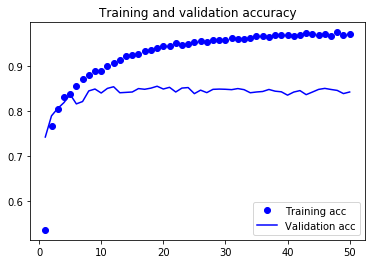

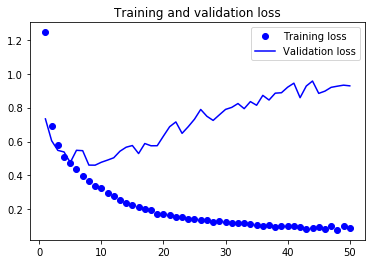

In [179]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [330]:
target_image = imread('D:/DL/Test_0418_Seoul.tif')
target_image_l = np.asarray(target_image)

#target_image_l8 = target_image_l - 1
#target_image_l8 = target_image_l8 / 256
#target_image_l8 = target_image_l8.astype(np.uint8)

### 8-bit rescaling
+ With a 04/18/2018 scene of Sentinel-2A imagery near Seoul, we will try classifying it into 10 classes which were labelled at EuroSAT dataset. 
+ Before we proceed, we should rescale our original imagery in unsigned 16-bit data to unsigned 8-bit.
+ We trimmed 0.0~1.0 and 99.0~100.0 percentile of values to avoid the imagery after rescaling to be too dark.

In [410]:
from scipy.misc import bytescale
cmin_0 = np.percentile(target_image_l, 1.)
cmax_0 = np.percentile(target_image_l, 97.5)
til8 = bytescale(target_image_l, cmin = cmin_0, cmax = cmax_0)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  after removing the cwd from sys.path.


MemoryError: 

<Figure size 864x864 with 0 Axes>

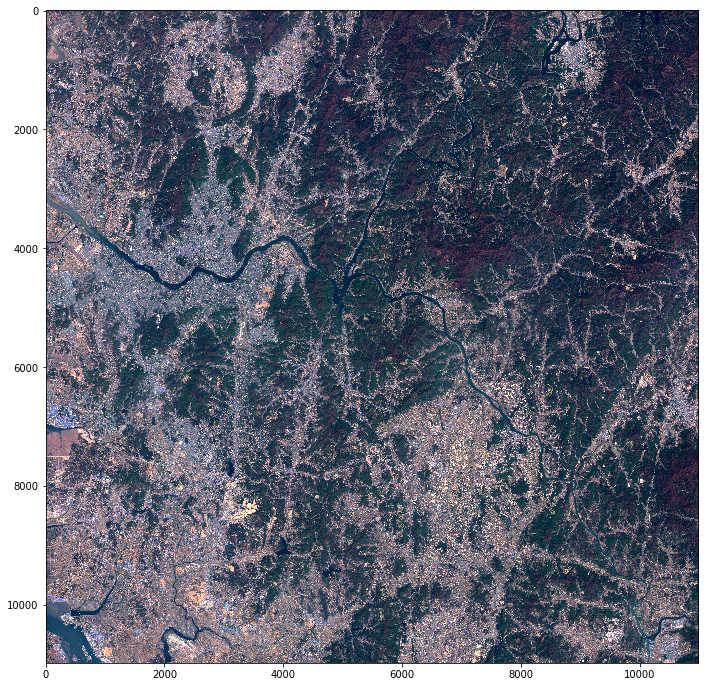

In [411]:
#til8[:,:,0]
pyp.figure(figsize = (12, 12))
pyp.imshow(til8)


<Figure size 864x864 with 0 Axes>

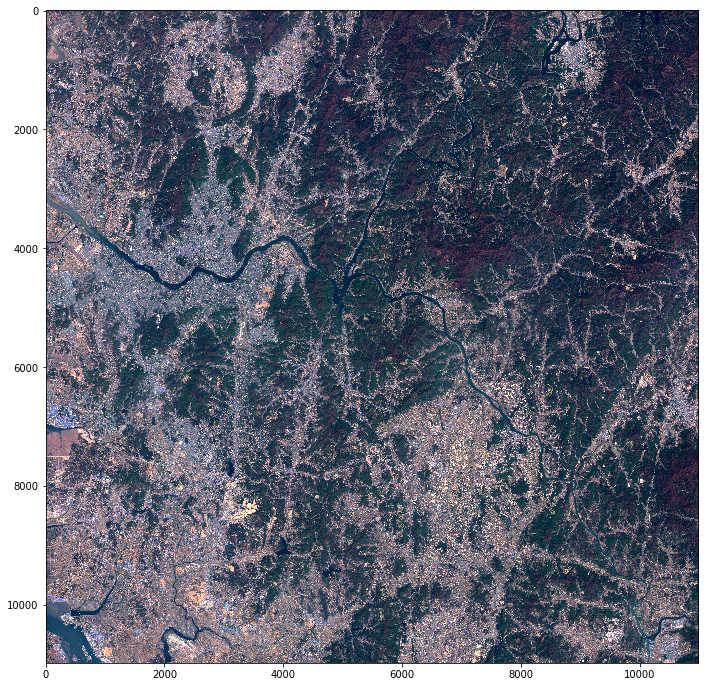

In [ ]:
pyp.figure(figsize = (18, 7))
pyp.subplot(131)
pyp.hist(til8[:,:,0].reshape(10980**2))
pyp.subplot(132)
pyp.hist(til8[:,:,1].reshape(10980**2))
pyp.subplot(133)
pyp.hist(til8[:,:,2].reshape(10980**2))
#np.percentile(target_image_l, 99.99)
#np.percentile(target_image_l, 0.01)


### Random subset of the imagery
+ The code block below functions to generate 4000 pairs of addresses for subsetting the imagery

In [ ]:
target_image_l.ndim
#model.predict(target_image_l[8320:8384, 1230:1294, :])
#til = target_image_l[8320:8384, 1230:1294, :].reshape((1,64,64,3))
#til_s = conv_base.predict(til/2**11)
#til_ss = til_s.reshape((1, 32, 32, 2))
#model.predict_classes(til_ss)

#til_i = til.reshape((64,64,3))
#pyp.imshow(til_i/2**11)


target_image_l.shape
topset_x = np.random.choice(10916, 4000)
topset_y = np.random.choice(10916, 4000)
#topset_x; topset_y

topset_xcor = np.asarray([np.arange(y, y+64) for y in topset_x])
topset_ycor = np.asarray([np.arange(z, z+64) for z in topset_y])


### Main prediction
+ With `(x,y)` addresses, we obtain 4000 `(64,64,3)` imagery patches;
+ Then we put them to the pretrained `imagenet` weights under `VGG16` architecture, then predict 10 classes thereof

In [ ]:
tils = [til8[[i.reshape(64,1) for i in topset_xcor], [j.reshape(1, 64) for j in topset_ycor], :]]
# Reshape ndarray to 4D
tils = np.asarray(tils).reshape(4000, 64, 64, 3)
# 1st prediction by using pretrained imagenet weights
tils_s = conv_base.predict(tils/255.) #255.
# Reshape (2,2,512) output to (32,32,2)
tils_ss = tils_s.reshape((4000, 32, 32, 2))
# Predict classes by using the trained model
tils_predict = model.predict_classes(tils_ss)



['River',
 'Highway',
 'Residential',
 'Permanent Crop',
 'Pasture',
 'Industrial',
 'Permanent Crop',
 'Herbaceous',
 'Residential',
 'Highway',
 'Permanent Crop',
 'River']

(array([ 14.,  43., 588., 606., 821., 327., 482., 441., 635.,  43.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

<Figure size 1512x360 with 0 Axes>

Text(0.5,1,'River')

Text(0.5,1,'Highway')

Text(0.5,1,'Residential')

Text(0.5,1,'Permanent Crop')

Text(0.5,1,'Pasture')

Text(0.5,1,'Industrial')

Text(0.5,1,'Permanent Crop')

Text(0.5,1,'Herbaceous')

Text(0.5,1,'Residential')

Text(0.5,1,'Highway')

Text(0.5,1,'Permanent Crop')

Text(0.5,1,'River')

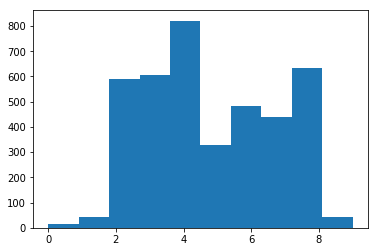

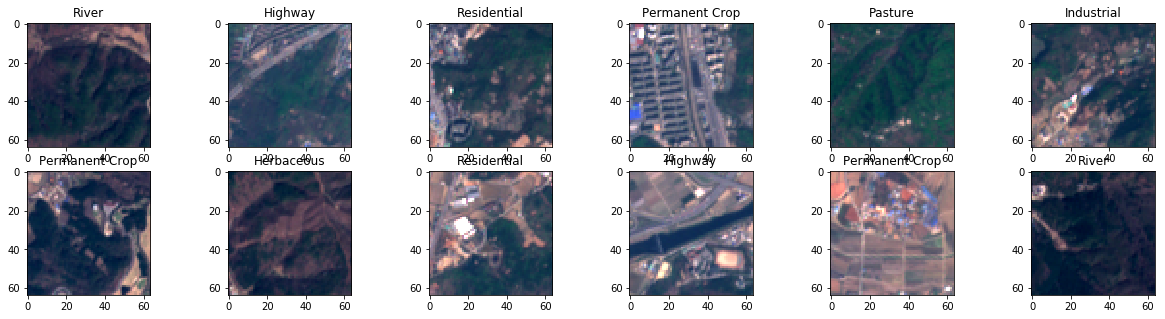

In [412]:
#labels[tils_predict[0:6]]
#labels.items()[tils_predict[0:6].tolist()]
labels_12 = [labels[j] for j in tils_predict[0:12]]
labels_12
pyp.hist(tils_predict)
#tils[0, :, :, :]
pyp.figure(figsize = (21, 10))
pyp.subplot(261)
pyp.title(labels_12[0])
pyp.imshow(tils[0, :, :, :])
pyp.subplot(262)
pyp.title(labels_12[1])
pyp.imshow(tils[1, :, :, :]/255.)
pyp.subplot(263)
pyp.title(labels_12[2])
pyp.imshow(tils[2, :, :, :]/255.)
pyp.subplot(264)
pyp.title(labels_12[3])
pyp.imshow(tils[3, :, :, :]/255.)
pyp.subplot(265)
pyp.title(labels_12[4])
pyp.imshow(tils[4, :, :, :]/255.)
pyp.subplot(266)
pyp.title(labels_12[5])
pyp.imshow(tils[5, :, :, :]/255.)
pyp.subplot(267)
pyp.title(labels_12[6])
pyp.imshow(tils[6, :, :, :])
pyp.subplot(268)
pyp.title(labels_12[7])
pyp.imshow(tils[7, :, :, :]/255.)
pyp.subplot(269)
pyp.title(labels_12[8])
pyp.imshow(tils[8, :, :, :]/255.)
pyp.subplot(2,6,10)
pyp.title(labels_12[9])
pyp.imshow(tils[9, :, :, :]/255.)
pyp.subplot(2,6,11)
pyp.title(labels_12[10])
pyp.imshow(tils[10, :, :, :]/255.)
pyp.subplot(2,6,12)
pyp.title(labels_12[11])
pyp.imshow(tils[11, :, :, :]/255.)

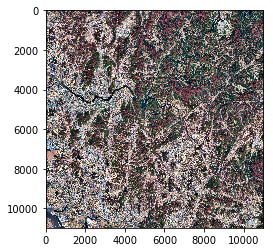

In [400]:
import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15,15))
#cl1 = clahe.apply(til8)
dowsr = clahe.apply(til8[:,:,0])
dowsg = clahe.apply(til8[:,:,1])
dowsb = clahe.apply(til8[:,:,2])
dows = np.dstack((dowsr, dowsg, dowsb))

pyp.imshow(dows)


['Highway', 'Highway', 'Industrial', 'Residential', 'Highway', 'Residential']

<Figure size 1512x360 with 0 Axes>

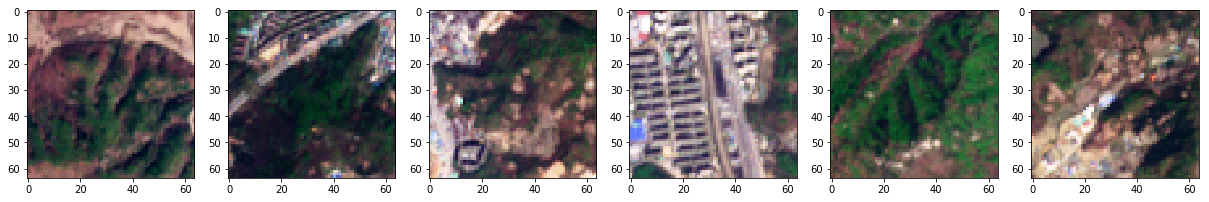

In [401]:
dows_sub = [dows[[i.reshape(64,1) for i in topset_xcor[:100]], [j.reshape(1, 64) for j in topset_ycor[:100]], :]]
dows_sub = np.asarray(dows_sub).reshape(100, 64, 64, 3)
dows_sub_s = conv_base.predict(dows_sub/255.) #255.
dows_sub_ss = dows_sub_s.reshape((100, 32, 32, 2))
dows_sub_predict = model.predict_classes(dows_sub_ss)

[labels[j] for j in dows_sub_predict[0:6]]

pyp.figure(figsize = (21, 5))
pyp.subplot(161)
pyp.imshow(dows_sub[0, :, :, :])
pyp.subplot(162)
pyp.imshow(dows_sub[1, :, :, :]/255.)
pyp.subplot(163)
pyp.imshow(dows_sub[2, :, :, :]/255.)
pyp.subplot(164)
pyp.imshow(dows_sub[3, :, :, :]/255.)
pyp.subplot(165)
pyp.imshow(dows_sub[4, :, :, :]/255.)
pyp.subplot(166)
pyp.imshow(dows_sub[5, :, :, :]/255.)

<Figure size 432x288 with 0 Axes>

(array([230., 451., 314., 299., 473., 645., 382., 494., 179., 629.]),
 array([ 50. ,  70.5,  91. , 111.5, 132. , 152.5, 173. , 193.5, 214. ,
        234.5, 255. ]),
 <a list of 10 Patch objects>)

(array([378., 517., 463., 824., 729., 323., 190., 286., 312.,  74.]),
 array([ 74. ,  88.3, 102.6, 116.9, 131.2, 145.5, 159.8, 174.1, 188.4,
        202.7, 217. ]),
 <a list of 10 Patch objects>)

(array([174., 709., 379., 733., 944., 313., 261., 310., 240.,  33.]),
 array([ 79. ,  90.6, 102.2, 113.8, 125.4, 137. , 148.6, 160.2, 171.8,
        183.4, 195. ]),
 <a list of 10 Patch objects>)

(array([ 677., 1198.,  564.,  606.,  455.,  269.,  164.,  132.,   27.,
           4.]),
 array([ 11. ,  28.5,  46. ,  63.5,  81. ,  98.5, 116. , 133.5, 151. ,
        168.5, 186. ]),
 <a list of 10 Patch objects>)

(array([ 767., 1183.,  428.,  602.,  425.,  306.,  213.,  123.,   44.,
           5.]),
 array([ 23. ,  34.3,  45.6,  56.9,  68.2,  79.5,  90.8, 102.1, 113.4,
        124.7, 136. ]),
 <a list of 10 Patch objects>)

(array([1524.,  592.,  429.,  476.,  402.,  277.,  245.,  112.,   27.,
          12.]),
 array([ 41. ,  49.3,  57.6,  65.9,  74.2,  82.5,  90.8,  99.1, 107.4,
        115.7, 124. ]),
 <a list of 10 Patch objects>)

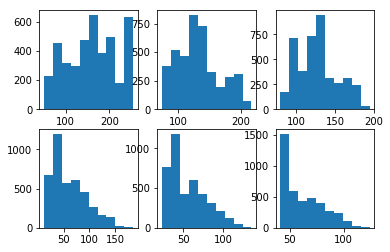

In [355]:
#pyp.hist(trains[0])
#trains[0].shape
pyp.figure()
pyp.subplot(231)
pyp.hist(trains[0][:,:,0].reshape(64*64))
pyp.subplot(232)
pyp.hist(trains[0][:,:,1].reshape(64*64))
pyp.subplot(233)
pyp.hist(trains[0][:,:,2].reshape(64*64))

pyp.subplot(234)
pyp.hist(tils[0,:,:,0].reshape(64*64))
pyp.subplot(235)
pyp.hist(tils[0,:,:,1].reshape(64*64))
pyp.subplot(236)
pyp.hist(tils[0,:,:,2].reshape(64*64))
